## Interpretability via Bilinear Layer
Bilinear layer trained to do perform $(x + y) \mathrm{mod} P$. $P$ is chosen to be $113$.

The input will be a pair $z = (x, y)$. The binary layer computes $g(z)=(Lz)\odot (Rz)$, where $L,R\in\mathrm{mat}(d_\text{hidden}, d_\text{input})$. 

In [1]:
import torch
from torch import nn, Tensor
from jaxtyping import Float
from dataclasses import dataclass

# Architecture code

class Bilinear(nn.Linear):
    """From the paper repo, `components.py`"""
    def __init__(self, d_in: int, d_out: int, bias=False, gate=None) -> None:
        super().__init__(d_in, 2 * d_out, bias=bias)
        self.gate = {"relu":nn.ReLU(), "silu":nn.SiLU(), "gelu":nn.GELU(), None: nn.Identity()}[gate]
    
    def forward(self, x: Float[Tensor, "... d_in"]) -> Float[Tensor, "... d_out"]:
        left, right = super().forward(x).chunk(2, dim=-1)
        return self.gate(left) * right
    
    @property
    def w_l(self):
        return self.weight.chunk(2, dim=0)[0]
    
    @property
    def w_r(self):
        return self.weight.chunk(2, dim=0)[1]

@dataclass
class ModelConfig:
    p: int = 113
    d_hidden: int | None = None
    bias: bool = False


class Model(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.bi_linear = Bilinear(d_in=2*cfg.p, d_out=cfg.d_hidden, bias=cfg.bias) 
        self.projection = nn.Linear(cfg.d_hidden, cfg.p, bias=cfg.bias)

    def forward(self, x):
        return self.projection(self.bi_linear(x))
    
    @property
    def w_l(self):
        return self.bi_linear.w_l
    
    @property
    def w_r(self):
        return self.bi_linear.w_r
    
    @property
    def w_p(self):
        return self.projection.weight
    
def init_model(cfg: ModelConfig):
    if cfg.d_hidden is None:
        return Bilinear(d_in=2*cfg.p, d_out=cfg.p, bias=cfg.bias)
    else:
        return Model(cfg)

In [2]:
import math
from typing import Tuple, Dict, Any 

@dataclass
class DataConfig:
    P: int = 113
    train_size: float = 0.8

# Generating the data
def generate_modular_addition_data(P: int):
    """Generate all possible (a, b, (a+b) mod P) pairs"""

    # Generate all P^2 combinations
    a_vals = torch.arange(P).repeat_interleave(P)
    b_vals = torch.arange(P).repeat(P)
    x_vals = torch.stack(tensors = (a_vals, b_vals), dim=-1)

    # One Hot encode as in the Less Wrong Post:
    a_1hot = torch.nn.functional.one_hot(input=a_vals, num_classes=P).float() # shape = (P^2, P)
    b_1hot = torch.nn.functional.one_hot(input=b_vals, num_classes=P).float()
    x_1hot = torch.cat(tensors=(a_1hot, b_1hot), dim=-1) # shape = (P^2, 2P)

    # Precompute target
    targets = (a_vals + b_vals) % P
    
    return x_vals, x_1hot, targets



_LOSS_MAP = {
    "crossentropy": nn.CrossEntropyLoss, # Logits vs targets
    "mse": nn.MSELoss,
    "bce": nn.BCEWithLogitsLoss,
    "binarycrossentropy": nn.BCEWithLogitsLoss,
    "vanilla": nn.BCEWithLogitsLoss
}

@dataclass
class CriterionConfig:
    name: str = "crossentropy" # mse
    kwargs: dict | None = None

def get_criterion(cfg: CriterionConfig) -> nn.Module:
    """
    Instantiates a loss function based on the configuration specification.

    The function looks up a registered loss in `_LOSS_MAP` using a normalized
    version of the name provided in `cfg.name`. It supports flexible name
    variants (case- and delimiter-insensitive) and automatically handles
    optional keyword arguments.

    Parameters
    ----------
    cfg : schemas.CriterionConfig
        Configuration object specifying:
        - `name`: name or alias of the desired loss function (e.g. "nll", "bce").
        - `kwargs`: optional dictionary of keyword arguments for initialization.

    Returns
    -------
    nn.Module
        A PyTorch loss module ready to be used for training.

    Raises
    ------
    ValueError
        If the specified loss name does not match any entry in `_LOSS_MAP`.
    """
    key = cfg.name.replace(" ", "").replace("-", "").lower()
    if key not in _LOSS_MAP:
        raise ValueError(f"Loss '{cfg.name}' not recognised")
    # use empty dict if kwargs is None
    return _LOSS_MAP[key](**(cfg.kwargs or {}))

_OPTIMIZER_MAP = {
    "sgd": torch.optim.SGD,
    "adam": torch.optim.Adam,
    "adamw": torch.optim.AdamW,
    "rmsprop": torch.optim.RMSprop,
    "adagrad": torch.optim.Adagrad,
    "adamax": torch.optim.Adamax,
    "nadam": torch.optim.NAdam,
}
@dataclass
class OptimizerConfig:
    name: str = "adamw" # adam
    lr: float = 0.003
    weight_decay: float | None = 1e-4


def get_optimizer(params, config: OptimizerConfig) -> torch.optim.Optimizer:
    """
    Select and instantiate a PyTorch optimizer.

    Parameters
    ----------
    params : iterable
        Parameters to optimize, e.g. model.parameters()
    config.name : str
        Name of the optimizer, e.g. "adam"
    config.kwargs : dict, optional
        Extra arguments passed to the optimizer, e.g. {"lr": 1e-3}

    Returns
    -------
    optim.Optimizer
        Instantiated optimizer.
    """
    key = config.name.replace("-", "").replace("_", "").lower()
    try:
        optimizer_cls = _OPTIMIZER_MAP[key]
    except KeyError:
        raise ValueError(f"Optimizer {config.name} not recognised. "
                         f"Available: {list(_OPTIMIZER_MAP.keys())}")

    kwargs = {"lr": config.lr}
    if config.weight_decay is not None:
        kwargs["weight_decay"] = config.weight_decay
    
    return optimizer_cls(params, **kwargs)

# Shuffle data, split data, create dataloaders
def get_loaders(x: Tensor, t: torch.LongTensor, train_size: float, batch_size: int):
    perm = torch.randperm(x.size(0))
    x, t = x[perm], t[perm]

    split = math. ceil(train_size * x.size(0))
    x_train, x_valid = x.split(split)
    t_train, t_valid = t.split(split)

    train_data = torch.utils.data.TensorDataset(x_train, t_train)
    valid_data = torch.utils.data.TensorDataset(x_valid, t_valid)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader


from tqdm import tqdm
import matplotlib.pyplot as plt

def eval(model: Bilinear | Model, 
         loader: torch.utils.data.DataLoader,
         criterion: nn.CrossEntropyLoss) -> Tuple[float, float]:
    """Evaluate model on validation set"""
    model.eval()
    losses = []
    accs = []
    
    with torch.no_grad():
        for x, t in loader:
            logit = model(x)
            loss = criterion(logit, t)
            losses.append(loss.item())
            
            # Calculate accuracy
            pred = logit.argmax(dim=-1)
            acc = (pred == t).float().mean().item()
            accs.append(acc)
    
    # Return average loss and accuracy
    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(accs) / len(accs)
    
    return avg_loss, avg_acc

@dataclass
class TrainConfig:
    batch_size: int = 256
    epochs: int = 2000
    optimizer = OptimizerConfig
    criterion = CriterionConfig

def train_loop(
        model: Bilinear | Model, 
        loaders: Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader],
        cfg: TrainConfig):
    """Training loop with validation, checkpointing, and plotting"""
    
    criterion = get_criterion(cfg.criterion)
    optimizer = get_optimizer(model.parameters(), cfg.optimizer)
    train_loader, valid_loader = loaders
    
    # Track metrics
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    
    # Best model tracking
    best_valid_loss = float('inf')
    best_model_state = None
    
    # Progress bar for epochs
    pbar = tqdm(range(cfg.epochs), desc="Training")
    
    for epoch in pbar:
        # ==================== Training Phase ====================
        model.train()
        epoch_train_losses = []
        epoch_train_accs = []
        
        for x, t in train_loader:
            logit = model(x)
            loss = criterion(logit, t)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track metrics
            epoch_train_losses.append(loss.item())
            
            with torch.no_grad():
                pred = logit.argmax(dim=-1)
                acc = (pred == t).float().mean().item()
                epoch_train_accs.append(acc)
        
        # Average training metrics for this epoch
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        avg_train_acc = sum(epoch_train_accs) / len(epoch_train_accs)
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        
        # ==================== Validation Phase ====================
        valid_loss, valid_acc = eval(model, valid_loader, criterion)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        
        # ==================== Save Best Model ====================
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        
        # ==================== Update Progress Bar ====================
        pbar.set_postfix({
            'train_loss': f'{avg_train_loss:.4f}',
            'train_acc': f'{avg_train_acc:.4f}',
            'valid_loss': f'{valid_loss:.4f}',
            'valid_acc': f'{valid_acc:.4f}',
            'best_valid': f'{best_valid_loss:.4f}'
        })
    
    # ==================== Load Best Model ====================
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nLoaded best model with validation loss: {best_valid_loss:.4f}")
    
    # ==================== Plot Results ====================
    if isinstance(model, Bilinear):
        arc = "Layer"
    else: arc = "withHead"
    plot_training_results(train_losses, valid_losses, train_accs, valid_accs, arc)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'valid_losses': valid_losses,
        'valid_accs': valid_accs,
        'best_valid_loss': best_valid_loss
    }

def plot_training_results(train_losses, valid_losses, train_accs, valid_accs, 
                          arc: str = "Layer", y_scale: str = "linear",
                          cut_off_epoch: int | None = None):
    """Plot training and validation losses and accuracies"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    if cut_off_epoch is None:
        cut_off_epoch = len(train_losses)
    # Plot losses
    ax1.plot(train_losses[:cut_off_epoch], label='Train Loss', alpha=0.8)
    ax1.plot(valid_losses[:cut_off_epoch], label='Valid Loss', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')  
    ax1.set_yscale(y_scale)
    ax1.set_title(f'{arc}: Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracies
    ax2.plot(train_accs[:cut_off_epoch], label='Train Acc', alpha=0.8)
    ax2.plot(valid_accs[:cut_off_epoch], label='Valid Acc', alpha=0.8)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{arc}: Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'app_diagrams/{arc}_training_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved {arc}_training_results.png")

In [3]:
pairs, onehots, labels = generate_modular_addition_data(P=DataConfig.P)
print(f"{pairs.size()=}")
print(f"{onehots.size()=}")
print(f"{labels.size()=}")
loaders = get_loaders(onehots, labels, DataConfig.train_size, TrainConfig.batch_size)

pairs.size()=torch.Size([12769, 2])
onehots.size()=torch.Size([12769, 226])
labels.size()=torch.Size([12769])


### Training a single Layer without projection

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Training:   0%|          | 0/2000 [00:00<?, ?it/s, train_loss=4.7300, train_acc=0.0023, valid_loss=4.7367, valid_acc=0.0012, best_valid=4.7367]

Training:   0%|          | 1/2000 [00:00<06:58,  4.78it/s, train_loss=4.7300, train_acc=0.0023, valid_loss=4.7367, valid_acc=0.0012, best_valid=4.7367]

Training:   0%|          | 1/2000 [00:00<06:58,  4.78it/s, train_loss=4.7145, train_acc=0.0426, valid_loss=4.7896, valid_acc=0.0027, best_valid=4.7367]

Training:   0%|          | 2/2000 [00:00<06:13,  5.35it/s, train_loss=4.7145, train_acc=0.0426, valid_loss=4.7896, valid_acc=0.0027, best_valid=4.7367]

Training:   0%|          | 2/2000 [00:00<06:13,  5.35it/s, train_loss=4.6831, train_acc=0.0562, valid_loss=4.9081, valid_acc=0.0008, best_valid=4.7367]

Training:   0%|          | 3/2000 [00:00<05:58,  5.57it/s, train_loss=4.6831, train_acc=0.0562, valid_loss=4.9081, valid_acc=0.0008, best_valid=4.7367]

Training:   0%|          | 3/2000 [00:00<05:58,  5.57it/s, train_loss=4.6320, train_acc=0.0659, valid_loss=5.0985, valid_acc=0.0012, best_valid=4.7367]

Training:   0%|          | 4/2000 [00:00<05:41,  5.84it/s, train_loss=4.6320, train_acc=0.0659, valid_loss=5.0985, valid_acc=0.0012, best_valid=4.7367]

Training:   0%|          | 4/2000 [00:00<05:41,  5.84it/s, train_loss=4.5657, train_acc=0.0762, valid_loss=5.3533, valid_acc=0.0000, best_valid=4.7367]

Training:   0%|          | 5/2000 [00:00<05:27,  6.10it/s, train_loss=4.5657, train_acc=0.0762, valid_loss=5.3533, valid_acc=0.0000, best_valid=4.7367]

Training:   0%|          | 5/2000 [00:01<05:27,  6.10it/s, train_loss=4.4914, train_acc=0.0888, valid_loss=5.6580, valid_acc=0.0000, best_valid=4.7367]

Training:   0%|          | 6/2000 [00:01<05:15,  6.31it/s, train_loss=4.4914, train_acc=0.0888, valid_loss=5.6580, valid_acc=0.0000, best_valid=4.7367]

Training:   0%|          | 6/2000 [00:01<05:15,  6.31it/s, train_loss=4.4152, train_acc=0.1038, valid_loss=6.0007, valid_acc=0.0004, best_valid=4.7367]

Training:   0%|          | 7/2000 [00:01<05:05,  6.53it/s, train_loss=4.4152, train_acc=0.1038, valid_loss=6.0007, valid_acc=0.0004, best_valid=4.7367]

Training:   0%|          | 7/2000 [00:01<05:05,  6.53it/s, train_loss=4.3409, train_acc=0.1175, valid_loss=6.3713, valid_acc=0.0004, best_valid=4.7367]

Training:   0%|          | 8/2000 [00:01<05:01,  6.61it/s, train_loss=4.3409, train_acc=0.1175, valid_loss=6.3713, valid_acc=0.0004, best_valid=4.7367]

Training:   0%|          | 8/2000 [00:01<05:01,  6.61it/s, train_loss=4.2703, train_acc=0.1273, valid_loss=6.7626, valid_acc=0.0004, best_valid=4.7367]

Training:   0%|          | 9/2000 [00:01<04:52,  6.80it/s, train_loss=4.2703, train_acc=0.1273, valid_loss=6.7626, valid_acc=0.0004, best_valid=4.7367]

Training:   0%|          | 9/2000 [00:01<04:52,  6.80it/s, train_loss=4.2050, train_acc=0.1433, valid_loss=7.1688, valid_acc=0.0000, best_valid=4.7367]

Training:   0%|          | 10/2000 [00:01<04:56,  6.70it/s, train_loss=4.2050, train_acc=0.1433, valid_loss=7.1688, valid_acc=0.0000, best_valid=4.7367]

Training:   0%|          | 10/2000 [00:01<04:56,  6.70it/s, train_loss=4.1446, train_acc=0.1572, valid_loss=7.5869, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 11/2000 [00:01<04:55,  6.74it/s, train_loss=4.1446, train_acc=0.1572, valid_loss=7.5869, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 11/2000 [00:01<04:55,  6.74it/s, train_loss=4.0887, train_acc=0.1708, valid_loss=8.0145, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 12/2000 [00:01<05:00,  6.61it/s, train_loss=4.0887, train_acc=0.1708, valid_loss=8.0145, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 12/2000 [00:02<05:00,  6.61it/s, train_loss=4.0374, train_acc=0.1845, valid_loss=8.4508, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 13/2000 [00:02<05:08,  6.44it/s, train_loss=4.0374, train_acc=0.1845, valid_loss=8.4508, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 13/2000 [00:02<05:08,  6.44it/s, train_loss=3.9897, train_acc=0.1989, valid_loss=8.8950, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 14/2000 [00:02<04:57,  6.67it/s, train_loss=3.9897, train_acc=0.1989, valid_loss=8.8950, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 14/2000 [00:02<04:57,  6.67it/s, train_loss=3.9453, train_acc=0.2089, valid_loss=9.3461, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 15/2000 [00:02<04:57,  6.67it/s, train_loss=3.9453, train_acc=0.2089, valid_loss=9.3461, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 15/2000 [00:02<04:57,  6.67it/s, train_loss=3.9030, train_acc=0.2225, valid_loss=9.8047, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 16/2000 [00:02<05:01,  6.58it/s, train_loss=3.9030, train_acc=0.2225, valid_loss=9.8047, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 16/2000 [00:02<05:01,  6.58it/s, train_loss=3.8635, train_acc=0.2339, valid_loss=10.2699, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 17/2000 [00:02<05:16,  6.27it/s, train_loss=3.8635, train_acc=0.2339, valid_loss=10.2699, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 17/2000 [00:02<05:16,  6.27it/s, train_loss=3.8253, train_acc=0.2403, valid_loss=10.7426, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 18/2000 [00:02<05:08,  6.42it/s, train_loss=3.8253, train_acc=0.2403, valid_loss=10.7426, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 18/2000 [00:02<05:08,  6.42it/s, train_loss=3.7892, train_acc=0.2439, valid_loss=11.2181, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 19/2000 [00:02<05:09,  6.39it/s, train_loss=3.7892, train_acc=0.2439, valid_loss=11.2181, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 19/2000 [00:03<05:09,  6.39it/s, train_loss=3.7533, train_acc=0.2540, valid_loss=11.7023, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 20/2000 [00:03<05:01,  6.58it/s, train_loss=3.7533, train_acc=0.2540, valid_loss=11.7023, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 20/2000 [00:03<05:01,  6.58it/s, train_loss=3.7194, train_acc=0.2528, valid_loss=12.1868, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 21/2000 [00:03<04:51,  6.78it/s, train_loss=3.7194, train_acc=0.2528, valid_loss=12.1868, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 21/2000 [00:03<04:51,  6.78it/s, train_loss=3.6861, train_acc=0.2540, valid_loss=12.6746, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 22/2000 [00:03<04:46,  6.90it/s, train_loss=3.6861, train_acc=0.2540, valid_loss=12.6746, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 22/2000 [00:03<04:46,  6.90it/s, train_loss=3.6531, train_acc=0.2566, valid_loss=13.1631, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 23/2000 [00:03<04:57,  6.64it/s, train_loss=3.6531, train_acc=0.2566, valid_loss=13.1631, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 23/2000 [00:03<04:57,  6.64it/s, train_loss=3.6215, train_acc=0.2588, valid_loss=13.6500, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 24/2000 [00:03<05:43,  5.75it/s, train_loss=3.6215, train_acc=0.2588, valid_loss=13.6500, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|          | 24/2000 [00:03<05:43,  5.75it/s, train_loss=3.5896, train_acc=0.2583, valid_loss=14.1338, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|▏         | 25/2000 [00:03<05:22,  6.12it/s, train_loss=3.5896, train_acc=0.2583, valid_loss=14.1338, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|▏         | 25/2000 [00:04<05:22,  6.12it/s, train_loss=3.5589, train_acc=0.2588, valid_loss=14.6167, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|▏         | 26/2000 [00:04<05:06,  6.44it/s, train_loss=3.5589, train_acc=0.2588, valid_loss=14.6167, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|▏         | 26/2000 [00:04<05:06,  6.44it/s, train_loss=3.5283, train_acc=0.2537, valid_loss=15.0943, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|▏         | 27/2000 [00:04<06:07,  5.37it/s, train_loss=3.5283, train_acc=0.2537, valid_loss=15.0943, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|▏         | 27/2000 [00:04<06:07,  5.37it/s, train_loss=3.4999, train_acc=0.2525, valid_loss=15.5636, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|▏         | 28/2000 [00:04<05:48,  5.66it/s, train_loss=3.4999, train_acc=0.2525, valid_loss=15.5636, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|▏         | 28/2000 [00:04<05:48,  5.66it/s, train_loss=3.4718, train_acc=0.2496, valid_loss=16.0292, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|▏         | 29/2000 [00:04<05:30,  5.97it/s, train_loss=3.4718, train_acc=0.2496, valid_loss=16.0292, valid_acc=0.0000, best_valid=4.7367]

Training:   1%|▏         | 29/2000 [00:04<05:30,  5.97it/s, train_loss=3.4446, train_acc=0.2490, valid_loss=16.4866, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 30/2000 [00:04<05:28,  6.00it/s, train_loss=3.4446, train_acc=0.2490, valid_loss=16.4866, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 30/2000 [00:04<05:28,  6.00it/s, train_loss=3.4164, train_acc=0.2466, valid_loss=16.9381, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 31/2000 [00:04<05:39,  5.79it/s, train_loss=3.4164, train_acc=0.2466, valid_loss=16.9381, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 31/2000 [00:05<05:39,  5.79it/s, train_loss=3.3904, train_acc=0.2440, valid_loss=17.3802, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 32/2000 [00:05<05:48,  5.65it/s, train_loss=3.3904, train_acc=0.2440, valid_loss=17.3802, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 32/2000 [00:05<05:48,  5.65it/s, train_loss=3.3652, train_acc=0.2412, valid_loss=17.8161, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 33/2000 [00:05<05:52,  5.59it/s, train_loss=3.3652, train_acc=0.2412, valid_loss=17.8161, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 33/2000 [00:05<05:52,  5.59it/s, train_loss=3.3397, train_acc=0.2400, valid_loss=18.2424, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 34/2000 [00:05<05:41,  5.75it/s, train_loss=3.3397, train_acc=0.2400, valid_loss=18.2424, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 34/2000 [00:05<05:41,  5.75it/s, train_loss=3.3165, train_acc=0.2377, valid_loss=18.6610, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 35/2000 [00:05<05:32,  5.92it/s, train_loss=3.3165, train_acc=0.2377, valid_loss=18.6610, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 35/2000 [00:05<05:32,  5.92it/s, train_loss=3.2930, train_acc=0.2357, valid_loss=19.0719, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 36/2000 [00:05<05:27,  6.00it/s, train_loss=3.2930, train_acc=0.2357, valid_loss=19.0719, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 36/2000 [00:05<05:27,  6.00it/s, train_loss=3.2699, train_acc=0.2369, valid_loss=19.4774, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 37/2000 [00:05<05:25,  6.03it/s, train_loss=3.2699, train_acc=0.2369, valid_loss=19.4774, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 37/2000 [00:06<05:25,  6.03it/s, train_loss=3.2482, train_acc=0.2295, valid_loss=19.8732, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 38/2000 [00:06<05:21,  6.11it/s, train_loss=3.2482, train_acc=0.2295, valid_loss=19.8732, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 38/2000 [00:06<05:21,  6.11it/s, train_loss=3.2275, train_acc=0.2305, valid_loss=20.2641, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 39/2000 [00:06<05:18,  6.15it/s, train_loss=3.2275, train_acc=0.2305, valid_loss=20.2641, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 39/2000 [00:06<05:18,  6.15it/s, train_loss=3.2064, train_acc=0.2315, valid_loss=20.6468, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 40/2000 [00:06<05:18,  6.15it/s, train_loss=3.2064, train_acc=0.2315, valid_loss=20.6468, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 40/2000 [00:06<05:18,  6.15it/s, train_loss=3.1867, train_acc=0.2298, valid_loss=21.0237, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 41/2000 [00:06<05:06,  6.40it/s, train_loss=3.1867, train_acc=0.2298, valid_loss=21.0237, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 41/2000 [00:06<05:06,  6.40it/s, train_loss=3.1685, train_acc=0.2269, valid_loss=21.3931, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 42/2000 [00:06<04:50,  6.75it/s, train_loss=3.1685, train_acc=0.2269, valid_loss=21.3931, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 42/2000 [00:06<04:50,  6.75it/s, train_loss=3.1488, train_acc=0.2264, valid_loss=21.7585, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 43/2000 [00:06<04:39,  7.00it/s, train_loss=3.1488, train_acc=0.2264, valid_loss=21.7585, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 43/2000 [00:07<04:39,  7.00it/s, train_loss=3.1312, train_acc=0.2256, valid_loss=22.1189, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 44/2000 [00:07<04:49,  6.76it/s, train_loss=3.1312, train_acc=0.2256, valid_loss=22.1189, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 44/2000 [00:07<04:49,  6.76it/s, train_loss=3.1140, train_acc=0.2267, valid_loss=22.4736, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 45/2000 [00:07<05:09,  6.32it/s, train_loss=3.1140, train_acc=0.2267, valid_loss=22.4736, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 45/2000 [00:07<05:09,  6.32it/s, train_loss=3.0971, train_acc=0.2255, valid_loss=22.8226, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 46/2000 [00:07<05:06,  6.37it/s, train_loss=3.0971, train_acc=0.2255, valid_loss=22.8226, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 46/2000 [00:07<05:06,  6.37it/s, train_loss=3.0811, train_acc=0.2262, valid_loss=23.1674, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 47/2000 [00:07<04:59,  6.52it/s, train_loss=3.0811, train_acc=0.2262, valid_loss=23.1674, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 47/2000 [00:07<04:59,  6.52it/s, train_loss=3.0667, train_acc=0.2234, valid_loss=23.5076, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 48/2000 [00:07<04:53,  6.64it/s, train_loss=3.0667, train_acc=0.2234, valid_loss=23.5076, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 48/2000 [00:07<04:53,  6.64it/s, train_loss=3.0514, train_acc=0.2236, valid_loss=23.8430, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 49/2000 [00:07<04:52,  6.68it/s, train_loss=3.0514, train_acc=0.2236, valid_loss=23.8430, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▏         | 49/2000 [00:07<04:52,  6.68it/s, train_loss=3.0363, train_acc=0.2207, valid_loss=24.1758, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▎         | 50/2000 [00:07<04:50,  6.72it/s, train_loss=3.0363, train_acc=0.2207, valid_loss=24.1758, valid_acc=0.0000, best_valid=4.7367]

Training:   2%|▎         | 50/2000 [00:08<04:50,  6.72it/s, train_loss=3.0224, train_acc=0.2242, valid_loss=24.5022, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 51/2000 [00:08<04:48,  6.75it/s, train_loss=3.0224, train_acc=0.2242, valid_loss=24.5022, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 51/2000 [00:08<04:48,  6.75it/s, train_loss=3.0093, train_acc=0.2242, valid_loss=24.8256, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 52/2000 [00:08<04:46,  6.79it/s, train_loss=3.0093, train_acc=0.2242, valid_loss=24.8256, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 52/2000 [00:08<04:46,  6.79it/s, train_loss=2.9962, train_acc=0.2228, valid_loss=25.1464, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 53/2000 [00:08<04:39,  6.97it/s, train_loss=2.9962, train_acc=0.2228, valid_loss=25.1464, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 53/2000 [00:08<04:39,  6.97it/s, train_loss=2.9831, train_acc=0.2233, valid_loss=25.4616, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 54/2000 [00:08<04:37,  7.01it/s, train_loss=2.9831, train_acc=0.2233, valid_loss=25.4616, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 54/2000 [00:08<04:37,  7.01it/s, train_loss=2.9712, train_acc=0.2243, valid_loss=25.7752, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 55/2000 [00:08<05:32,  5.84it/s, train_loss=2.9712, train_acc=0.2243, valid_loss=25.7752, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 55/2000 [00:08<05:32,  5.84it/s, train_loss=2.9611, train_acc=0.2228, valid_loss=26.0857, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 56/2000 [00:08<05:37,  5.76it/s, train_loss=2.9611, train_acc=0.2228, valid_loss=26.0857, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 56/2000 [00:09<05:37,  5.76it/s, train_loss=2.9476, train_acc=0.2226, valid_loss=26.3923, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 57/2000 [00:09<05:33,  5.82it/s, train_loss=2.9476, train_acc=0.2226, valid_loss=26.3923, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 57/2000 [00:09<05:33,  5.82it/s, train_loss=2.9380, train_acc=0.2210, valid_loss=26.6955, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 58/2000 [00:09<05:35,  5.79it/s, train_loss=2.9380, train_acc=0.2210, valid_loss=26.6955, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 58/2000 [00:09<05:35,  5.79it/s, train_loss=2.9262, train_acc=0.2234, valid_loss=26.9969, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 59/2000 [00:09<05:34,  5.80it/s, train_loss=2.9262, train_acc=0.2234, valid_loss=26.9969, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 59/2000 [00:09<05:34,  5.80it/s, train_loss=2.9168, train_acc=0.2241, valid_loss=27.2945, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 60/2000 [00:09<05:17,  6.12it/s, train_loss=2.9168, train_acc=0.2241, valid_loss=27.2945, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 60/2000 [00:09<05:17,  6.12it/s, train_loss=2.9053, train_acc=0.2208, valid_loss=27.5904, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 61/2000 [00:09<05:14,  6.17it/s, train_loss=2.9053, train_acc=0.2208, valid_loss=27.5904, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 61/2000 [00:09<05:14,  6.17it/s, train_loss=2.8966, train_acc=0.2236, valid_loss=27.8818, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 62/2000 [00:09<05:04,  6.37it/s, train_loss=2.8966, train_acc=0.2236, valid_loss=27.8818, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 62/2000 [00:10<05:04,  6.37it/s, train_loss=2.8862, train_acc=0.2236, valid_loss=28.1717, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 63/2000 [00:10<04:57,  6.51it/s, train_loss=2.8862, train_acc=0.2236, valid_loss=28.1717, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 63/2000 [00:10<04:57,  6.51it/s, train_loss=2.8788, train_acc=0.2215, valid_loss=28.4571, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 64/2000 [00:10<05:01,  6.42it/s, train_loss=2.8788, train_acc=0.2215, valid_loss=28.4571, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 64/2000 [00:10<05:01,  6.42it/s, train_loss=2.8669, train_acc=0.2239, valid_loss=28.7429, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 65/2000 [00:10<04:56,  6.52it/s, train_loss=2.8669, train_acc=0.2239, valid_loss=28.7429, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 65/2000 [00:10<04:56,  6.52it/s, train_loss=2.8597, train_acc=0.2238, valid_loss=29.0248, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 66/2000 [00:10<04:58,  6.47it/s, train_loss=2.8597, train_acc=0.2238, valid_loss=29.0248, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 66/2000 [00:10<04:58,  6.47it/s, train_loss=2.8502, train_acc=0.2239, valid_loss=29.3069, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 67/2000 [00:10<05:16,  6.11it/s, train_loss=2.8502, train_acc=0.2239, valid_loss=29.3069, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 67/2000 [00:10<05:16,  6.11it/s, train_loss=2.8425, train_acc=0.2250, valid_loss=29.5863, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 68/2000 [00:10<05:29,  5.86it/s, train_loss=2.8425, train_acc=0.2250, valid_loss=29.5863, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 68/2000 [00:11<05:29,  5.86it/s, train_loss=2.8350, train_acc=0.2219, valid_loss=29.8611, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 69/2000 [00:11<05:27,  5.89it/s, train_loss=2.8350, train_acc=0.2219, valid_loss=29.8611, valid_acc=0.0000, best_valid=4.7367]

Training:   3%|▎         | 69/2000 [00:11<05:27,  5.89it/s, train_loss=2.8269, train_acc=0.2240, valid_loss=30.1354, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▎         | 70/2000 [00:11<05:15,  6.11it/s, train_loss=2.8269, train_acc=0.2240, valid_loss=30.1354, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▎         | 70/2000 [00:11<05:15,  6.11it/s, train_loss=2.8181, train_acc=0.2251, valid_loss=30.4078, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▎         | 71/2000 [00:11<05:03,  6.36it/s, train_loss=2.8181, train_acc=0.2251, valid_loss=30.4078, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▎         | 71/2000 [00:11<05:03,  6.36it/s, train_loss=2.8110, train_acc=0.2250, valid_loss=30.6782, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▎         | 72/2000 [00:11<04:48,  6.68it/s, train_loss=2.8110, train_acc=0.2250, valid_loss=30.6782, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▎         | 72/2000 [00:11<04:48,  6.68it/s, train_loss=2.8032, train_acc=0.2273, valid_loss=30.9481, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▎         | 73/2000 [00:11<04:40,  6.87it/s, train_loss=2.8032, train_acc=0.2273, valid_loss=30.9481, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▎         | 73/2000 [00:11<04:40,  6.87it/s, train_loss=2.7974, train_acc=0.2260, valid_loss=31.2148, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▎         | 74/2000 [00:11<04:35,  7.00it/s, train_loss=2.7974, train_acc=0.2260, valid_loss=31.2148, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▎         | 74/2000 [00:11<04:35,  7.00it/s, train_loss=2.7898, train_acc=0.2265, valid_loss=31.4794, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 75/2000 [00:11<04:32,  7.08it/s, train_loss=2.7898, train_acc=0.2265, valid_loss=31.4794, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 75/2000 [00:12<04:32,  7.08it/s, train_loss=2.7826, train_acc=0.2255, valid_loss=31.7409, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 76/2000 [00:12<04:32,  7.06it/s, train_loss=2.7826, train_acc=0.2255, valid_loss=31.7409, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 76/2000 [00:12<04:32,  7.06it/s, train_loss=2.7770, train_acc=0.2264, valid_loss=32.0031, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 77/2000 [00:12<04:34,  7.01it/s, train_loss=2.7770, train_acc=0.2264, valid_loss=32.0031, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 77/2000 [00:12<04:34,  7.01it/s, train_loss=2.7695, train_acc=0.2271, valid_loss=32.2632, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 78/2000 [00:12<04:27,  7.18it/s, train_loss=2.7695, train_acc=0.2271, valid_loss=32.2632, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 78/2000 [00:12<04:27,  7.18it/s, train_loss=2.7620, train_acc=0.2296, valid_loss=32.5215, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 79/2000 [00:12<04:28,  7.16it/s, train_loss=2.7620, train_acc=0.2296, valid_loss=32.5215, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 79/2000 [00:12<04:28,  7.16it/s, train_loss=2.7568, train_acc=0.2288, valid_loss=32.7772, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 80/2000 [00:12<04:23,  7.28it/s, train_loss=2.7568, train_acc=0.2288, valid_loss=32.7772, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 80/2000 [00:12<04:23,  7.28it/s, train_loss=2.7513, train_acc=0.2279, valid_loss=33.0340, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 81/2000 [00:12<04:24,  7.26it/s, train_loss=2.7513, train_acc=0.2279, valid_loss=33.0340, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 81/2000 [00:12<04:24,  7.26it/s, train_loss=2.7460, train_acc=0.2300, valid_loss=33.2881, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 82/2000 [00:12<04:33,  7.00it/s, train_loss=2.7460, train_acc=0.2300, valid_loss=33.2881, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 82/2000 [00:13<04:33,  7.00it/s, train_loss=2.7387, train_acc=0.2300, valid_loss=33.5410, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 83/2000 [00:13<04:49,  6.63it/s, train_loss=2.7387, train_acc=0.2300, valid_loss=33.5410, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 83/2000 [00:13<04:49,  6.63it/s, train_loss=2.7329, train_acc=0.2322, valid_loss=33.7921, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 84/2000 [00:13<05:58,  5.35it/s, train_loss=2.7329, train_acc=0.2322, valid_loss=33.7921, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 84/2000 [00:13<05:58,  5.35it/s, train_loss=2.7300, train_acc=0.2321, valid_loss=34.0423, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 85/2000 [00:13<05:37,  5.68it/s, train_loss=2.7300, train_acc=0.2321, valid_loss=34.0423, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 85/2000 [00:13<05:37,  5.68it/s, train_loss=2.7202, train_acc=0.2336, valid_loss=34.2910, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 86/2000 [00:13<05:16,  6.04it/s, train_loss=2.7202, train_acc=0.2336, valid_loss=34.2910, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 86/2000 [00:13<05:16,  6.04it/s, train_loss=2.7164, train_acc=0.2339, valid_loss=34.5407, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 87/2000 [00:13<05:12,  6.12it/s, train_loss=2.7164, train_acc=0.2339, valid_loss=34.5407, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 87/2000 [00:13<05:12,  6.12it/s, train_loss=2.7114, train_acc=0.2335, valid_loss=34.7879, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 88/2000 [00:13<05:05,  6.26it/s, train_loss=2.7114, train_acc=0.2335, valid_loss=34.7879, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 88/2000 [00:14<05:05,  6.26it/s, train_loss=2.7073, train_acc=0.2343, valid_loss=35.0345, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 89/2000 [00:14<04:59,  6.38it/s, train_loss=2.7073, train_acc=0.2343, valid_loss=35.0345, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 89/2000 [00:14<04:59,  6.38it/s, train_loss=2.7026, train_acc=0.2335, valid_loss=35.2798, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 90/2000 [00:14<04:48,  6.62it/s, train_loss=2.7026, train_acc=0.2335, valid_loss=35.2798, valid_acc=0.0000, best_valid=4.7367]

Training:   4%|▍         | 90/2000 [00:14<04:48,  6.62it/s, train_loss=2.6959, train_acc=0.2357, valid_loss=35.5231, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 91/2000 [00:14<04:47,  6.64it/s, train_loss=2.6959, train_acc=0.2357, valid_loss=35.5231, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 91/2000 [00:14<04:47,  6.64it/s, train_loss=2.6912, train_acc=0.2364, valid_loss=35.7660, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 92/2000 [00:14<04:40,  6.79it/s, train_loss=2.6912, train_acc=0.2364, valid_loss=35.7660, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 92/2000 [00:14<04:40,  6.79it/s, train_loss=2.6874, train_acc=0.2358, valid_loss=36.0085, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 93/2000 [00:14<04:45,  6.68it/s, train_loss=2.6874, train_acc=0.2358, valid_loss=36.0085, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 93/2000 [00:14<04:45,  6.68it/s, train_loss=2.6811, train_acc=0.2393, valid_loss=36.2495, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 94/2000 [00:14<05:02,  6.30it/s, train_loss=2.6811, train_acc=0.2393, valid_loss=36.2495, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 94/2000 [00:15<05:02,  6.30it/s, train_loss=2.6767, train_acc=0.2386, valid_loss=36.4898, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 95/2000 [00:15<05:16,  6.02it/s, train_loss=2.6767, train_acc=0.2386, valid_loss=36.4898, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 95/2000 [00:15<05:16,  6.02it/s, train_loss=2.6721, train_acc=0.2388, valid_loss=36.7297, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 96/2000 [00:15<05:24,  5.87it/s, train_loss=2.6721, train_acc=0.2388, valid_loss=36.7297, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 96/2000 [00:15<05:24,  5.87it/s, train_loss=2.6687, train_acc=0.2393, valid_loss=36.9693, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 97/2000 [00:15<05:22,  5.90it/s, train_loss=2.6687, train_acc=0.2393, valid_loss=36.9693, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 97/2000 [00:15<05:22,  5.90it/s, train_loss=2.6632, train_acc=0.2396, valid_loss=37.2073, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 98/2000 [00:15<05:04,  6.24it/s, train_loss=2.6632, train_acc=0.2396, valid_loss=37.2073, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 98/2000 [00:15<05:04,  6.24it/s, train_loss=2.6573, train_acc=0.2415, valid_loss=37.4455, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 99/2000 [00:15<04:50,  6.54it/s, train_loss=2.6573, train_acc=0.2415, valid_loss=37.4455, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▍         | 99/2000 [00:15<04:50,  6.54it/s, train_loss=2.6540, train_acc=0.2417, valid_loss=37.6833, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 100/2000 [00:15<04:40,  6.76it/s, train_loss=2.6540, train_acc=0.2417, valid_loss=37.6833, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 100/2000 [00:15<04:40,  6.76it/s, train_loss=2.6503, train_acc=0.2418, valid_loss=37.9181, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 101/2000 [00:15<04:54,  6.46it/s, train_loss=2.6503, train_acc=0.2418, valid_loss=37.9181, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 101/2000 [00:16<04:54,  6.46it/s, train_loss=2.6462, train_acc=0.2412, valid_loss=38.1540, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 102/2000 [00:16<05:08,  6.16it/s, train_loss=2.6462, train_acc=0.2412, valid_loss=38.1540, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 102/2000 [00:16<05:08,  6.16it/s, train_loss=2.6421, train_acc=0.2406, valid_loss=38.3889, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 103/2000 [00:16<05:15,  6.01it/s, train_loss=2.6421, train_acc=0.2406, valid_loss=38.3889, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 103/2000 [00:16<05:15,  6.01it/s, train_loss=2.6379, train_acc=0.2405, valid_loss=38.6239, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 104/2000 [00:16<05:04,  6.22it/s, train_loss=2.6379, train_acc=0.2405, valid_loss=38.6239, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 104/2000 [00:16<05:04,  6.22it/s, train_loss=2.6346, train_acc=0.2405, valid_loss=38.8569, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 105/2000 [00:16<05:03,  6.25it/s, train_loss=2.6346, train_acc=0.2405, valid_loss=38.8569, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 105/2000 [00:16<05:03,  6.25it/s, train_loss=2.6299, train_acc=0.2405, valid_loss=39.0907, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 106/2000 [00:16<05:02,  6.27it/s, train_loss=2.6299, train_acc=0.2405, valid_loss=39.0907, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 106/2000 [00:16<05:02,  6.27it/s, train_loss=2.6249, train_acc=0.2437, valid_loss=39.3215, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 107/2000 [00:16<05:02,  6.25it/s, train_loss=2.6249, train_acc=0.2437, valid_loss=39.3215, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 107/2000 [00:17<05:02,  6.25it/s, train_loss=2.6217, train_acc=0.2428, valid_loss=39.5540, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 108/2000 [00:17<05:09,  6.10it/s, train_loss=2.6217, train_acc=0.2428, valid_loss=39.5540, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 108/2000 [00:17<05:09,  6.10it/s, train_loss=2.6195, train_acc=0.2429, valid_loss=39.7860, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 109/2000 [00:17<05:07,  6.15it/s, train_loss=2.6195, train_acc=0.2429, valid_loss=39.7860, valid_acc=0.0000, best_valid=4.7367]

Training:   5%|▌         | 109/2000 [00:17<05:07,  6.15it/s, train_loss=2.6149, train_acc=0.2417, valid_loss=40.0162, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 110/2000 [00:17<04:59,  6.31it/s, train_loss=2.6149, train_acc=0.2417, valid_loss=40.0162, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 110/2000 [00:17<04:59,  6.31it/s, train_loss=2.6115, train_acc=0.2460, valid_loss=40.2464, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 111/2000 [00:17<04:54,  6.42it/s, train_loss=2.6115, train_acc=0.2460, valid_loss=40.2464, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 111/2000 [00:17<04:54,  6.42it/s, train_loss=2.6075, train_acc=0.2453, valid_loss=40.4751, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 112/2000 [00:17<05:47,  5.43it/s, train_loss=2.6075, train_acc=0.2453, valid_loss=40.4751, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 112/2000 [00:17<05:47,  5.43it/s, train_loss=2.6039, train_acc=0.2448, valid_loss=40.7057, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 113/2000 [00:17<05:34,  5.63it/s, train_loss=2.6039, train_acc=0.2448, valid_loss=40.7057, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 113/2000 [00:18<05:34,  5.63it/s, train_loss=2.6009, train_acc=0.2454, valid_loss=40.9354, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 114/2000 [00:18<05:27,  5.76it/s, train_loss=2.6009, train_acc=0.2454, valid_loss=40.9354, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 114/2000 [00:18<05:27,  5.76it/s, train_loss=2.5990, train_acc=0.2442, valid_loss=41.1641, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 115/2000 [00:18<05:03,  6.22it/s, train_loss=2.5990, train_acc=0.2442, valid_loss=41.1641, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 115/2000 [00:18<05:03,  6.22it/s, train_loss=2.5924, train_acc=0.2470, valid_loss=41.3913, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 116/2000 [00:18<05:00,  6.27it/s, train_loss=2.5924, train_acc=0.2470, valid_loss=41.3913, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 116/2000 [00:18<05:00,  6.27it/s, train_loss=2.5895, train_acc=0.2457, valid_loss=41.6195, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 117/2000 [00:18<04:47,  6.54it/s, train_loss=2.5895, train_acc=0.2457, valid_loss=41.6195, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 117/2000 [00:18<04:47,  6.54it/s, train_loss=2.5861, train_acc=0.2465, valid_loss=41.8466, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 118/2000 [00:18<04:51,  6.46it/s, train_loss=2.5861, train_acc=0.2465, valid_loss=41.8466, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 118/2000 [00:18<04:51,  6.46it/s, train_loss=2.5831, train_acc=0.2474, valid_loss=42.0763, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 119/2000 [00:18<04:55,  6.37it/s, train_loss=2.5831, train_acc=0.2474, valid_loss=42.0763, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 119/2000 [00:19<04:55,  6.37it/s, train_loss=2.5808, train_acc=0.2465, valid_loss=42.3028, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 120/2000 [00:19<05:01,  6.23it/s, train_loss=2.5808, train_acc=0.2465, valid_loss=42.3028, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 120/2000 [00:19<05:01,  6.23it/s, train_loss=2.5762, train_acc=0.2486, valid_loss=42.5300, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 121/2000 [00:19<05:03,  6.19it/s, train_loss=2.5762, train_acc=0.2486, valid_loss=42.5300, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 121/2000 [00:19<05:03,  6.19it/s, train_loss=2.5726, train_acc=0.2492, valid_loss=42.7580, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 122/2000 [00:19<04:58,  6.30it/s, train_loss=2.5726, train_acc=0.2492, valid_loss=42.7580, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 122/2000 [00:19<04:58,  6.30it/s, train_loss=2.5701, train_acc=0.2498, valid_loss=42.9847, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 123/2000 [00:19<04:50,  6.47it/s, train_loss=2.5701, train_acc=0.2498, valid_loss=42.9847, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 123/2000 [00:19<04:50,  6.47it/s, train_loss=2.5665, train_acc=0.2534, valid_loss=43.2118, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 124/2000 [00:19<04:44,  6.59it/s, train_loss=2.5665, train_acc=0.2534, valid_loss=43.2118, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▌         | 124/2000 [00:19<04:44,  6.59it/s, train_loss=2.5641, train_acc=0.2510, valid_loss=43.4388, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▋         | 125/2000 [00:19<04:36,  6.79it/s, train_loss=2.5641, train_acc=0.2510, valid_loss=43.4388, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▋         | 125/2000 [00:19<04:36,  6.79it/s, train_loss=2.5604, train_acc=0.2510, valid_loss=43.6656, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▋         | 126/2000 [00:19<04:36,  6.77it/s, train_loss=2.5604, train_acc=0.2510, valid_loss=43.6656, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▋         | 126/2000 [00:20<04:36,  6.77it/s, train_loss=2.5570, train_acc=0.2535, valid_loss=43.8930, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▋         | 127/2000 [00:20<04:36,  6.77it/s, train_loss=2.5570, train_acc=0.2535, valid_loss=43.8930, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▋         | 127/2000 [00:20<04:36,  6.77it/s, train_loss=2.5540, train_acc=0.2501, valid_loss=44.1188, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▋         | 128/2000 [00:20<04:36,  6.77it/s, train_loss=2.5540, train_acc=0.2501, valid_loss=44.1188, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▋         | 128/2000 [00:20<04:36,  6.77it/s, train_loss=2.5511, train_acc=0.2507, valid_loss=44.3450, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▋         | 129/2000 [00:20<04:28,  6.97it/s, train_loss=2.5511, train_acc=0.2507, valid_loss=44.3450, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▋         | 129/2000 [00:20<04:28,  6.97it/s, train_loss=2.5485, train_acc=0.2531, valid_loss=44.5705, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▋         | 130/2000 [00:20<04:25,  7.03it/s, train_loss=2.5485, train_acc=0.2531, valid_loss=44.5705, valid_acc=0.0000, best_valid=4.7367]

Training:   6%|▋         | 130/2000 [00:20<04:25,  7.03it/s, train_loss=2.5442, train_acc=0.2537, valid_loss=44.7978, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 131/2000 [00:20<04:30,  6.91it/s, train_loss=2.5442, train_acc=0.2537, valid_loss=44.7978, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 131/2000 [00:20<04:30,  6.91it/s, train_loss=2.5421, train_acc=0.2551, valid_loss=45.0256, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 132/2000 [00:20<04:30,  6.90it/s, train_loss=2.5421, train_acc=0.2551, valid_loss=45.0256, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 132/2000 [00:20<04:30,  6.90it/s, train_loss=2.5379, train_acc=0.2567, valid_loss=45.2502, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 133/2000 [00:20<04:25,  7.03it/s, train_loss=2.5379, train_acc=0.2567, valid_loss=45.2502, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 133/2000 [00:21<04:25,  7.03it/s, train_loss=2.5365, train_acc=0.2566, valid_loss=45.4766, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 134/2000 [00:21<04:32,  6.85it/s, train_loss=2.5365, train_acc=0.2566, valid_loss=45.4766, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 134/2000 [00:21<04:32,  6.85it/s, train_loss=2.5327, train_acc=0.2565, valid_loss=45.7025, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 135/2000 [00:21<04:33,  6.82it/s, train_loss=2.5327, train_acc=0.2565, valid_loss=45.7025, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 135/2000 [00:21<04:33,  6.82it/s, train_loss=2.5308, train_acc=0.2556, valid_loss=45.9314, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 136/2000 [00:21<04:42,  6.59it/s, train_loss=2.5308, train_acc=0.2556, valid_loss=45.9314, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 136/2000 [00:21<04:42,  6.59it/s, train_loss=2.5279, train_acc=0.2581, valid_loss=46.1569, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 137/2000 [00:21<04:46,  6.49it/s, train_loss=2.5279, train_acc=0.2581, valid_loss=46.1569, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 137/2000 [00:21<04:46,  6.49it/s, train_loss=2.5245, train_acc=0.2563, valid_loss=46.3831, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 138/2000 [00:21<04:52,  6.37it/s, train_loss=2.5245, train_acc=0.2563, valid_loss=46.3831, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 138/2000 [00:21<04:52,  6.37it/s, train_loss=2.5230, train_acc=0.2569, valid_loss=46.6098, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 139/2000 [00:21<04:43,  6.57it/s, train_loss=2.5230, train_acc=0.2569, valid_loss=46.6098, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 139/2000 [00:22<04:43,  6.57it/s, train_loss=2.5190, train_acc=0.2607, valid_loss=46.8357, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 140/2000 [00:22<04:47,  6.47it/s, train_loss=2.5190, train_acc=0.2607, valid_loss=46.8357, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 140/2000 [00:22<04:47,  6.47it/s, train_loss=2.5169, train_acc=0.2597, valid_loss=47.0630, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 141/2000 [00:22<05:52,  5.27it/s, train_loss=2.5169, train_acc=0.2597, valid_loss=47.0630, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 141/2000 [00:22<05:52,  5.27it/s, train_loss=2.5137, train_acc=0.2569, valid_loss=47.2899, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 142/2000 [00:22<05:23,  5.74it/s, train_loss=2.5137, train_acc=0.2569, valid_loss=47.2899, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 142/2000 [00:22<05:23,  5.74it/s, train_loss=2.5113, train_acc=0.2585, valid_loss=47.5174, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 143/2000 [00:22<05:19,  5.80it/s, train_loss=2.5113, train_acc=0.2585, valid_loss=47.5174, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 143/2000 [00:22<05:19,  5.80it/s, train_loss=2.5087, train_acc=0.2589, valid_loss=47.7467, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 144/2000 [00:22<05:01,  6.16it/s, train_loss=2.5087, train_acc=0.2589, valid_loss=47.7467, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 144/2000 [00:22<05:01,  6.16it/s, train_loss=2.5050, train_acc=0.2609, valid_loss=47.9738, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 145/2000 [00:22<05:01,  6.15it/s, train_loss=2.5050, train_acc=0.2609, valid_loss=47.9738, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 145/2000 [00:23<05:01,  6.15it/s, train_loss=2.5036, train_acc=0.2591, valid_loss=48.2012, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 146/2000 [00:23<04:59,  6.20it/s, train_loss=2.5036, train_acc=0.2591, valid_loss=48.2012, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 146/2000 [00:23<04:59,  6.20it/s, train_loss=2.4996, train_acc=0.2607, valid_loss=48.4302, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 147/2000 [00:23<04:49,  6.39it/s, train_loss=2.4996, train_acc=0.2607, valid_loss=48.4302, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 147/2000 [00:23<04:49,  6.39it/s, train_loss=2.4972, train_acc=0.2600, valid_loss=48.6576, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 148/2000 [00:23<04:39,  6.62it/s, train_loss=2.4972, train_acc=0.2600, valid_loss=48.6576, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 148/2000 [00:23<04:39,  6.62it/s, train_loss=2.4936, train_acc=0.2625, valid_loss=48.8871, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 149/2000 [00:23<04:28,  6.90it/s, train_loss=2.4936, train_acc=0.2625, valid_loss=48.8871, valid_acc=0.0000, best_valid=4.7367]

Training:   7%|▋         | 149/2000 [00:23<04:28,  6.90it/s, train_loss=2.4922, train_acc=0.2613, valid_loss=49.1161, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 150/2000 [00:23<04:21,  7.06it/s, train_loss=2.4922, train_acc=0.2613, valid_loss=49.1161, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 150/2000 [00:23<04:21,  7.06it/s, train_loss=2.4899, train_acc=0.2638, valid_loss=49.3453, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 151/2000 [00:23<04:14,  7.25it/s, train_loss=2.4899, train_acc=0.2638, valid_loss=49.3453, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 151/2000 [00:23<04:14,  7.25it/s, train_loss=2.4876, train_acc=0.2606, valid_loss=49.5749, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 152/2000 [00:23<04:28,  6.89it/s, train_loss=2.4876, train_acc=0.2606, valid_loss=49.5749, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 152/2000 [00:24<04:28,  6.89it/s, train_loss=2.4843, train_acc=0.2652, valid_loss=49.8060, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 153/2000 [00:24<04:43,  6.52it/s, train_loss=2.4843, train_acc=0.2652, valid_loss=49.8060, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 153/2000 [00:24<04:43,  6.52it/s, train_loss=2.4819, train_acc=0.2637, valid_loss=50.0349, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 154/2000 [00:24<05:02,  6.10it/s, train_loss=2.4819, train_acc=0.2637, valid_loss=50.0349, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 154/2000 [00:24<05:02,  6.10it/s, train_loss=2.4792, train_acc=0.2651, valid_loss=50.2658, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 155/2000 [00:24<05:15,  5.84it/s, train_loss=2.4792, train_acc=0.2651, valid_loss=50.2658, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 155/2000 [00:24<05:15,  5.84it/s, train_loss=2.4772, train_acc=0.2664, valid_loss=50.4957, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 156/2000 [00:24<05:16,  5.82it/s, train_loss=2.4772, train_acc=0.2664, valid_loss=50.4957, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 156/2000 [00:24<05:16,  5.82it/s, train_loss=2.4728, train_acc=0.2673, valid_loss=50.7279, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 157/2000 [00:24<05:12,  5.89it/s, train_loss=2.4728, train_acc=0.2673, valid_loss=50.7279, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 157/2000 [00:24<05:12,  5.89it/s, train_loss=2.4724, train_acc=0.2669, valid_loss=50.9604, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 158/2000 [00:24<05:07,  6.00it/s, train_loss=2.4724, train_acc=0.2669, valid_loss=50.9604, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 158/2000 [00:25<05:07,  6.00it/s, train_loss=2.4703, train_acc=0.2656, valid_loss=51.1912, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 159/2000 [00:25<05:22,  5.71it/s, train_loss=2.4703, train_acc=0.2656, valid_loss=51.1912, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 159/2000 [00:25<05:22,  5.71it/s, train_loss=2.4689, train_acc=0.2670, valid_loss=51.4232, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 160/2000 [00:25<05:22,  5.70it/s, train_loss=2.4689, train_acc=0.2670, valid_loss=51.4232, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 160/2000 [00:25<05:22,  5.70it/s, train_loss=2.4655, train_acc=0.2667, valid_loss=51.6558, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 161/2000 [00:25<05:19,  5.75it/s, train_loss=2.4655, train_acc=0.2667, valid_loss=51.6558, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 161/2000 [00:25<05:19,  5.75it/s, train_loss=2.4633, train_acc=0.2675, valid_loss=51.8879, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 162/2000 [00:25<05:12,  5.88it/s, train_loss=2.4633, train_acc=0.2675, valid_loss=51.8879, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 162/2000 [00:25<05:12,  5.88it/s, train_loss=2.4613, train_acc=0.2678, valid_loss=52.1207, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 163/2000 [00:25<05:13,  5.86it/s, train_loss=2.4613, train_acc=0.2678, valid_loss=52.1207, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 163/2000 [00:26<05:13,  5.86it/s, train_loss=2.4577, train_acc=0.2695, valid_loss=52.3546, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 164/2000 [00:26<05:18,  5.76it/s, train_loss=2.4577, train_acc=0.2695, valid_loss=52.3546, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 164/2000 [00:26<05:18,  5.76it/s, train_loss=2.4544, train_acc=0.2732, valid_loss=52.5878, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 165/2000 [00:26<05:11,  5.88it/s, train_loss=2.4544, train_acc=0.2732, valid_loss=52.5878, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 165/2000 [00:26<05:11,  5.88it/s, train_loss=2.4520, train_acc=0.2727, valid_loss=52.8237, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 166/2000 [00:26<05:08,  5.95it/s, train_loss=2.4520, train_acc=0.2727, valid_loss=52.8237, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 166/2000 [00:26<05:08,  5.95it/s, train_loss=2.4505, train_acc=0.2730, valid_loss=53.0573, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 167/2000 [00:26<05:00,  6.09it/s, train_loss=2.4505, train_acc=0.2730, valid_loss=53.0573, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 167/2000 [00:26<05:00,  6.09it/s, train_loss=2.4494, train_acc=0.2739, valid_loss=53.2938, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 168/2000 [00:26<05:02,  6.05it/s, train_loss=2.4494, train_acc=0.2739, valid_loss=53.2938, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 168/2000 [00:26<05:02,  6.05it/s, train_loss=2.4460, train_acc=0.2756, valid_loss=53.5286, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 169/2000 [00:26<06:16,  4.86it/s, train_loss=2.4460, train_acc=0.2756, valid_loss=53.5286, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 169/2000 [00:27<06:16,  4.86it/s, train_loss=2.4436, train_acc=0.2747, valid_loss=53.7657, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 170/2000 [00:27<05:56,  5.14it/s, train_loss=2.4436, train_acc=0.2747, valid_loss=53.7657, valid_acc=0.0000, best_valid=4.7367]

Training:   8%|▊         | 170/2000 [00:27<05:56,  5.14it/s, train_loss=2.4409, train_acc=0.2755, valid_loss=54.0025, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▊         | 171/2000 [00:27<05:33,  5.49it/s, train_loss=2.4409, train_acc=0.2755, valid_loss=54.0025, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▊         | 171/2000 [00:27<05:33,  5.49it/s, train_loss=2.4385, train_acc=0.2774, valid_loss=54.2390, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▊         | 172/2000 [00:27<05:42,  5.34it/s, train_loss=2.4385, train_acc=0.2774, valid_loss=54.2390, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▊         | 172/2000 [00:27<05:42,  5.34it/s, train_loss=2.4362, train_acc=0.2795, valid_loss=54.4765, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▊         | 173/2000 [00:27<05:46,  5.28it/s, train_loss=2.4362, train_acc=0.2795, valid_loss=54.4765, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▊         | 173/2000 [00:27<05:46,  5.28it/s, train_loss=2.4336, train_acc=0.2766, valid_loss=54.7147, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▊         | 174/2000 [00:27<05:42,  5.33it/s, train_loss=2.4336, train_acc=0.2766, valid_loss=54.7147, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▊         | 174/2000 [00:28<05:42,  5.33it/s, train_loss=2.4316, train_acc=0.2819, valid_loss=54.9530, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 175/2000 [00:28<05:38,  5.40it/s, train_loss=2.4316, train_acc=0.2819, valid_loss=54.9530, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 175/2000 [00:28<05:38,  5.40it/s, train_loss=2.4295, train_acc=0.2800, valid_loss=55.1922, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 176/2000 [00:28<05:31,  5.51it/s, train_loss=2.4295, train_acc=0.2800, valid_loss=55.1922, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 176/2000 [00:28<05:31,  5.51it/s, train_loss=2.4268, train_acc=0.2811, valid_loss=55.4323, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 177/2000 [00:28<05:26,  5.58it/s, train_loss=2.4268, train_acc=0.2811, valid_loss=55.4323, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 177/2000 [00:28<05:26,  5.58it/s, train_loss=2.4259, train_acc=0.2802, valid_loss=55.6719, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 178/2000 [00:28<05:20,  5.68it/s, train_loss=2.4259, train_acc=0.2802, valid_loss=55.6719, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 178/2000 [00:28<05:20,  5.68it/s, train_loss=2.4228, train_acc=0.2820, valid_loss=55.9119, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 179/2000 [00:28<05:19,  5.70it/s, train_loss=2.4228, train_acc=0.2820, valid_loss=55.9119, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 179/2000 [00:28<05:19,  5.70it/s, train_loss=2.4193, train_acc=0.2828, valid_loss=56.1515, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 180/2000 [00:28<05:13,  5.81it/s, train_loss=2.4193, train_acc=0.2828, valid_loss=56.1515, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 180/2000 [00:29<05:13,  5.81it/s, train_loss=2.4187, train_acc=0.2812, valid_loss=56.3940, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 181/2000 [00:29<05:14,  5.78it/s, train_loss=2.4187, train_acc=0.2812, valid_loss=56.3940, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 181/2000 [00:29<05:14,  5.78it/s, train_loss=2.4166, train_acc=0.2838, valid_loss=56.6360, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 182/2000 [00:29<05:15,  5.76it/s, train_loss=2.4166, train_acc=0.2838, valid_loss=56.6360, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 182/2000 [00:29<05:15,  5.76it/s, train_loss=2.4139, train_acc=0.2824, valid_loss=56.8780, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 183/2000 [00:29<05:15,  5.75it/s, train_loss=2.4139, train_acc=0.2824, valid_loss=56.8780, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 183/2000 [00:29<05:15,  5.75it/s, train_loss=2.4126, train_acc=0.2812, valid_loss=57.1195, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 184/2000 [00:29<05:16,  5.74it/s, train_loss=2.4126, train_acc=0.2812, valid_loss=57.1195, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 184/2000 [00:29<05:16,  5.74it/s, train_loss=2.4090, train_acc=0.2817, valid_loss=57.3625, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 185/2000 [00:29<05:29,  5.50it/s, train_loss=2.4090, train_acc=0.2817, valid_loss=57.3625, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 185/2000 [00:29<05:29,  5.50it/s, train_loss=2.4071, train_acc=0.2811, valid_loss=57.6068, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 186/2000 [00:29<05:38,  5.35it/s, train_loss=2.4071, train_acc=0.2811, valid_loss=57.6068, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 186/2000 [00:30<05:38,  5.35it/s, train_loss=2.4059, train_acc=0.2847, valid_loss=57.8520, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 187/2000 [00:30<05:30,  5.48it/s, train_loss=2.4059, train_acc=0.2847, valid_loss=57.8520, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 187/2000 [00:30<05:30,  5.48it/s, train_loss=2.4034, train_acc=0.2838, valid_loss=58.0951, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 188/2000 [00:30<05:50,  5.16it/s, train_loss=2.4034, train_acc=0.2838, valid_loss=58.0951, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 188/2000 [00:30<05:50,  5.16it/s, train_loss=2.3992, train_acc=0.2866, valid_loss=58.3410, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 189/2000 [00:30<05:45,  5.24it/s, train_loss=2.3992, train_acc=0.2866, valid_loss=58.3410, valid_acc=0.0000, best_valid=4.7367]

Training:   9%|▉         | 189/2000 [00:30<05:45,  5.24it/s, train_loss=2.3980, train_acc=0.2867, valid_loss=58.5889, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 190/2000 [00:30<05:45,  5.24it/s, train_loss=2.3980, train_acc=0.2867, valid_loss=58.5889, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 190/2000 [00:30<05:45,  5.24it/s, train_loss=2.3960, train_acc=0.2854, valid_loss=58.8344, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 191/2000 [00:30<05:50,  5.15it/s, train_loss=2.3960, train_acc=0.2854, valid_loss=58.8344, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 191/2000 [00:31<05:50,  5.15it/s, train_loss=2.3931, train_acc=0.2880, valid_loss=59.0801, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 192/2000 [00:31<06:03,  4.97it/s, train_loss=2.3931, train_acc=0.2880, valid_loss=59.0801, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 192/2000 [00:31<06:03,  4.97it/s, train_loss=2.3936, train_acc=0.2881, valid_loss=59.3297, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 193/2000 [00:31<05:48,  5.19it/s, train_loss=2.3936, train_acc=0.2881, valid_loss=59.3297, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 193/2000 [00:31<05:48,  5.19it/s, train_loss=2.3885, train_acc=0.2912, valid_loss=59.5777, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 194/2000 [00:31<05:37,  5.35it/s, train_loss=2.3885, train_acc=0.2912, valid_loss=59.5777, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 194/2000 [00:31<05:37,  5.35it/s, train_loss=2.3889, train_acc=0.2879, valid_loss=59.8263, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 195/2000 [00:31<05:27,  5.51it/s, train_loss=2.3889, train_acc=0.2879, valid_loss=59.8263, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 195/2000 [00:31<05:27,  5.51it/s, train_loss=2.3865, train_acc=0.2899, valid_loss=60.0753, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 196/2000 [00:31<05:27,  5.51it/s, train_loss=2.3865, train_acc=0.2899, valid_loss=60.0753, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 196/2000 [00:32<05:27,  5.51it/s, train_loss=2.3842, train_acc=0.2887, valid_loss=60.3258, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 197/2000 [00:32<05:34,  5.39it/s, train_loss=2.3842, train_acc=0.2887, valid_loss=60.3258, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 197/2000 [00:32<05:34,  5.39it/s, train_loss=2.3818, train_acc=0.2905, valid_loss=60.5761, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 198/2000 [00:32<06:20,  4.74it/s, train_loss=2.3818, train_acc=0.2905, valid_loss=60.5761, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 198/2000 [00:32<06:20,  4.74it/s, train_loss=2.3785, train_acc=0.2898, valid_loss=60.8265, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 199/2000 [00:32<05:54,  5.08it/s, train_loss=2.3785, train_acc=0.2898, valid_loss=60.8265, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|▉         | 199/2000 [00:32<05:54,  5.08it/s, train_loss=2.3783, train_acc=0.2895, valid_loss=61.0781, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 200/2000 [00:32<05:42,  5.26it/s, train_loss=2.3783, train_acc=0.2895, valid_loss=61.0781, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 200/2000 [00:32<05:42,  5.26it/s, train_loss=2.3765, train_acc=0.2908, valid_loss=61.3290, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 201/2000 [00:32<05:42,  5.25it/s, train_loss=2.3765, train_acc=0.2908, valid_loss=61.3290, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 201/2000 [00:33<05:42,  5.25it/s, train_loss=2.3724, train_acc=0.2917, valid_loss=61.5818, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 202/2000 [00:33<05:42,  5.25it/s, train_loss=2.3724, train_acc=0.2917, valid_loss=61.5818, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 202/2000 [00:33<05:42,  5.25it/s, train_loss=2.3719, train_acc=0.2906, valid_loss=61.8347, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 203/2000 [00:33<05:42,  5.24it/s, train_loss=2.3719, train_acc=0.2906, valid_loss=61.8347, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 203/2000 [00:33<05:42,  5.24it/s, train_loss=2.3686, train_acc=0.2932, valid_loss=62.0882, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 204/2000 [00:33<05:41,  5.26it/s, train_loss=2.3686, train_acc=0.2932, valid_loss=62.0882, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 204/2000 [00:33<05:41,  5.26it/s, train_loss=2.3670, train_acc=0.2950, valid_loss=62.3445, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 205/2000 [00:33<05:40,  5.27it/s, train_loss=2.3670, train_acc=0.2950, valid_loss=62.3445, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 205/2000 [00:33<05:40,  5.27it/s, train_loss=2.3654, train_acc=0.2946, valid_loss=62.6008, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 206/2000 [00:33<05:38,  5.31it/s, train_loss=2.3654, train_acc=0.2946, valid_loss=62.6008, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 206/2000 [00:33<05:38,  5.31it/s, train_loss=2.3630, train_acc=0.2944, valid_loss=62.8559, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 207/2000 [00:33<05:23,  5.54it/s, train_loss=2.3630, train_acc=0.2944, valid_loss=62.8559, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 207/2000 [00:34<05:23,  5.54it/s, train_loss=2.3626, train_acc=0.2940, valid_loss=63.1131, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 208/2000 [00:34<05:28,  5.45it/s, train_loss=2.3626, train_acc=0.2940, valid_loss=63.1131, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 208/2000 [00:34<05:28,  5.45it/s, train_loss=2.3606, train_acc=0.2952, valid_loss=63.3669, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 209/2000 [00:34<05:24,  5.52it/s, train_loss=2.3606, train_acc=0.2952, valid_loss=63.3669, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 209/2000 [00:34<05:24,  5.52it/s, train_loss=2.3580, train_acc=0.2953, valid_loss=63.6254, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 210/2000 [00:34<05:27,  5.47it/s, train_loss=2.3580, train_acc=0.2953, valid_loss=63.6254, valid_acc=0.0000, best_valid=4.7367]

Training:  10%|█         | 210/2000 [00:34<05:27,  5.47it/s, train_loss=2.3553, train_acc=0.2968, valid_loss=63.8834, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 211/2000 [00:34<05:26,  5.48it/s, train_loss=2.3553, train_acc=0.2968, valid_loss=63.8834, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 211/2000 [00:34<05:26,  5.48it/s, train_loss=2.3532, train_acc=0.2955, valid_loss=64.1423, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 212/2000 [00:34<05:22,  5.54it/s, train_loss=2.3532, train_acc=0.2955, valid_loss=64.1423, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 212/2000 [00:35<05:22,  5.54it/s, train_loss=2.3517, train_acc=0.2971, valid_loss=64.3999, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 213/2000 [00:35<05:15,  5.67it/s, train_loss=2.3517, train_acc=0.2971, valid_loss=64.3999, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 213/2000 [00:35<05:15,  5.67it/s, train_loss=2.3501, train_acc=0.2968, valid_loss=64.6593, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 214/2000 [00:35<05:16,  5.64it/s, train_loss=2.3501, train_acc=0.2968, valid_loss=64.6593, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 214/2000 [00:35<05:16,  5.64it/s, train_loss=2.3477, train_acc=0.2973, valid_loss=64.9219, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 215/2000 [00:35<05:15,  5.65it/s, train_loss=2.3477, train_acc=0.2973, valid_loss=64.9219, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 215/2000 [00:35<05:15,  5.65it/s, train_loss=2.3458, train_acc=0.2973, valid_loss=65.1821, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 216/2000 [00:35<05:26,  5.46it/s, train_loss=2.3458, train_acc=0.2973, valid_loss=65.1821, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 216/2000 [00:35<05:26,  5.46it/s, train_loss=2.3436, train_acc=0.3000, valid_loss=65.4432, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 217/2000 [00:35<05:30,  5.40it/s, train_loss=2.3436, train_acc=0.3000, valid_loss=65.4432, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 217/2000 [00:35<05:30,  5.40it/s, train_loss=2.3421, train_acc=0.2989, valid_loss=65.7055, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 218/2000 [00:35<05:22,  5.52it/s, train_loss=2.3421, train_acc=0.2989, valid_loss=65.7055, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 218/2000 [00:36<05:22,  5.52it/s, train_loss=2.3389, train_acc=0.3016, valid_loss=65.9665, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 219/2000 [00:36<05:19,  5.57it/s, train_loss=2.3389, train_acc=0.3016, valid_loss=65.9665, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 219/2000 [00:36<05:19,  5.57it/s, train_loss=2.3387, train_acc=0.2994, valid_loss=66.2295, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 220/2000 [00:36<05:18,  5.60it/s, train_loss=2.3387, train_acc=0.2994, valid_loss=66.2295, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 220/2000 [00:36<05:18,  5.60it/s, train_loss=2.3361, train_acc=0.3009, valid_loss=66.4937, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 221/2000 [00:36<05:11,  5.70it/s, train_loss=2.3361, train_acc=0.3009, valid_loss=66.4937, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 221/2000 [00:36<05:11,  5.70it/s, train_loss=2.3354, train_acc=0.3005, valid_loss=66.7591, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 222/2000 [00:36<05:12,  5.69it/s, train_loss=2.3354, train_acc=0.3005, valid_loss=66.7591, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 222/2000 [00:36<05:12,  5.69it/s, train_loss=2.3314, train_acc=0.3046, valid_loss=67.0232, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 223/2000 [00:36<05:14,  5.65it/s, train_loss=2.3314, train_acc=0.3046, valid_loss=67.0232, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 223/2000 [00:37<05:14,  5.65it/s, train_loss=2.3298, train_acc=0.3024, valid_loss=67.2888, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 224/2000 [00:37<05:20,  5.54it/s, train_loss=2.3298, train_acc=0.3024, valid_loss=67.2888, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█         | 224/2000 [00:37<05:20,  5.54it/s, train_loss=2.3291, train_acc=0.3028, valid_loss=67.5567, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█▏        | 225/2000 [00:37<05:33,  5.32it/s, train_loss=2.3291, train_acc=0.3028, valid_loss=67.5567, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█▏        | 225/2000 [00:37<05:33,  5.32it/s, train_loss=2.3257, train_acc=0.3042, valid_loss=67.8240, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█▏        | 226/2000 [00:37<06:38,  4.46it/s, train_loss=2.3257, train_acc=0.3042, valid_loss=67.8240, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█▏        | 226/2000 [00:37<06:38,  4.46it/s, train_loss=2.3245, train_acc=0.3063, valid_loss=68.0905, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█▏        | 227/2000 [00:37<06:14,  4.74it/s, train_loss=2.3245, train_acc=0.3063, valid_loss=68.0905, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█▏        | 227/2000 [00:37<06:14,  4.74it/s, train_loss=2.3225, train_acc=0.3068, valid_loss=68.3596, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█▏        | 228/2000 [00:37<05:55,  4.98it/s, train_loss=2.3225, train_acc=0.3068, valid_loss=68.3596, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█▏        | 228/2000 [00:38<05:55,  4.98it/s, train_loss=2.3210, train_acc=0.3041, valid_loss=68.6269, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█▏        | 229/2000 [00:38<05:48,  5.08it/s, train_loss=2.3210, train_acc=0.3041, valid_loss=68.6269, valid_acc=0.0000, best_valid=4.7367]

Training:  11%|█▏        | 229/2000 [00:38<05:48,  5.08it/s, train_loss=2.3190, train_acc=0.3056, valid_loss=68.8978, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 230/2000 [00:38<05:49,  5.06it/s, train_loss=2.3190, train_acc=0.3056, valid_loss=68.8978, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 230/2000 [00:38<05:49,  5.06it/s, train_loss=2.3165, train_acc=0.3067, valid_loss=69.1677, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 231/2000 [00:38<05:50,  5.05it/s, train_loss=2.3165, train_acc=0.3067, valid_loss=69.1677, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 231/2000 [00:38<05:50,  5.05it/s, train_loss=2.3156, train_acc=0.3046, valid_loss=69.4384, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 232/2000 [00:38<05:50,  5.05it/s, train_loss=2.3156, train_acc=0.3046, valid_loss=69.4384, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 232/2000 [00:38<05:50,  5.05it/s, train_loss=2.3139, train_acc=0.3069, valid_loss=69.7111, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 233/2000 [00:38<05:41,  5.18it/s, train_loss=2.3139, train_acc=0.3069, valid_loss=69.7111, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 233/2000 [00:39<05:41,  5.18it/s, train_loss=2.3108, train_acc=0.3081, valid_loss=69.9835, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 234/2000 [00:39<05:31,  5.33it/s, train_loss=2.3108, train_acc=0.3081, valid_loss=69.9835, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 234/2000 [00:39<05:31,  5.33it/s, train_loss=2.3105, train_acc=0.3082, valid_loss=70.2561, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 235/2000 [00:39<05:33,  5.29it/s, train_loss=2.3105, train_acc=0.3082, valid_loss=70.2561, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 235/2000 [00:39<05:33,  5.29it/s, train_loss=2.3085, train_acc=0.3090, valid_loss=70.5291, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 236/2000 [00:39<05:25,  5.42it/s, train_loss=2.3085, train_acc=0.3090, valid_loss=70.5291, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 236/2000 [00:39<05:25,  5.42it/s, train_loss=2.3055, train_acc=0.3101, valid_loss=70.8041, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 237/2000 [00:39<05:20,  5.50it/s, train_loss=2.3055, train_acc=0.3101, valid_loss=70.8041, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 237/2000 [00:39<05:20,  5.50it/s, train_loss=2.3041, train_acc=0.3092, valid_loss=71.0787, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 238/2000 [00:39<05:21,  5.48it/s, train_loss=2.3041, train_acc=0.3092, valid_loss=71.0787, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 238/2000 [00:39<05:21,  5.48it/s, train_loss=2.3021, train_acc=0.3128, valid_loss=71.3542, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 239/2000 [00:39<05:19,  5.51it/s, train_loss=2.3021, train_acc=0.3128, valid_loss=71.3542, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 239/2000 [00:40<05:19,  5.51it/s, train_loss=2.2987, train_acc=0.3132, valid_loss=71.6303, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 240/2000 [00:40<05:14,  5.60it/s, train_loss=2.2987, train_acc=0.3132, valid_loss=71.6303, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 240/2000 [00:40<05:14,  5.60it/s, train_loss=2.2968, train_acc=0.3127, valid_loss=71.9077, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 241/2000 [00:40<05:13,  5.61it/s, train_loss=2.2968, train_acc=0.3127, valid_loss=71.9077, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 241/2000 [00:40<05:13,  5.61it/s, train_loss=2.2970, train_acc=0.3134, valid_loss=72.1857, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 242/2000 [00:40<05:10,  5.66it/s, train_loss=2.2970, train_acc=0.3134, valid_loss=72.1857, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 242/2000 [00:40<05:10,  5.66it/s, train_loss=2.2955, train_acc=0.3141, valid_loss=72.4640, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 243/2000 [00:40<05:11,  5.64it/s, train_loss=2.2955, train_acc=0.3141, valid_loss=72.4640, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 243/2000 [00:40<05:11,  5.64it/s, train_loss=2.2909, train_acc=0.3142, valid_loss=72.7429, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 244/2000 [00:40<05:12,  5.62it/s, train_loss=2.2909, train_acc=0.3142, valid_loss=72.7429, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 244/2000 [00:40<05:12,  5.62it/s, train_loss=2.2913, train_acc=0.3144, valid_loss=73.0208, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 245/2000 [00:41<05:11,  5.63it/s, train_loss=2.2913, train_acc=0.3144, valid_loss=73.0208, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 245/2000 [00:41<05:11,  5.63it/s, train_loss=2.2887, train_acc=0.3141, valid_loss=73.3011, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 246/2000 [00:41<05:20,  5.47it/s, train_loss=2.2887, train_acc=0.3141, valid_loss=73.3011, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 246/2000 [00:41<05:20,  5.47it/s, train_loss=2.2894, train_acc=0.3158, valid_loss=73.5810, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 247/2000 [00:41<05:18,  5.51it/s, train_loss=2.2894, train_acc=0.3158, valid_loss=73.5810, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 247/2000 [00:41<05:18,  5.51it/s, train_loss=2.2868, train_acc=0.3177, valid_loss=73.8632, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 248/2000 [00:41<05:21,  5.44it/s, train_loss=2.2868, train_acc=0.3177, valid_loss=73.8632, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 248/2000 [00:41<05:21,  5.44it/s, train_loss=2.2844, train_acc=0.3169, valid_loss=74.1445, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 249/2000 [00:41<05:13,  5.59it/s, train_loss=2.2844, train_acc=0.3169, valid_loss=74.1445, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▏        | 249/2000 [00:41<05:13,  5.59it/s, train_loss=2.2816, train_acc=0.3202, valid_loss=74.4266, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▎        | 250/2000 [00:41<05:12,  5.60it/s, train_loss=2.2816, train_acc=0.3202, valid_loss=74.4266, valid_acc=0.0000, best_valid=4.7367]

Training:  12%|█▎        | 250/2000 [00:42<05:12,  5.60it/s, train_loss=2.2807, train_acc=0.3180, valid_loss=74.7100, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 251/2000 [00:42<05:14,  5.56it/s, train_loss=2.2807, train_acc=0.3180, valid_loss=74.7100, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 251/2000 [00:42<05:14,  5.56it/s, train_loss=2.2777, train_acc=0.3182, valid_loss=74.9928, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 252/2000 [00:42<05:13,  5.58it/s, train_loss=2.2777, train_acc=0.3182, valid_loss=74.9928, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 252/2000 [00:42<05:13,  5.58it/s, train_loss=2.2761, train_acc=0.3190, valid_loss=75.2758, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 253/2000 [00:42<05:06,  5.70it/s, train_loss=2.2761, train_acc=0.3190, valid_loss=75.2758, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 253/2000 [00:42<05:06,  5.70it/s, train_loss=2.2753, train_acc=0.3172, valid_loss=75.5610, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 254/2000 [00:42<05:07,  5.68it/s, train_loss=2.2753, train_acc=0.3172, valid_loss=75.5610, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 254/2000 [00:42<05:07,  5.68it/s, train_loss=2.2726, train_acc=0.3208, valid_loss=75.8472, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 255/2000 [00:42<06:08,  4.73it/s, train_loss=2.2726, train_acc=0.3208, valid_loss=75.8472, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 255/2000 [00:43<06:08,  4.73it/s, train_loss=2.2738, train_acc=0.3203, valid_loss=76.1325, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 256/2000 [00:43<05:47,  5.03it/s, train_loss=2.2738, train_acc=0.3203, valid_loss=76.1325, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 256/2000 [00:43<05:47,  5.03it/s, train_loss=2.2689, train_acc=0.3210, valid_loss=76.4215, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 257/2000 [00:43<05:43,  5.07it/s, train_loss=2.2689, train_acc=0.3210, valid_loss=76.4215, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 257/2000 [00:43<05:43,  5.07it/s, train_loss=2.2677, train_acc=0.3213, valid_loss=76.7084, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 258/2000 [00:43<05:32,  5.24it/s, train_loss=2.2677, train_acc=0.3213, valid_loss=76.7084, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 258/2000 [00:43<05:32,  5.24it/s, train_loss=2.2647, train_acc=0.3238, valid_loss=76.9976, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 259/2000 [00:43<05:29,  5.28it/s, train_loss=2.2647, train_acc=0.3238, valid_loss=76.9976, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 259/2000 [00:43<05:29,  5.28it/s, train_loss=2.2648, train_acc=0.3263, valid_loss=77.2893, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 260/2000 [00:43<05:21,  5.41it/s, train_loss=2.2648, train_acc=0.3263, valid_loss=77.2893, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 260/2000 [00:43<05:21,  5.41it/s, train_loss=2.2642, train_acc=0.3214, valid_loss=77.5775, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 261/2000 [00:43<05:09,  5.62it/s, train_loss=2.2642, train_acc=0.3214, valid_loss=77.5775, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 261/2000 [00:44<05:09,  5.62it/s, train_loss=2.2607, train_acc=0.3242, valid_loss=77.8670, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 262/2000 [00:44<05:05,  5.70it/s, train_loss=2.2607, train_acc=0.3242, valid_loss=77.8670, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 262/2000 [00:44<05:05,  5.70it/s, train_loss=2.2614, train_acc=0.3260, valid_loss=78.1579, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 263/2000 [00:44<05:02,  5.75it/s, train_loss=2.2614, train_acc=0.3260, valid_loss=78.1579, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 263/2000 [00:44<05:02,  5.75it/s, train_loss=2.2575, train_acc=0.3241, valid_loss=78.4481, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 264/2000 [00:44<05:06,  5.66it/s, train_loss=2.2575, train_acc=0.3241, valid_loss=78.4481, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 264/2000 [00:44<05:06,  5.66it/s, train_loss=2.2562, train_acc=0.3239, valid_loss=78.7401, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 265/2000 [00:44<05:10,  5.59it/s, train_loss=2.2562, train_acc=0.3239, valid_loss=78.7401, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 265/2000 [00:44<05:10,  5.59it/s, train_loss=2.2554, train_acc=0.3239, valid_loss=79.0346, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 266/2000 [00:44<05:30,  5.25it/s, train_loss=2.2554, train_acc=0.3239, valid_loss=79.0346, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 266/2000 [00:45<05:30,  5.25it/s, train_loss=2.2521, train_acc=0.3252, valid_loss=79.3289, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 267/2000 [00:45<05:36,  5.15it/s, train_loss=2.2521, train_acc=0.3252, valid_loss=79.3289, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 267/2000 [00:45<05:36,  5.15it/s, train_loss=2.2528, train_acc=0.3249, valid_loss=79.6223, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 268/2000 [00:45<05:32,  5.21it/s, train_loss=2.2528, train_acc=0.3249, valid_loss=79.6223, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 268/2000 [00:45<05:32,  5.21it/s, train_loss=2.2490, train_acc=0.3260, valid_loss=79.9177, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 269/2000 [00:45<05:20,  5.41it/s, train_loss=2.2490, train_acc=0.3260, valid_loss=79.9177, valid_acc=0.0000, best_valid=4.7367]

Training:  13%|█▎        | 269/2000 [00:45<05:20,  5.41it/s, train_loss=2.2479, train_acc=0.3275, valid_loss=80.2126, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▎        | 270/2000 [00:45<05:14,  5.50it/s, train_loss=2.2479, train_acc=0.3275, valid_loss=80.2126, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▎        | 270/2000 [00:45<05:14,  5.50it/s, train_loss=2.2448, train_acc=0.3294, valid_loss=80.5073, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▎        | 271/2000 [00:45<05:11,  5.55it/s, train_loss=2.2448, train_acc=0.3294, valid_loss=80.5073, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▎        | 271/2000 [00:45<05:11,  5.55it/s, train_loss=2.2426, train_acc=0.3297, valid_loss=80.8060, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▎        | 272/2000 [00:45<05:11,  5.55it/s, train_loss=2.2426, train_acc=0.3297, valid_loss=80.8060, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▎        | 272/2000 [00:46<05:11,  5.55it/s, train_loss=2.2416, train_acc=0.3293, valid_loss=81.1027, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▎        | 273/2000 [00:46<05:32,  5.20it/s, train_loss=2.2416, train_acc=0.3293, valid_loss=81.1027, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▎        | 273/2000 [00:46<05:32,  5.20it/s, train_loss=2.2387, train_acc=0.3300, valid_loss=81.4029, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▎        | 274/2000 [00:46<05:42,  5.04it/s, train_loss=2.2387, train_acc=0.3300, valid_loss=81.4029, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▎        | 274/2000 [00:46<05:42,  5.04it/s, train_loss=2.2385, train_acc=0.3283, valid_loss=81.6979, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 275/2000 [00:46<05:47,  4.96it/s, train_loss=2.2385, train_acc=0.3283, valid_loss=81.6979, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 275/2000 [00:46<05:47,  4.96it/s, train_loss=2.2360, train_acc=0.3294, valid_loss=81.9986, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 276/2000 [00:46<05:32,  5.19it/s, train_loss=2.2360, train_acc=0.3294, valid_loss=81.9986, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 276/2000 [00:46<05:32,  5.19it/s, train_loss=2.2359, train_acc=0.3292, valid_loss=82.2999, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 277/2000 [00:46<05:20,  5.38it/s, train_loss=2.2359, train_acc=0.3292, valid_loss=82.2999, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 277/2000 [00:47<05:20,  5.38it/s, train_loss=2.2335, train_acc=0.3281, valid_loss=82.6017, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 278/2000 [00:47<05:29,  5.23it/s, train_loss=2.2335, train_acc=0.3281, valid_loss=82.6017, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 278/2000 [00:47<05:29,  5.23it/s, train_loss=2.2305, train_acc=0.3324, valid_loss=82.9024, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 279/2000 [00:47<05:36,  5.12it/s, train_loss=2.2305, train_acc=0.3324, valid_loss=82.9024, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 279/2000 [00:47<05:36,  5.12it/s, train_loss=2.2289, train_acc=0.3330, valid_loss=83.2055, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 280/2000 [00:47<05:42,  5.02it/s, train_loss=2.2289, train_acc=0.3330, valid_loss=83.2055, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 280/2000 [00:47<05:42,  5.02it/s, train_loss=2.2286, train_acc=0.3317, valid_loss=83.5103, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 281/2000 [00:47<05:33,  5.16it/s, train_loss=2.2286, train_acc=0.3317, valid_loss=83.5103, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 281/2000 [00:47<05:33,  5.16it/s, train_loss=2.2257, train_acc=0.3343, valid_loss=83.8123, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 282/2000 [00:47<05:26,  5.26it/s, train_loss=2.2257, train_acc=0.3343, valid_loss=83.8123, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 282/2000 [00:48<05:26,  5.26it/s, train_loss=2.2245, train_acc=0.3311, valid_loss=84.1145, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 283/2000 [00:48<06:27,  4.43it/s, train_loss=2.2245, train_acc=0.3311, valid_loss=84.1145, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 283/2000 [00:48<06:27,  4.43it/s, train_loss=2.2221, train_acc=0.3319, valid_loss=84.4192, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 284/2000 [00:48<05:57,  4.80it/s, train_loss=2.2221, train_acc=0.3319, valid_loss=84.4192, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 284/2000 [00:48<05:57,  4.80it/s, train_loss=2.2207, train_acc=0.3313, valid_loss=84.7255, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 285/2000 [00:48<05:35,  5.11it/s, train_loss=2.2207, train_acc=0.3313, valid_loss=84.7255, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 285/2000 [00:48<05:35,  5.11it/s, train_loss=2.2194, train_acc=0.3323, valid_loss=85.0317, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 286/2000 [00:48<05:22,  5.32it/s, train_loss=2.2194, train_acc=0.3323, valid_loss=85.0317, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 286/2000 [00:48<05:22,  5.32it/s, train_loss=2.2180, train_acc=0.3343, valid_loss=85.3360, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 287/2000 [00:48<05:11,  5.50it/s, train_loss=2.2180, train_acc=0.3343, valid_loss=85.3360, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 287/2000 [00:49<05:11,  5.50it/s, train_loss=2.2161, train_acc=0.3357, valid_loss=85.6436, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 288/2000 [00:49<05:05,  5.61it/s, train_loss=2.2161, train_acc=0.3357, valid_loss=85.6436, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 288/2000 [00:49<05:05,  5.61it/s, train_loss=2.2152, train_acc=0.3366, valid_loss=85.9501, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 289/2000 [00:49<05:02,  5.66it/s, train_loss=2.2152, train_acc=0.3366, valid_loss=85.9501, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 289/2000 [00:49<05:02,  5.66it/s, train_loss=2.2132, train_acc=0.3383, valid_loss=86.2604, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 290/2000 [00:49<05:02,  5.65it/s, train_loss=2.2132, train_acc=0.3383, valid_loss=86.2604, valid_acc=0.0000, best_valid=4.7367]

Training:  14%|█▍        | 290/2000 [00:49<05:02,  5.65it/s, train_loss=2.2109, train_acc=0.3391, valid_loss=86.5715, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 291/2000 [00:49<05:03,  5.62it/s, train_loss=2.2109, train_acc=0.3391, valid_loss=86.5715, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 291/2000 [00:49<05:03,  5.62it/s, train_loss=2.2098, train_acc=0.3384, valid_loss=86.8809, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 292/2000 [00:49<04:57,  5.75it/s, train_loss=2.2098, train_acc=0.3384, valid_loss=86.8809, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 292/2000 [00:49<04:57,  5.75it/s, train_loss=2.2076, train_acc=0.3378, valid_loss=87.1905, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 293/2000 [00:49<05:00,  5.67it/s, train_loss=2.2076, train_acc=0.3378, valid_loss=87.1905, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 293/2000 [00:50<05:00,  5.67it/s, train_loss=2.2057, train_acc=0.3364, valid_loss=87.5016, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 294/2000 [00:50<05:04,  5.61it/s, train_loss=2.2057, train_acc=0.3364, valid_loss=87.5016, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 294/2000 [00:50<05:04,  5.61it/s, train_loss=2.2065, train_acc=0.3390, valid_loss=87.8124, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 295/2000 [00:50<05:06,  5.56it/s, train_loss=2.2065, train_acc=0.3390, valid_loss=87.8124, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 295/2000 [00:50<05:06,  5.56it/s, train_loss=2.2029, train_acc=0.3385, valid_loss=88.1273, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 296/2000 [00:50<05:13,  5.43it/s, train_loss=2.2029, train_acc=0.3385, valid_loss=88.1273, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 296/2000 [00:50<05:13,  5.43it/s, train_loss=2.2020, train_acc=0.3393, valid_loss=88.4378, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 297/2000 [00:50<05:02,  5.63it/s, train_loss=2.2020, train_acc=0.3393, valid_loss=88.4378, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 297/2000 [00:50<05:02,  5.63it/s, train_loss=2.1993, train_acc=0.3389, valid_loss=88.7514, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 298/2000 [00:50<05:02,  5.63it/s, train_loss=2.1993, train_acc=0.3389, valid_loss=88.7514, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 298/2000 [00:51<05:02,  5.63it/s, train_loss=2.1983, train_acc=0.3417, valid_loss=89.0655, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 299/2000 [00:51<04:59,  5.68it/s, train_loss=2.1983, train_acc=0.3417, valid_loss=89.0655, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▍        | 299/2000 [00:51<04:59,  5.68it/s, train_loss=2.1978, train_acc=0.3417, valid_loss=89.3822, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 300/2000 [00:51<04:58,  5.70it/s, train_loss=2.1978, train_acc=0.3417, valid_loss=89.3822, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 300/2000 [00:51<04:58,  5.70it/s, train_loss=2.1945, train_acc=0.3410, valid_loss=89.6969, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 301/2000 [00:51<04:57,  5.71it/s, train_loss=2.1945, train_acc=0.3410, valid_loss=89.6969, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 301/2000 [00:51<04:57,  5.71it/s, train_loss=2.1946, train_acc=0.3412, valid_loss=90.0137, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 302/2000 [00:51<04:57,  5.71it/s, train_loss=2.1946, train_acc=0.3412, valid_loss=90.0137, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 302/2000 [00:51<04:57,  5.71it/s, train_loss=2.1925, train_acc=0.3422, valid_loss=90.3300, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 303/2000 [00:51<04:57,  5.71it/s, train_loss=2.1925, train_acc=0.3422, valid_loss=90.3300, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 303/2000 [00:51<04:57,  5.71it/s, train_loss=2.1887, train_acc=0.3442, valid_loss=90.6451, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 304/2000 [00:51<04:55,  5.74it/s, train_loss=2.1887, train_acc=0.3442, valid_loss=90.6451, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 304/2000 [00:52<04:55,  5.74it/s, train_loss=2.1893, train_acc=0.3453, valid_loss=90.9630, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 305/2000 [00:52<04:52,  5.79it/s, train_loss=2.1893, train_acc=0.3453, valid_loss=90.9630, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 305/2000 [00:52<04:52,  5.79it/s, train_loss=2.1856, train_acc=0.3472, valid_loss=91.2825, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 306/2000 [00:52<05:00,  5.64it/s, train_loss=2.1856, train_acc=0.3472, valid_loss=91.2825, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 306/2000 [00:52<05:00,  5.64it/s, train_loss=2.1846, train_acc=0.3457, valid_loss=91.6033, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 307/2000 [00:52<04:55,  5.73it/s, train_loss=2.1846, train_acc=0.3457, valid_loss=91.6033, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 307/2000 [00:52<04:55,  5.73it/s, train_loss=2.1832, train_acc=0.3463, valid_loss=91.9200, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 308/2000 [00:52<04:58,  5.67it/s, train_loss=2.1832, train_acc=0.3463, valid_loss=91.9200, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 308/2000 [00:52<04:58,  5.67it/s, train_loss=2.1818, train_acc=0.3468, valid_loss=92.2425, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 309/2000 [00:52<04:58,  5.67it/s, train_loss=2.1818, train_acc=0.3468, valid_loss=92.2425, valid_acc=0.0000, best_valid=4.7367]

Training:  15%|█▌        | 309/2000 [00:52<04:58,  5.67it/s, train_loss=2.1803, train_acc=0.3478, valid_loss=92.5610, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 310/2000 [00:52<05:01,  5.61it/s, train_loss=2.1803, train_acc=0.3478, valid_loss=92.5610, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 310/2000 [00:53<05:01,  5.61it/s, train_loss=2.1765, train_acc=0.3492, valid_loss=92.8854, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 311/2000 [00:53<05:00,  5.62it/s, train_loss=2.1765, train_acc=0.3492, valid_loss=92.8854, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 311/2000 [00:53<05:00,  5.62it/s, train_loss=2.1758, train_acc=0.3494, valid_loss=93.2076, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 312/2000 [00:53<05:50,  4.82it/s, train_loss=2.1758, train_acc=0.3494, valid_loss=93.2076, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 312/2000 [00:53<05:50,  4.82it/s, train_loss=2.1737, train_acc=0.3480, valid_loss=93.5316, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 313/2000 [00:53<05:32,  5.08it/s, train_loss=2.1737, train_acc=0.3480, valid_loss=93.5316, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 313/2000 [00:53<05:32,  5.08it/s, train_loss=2.1743, train_acc=0.3509, valid_loss=93.8552, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 314/2000 [00:53<05:15,  5.34it/s, train_loss=2.1743, train_acc=0.3509, valid_loss=93.8552, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 314/2000 [00:53<05:15,  5.34it/s, train_loss=2.1738, train_acc=0.3500, valid_loss=94.1774, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 315/2000 [00:53<05:22,  5.22it/s, train_loss=2.1738, train_acc=0.3500, valid_loss=94.1774, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 315/2000 [00:54<05:22,  5.22it/s, train_loss=2.1712, train_acc=0.3494, valid_loss=94.5033, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 316/2000 [00:54<05:26,  5.16it/s, train_loss=2.1712, train_acc=0.3494, valid_loss=94.5033, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 316/2000 [00:54<05:26,  5.16it/s, train_loss=2.1676, train_acc=0.3528, valid_loss=94.8295, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 317/2000 [00:54<05:16,  5.31it/s, train_loss=2.1676, train_acc=0.3528, valid_loss=94.8295, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 317/2000 [00:54<05:16,  5.31it/s, train_loss=2.1698, train_acc=0.3513, valid_loss=95.1559, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 318/2000 [00:54<05:18,  5.27it/s, train_loss=2.1698, train_acc=0.3513, valid_loss=95.1559, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 318/2000 [00:54<05:18,  5.27it/s, train_loss=2.1673, train_acc=0.3488, valid_loss=95.4823, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 319/2000 [00:54<05:18,  5.28it/s, train_loss=2.1673, train_acc=0.3488, valid_loss=95.4823, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 319/2000 [00:54<05:18,  5.28it/s, train_loss=2.1645, train_acc=0.3522, valid_loss=95.8099, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 320/2000 [00:54<05:04,  5.51it/s, train_loss=2.1645, train_acc=0.3522, valid_loss=95.8099, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 320/2000 [00:55<05:04,  5.51it/s, train_loss=2.1616, train_acc=0.3546, valid_loss=96.1371, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 321/2000 [00:55<05:00,  5.59it/s, train_loss=2.1616, train_acc=0.3546, valid_loss=96.1371, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 321/2000 [00:55<05:00,  5.59it/s, train_loss=2.1605, train_acc=0.3537, valid_loss=96.4663, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 322/2000 [00:55<04:56,  5.65it/s, train_loss=2.1605, train_acc=0.3537, valid_loss=96.4663, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 322/2000 [00:55<04:56,  5.65it/s, train_loss=2.1600, train_acc=0.3546, valid_loss=96.7935, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 323/2000 [00:55<04:55,  5.68it/s, train_loss=2.1600, train_acc=0.3546, valid_loss=96.7935, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 323/2000 [00:55<04:55,  5.68it/s, train_loss=2.1571, train_acc=0.3547, valid_loss=97.1217, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 324/2000 [00:55<04:57,  5.64it/s, train_loss=2.1571, train_acc=0.3547, valid_loss=97.1217, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▌        | 324/2000 [00:55<04:57,  5.64it/s, train_loss=2.1572, train_acc=0.3517, valid_loss=97.4526, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▋        | 325/2000 [00:55<05:00,  5.58it/s, train_loss=2.1572, train_acc=0.3517, valid_loss=97.4526, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▋        | 325/2000 [00:55<05:00,  5.58it/s, train_loss=2.1535, train_acc=0.3577, valid_loss=97.7848, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▋        | 326/2000 [00:55<04:58,  5.61it/s, train_loss=2.1535, train_acc=0.3577, valid_loss=97.7848, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▋        | 326/2000 [00:56<04:58,  5.61it/s, train_loss=2.1543, train_acc=0.3565, valid_loss=98.1158, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▋        | 327/2000 [00:56<05:03,  5.52it/s, train_loss=2.1543, train_acc=0.3565, valid_loss=98.1158, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▋        | 327/2000 [00:56<05:03,  5.52it/s, train_loss=2.1527, train_acc=0.3572, valid_loss=98.4483, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▋        | 328/2000 [00:56<05:01,  5.54it/s, train_loss=2.1527, train_acc=0.3572, valid_loss=98.4483, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▋        | 328/2000 [00:56<05:01,  5.54it/s, train_loss=2.1499, train_acc=0.3572, valid_loss=98.7804, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▋        | 329/2000 [00:56<04:59,  5.57it/s, train_loss=2.1499, train_acc=0.3572, valid_loss=98.7804, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▋        | 329/2000 [00:56<04:59,  5.57it/s, train_loss=2.1463, train_acc=0.3601, valid_loss=99.1157, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▋        | 330/2000 [00:56<05:01,  5.55it/s, train_loss=2.1463, train_acc=0.3601, valid_loss=99.1157, valid_acc=0.0000, best_valid=4.7367]

Training:  16%|█▋        | 330/2000 [00:56<05:01,  5.55it/s, train_loss=2.1456, train_acc=0.3574, valid_loss=99.4485, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 331/2000 [00:56<04:54,  5.66it/s, train_loss=2.1456, train_acc=0.3574, valid_loss=99.4485, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 331/2000 [00:57<04:54,  5.66it/s, train_loss=2.1442, train_acc=0.3593, valid_loss=99.7836, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 332/2000 [00:57<04:50,  5.75it/s, train_loss=2.1442, train_acc=0.3593, valid_loss=99.7836, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 332/2000 [00:57<04:50,  5.75it/s, train_loss=2.1453, train_acc=0.3618, valid_loss=100.1191, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 333/2000 [00:57<04:54,  5.66it/s, train_loss=2.1453, train_acc=0.3618, valid_loss=100.1191, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 333/2000 [00:57<04:54,  5.66it/s, train_loss=2.1434, train_acc=0.3590, valid_loss=100.4543, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 334/2000 [00:57<05:00,  5.54it/s, train_loss=2.1434, train_acc=0.3590, valid_loss=100.4543, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 334/2000 [00:57<05:00,  5.54it/s, train_loss=2.1394, train_acc=0.3596, valid_loss=100.7908, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 335/2000 [00:57<05:09,  5.39it/s, train_loss=2.1394, train_acc=0.3596, valid_loss=100.7908, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 335/2000 [00:57<05:09,  5.39it/s, train_loss=2.1376, train_acc=0.3633, valid_loss=101.1297, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 336/2000 [00:57<05:11,  5.35it/s, train_loss=2.1376, train_acc=0.3633, valid_loss=101.1297, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 336/2000 [00:57<05:11,  5.35it/s, train_loss=2.1370, train_acc=0.3600, valid_loss=101.4642, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 337/2000 [00:57<05:12,  5.31it/s, train_loss=2.1370, train_acc=0.3600, valid_loss=101.4642, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 337/2000 [00:58<05:12,  5.31it/s, train_loss=2.1364, train_acc=0.3603, valid_loss=101.8037, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 338/2000 [00:58<05:16,  5.24it/s, train_loss=2.1364, train_acc=0.3603, valid_loss=101.8037, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 338/2000 [00:58<05:16,  5.24it/s, train_loss=2.1340, train_acc=0.3616, valid_loss=102.1406, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 339/2000 [00:58<05:16,  5.24it/s, train_loss=2.1340, train_acc=0.3616, valid_loss=102.1406, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 339/2000 [00:58<05:16,  5.24it/s, train_loss=2.1310, train_acc=0.3642, valid_loss=102.4815, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 340/2000 [00:58<06:15,  4.42it/s, train_loss=2.1310, train_acc=0.3642, valid_loss=102.4815, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 340/2000 [00:58<06:15,  4.42it/s, train_loss=2.1314, train_acc=0.3633, valid_loss=102.8202, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 341/2000 [00:58<05:53,  4.69it/s, train_loss=2.1314, train_acc=0.3633, valid_loss=102.8202, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 341/2000 [00:59<05:53,  4.69it/s, train_loss=2.1295, train_acc=0.3637, valid_loss=103.1605, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 342/2000 [00:59<05:38,  4.90it/s, train_loss=2.1295, train_acc=0.3637, valid_loss=103.1605, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 342/2000 [00:59<05:38,  4.90it/s, train_loss=2.1297, train_acc=0.3650, valid_loss=103.5020, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 343/2000 [00:59<05:42,  4.84it/s, train_loss=2.1297, train_acc=0.3650, valid_loss=103.5020, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 343/2000 [00:59<05:42,  4.84it/s, train_loss=2.1276, train_acc=0.3638, valid_loss=103.8416, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 344/2000 [00:59<05:44,  4.80it/s, train_loss=2.1276, train_acc=0.3638, valid_loss=103.8416, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 344/2000 [00:59<05:44,  4.80it/s, train_loss=2.1247, train_acc=0.3662, valid_loss=104.1828, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 345/2000 [00:59<05:32,  4.98it/s, train_loss=2.1247, train_acc=0.3662, valid_loss=104.1828, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 345/2000 [00:59<05:32,  4.98it/s, train_loss=2.1237, train_acc=0.3648, valid_loss=104.5249, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 346/2000 [00:59<05:18,  5.19it/s, train_loss=2.1237, train_acc=0.3648, valid_loss=104.5249, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 346/2000 [01:00<05:18,  5.19it/s, train_loss=2.1223, train_acc=0.3662, valid_loss=104.8713, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 347/2000 [01:00<05:29,  5.02it/s, train_loss=2.1223, train_acc=0.3662, valid_loss=104.8713, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 347/2000 [01:00<05:29,  5.02it/s, train_loss=2.1198, train_acc=0.3659, valid_loss=105.2130, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 348/2000 [01:00<05:31,  4.98it/s, train_loss=2.1198, train_acc=0.3659, valid_loss=105.2130, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 348/2000 [01:00<05:31,  4.98it/s, train_loss=2.1185, train_acc=0.3666, valid_loss=105.5576, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 349/2000 [01:00<05:32,  4.97it/s, train_loss=2.1185, train_acc=0.3666, valid_loss=105.5576, valid_acc=0.0000, best_valid=4.7367]

Training:  17%|█▋        | 349/2000 [01:00<05:32,  4.97it/s, train_loss=2.1177, train_acc=0.3672, valid_loss=105.9038, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 350/2000 [01:00<05:40,  4.84it/s, train_loss=2.1177, train_acc=0.3672, valid_loss=105.9038, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 350/2000 [01:00<05:40,  4.84it/s, train_loss=2.1151, train_acc=0.3688, valid_loss=106.2482, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 351/2000 [01:00<05:27,  5.04it/s, train_loss=2.1151, train_acc=0.3688, valid_loss=106.2482, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 351/2000 [01:00<05:27,  5.04it/s, train_loss=2.1153, train_acc=0.3698, valid_loss=106.5926, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 352/2000 [01:00<05:07,  5.36it/s, train_loss=2.1153, train_acc=0.3698, valid_loss=106.5926, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 352/2000 [01:01<05:07,  5.36it/s, train_loss=2.1117, train_acc=0.3722, valid_loss=106.9378, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 353/2000 [01:01<04:56,  5.56it/s, train_loss=2.1117, train_acc=0.3722, valid_loss=106.9378, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 353/2000 [01:01<04:56,  5.56it/s, train_loss=2.1128, train_acc=0.3686, valid_loss=107.2857, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 354/2000 [01:01<04:55,  5.56it/s, train_loss=2.1128, train_acc=0.3686, valid_loss=107.2857, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 354/2000 [01:01<04:55,  5.56it/s, train_loss=2.1085, train_acc=0.3722, valid_loss=107.6340, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 355/2000 [01:01<05:03,  5.41it/s, train_loss=2.1085, train_acc=0.3722, valid_loss=107.6340, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 355/2000 [01:01<05:03,  5.41it/s, train_loss=2.1089, train_acc=0.3709, valid_loss=107.9810, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 356/2000 [01:01<05:12,  5.26it/s, train_loss=2.1089, train_acc=0.3709, valid_loss=107.9810, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 356/2000 [01:01<05:12,  5.26it/s, train_loss=2.1070, train_acc=0.3717, valid_loss=108.3314, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 357/2000 [01:01<05:20,  5.12it/s, train_loss=2.1070, train_acc=0.3717, valid_loss=108.3314, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 357/2000 [01:02<05:20,  5.12it/s, train_loss=2.1044, train_acc=0.3722, valid_loss=108.6813, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 358/2000 [01:02<05:24,  5.06it/s, train_loss=2.1044, train_acc=0.3722, valid_loss=108.6813, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 358/2000 [01:02<05:24,  5.06it/s, train_loss=2.1030, train_acc=0.3730, valid_loss=109.0298, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 359/2000 [01:02<05:25,  5.04it/s, train_loss=2.1030, train_acc=0.3730, valid_loss=109.0298, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 359/2000 [01:02<05:25,  5.04it/s, train_loss=2.1020, train_acc=0.3736, valid_loss=109.3853, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 360/2000 [01:02<05:12,  5.25it/s, train_loss=2.1020, train_acc=0.3736, valid_loss=109.3853, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 360/2000 [01:02<05:12,  5.25it/s, train_loss=2.0993, train_acc=0.3732, valid_loss=109.7371, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 361/2000 [01:02<05:08,  5.32it/s, train_loss=2.0993, train_acc=0.3732, valid_loss=109.7371, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 361/2000 [01:02<05:08,  5.32it/s, train_loss=2.0976, train_acc=0.3757, valid_loss=110.0876, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 362/2000 [01:02<05:08,  5.31it/s, train_loss=2.0976, train_acc=0.3757, valid_loss=110.0876, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 362/2000 [01:03<05:08,  5.31it/s, train_loss=2.0991, train_acc=0.3743, valid_loss=110.4433, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 363/2000 [01:03<05:00,  5.44it/s, train_loss=2.0991, train_acc=0.3743, valid_loss=110.4433, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 363/2000 [01:03<05:00,  5.44it/s, train_loss=2.0982, train_acc=0.3748, valid_loss=110.7940, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 364/2000 [01:03<05:00,  5.45it/s, train_loss=2.0982, train_acc=0.3748, valid_loss=110.7940, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 364/2000 [01:03<05:00,  5.45it/s, train_loss=2.0940, train_acc=0.3750, valid_loss=111.1468, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 365/2000 [01:03<04:55,  5.54it/s, train_loss=2.0940, train_acc=0.3750, valid_loss=111.1468, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 365/2000 [01:03<04:55,  5.54it/s, train_loss=2.0931, train_acc=0.3752, valid_loss=111.5016, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 366/2000 [01:03<04:53,  5.57it/s, train_loss=2.0931, train_acc=0.3752, valid_loss=111.5016, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 366/2000 [01:03<04:53,  5.57it/s, train_loss=2.0911, train_acc=0.3769, valid_loss=111.8556, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 367/2000 [01:03<04:55,  5.53it/s, train_loss=2.0911, train_acc=0.3769, valid_loss=111.8556, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 367/2000 [01:03<04:55,  5.53it/s, train_loss=2.0913, train_acc=0.3750, valid_loss=112.2113, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 368/2000 [01:03<04:56,  5.51it/s, train_loss=2.0913, train_acc=0.3750, valid_loss=112.2113, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 368/2000 [01:04<04:56,  5.51it/s, train_loss=2.0903, train_acc=0.3736, valid_loss=112.5660, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 369/2000 [01:04<05:51,  4.63it/s, train_loss=2.0903, train_acc=0.3736, valid_loss=112.5660, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 369/2000 [01:04<05:51,  4.63it/s, train_loss=2.0886, train_acc=0.3776, valid_loss=112.9203, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 370/2000 [01:04<05:30,  4.93it/s, train_loss=2.0886, train_acc=0.3776, valid_loss=112.9203, valid_acc=0.0000, best_valid=4.7367]

Training:  18%|█▊        | 370/2000 [01:04<05:30,  4.93it/s, train_loss=2.0850, train_acc=0.3818, valid_loss=113.2784, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▊        | 371/2000 [01:04<05:19,  5.10it/s, train_loss=2.0850, train_acc=0.3818, valid_loss=113.2784, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▊        | 371/2000 [01:04<05:19,  5.10it/s, train_loss=2.0838, train_acc=0.3784, valid_loss=113.6383, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▊        | 372/2000 [01:04<05:07,  5.30it/s, train_loss=2.0838, train_acc=0.3784, valid_loss=113.6383, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▊        | 372/2000 [01:04<05:07,  5.30it/s, train_loss=2.0807, train_acc=0.3815, valid_loss=113.9957, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▊        | 373/2000 [01:04<04:56,  5.49it/s, train_loss=2.0807, train_acc=0.3815, valid_loss=113.9957, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▊        | 373/2000 [01:05<04:56,  5.49it/s, train_loss=2.0812, train_acc=0.3801, valid_loss=114.3550, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▊        | 374/2000 [01:05<04:54,  5.53it/s, train_loss=2.0812, train_acc=0.3801, valid_loss=114.3550, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▊        | 374/2000 [01:05<04:54,  5.53it/s, train_loss=2.0806, train_acc=0.3805, valid_loss=114.7133, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 375/2000 [01:05<05:02,  5.36it/s, train_loss=2.0806, train_acc=0.3805, valid_loss=114.7133, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 375/2000 [01:05<05:02,  5.36it/s, train_loss=2.0775, train_acc=0.3790, valid_loss=115.0759, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 376/2000 [01:05<05:02,  5.38it/s, train_loss=2.0775, train_acc=0.3790, valid_loss=115.0759, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 376/2000 [01:05<05:02,  5.38it/s, train_loss=2.0755, train_acc=0.3781, valid_loss=115.4348, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 377/2000 [01:05<04:53,  5.52it/s, train_loss=2.0755, train_acc=0.3781, valid_loss=115.4348, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 377/2000 [01:05<04:53,  5.52it/s, train_loss=2.0754, train_acc=0.3791, valid_loss=115.7945, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 378/2000 [01:05<04:57,  5.46it/s, train_loss=2.0754, train_acc=0.3791, valid_loss=115.7945, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 378/2000 [01:06<04:57,  5.46it/s, train_loss=2.0745, train_acc=0.3823, valid_loss=116.1543, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 379/2000 [01:06<04:55,  5.48it/s, train_loss=2.0745, train_acc=0.3823, valid_loss=116.1543, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 379/2000 [01:06<04:55,  5.48it/s, train_loss=2.0714, train_acc=0.3819, valid_loss=116.5181, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 380/2000 [01:06<04:54,  5.51it/s, train_loss=2.0714, train_acc=0.3819, valid_loss=116.5181, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 380/2000 [01:06<04:54,  5.51it/s, train_loss=2.0711, train_acc=0.3821, valid_loss=116.8774, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 381/2000 [01:06<04:49,  5.60it/s, train_loss=2.0711, train_acc=0.3821, valid_loss=116.8774, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 381/2000 [01:06<04:49,  5.60it/s, train_loss=2.0687, train_acc=0.3823, valid_loss=117.2410, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 382/2000 [01:06<04:53,  5.51it/s, train_loss=2.0687, train_acc=0.3823, valid_loss=117.2410, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 382/2000 [01:06<04:53,  5.51it/s, train_loss=2.0685, train_acc=0.3831, valid_loss=117.6041, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 383/2000 [01:06<04:58,  5.41it/s, train_loss=2.0685, train_acc=0.3831, valid_loss=117.6041, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 383/2000 [01:06<04:58,  5.41it/s, train_loss=2.0669, train_acc=0.3830, valid_loss=117.9646, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 384/2000 [01:06<04:56,  5.45it/s, train_loss=2.0669, train_acc=0.3830, valid_loss=117.9646, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 384/2000 [01:07<04:56,  5.45it/s, train_loss=2.0661, train_acc=0.3850, valid_loss=118.3314, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 385/2000 [01:07<04:56,  5.45it/s, train_loss=2.0661, train_acc=0.3850, valid_loss=118.3314, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 385/2000 [01:07<04:56,  5.45it/s, train_loss=2.0638, train_acc=0.3881, valid_loss=118.6937, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 386/2000 [01:07<05:04,  5.30it/s, train_loss=2.0638, train_acc=0.3881, valid_loss=118.6937, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 386/2000 [01:07<05:04,  5.30it/s, train_loss=2.0607, train_acc=0.3874, valid_loss=119.0576, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 387/2000 [01:07<05:13,  5.15it/s, train_loss=2.0607, train_acc=0.3874, valid_loss=119.0576, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 387/2000 [01:07<05:13,  5.15it/s, train_loss=2.0611, train_acc=0.3880, valid_loss=119.4217, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 388/2000 [01:07<05:18,  5.07it/s, train_loss=2.0611, train_acc=0.3880, valid_loss=119.4217, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 388/2000 [01:07<05:18,  5.07it/s, train_loss=2.0588, train_acc=0.3850, valid_loss=119.7871, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 389/2000 [01:07<05:11,  5.18it/s, train_loss=2.0588, train_acc=0.3850, valid_loss=119.7871, valid_acc=0.0000, best_valid=4.7367]

Training:  19%|█▉        | 389/2000 [01:08<05:11,  5.18it/s, train_loss=2.0566, train_acc=0.3858, valid_loss=120.1507, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 390/2000 [01:08<05:00,  5.36it/s, train_loss=2.0566, train_acc=0.3858, valid_loss=120.1507, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 390/2000 [01:08<05:00,  5.36it/s, train_loss=2.0560, train_acc=0.3871, valid_loss=120.5168, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 391/2000 [01:08<05:06,  5.26it/s, train_loss=2.0560, train_acc=0.3871, valid_loss=120.5168, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 391/2000 [01:08<05:06,  5.26it/s, train_loss=2.0564, train_acc=0.3848, valid_loss=120.8851, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 392/2000 [01:08<05:05,  5.26it/s, train_loss=2.0564, train_acc=0.3848, valid_loss=120.8851, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 392/2000 [01:08<05:05,  5.26it/s, train_loss=2.0545, train_acc=0.3879, valid_loss=121.2534, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 393/2000 [01:08<05:02,  5.31it/s, train_loss=2.0545, train_acc=0.3879, valid_loss=121.2534, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 393/2000 [01:08<05:02,  5.31it/s, train_loss=2.0541, train_acc=0.3880, valid_loss=121.6189, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 394/2000 [01:08<04:55,  5.44it/s, train_loss=2.0541, train_acc=0.3880, valid_loss=121.6189, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 394/2000 [01:09<04:55,  5.44it/s, train_loss=2.0508, train_acc=0.3898, valid_loss=121.9914, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 395/2000 [01:09<05:08,  5.20it/s, train_loss=2.0508, train_acc=0.3898, valid_loss=121.9914, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 395/2000 [01:09<05:08,  5.20it/s, train_loss=2.0477, train_acc=0.3901, valid_loss=122.3588, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 396/2000 [01:09<05:05,  5.26it/s, train_loss=2.0477, train_acc=0.3901, valid_loss=122.3588, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 396/2000 [01:09<05:05,  5.26it/s, train_loss=2.0472, train_acc=0.3909, valid_loss=122.7276, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 397/2000 [01:09<05:51,  4.56it/s, train_loss=2.0472, train_acc=0.3909, valid_loss=122.7276, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 397/2000 [01:09<05:51,  4.56it/s, train_loss=2.0452, train_acc=0.3905, valid_loss=123.0972, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 398/2000 [01:09<05:27,  4.89it/s, train_loss=2.0452, train_acc=0.3905, valid_loss=123.0972, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 398/2000 [01:09<05:27,  4.89it/s, train_loss=2.0430, train_acc=0.3910, valid_loss=123.4680, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 399/2000 [01:09<05:16,  5.05it/s, train_loss=2.0430, train_acc=0.3910, valid_loss=123.4680, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|█▉        | 399/2000 [01:10<05:16,  5.05it/s, train_loss=2.0439, train_acc=0.3910, valid_loss=123.8383, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 400/2000 [01:10<05:16,  5.05it/s, train_loss=2.0439, train_acc=0.3910, valid_loss=123.8383, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 400/2000 [01:10<05:16,  5.05it/s, train_loss=2.0419, train_acc=0.3907, valid_loss=124.2082, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 401/2000 [01:10<05:17,  5.04it/s, train_loss=2.0419, train_acc=0.3907, valid_loss=124.2082, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 401/2000 [01:10<05:17,  5.04it/s, train_loss=2.0416, train_acc=0.3928, valid_loss=124.5786, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 402/2000 [01:10<05:19,  5.01it/s, train_loss=2.0416, train_acc=0.3928, valid_loss=124.5786, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 402/2000 [01:10<05:19,  5.01it/s, train_loss=2.0384, train_acc=0.3937, valid_loss=124.9531, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 403/2000 [01:10<05:31,  4.82it/s, train_loss=2.0384, train_acc=0.3937, valid_loss=124.9531, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 403/2000 [01:10<05:31,  4.82it/s, train_loss=2.0377, train_acc=0.3904, valid_loss=125.3239, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 404/2000 [01:10<05:41,  4.67it/s, train_loss=2.0377, train_acc=0.3904, valid_loss=125.3239, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 404/2000 [01:11<05:41,  4.67it/s, train_loss=2.0362, train_acc=0.3946, valid_loss=125.6959, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 405/2000 [01:11<05:38,  4.71it/s, train_loss=2.0362, train_acc=0.3946, valid_loss=125.6959, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 405/2000 [01:11<05:38,  4.71it/s, train_loss=2.0347, train_acc=0.3922, valid_loss=126.0674, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 406/2000 [01:11<05:53,  4.50it/s, train_loss=2.0347, train_acc=0.3922, valid_loss=126.0674, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 406/2000 [01:11<05:53,  4.50it/s, train_loss=2.0314, train_acc=0.3951, valid_loss=126.4424, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 407/2000 [01:11<05:39,  4.69it/s, train_loss=2.0314, train_acc=0.3951, valid_loss=126.4424, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 407/2000 [01:11<05:39,  4.69it/s, train_loss=2.0312, train_acc=0.3939, valid_loss=126.8177, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 408/2000 [01:11<05:23,  4.92it/s, train_loss=2.0312, train_acc=0.3939, valid_loss=126.8177, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 408/2000 [01:11<05:23,  4.92it/s, train_loss=2.0285, train_acc=0.4001, valid_loss=127.1916, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 409/2000 [01:11<05:10,  5.13it/s, train_loss=2.0285, train_acc=0.4001, valid_loss=127.1916, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 409/2000 [01:12<05:10,  5.13it/s, train_loss=2.0285, train_acc=0.3974, valid_loss=127.5666, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 410/2000 [01:12<04:58,  5.32it/s, train_loss=2.0285, train_acc=0.3974, valid_loss=127.5666, valid_acc=0.0000, best_valid=4.7367]

Training:  20%|██        | 410/2000 [01:12<04:58,  5.32it/s, train_loss=2.0277, train_acc=0.3967, valid_loss=127.9415, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 411/2000 [01:12<04:57,  5.35it/s, train_loss=2.0277, train_acc=0.3967, valid_loss=127.9415, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 411/2000 [01:12<04:57,  5.35it/s, train_loss=2.0252, train_acc=0.3963, valid_loss=128.3177, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 412/2000 [01:12<05:07,  5.17it/s, train_loss=2.0252, train_acc=0.3963, valid_loss=128.3177, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 412/2000 [01:12<05:07,  5.17it/s, train_loss=2.0259, train_acc=0.3978, valid_loss=128.6932, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 413/2000 [01:12<05:15,  5.04it/s, train_loss=2.0259, train_acc=0.3978, valid_loss=128.6932, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 413/2000 [01:12<05:15,  5.04it/s, train_loss=2.0207, train_acc=0.4030, valid_loss=129.0714, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 414/2000 [01:12<05:20,  4.95it/s, train_loss=2.0207, train_acc=0.4030, valid_loss=129.0714, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 414/2000 [01:13<05:20,  4.95it/s, train_loss=2.0220, train_acc=0.4021, valid_loss=129.4498, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 415/2000 [01:13<05:24,  4.88it/s, train_loss=2.0220, train_acc=0.4021, valid_loss=129.4498, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 415/2000 [01:13<05:24,  4.88it/s, train_loss=2.0196, train_acc=0.4025, valid_loss=129.8246, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 416/2000 [01:13<05:34,  4.74it/s, train_loss=2.0196, train_acc=0.4025, valid_loss=129.8246, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 416/2000 [01:13<05:34,  4.74it/s, train_loss=2.0176, train_acc=0.4020, valid_loss=130.2029, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 417/2000 [01:13<05:41,  4.64it/s, train_loss=2.0176, train_acc=0.4020, valid_loss=130.2029, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 417/2000 [01:13<05:41,  4.64it/s, train_loss=2.0151, train_acc=0.4037, valid_loss=130.5831, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 418/2000 [01:13<05:33,  4.74it/s, train_loss=2.0151, train_acc=0.4037, valid_loss=130.5831, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 418/2000 [01:13<05:33,  4.74it/s, train_loss=2.0147, train_acc=0.4031, valid_loss=130.9592, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 419/2000 [01:13<05:24,  4.87it/s, train_loss=2.0147, train_acc=0.4031, valid_loss=130.9592, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 419/2000 [01:14<05:24,  4.87it/s, train_loss=2.0148, train_acc=0.4024, valid_loss=131.3383, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 420/2000 [01:14<05:17,  4.97it/s, train_loss=2.0148, train_acc=0.4024, valid_loss=131.3383, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 420/2000 [01:14<05:17,  4.97it/s, train_loss=2.0132, train_acc=0.4011, valid_loss=131.7179, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 421/2000 [01:14<05:13,  5.04it/s, train_loss=2.0132, train_acc=0.4011, valid_loss=131.7179, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 421/2000 [01:14<05:13,  5.04it/s, train_loss=2.0120, train_acc=0.4044, valid_loss=132.0983, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 422/2000 [01:14<05:17,  4.96it/s, train_loss=2.0120, train_acc=0.4044, valid_loss=132.0983, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 422/2000 [01:14<05:17,  4.96it/s, train_loss=2.0092, train_acc=0.4039, valid_loss=132.4777, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 423/2000 [01:14<05:30,  4.77it/s, train_loss=2.0092, train_acc=0.4039, valid_loss=132.4777, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 423/2000 [01:15<05:30,  4.77it/s, train_loss=2.0073, train_acc=0.4088, valid_loss=132.8601, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 424/2000 [01:15<05:41,  4.62it/s, train_loss=2.0073, train_acc=0.4088, valid_loss=132.8601, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██        | 424/2000 [01:15<05:41,  4.62it/s, train_loss=2.0074, train_acc=0.4060, valid_loss=133.2403, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██▏       | 425/2000 [01:15<05:36,  4.69it/s, train_loss=2.0074, train_acc=0.4060, valid_loss=133.2403, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██▏       | 425/2000 [01:15<05:36,  4.69it/s, train_loss=2.0082, train_acc=0.4052, valid_loss=133.6221, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██▏       | 426/2000 [01:15<06:13,  4.21it/s, train_loss=2.0082, train_acc=0.4052, valid_loss=133.6221, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██▏       | 426/2000 [01:15<06:13,  4.21it/s, train_loss=2.0037, train_acc=0.4048, valid_loss=134.0016, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██▏       | 427/2000 [01:15<05:50,  4.49it/s, train_loss=2.0037, train_acc=0.4048, valid_loss=134.0016, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██▏       | 427/2000 [01:15<05:50,  4.49it/s, train_loss=2.0025, train_acc=0.4018, valid_loss=134.3819, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██▏       | 428/2000 [01:15<05:38,  4.64it/s, train_loss=2.0025, train_acc=0.4018, valid_loss=134.3819, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██▏       | 428/2000 [01:16<05:38,  4.64it/s, train_loss=2.0010, train_acc=0.4054, valid_loss=134.7628, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██▏       | 429/2000 [01:16<05:31,  4.74it/s, train_loss=2.0010, train_acc=0.4054, valid_loss=134.7628, valid_acc=0.0000, best_valid=4.7367]

Training:  21%|██▏       | 429/2000 [01:16<05:31,  4.74it/s, train_loss=1.9991, train_acc=0.4086, valid_loss=135.1487, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 430/2000 [01:16<05:20,  4.90it/s, train_loss=1.9991, train_acc=0.4086, valid_loss=135.1487, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 430/2000 [01:16<05:20,  4.90it/s, train_loss=1.9983, train_acc=0.4060, valid_loss=135.5300, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 431/2000 [01:16<05:14,  4.99it/s, train_loss=1.9983, train_acc=0.4060, valid_loss=135.5300, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 431/2000 [01:16<05:14,  4.99it/s, train_loss=1.9967, train_acc=0.4073, valid_loss=135.9145, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 432/2000 [01:16<05:03,  5.17it/s, train_loss=1.9967, train_acc=0.4073, valid_loss=135.9145, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 432/2000 [01:16<05:03,  5.17it/s, train_loss=1.9950, train_acc=0.4098, valid_loss=136.2949, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 433/2000 [01:16<04:59,  5.23it/s, train_loss=1.9950, train_acc=0.4098, valid_loss=136.2949, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 433/2000 [01:17<04:59,  5.23it/s, train_loss=1.9924, train_acc=0.4096, valid_loss=136.6786, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 434/2000 [01:17<04:56,  5.29it/s, train_loss=1.9924, train_acc=0.4096, valid_loss=136.6786, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 434/2000 [01:17<04:56,  5.29it/s, train_loss=1.9934, train_acc=0.4106, valid_loss=137.0635, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 435/2000 [01:17<04:56,  5.28it/s, train_loss=1.9934, train_acc=0.4106, valid_loss=137.0635, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 435/2000 [01:17<04:56,  5.28it/s, train_loss=1.9915, train_acc=0.4097, valid_loss=137.4482, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 436/2000 [01:17<04:55,  5.29it/s, train_loss=1.9915, train_acc=0.4097, valid_loss=137.4482, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 436/2000 [01:17<04:55,  5.29it/s, train_loss=1.9882, train_acc=0.4126, valid_loss=137.8348, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 437/2000 [01:17<04:54,  5.31it/s, train_loss=1.9882, train_acc=0.4126, valid_loss=137.8348, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 437/2000 [01:17<04:54,  5.31it/s, train_loss=1.9905, train_acc=0.4120, valid_loss=138.2193, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 438/2000 [01:17<04:49,  5.39it/s, train_loss=1.9905, train_acc=0.4120, valid_loss=138.2193, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 438/2000 [01:17<04:49,  5.39it/s, train_loss=1.9869, train_acc=0.4113, valid_loss=138.6056, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 439/2000 [01:17<04:46,  5.44it/s, train_loss=1.9869, train_acc=0.4113, valid_loss=138.6056, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 439/2000 [01:18<04:46,  5.44it/s, train_loss=1.9865, train_acc=0.4105, valid_loss=138.9924, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 440/2000 [01:18<04:50,  5.38it/s, train_loss=1.9865, train_acc=0.4105, valid_loss=138.9924, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 440/2000 [01:18<04:50,  5.38it/s, train_loss=1.9844, train_acc=0.4127, valid_loss=139.3760, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 441/2000 [01:18<04:48,  5.41it/s, train_loss=1.9844, train_acc=0.4127, valid_loss=139.3760, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 441/2000 [01:18<04:48,  5.41it/s, train_loss=1.9815, train_acc=0.4129, valid_loss=139.7658, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 442/2000 [01:18<04:51,  5.35it/s, train_loss=1.9815, train_acc=0.4129, valid_loss=139.7658, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 442/2000 [01:18<04:51,  5.35it/s, train_loss=1.9824, train_acc=0.4123, valid_loss=140.1562, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 443/2000 [01:18<04:59,  5.19it/s, train_loss=1.9824, train_acc=0.4123, valid_loss=140.1562, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 443/2000 [01:18<04:59,  5.19it/s, train_loss=1.9793, train_acc=0.4114, valid_loss=140.5417, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 444/2000 [01:18<05:11,  5.00it/s, train_loss=1.9793, train_acc=0.4114, valid_loss=140.5417, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 444/2000 [01:19<05:11,  5.00it/s, train_loss=1.9761, train_acc=0.4134, valid_loss=140.9274, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 445/2000 [01:19<05:12,  4.98it/s, train_loss=1.9761, train_acc=0.4134, valid_loss=140.9274, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 445/2000 [01:19<05:12,  4.98it/s, train_loss=1.9754, train_acc=0.4129, valid_loss=141.3145, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 446/2000 [01:19<05:10,  5.00it/s, train_loss=1.9754, train_acc=0.4129, valid_loss=141.3145, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 446/2000 [01:19<05:10,  5.00it/s, train_loss=1.9765, train_acc=0.4153, valid_loss=141.7066, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 447/2000 [01:19<05:05,  5.08it/s, train_loss=1.9765, train_acc=0.4153, valid_loss=141.7066, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 447/2000 [01:19<05:05,  5.08it/s, train_loss=1.9755, train_acc=0.4164, valid_loss=142.0965, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 448/2000 [01:19<05:03,  5.11it/s, train_loss=1.9755, train_acc=0.4164, valid_loss=142.0965, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 448/2000 [01:19<05:03,  5.11it/s, train_loss=1.9731, train_acc=0.4178, valid_loss=142.4866, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 449/2000 [01:19<05:00,  5.16it/s, train_loss=1.9731, train_acc=0.4178, valid_loss=142.4866, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▏       | 449/2000 [01:20<05:00,  5.16it/s, train_loss=1.9724, train_acc=0.4165, valid_loss=142.8735, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▎       | 450/2000 [01:20<05:00,  5.17it/s, train_loss=1.9724, train_acc=0.4165, valid_loss=142.8735, valid_acc=0.0000, best_valid=4.7367]

Training:  22%|██▎       | 450/2000 [01:20<05:00,  5.17it/s, train_loss=1.9706, train_acc=0.4202, valid_loss=143.2616, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 451/2000 [01:20<04:51,  5.32it/s, train_loss=1.9706, train_acc=0.4202, valid_loss=143.2616, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 451/2000 [01:20<04:51,  5.32it/s, train_loss=1.9688, train_acc=0.4193, valid_loss=143.6536, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 452/2000 [01:20<04:43,  5.45it/s, train_loss=1.9688, train_acc=0.4193, valid_loss=143.6536, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 452/2000 [01:20<04:43,  5.45it/s, train_loss=1.9661, train_acc=0.4206, valid_loss=144.0438, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 453/2000 [01:20<05:05,  5.07it/s, train_loss=1.9661, train_acc=0.4206, valid_loss=144.0438, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 453/2000 [01:21<05:05,  5.07it/s, train_loss=1.9660, train_acc=0.4199, valid_loss=144.4321, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 454/2000 [01:21<06:05,  4.23it/s, train_loss=1.9660, train_acc=0.4199, valid_loss=144.4321, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 454/2000 [01:21<06:05,  4.23it/s, train_loss=1.9657, train_acc=0.4215, valid_loss=144.8212, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 455/2000 [01:21<05:54,  4.36it/s, train_loss=1.9657, train_acc=0.4215, valid_loss=144.8212, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 455/2000 [01:21<05:54,  4.36it/s, train_loss=1.9632, train_acc=0.4233, valid_loss=145.2132, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 456/2000 [01:21<05:50,  4.41it/s, train_loss=1.9632, train_acc=0.4233, valid_loss=145.2132, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 456/2000 [01:21<05:50,  4.41it/s, train_loss=1.9618, train_acc=0.4208, valid_loss=145.6027, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 457/2000 [01:21<05:30,  4.66it/s, train_loss=1.9618, train_acc=0.4208, valid_loss=145.6027, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 457/2000 [01:21<05:30,  4.66it/s, train_loss=1.9605, train_acc=0.4232, valid_loss=145.9943, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 458/2000 [01:21<05:54,  4.35it/s, train_loss=1.9605, train_acc=0.4232, valid_loss=145.9943, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 458/2000 [01:22<05:54,  4.35it/s, train_loss=1.9600, train_acc=0.4210, valid_loss=146.3866, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 459/2000 [01:22<05:45,  4.45it/s, train_loss=1.9600, train_acc=0.4210, valid_loss=146.3866, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 459/2000 [01:22<05:45,  4.45it/s, train_loss=1.9572, train_acc=0.4227, valid_loss=146.7767, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 460/2000 [01:22<05:41,  4.51it/s, train_loss=1.9572, train_acc=0.4227, valid_loss=146.7767, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 460/2000 [01:22<05:41,  4.51it/s, train_loss=1.9553, train_acc=0.4241, valid_loss=147.1691, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 461/2000 [01:22<05:31,  4.64it/s, train_loss=1.9553, train_acc=0.4241, valid_loss=147.1691, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 461/2000 [01:22<05:31,  4.64it/s, train_loss=1.9553, train_acc=0.4232, valid_loss=147.5599, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 462/2000 [01:22<05:24,  4.74it/s, train_loss=1.9553, train_acc=0.4232, valid_loss=147.5599, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 462/2000 [01:22<05:24,  4.74it/s, train_loss=1.9567, train_acc=0.4218, valid_loss=147.9529, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 463/2000 [01:22<05:20,  4.80it/s, train_loss=1.9567, train_acc=0.4218, valid_loss=147.9529, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 463/2000 [01:23<05:20,  4.80it/s, train_loss=1.9507, train_acc=0.4233, valid_loss=148.3459, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 464/2000 [01:23<05:15,  4.87it/s, train_loss=1.9507, train_acc=0.4233, valid_loss=148.3459, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 464/2000 [01:23<05:15,  4.87it/s, train_loss=1.9513, train_acc=0.4248, valid_loss=148.7368, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 465/2000 [01:23<05:14,  4.88it/s, train_loss=1.9513, train_acc=0.4248, valid_loss=148.7368, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 465/2000 [01:23<05:14,  4.88it/s, train_loss=1.9493, train_acc=0.4245, valid_loss=149.1318, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 466/2000 [01:23<05:11,  4.92it/s, train_loss=1.9493, train_acc=0.4245, valid_loss=149.1318, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 466/2000 [01:23<05:11,  4.92it/s, train_loss=1.9483, train_acc=0.4227, valid_loss=149.5258, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 467/2000 [01:23<05:07,  4.98it/s, train_loss=1.9483, train_acc=0.4227, valid_loss=149.5258, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 467/2000 [01:23<05:07,  4.98it/s, train_loss=1.9469, train_acc=0.4260, valid_loss=149.9196, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 468/2000 [01:23<05:06,  4.99it/s, train_loss=1.9469, train_acc=0.4260, valid_loss=149.9196, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 468/2000 [01:24<05:06,  4.99it/s, train_loss=1.9454, train_acc=0.4264, valid_loss=150.3143, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 469/2000 [01:24<05:09,  4.94it/s, train_loss=1.9454, train_acc=0.4264, valid_loss=150.3143, valid_acc=0.0000, best_valid=4.7367]

Training:  23%|██▎       | 469/2000 [01:24<05:09,  4.94it/s, train_loss=1.9435, train_acc=0.4264, valid_loss=150.7066, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▎       | 470/2000 [01:24<05:01,  5.07it/s, train_loss=1.9435, train_acc=0.4264, valid_loss=150.7066, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▎       | 470/2000 [01:24<05:01,  5.07it/s, train_loss=1.9427, train_acc=0.4283, valid_loss=151.1035, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▎       | 471/2000 [01:24<04:54,  5.18it/s, train_loss=1.9427, train_acc=0.4283, valid_loss=151.1035, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▎       | 471/2000 [01:24<04:54,  5.18it/s, train_loss=1.9406, train_acc=0.4251, valid_loss=151.4957, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▎       | 472/2000 [01:24<04:59,  5.10it/s, train_loss=1.9406, train_acc=0.4251, valid_loss=151.4957, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▎       | 472/2000 [01:24<04:59,  5.10it/s, train_loss=1.9400, train_acc=0.4275, valid_loss=151.8939, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▎       | 473/2000 [01:24<05:01,  5.06it/s, train_loss=1.9400, train_acc=0.4275, valid_loss=151.8939, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▎       | 473/2000 [01:25<05:01,  5.06it/s, train_loss=1.9389, train_acc=0.4251, valid_loss=152.2899, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▎       | 474/2000 [01:25<05:02,  5.05it/s, train_loss=1.9389, train_acc=0.4251, valid_loss=152.2899, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▎       | 474/2000 [01:25<05:02,  5.05it/s, train_loss=1.9358, train_acc=0.4285, valid_loss=152.6860, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 475/2000 [01:25<05:05,  5.00it/s, train_loss=1.9358, train_acc=0.4285, valid_loss=152.6860, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 475/2000 [01:25<05:05,  5.00it/s, train_loss=1.9365, train_acc=0.4290, valid_loss=153.0829, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 476/2000 [01:25<05:05,  4.99it/s, train_loss=1.9365, train_acc=0.4290, valid_loss=153.0829, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 476/2000 [01:25<05:05,  4.99it/s, train_loss=1.9341, train_acc=0.4275, valid_loss=153.4783, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 477/2000 [01:25<05:06,  4.96it/s, train_loss=1.9341, train_acc=0.4275, valid_loss=153.4783, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 477/2000 [01:25<05:06,  4.96it/s, train_loss=1.9331, train_acc=0.4294, valid_loss=153.8718, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 478/2000 [01:25<05:04,  4.99it/s, train_loss=1.9331, train_acc=0.4294, valid_loss=153.8718, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 478/2000 [01:26<05:04,  4.99it/s, train_loss=1.9332, train_acc=0.4294, valid_loss=154.2661, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 479/2000 [01:26<05:02,  5.03it/s, train_loss=1.9332, train_acc=0.4294, valid_loss=154.2661, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 479/2000 [01:26<05:02,  5.03it/s, train_loss=1.9285, train_acc=0.4328, valid_loss=154.6647, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 480/2000 [01:26<05:03,  5.01it/s, train_loss=1.9285, train_acc=0.4328, valid_loss=154.6647, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 480/2000 [01:26<05:03,  5.01it/s, train_loss=1.9284, train_acc=0.4328, valid_loss=155.0632, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 481/2000 [01:26<04:54,  5.16it/s, train_loss=1.9284, train_acc=0.4328, valid_loss=155.0632, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 481/2000 [01:26<04:54,  5.16it/s, train_loss=1.9290, train_acc=0.4301, valid_loss=155.4630, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 482/2000 [01:26<04:44,  5.34it/s, train_loss=1.9290, train_acc=0.4301, valid_loss=155.4630, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 482/2000 [01:26<04:44,  5.34it/s, train_loss=1.9263, train_acc=0.4310, valid_loss=155.8573, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 483/2000 [01:26<05:34,  4.53it/s, train_loss=1.9263, train_acc=0.4310, valid_loss=155.8573, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 483/2000 [01:27<05:34,  4.53it/s, train_loss=1.9254, train_acc=0.4318, valid_loss=156.2508, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 484/2000 [01:27<05:15,  4.81it/s, train_loss=1.9254, train_acc=0.4318, valid_loss=156.2508, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 484/2000 [01:27<05:15,  4.81it/s, train_loss=1.9241, train_acc=0.4332, valid_loss=156.6481, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 485/2000 [01:27<05:01,  5.02it/s, train_loss=1.9241, train_acc=0.4332, valid_loss=156.6481, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 485/2000 [01:27<05:01,  5.02it/s, train_loss=1.9217, train_acc=0.4326, valid_loss=157.0465, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 486/2000 [01:27<04:55,  5.12it/s, train_loss=1.9217, train_acc=0.4326, valid_loss=157.0465, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 486/2000 [01:27<04:55,  5.12it/s, train_loss=1.9208, train_acc=0.4327, valid_loss=157.4436, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 487/2000 [01:27<04:54,  5.14it/s, train_loss=1.9208, train_acc=0.4327, valid_loss=157.4436, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 487/2000 [01:27<04:54,  5.14it/s, train_loss=1.9178, train_acc=0.4355, valid_loss=157.8426, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 488/2000 [01:27<04:51,  5.18it/s, train_loss=1.9178, train_acc=0.4355, valid_loss=157.8426, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 488/2000 [01:28<04:51,  5.18it/s, train_loss=1.9175, train_acc=0.4351, valid_loss=158.2408, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 489/2000 [01:28<04:45,  5.29it/s, train_loss=1.9175, train_acc=0.4351, valid_loss=158.2408, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 489/2000 [01:28<04:45,  5.29it/s, train_loss=1.9159, train_acc=0.4382, valid_loss=158.6362, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 490/2000 [01:28<04:45,  5.29it/s, train_loss=1.9159, train_acc=0.4382, valid_loss=158.6362, valid_acc=0.0000, best_valid=4.7367]

Training:  24%|██▍       | 490/2000 [01:28<04:45,  5.29it/s, train_loss=1.9174, train_acc=0.4331, valid_loss=159.0365, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 491/2000 [01:28<04:47,  5.26it/s, train_loss=1.9174, train_acc=0.4331, valid_loss=159.0365, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 491/2000 [01:28<04:47,  5.26it/s, train_loss=1.9147, train_acc=0.4363, valid_loss=159.4348, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 492/2000 [01:28<04:58,  5.05it/s, train_loss=1.9147, train_acc=0.4363, valid_loss=159.4348, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 492/2000 [01:28<04:58,  5.05it/s, train_loss=1.9105, train_acc=0.4382, valid_loss=159.8315, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 493/2000 [01:28<05:00,  5.01it/s, train_loss=1.9105, train_acc=0.4382, valid_loss=159.8315, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 493/2000 [01:29<05:00,  5.01it/s, train_loss=1.9117, train_acc=0.4359, valid_loss=160.2303, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 494/2000 [01:29<04:45,  5.28it/s, train_loss=1.9117, train_acc=0.4359, valid_loss=160.2303, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 494/2000 [01:29<04:45,  5.28it/s, train_loss=1.9095, train_acc=0.4402, valid_loss=160.6273, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 495/2000 [01:29<04:53,  5.13it/s, train_loss=1.9095, train_acc=0.4402, valid_loss=160.6273, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 495/2000 [01:29<04:53,  5.13it/s, train_loss=1.9090, train_acc=0.4361, valid_loss=161.0267, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 496/2000 [01:29<04:54,  5.11it/s, train_loss=1.9090, train_acc=0.4361, valid_loss=161.0267, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 496/2000 [01:29<04:54,  5.11it/s, train_loss=1.9090, train_acc=0.4340, valid_loss=161.4199, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 497/2000 [01:29<04:55,  5.08it/s, train_loss=1.9090, train_acc=0.4340, valid_loss=161.4199, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 497/2000 [01:29<04:55,  5.08it/s, train_loss=1.9047, train_acc=0.4369, valid_loss=161.8222, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 498/2000 [01:29<04:55,  5.08it/s, train_loss=1.9047, train_acc=0.4369, valid_loss=161.8222, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 498/2000 [01:30<04:55,  5.08it/s, train_loss=1.9056, train_acc=0.4373, valid_loss=162.2191, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 499/2000 [01:30<04:54,  5.10it/s, train_loss=1.9056, train_acc=0.4373, valid_loss=162.2191, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▍       | 499/2000 [01:30<04:54,  5.10it/s, train_loss=1.9026, train_acc=0.4366, valid_loss=162.6193, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 500/2000 [01:30<04:56,  5.06it/s, train_loss=1.9026, train_acc=0.4366, valid_loss=162.6193, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 500/2000 [01:30<04:56,  5.06it/s, train_loss=1.9005, train_acc=0.4436, valid_loss=163.0172, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 501/2000 [01:30<04:56,  5.05it/s, train_loss=1.9005, train_acc=0.4436, valid_loss=163.0172, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 501/2000 [01:30<04:56,  5.05it/s, train_loss=1.9018, train_acc=0.4401, valid_loss=163.4161, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 502/2000 [01:30<05:01,  4.97it/s, train_loss=1.9018, train_acc=0.4401, valid_loss=163.4161, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 502/2000 [01:30<05:01,  4.97it/s, train_loss=1.8973, train_acc=0.4423, valid_loss=163.8244, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 503/2000 [01:30<04:59,  5.00it/s, train_loss=1.8973, train_acc=0.4423, valid_loss=163.8244, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 503/2000 [01:31<04:59,  5.00it/s, train_loss=1.8968, train_acc=0.4427, valid_loss=164.2179, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 504/2000 [01:31<04:48,  5.18it/s, train_loss=1.8968, train_acc=0.4427, valid_loss=164.2179, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 504/2000 [01:31<04:48,  5.18it/s, train_loss=1.8967, train_acc=0.4409, valid_loss=164.6214, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 505/2000 [01:31<04:47,  5.19it/s, train_loss=1.8967, train_acc=0.4409, valid_loss=164.6214, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 505/2000 [01:31<04:47,  5.19it/s, train_loss=1.8928, train_acc=0.4433, valid_loss=165.0207, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 506/2000 [01:31<05:00,  4.97it/s, train_loss=1.8928, train_acc=0.4433, valid_loss=165.0207, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 506/2000 [01:31<05:00,  4.97it/s, train_loss=1.8947, train_acc=0.4427, valid_loss=165.4204, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 507/2000 [01:31<05:06,  4.87it/s, train_loss=1.8947, train_acc=0.4427, valid_loss=165.4204, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 507/2000 [01:31<05:06,  4.87it/s, train_loss=1.8902, train_acc=0.4457, valid_loss=165.8230, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 508/2000 [01:31<05:03,  4.91it/s, train_loss=1.8902, train_acc=0.4457, valid_loss=165.8230, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 508/2000 [01:32<05:03,  4.91it/s, train_loss=1.8920, train_acc=0.4430, valid_loss=166.2220, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 509/2000 [01:32<05:00,  4.96it/s, train_loss=1.8920, train_acc=0.4430, valid_loss=166.2220, valid_acc=0.0000, best_valid=4.7367]

Training:  25%|██▌       | 509/2000 [01:32<05:00,  4.96it/s, train_loss=1.8897, train_acc=0.4443, valid_loss=166.6258, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 510/2000 [01:32<05:12,  4.77it/s, train_loss=1.8897, train_acc=0.4443, valid_loss=166.6258, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 510/2000 [01:32<05:12,  4.77it/s, train_loss=1.8878, train_acc=0.4448, valid_loss=167.0267, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 511/2000 [01:32<05:54,  4.20it/s, train_loss=1.8878, train_acc=0.4448, valid_loss=167.0267, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 511/2000 [01:32<05:54,  4.20it/s, train_loss=1.8860, train_acc=0.4463, valid_loss=167.4254, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 512/2000 [01:32<05:32,  4.47it/s, train_loss=1.8860, train_acc=0.4463, valid_loss=167.4254, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 512/2000 [01:32<05:32,  4.47it/s, train_loss=1.8846, train_acc=0.4467, valid_loss=167.8259, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 513/2000 [01:32<05:15,  4.71it/s, train_loss=1.8846, train_acc=0.4467, valid_loss=167.8259, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 513/2000 [01:33<05:15,  4.71it/s, train_loss=1.8843, train_acc=0.4430, valid_loss=168.2264, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 514/2000 [01:33<05:10,  4.79it/s, train_loss=1.8843, train_acc=0.4430, valid_loss=168.2264, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 514/2000 [01:33<05:10,  4.79it/s, train_loss=1.8829, train_acc=0.4440, valid_loss=168.6290, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 515/2000 [01:33<05:06,  4.84it/s, train_loss=1.8829, train_acc=0.4440, valid_loss=168.6290, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 515/2000 [01:33<05:06,  4.84it/s, train_loss=1.8813, train_acc=0.4449, valid_loss=169.0277, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 516/2000 [01:33<04:58,  4.97it/s, train_loss=1.8813, train_acc=0.4449, valid_loss=169.0277, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 516/2000 [01:33<04:58,  4.97it/s, train_loss=1.8782, train_acc=0.4493, valid_loss=169.4321, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 517/2000 [01:33<04:47,  5.17it/s, train_loss=1.8782, train_acc=0.4493, valid_loss=169.4321, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 517/2000 [01:33<04:47,  5.17it/s, train_loss=1.8791, train_acc=0.4499, valid_loss=169.8367, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 518/2000 [01:33<05:12,  4.74it/s, train_loss=1.8791, train_acc=0.4499, valid_loss=169.8367, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 518/2000 [01:34<05:12,  4.74it/s, train_loss=1.8780, train_acc=0.4466, valid_loss=170.2393, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 519/2000 [01:34<05:52,  4.20it/s, train_loss=1.8780, train_acc=0.4466, valid_loss=170.2393, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 519/2000 [01:34<05:52,  4.20it/s, train_loss=1.8755, train_acc=0.4492, valid_loss=170.6345, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 520/2000 [01:34<05:53,  4.19it/s, train_loss=1.8755, train_acc=0.4492, valid_loss=170.6345, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 520/2000 [01:34<05:53,  4.19it/s, train_loss=1.8752, train_acc=0.4483, valid_loss=171.0376, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 521/2000 [01:34<05:47,  4.26it/s, train_loss=1.8752, train_acc=0.4483, valid_loss=171.0376, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 521/2000 [01:34<05:47,  4.26it/s, train_loss=1.8730, train_acc=0.4496, valid_loss=171.4393, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 522/2000 [01:34<05:31,  4.45it/s, train_loss=1.8730, train_acc=0.4496, valid_loss=171.4393, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 522/2000 [01:35<05:31,  4.45it/s, train_loss=1.8725, train_acc=0.4472, valid_loss=171.8391, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 523/2000 [01:35<05:25,  4.53it/s, train_loss=1.8725, train_acc=0.4472, valid_loss=171.8391, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 523/2000 [01:35<05:25,  4.53it/s, train_loss=1.8704, train_acc=0.4489, valid_loss=172.2437, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 524/2000 [01:35<05:39,  4.35it/s, train_loss=1.8704, train_acc=0.4489, valid_loss=172.2437, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▌       | 524/2000 [01:35<05:39,  4.35it/s, train_loss=1.8694, train_acc=0.4499, valid_loss=172.6433, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▋       | 525/2000 [01:35<05:50,  4.21it/s, train_loss=1.8694, train_acc=0.4499, valid_loss=172.6433, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▋       | 525/2000 [01:35<05:50,  4.21it/s, train_loss=1.8666, train_acc=0.4522, valid_loss=173.0459, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▋       | 526/2000 [01:35<06:14,  3.93it/s, train_loss=1.8666, train_acc=0.4522, valid_loss=173.0459, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▋       | 526/2000 [01:36<06:14,  3.93it/s, train_loss=1.8659, train_acc=0.4485, valid_loss=173.4521, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▋       | 527/2000 [01:36<06:12,  3.95it/s, train_loss=1.8659, train_acc=0.4485, valid_loss=173.4521, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▋       | 527/2000 [01:36<06:12,  3.95it/s, train_loss=1.8658, train_acc=0.4505, valid_loss=173.8546, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▋       | 528/2000 [01:36<06:00,  4.08it/s, train_loss=1.8658, train_acc=0.4505, valid_loss=173.8546, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▋       | 528/2000 [01:36<06:00,  4.08it/s, train_loss=1.8643, train_acc=0.4522, valid_loss=174.2572, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▋       | 529/2000 [01:36<05:35,  4.38it/s, train_loss=1.8643, train_acc=0.4522, valid_loss=174.2572, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▋       | 529/2000 [01:36<05:35,  4.38it/s, train_loss=1.8605, train_acc=0.4510, valid_loss=174.6566, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▋       | 530/2000 [01:36<05:16,  4.64it/s, train_loss=1.8605, train_acc=0.4510, valid_loss=174.6566, valid_acc=0.0000, best_valid=4.7367]

Training:  26%|██▋       | 530/2000 [01:37<05:16,  4.64it/s, train_loss=1.8600, train_acc=0.4549, valid_loss=175.0558, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 531/2000 [01:37<05:04,  4.82it/s, train_loss=1.8600, train_acc=0.4549, valid_loss=175.0558, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 531/2000 [01:37<05:04,  4.82it/s, train_loss=1.8604, train_acc=0.4518, valid_loss=175.4583, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 532/2000 [01:37<04:58,  4.92it/s, train_loss=1.8604, train_acc=0.4518, valid_loss=175.4583, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 532/2000 [01:37<04:58,  4.92it/s, train_loss=1.8581, train_acc=0.4511, valid_loss=175.8655, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 533/2000 [01:37<04:50,  5.05it/s, train_loss=1.8581, train_acc=0.4511, valid_loss=175.8655, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 533/2000 [01:37<04:50,  5.05it/s, train_loss=1.8567, train_acc=0.4523, valid_loss=176.2679, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 534/2000 [01:37<04:53,  5.00it/s, train_loss=1.8567, train_acc=0.4523, valid_loss=176.2679, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 534/2000 [01:37<04:53,  5.00it/s, train_loss=1.8542, train_acc=0.4544, valid_loss=176.6721, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 535/2000 [01:37<04:55,  4.95it/s, train_loss=1.8542, train_acc=0.4544, valid_loss=176.6721, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 535/2000 [01:37<04:55,  4.95it/s, train_loss=1.8517, train_acc=0.4563, valid_loss=177.0749, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 536/2000 [01:37<04:54,  4.97it/s, train_loss=1.8517, train_acc=0.4563, valid_loss=177.0749, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 536/2000 [01:38<04:54,  4.97it/s, train_loss=1.8530, train_acc=0.4553, valid_loss=177.4806, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 537/2000 [01:38<04:52,  5.00it/s, train_loss=1.8530, train_acc=0.4553, valid_loss=177.4806, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 537/2000 [01:38<04:52,  5.00it/s, train_loss=1.8524, train_acc=0.4577, valid_loss=177.8824, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 538/2000 [01:38<04:52,  5.00it/s, train_loss=1.8524, train_acc=0.4577, valid_loss=177.8824, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 538/2000 [01:38<04:52,  5.00it/s, train_loss=1.8521, train_acc=0.4566, valid_loss=178.2869, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 539/2000 [01:38<05:30,  4.42it/s, train_loss=1.8521, train_acc=0.4566, valid_loss=178.2869, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 539/2000 [01:38<05:30,  4.42it/s, train_loss=1.8492, train_acc=0.4566, valid_loss=178.6906, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 540/2000 [01:38<05:26,  4.48it/s, train_loss=1.8492, train_acc=0.4566, valid_loss=178.6906, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 540/2000 [01:39<05:26,  4.48it/s, train_loss=1.8497, train_acc=0.4572, valid_loss=179.0932, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 541/2000 [01:39<05:06,  4.76it/s, train_loss=1.8497, train_acc=0.4572, valid_loss=179.0932, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 541/2000 [01:39<05:06,  4.76it/s, train_loss=1.8464, train_acc=0.4586, valid_loss=179.4940, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 542/2000 [01:39<04:48,  5.05it/s, train_loss=1.8464, train_acc=0.4586, valid_loss=179.4940, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 542/2000 [01:39<04:48,  5.05it/s, train_loss=1.8451, train_acc=0.4554, valid_loss=179.8972, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 543/2000 [01:39<04:42,  5.15it/s, train_loss=1.8451, train_acc=0.4554, valid_loss=179.8972, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 543/2000 [01:39<04:42,  5.15it/s, train_loss=1.8442, train_acc=0.4580, valid_loss=180.3037, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 544/2000 [01:39<04:48,  5.05it/s, train_loss=1.8442, train_acc=0.4580, valid_loss=180.3037, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 544/2000 [01:39<04:48,  5.05it/s, train_loss=1.8418, train_acc=0.4590, valid_loss=180.7086, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 545/2000 [01:39<04:47,  5.07it/s, train_loss=1.8418, train_acc=0.4590, valid_loss=180.7086, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 545/2000 [01:40<04:47,  5.07it/s, train_loss=1.8402, train_acc=0.4598, valid_loss=181.1146, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 546/2000 [01:40<04:35,  5.27it/s, train_loss=1.8402, train_acc=0.4598, valid_loss=181.1146, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 546/2000 [01:40<04:35,  5.27it/s, train_loss=1.8390, train_acc=0.4584, valid_loss=181.5190, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 547/2000 [01:40<04:24,  5.49it/s, train_loss=1.8390, train_acc=0.4584, valid_loss=181.5190, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 547/2000 [01:40<04:24,  5.49it/s, train_loss=1.8383, train_acc=0.4609, valid_loss=181.9201, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 548/2000 [01:40<04:24,  5.48it/s, train_loss=1.8383, train_acc=0.4609, valid_loss=181.9201, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 548/2000 [01:40<04:24,  5.48it/s, train_loss=1.8369, train_acc=0.4615, valid_loss=182.3255, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 549/2000 [01:40<04:31,  5.35it/s, train_loss=1.8369, train_acc=0.4615, valid_loss=182.3255, valid_acc=0.0000, best_valid=4.7367]

Training:  27%|██▋       | 549/2000 [01:40<04:31,  5.35it/s, train_loss=1.8360, train_acc=0.4600, valid_loss=182.7309, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 550/2000 [01:40<04:30,  5.37it/s, train_loss=1.8360, train_acc=0.4600, valid_loss=182.7309, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 550/2000 [01:40<04:30,  5.37it/s, train_loss=1.8346, train_acc=0.4600, valid_loss=183.1307, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 551/2000 [01:40<04:38,  5.20it/s, train_loss=1.8346, train_acc=0.4600, valid_loss=183.1307, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 551/2000 [01:41<04:38,  5.20it/s, train_loss=1.8335, train_acc=0.4601, valid_loss=183.5371, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 552/2000 [01:41<04:35,  5.26it/s, train_loss=1.8335, train_acc=0.4601, valid_loss=183.5371, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 552/2000 [01:41<04:35,  5.26it/s, train_loss=1.8316, train_acc=0.4631, valid_loss=183.9420, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 553/2000 [01:41<04:36,  5.24it/s, train_loss=1.8316, train_acc=0.4631, valid_loss=183.9420, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 553/2000 [01:41<04:36,  5.24it/s, train_loss=1.8306, train_acc=0.4641, valid_loss=184.3469, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 554/2000 [01:41<04:34,  5.27it/s, train_loss=1.8306, train_acc=0.4641, valid_loss=184.3469, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 554/2000 [01:41<04:34,  5.27it/s, train_loss=1.8282, train_acc=0.4650, valid_loss=184.7508, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 555/2000 [01:41<04:33,  5.28it/s, train_loss=1.8282, train_acc=0.4650, valid_loss=184.7508, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 555/2000 [01:41<04:33,  5.28it/s, train_loss=1.8269, train_acc=0.4620, valid_loss=185.1525, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 556/2000 [01:41<04:36,  5.23it/s, train_loss=1.8269, train_acc=0.4620, valid_loss=185.1525, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 556/2000 [01:42<04:36,  5.23it/s, train_loss=1.8274, train_acc=0.4663, valid_loss=185.5524, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 557/2000 [01:42<04:37,  5.21it/s, train_loss=1.8274, train_acc=0.4663, valid_loss=185.5524, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 557/2000 [01:42<04:37,  5.21it/s, train_loss=1.8267, train_acc=0.4652, valid_loss=185.9591, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 558/2000 [01:42<04:38,  5.19it/s, train_loss=1.8267, train_acc=0.4652, valid_loss=185.9591, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 558/2000 [01:42<04:38,  5.19it/s, train_loss=1.8239, train_acc=0.4655, valid_loss=186.3637, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 559/2000 [01:42<04:35,  5.22it/s, train_loss=1.8239, train_acc=0.4655, valid_loss=186.3637, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 559/2000 [01:42<04:35,  5.22it/s, train_loss=1.8205, train_acc=0.4656, valid_loss=186.7676, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 560/2000 [01:42<04:35,  5.23it/s, train_loss=1.8205, train_acc=0.4656, valid_loss=186.7676, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 560/2000 [01:42<04:35,  5.23it/s, train_loss=1.8203, train_acc=0.4662, valid_loss=187.1747, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 561/2000 [01:42<04:34,  5.25it/s, train_loss=1.8203, train_acc=0.4662, valid_loss=187.1747, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 561/2000 [01:43<04:34,  5.25it/s, train_loss=1.8205, train_acc=0.4692, valid_loss=187.5771, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 562/2000 [01:43<04:32,  5.27it/s, train_loss=1.8205, train_acc=0.4692, valid_loss=187.5771, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 562/2000 [01:43<04:32,  5.27it/s, train_loss=1.8172, train_acc=0.4685, valid_loss=187.9867, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 563/2000 [01:43<04:31,  5.29it/s, train_loss=1.8172, train_acc=0.4685, valid_loss=187.9867, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 563/2000 [01:43<04:31,  5.29it/s, train_loss=1.8177, train_acc=0.4665, valid_loss=188.3885, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 564/2000 [01:43<04:30,  5.31it/s, train_loss=1.8177, train_acc=0.4665, valid_loss=188.3885, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 564/2000 [01:43<04:30,  5.31it/s, train_loss=1.8164, train_acc=0.4665, valid_loss=188.7917, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 565/2000 [01:43<04:33,  5.25it/s, train_loss=1.8164, train_acc=0.4665, valid_loss=188.7917, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 565/2000 [01:43<04:33,  5.25it/s, train_loss=1.8133, train_acc=0.4696, valid_loss=189.1978, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 566/2000 [01:43<04:38,  5.15it/s, train_loss=1.8133, train_acc=0.4696, valid_loss=189.1978, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 566/2000 [01:44<04:38,  5.15it/s, train_loss=1.8116, train_acc=0.4703, valid_loss=189.6030, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 567/2000 [01:44<04:42,  5.08it/s, train_loss=1.8116, train_acc=0.4703, valid_loss=189.6030, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 567/2000 [01:44<04:42,  5.08it/s, train_loss=1.8135, train_acc=0.4668, valid_loss=190.0106, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 568/2000 [01:44<05:33,  4.29it/s, train_loss=1.8135, train_acc=0.4668, valid_loss=190.0106, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 568/2000 [01:44<05:33,  4.29it/s, train_loss=1.8114, train_acc=0.4674, valid_loss=190.4163, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 569/2000 [01:44<05:23,  4.42it/s, train_loss=1.8114, train_acc=0.4674, valid_loss=190.4163, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 569/2000 [01:44<05:23,  4.42it/s, train_loss=1.8086, train_acc=0.4726, valid_loss=190.8213, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 570/2000 [01:44<05:15,  4.54it/s, train_loss=1.8086, train_acc=0.4726, valid_loss=190.8213, valid_acc=0.0000, best_valid=4.7367]

Training:  28%|██▊       | 570/2000 [01:44<05:15,  4.54it/s, train_loss=1.8081, train_acc=0.4701, valid_loss=191.2282, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▊       | 571/2000 [01:44<05:06,  4.66it/s, train_loss=1.8081, train_acc=0.4701, valid_loss=191.2282, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▊       | 571/2000 [01:45<05:06,  4.66it/s, train_loss=1.8080, train_acc=0.4715, valid_loss=191.6326, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▊       | 572/2000 [01:45<05:42,  4.17it/s, train_loss=1.8080, train_acc=0.4715, valid_loss=191.6326, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▊       | 572/2000 [01:45<05:42,  4.17it/s, train_loss=1.8049, train_acc=0.4726, valid_loss=192.0413, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▊       | 573/2000 [01:45<05:32,  4.29it/s, train_loss=1.8049, train_acc=0.4726, valid_loss=192.0413, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▊       | 573/2000 [01:45<05:32,  4.29it/s, train_loss=1.8058, train_acc=0.4710, valid_loss=192.4461, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▊       | 574/2000 [01:45<05:15,  4.52it/s, train_loss=1.8058, train_acc=0.4710, valid_loss=192.4461, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▊       | 574/2000 [01:45<05:15,  4.52it/s, train_loss=1.8014, train_acc=0.4753, valid_loss=192.8550, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 575/2000 [01:45<05:06,  4.65it/s, train_loss=1.8014, train_acc=0.4753, valid_loss=192.8550, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 575/2000 [01:46<05:06,  4.65it/s, train_loss=1.8033, train_acc=0.4716, valid_loss=193.2589, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 576/2000 [01:46<05:01,  4.73it/s, train_loss=1.8033, train_acc=0.4716, valid_loss=193.2589, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 576/2000 [01:46<05:01,  4.73it/s, train_loss=1.7985, train_acc=0.4750, valid_loss=193.6636, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 577/2000 [01:46<04:54,  4.83it/s, train_loss=1.7985, train_acc=0.4750, valid_loss=193.6636, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 577/2000 [01:46<04:54,  4.83it/s, train_loss=1.8012, train_acc=0.4730, valid_loss=194.0699, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 578/2000 [01:46<04:44,  5.00it/s, train_loss=1.8012, train_acc=0.4730, valid_loss=194.0699, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 578/2000 [01:46<04:44,  5.00it/s, train_loss=1.7979, train_acc=0.4771, valid_loss=194.4810, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 579/2000 [01:46<04:36,  5.13it/s, train_loss=1.7979, train_acc=0.4771, valid_loss=194.4810, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 579/2000 [01:46<04:36,  5.13it/s, train_loss=1.7958, train_acc=0.4772, valid_loss=194.8847, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 580/2000 [01:46<04:42,  5.02it/s, train_loss=1.7958, train_acc=0.4772, valid_loss=194.8847, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 580/2000 [01:47<04:42,  5.02it/s, train_loss=1.7948, train_acc=0.4775, valid_loss=195.2926, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 581/2000 [01:47<04:35,  5.15it/s, train_loss=1.7948, train_acc=0.4775, valid_loss=195.2926, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 581/2000 [01:47<04:35,  5.15it/s, train_loss=1.7930, train_acc=0.4755, valid_loss=195.7007, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 582/2000 [01:47<04:27,  5.30it/s, train_loss=1.7930, train_acc=0.4755, valid_loss=195.7007, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 582/2000 [01:47<04:27,  5.30it/s, train_loss=1.7933, train_acc=0.4774, valid_loss=196.1082, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 583/2000 [01:47<04:22,  5.40it/s, train_loss=1.7933, train_acc=0.4774, valid_loss=196.1082, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 583/2000 [01:47<04:22,  5.40it/s, train_loss=1.7928, train_acc=0.4764, valid_loss=196.5136, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 584/2000 [01:47<04:21,  5.41it/s, train_loss=1.7928, train_acc=0.4764, valid_loss=196.5136, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 584/2000 [01:47<04:21,  5.41it/s, train_loss=1.7897, train_acc=0.4793, valid_loss=196.9187, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 585/2000 [01:47<04:15,  5.54it/s, train_loss=1.7897, train_acc=0.4793, valid_loss=196.9187, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 585/2000 [01:47<04:15,  5.54it/s, train_loss=1.7889, train_acc=0.4787, valid_loss=197.3328, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 586/2000 [01:47<04:15,  5.53it/s, train_loss=1.7889, train_acc=0.4787, valid_loss=197.3328, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 586/2000 [01:48<04:15,  5.53it/s, train_loss=1.7903, train_acc=0.4771, valid_loss=197.7359, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 587/2000 [01:48<04:20,  5.43it/s, train_loss=1.7903, train_acc=0.4771, valid_loss=197.7359, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 587/2000 [01:48<04:20,  5.43it/s, train_loss=1.7877, train_acc=0.4773, valid_loss=198.1457, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 588/2000 [01:48<04:24,  5.34it/s, train_loss=1.7877, train_acc=0.4773, valid_loss=198.1457, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 588/2000 [01:48<04:24,  5.34it/s, train_loss=1.7845, train_acc=0.4791, valid_loss=198.5531, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 589/2000 [01:48<05:00,  4.70it/s, train_loss=1.7845, train_acc=0.4791, valid_loss=198.5531, valid_acc=0.0000, best_valid=4.7367]

Training:  29%|██▉       | 589/2000 [01:48<05:00,  4.70it/s, train_loss=1.7832, train_acc=0.4813, valid_loss=198.9605, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 590/2000 [01:48<05:14,  4.49it/s, train_loss=1.7832, train_acc=0.4813, valid_loss=198.9605, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 590/2000 [01:49<05:14,  4.49it/s, train_loss=1.7810, train_acc=0.4832, valid_loss=199.3715, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 591/2000 [01:49<05:18,  4.42it/s, train_loss=1.7810, train_acc=0.4832, valid_loss=199.3715, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 591/2000 [01:49<05:18,  4.42it/s, train_loss=1.7794, train_acc=0.4804, valid_loss=199.7797, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 592/2000 [01:49<05:22,  4.37it/s, train_loss=1.7794, train_acc=0.4804, valid_loss=199.7797, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 592/2000 [01:49<05:22,  4.37it/s, train_loss=1.7787, train_acc=0.4849, valid_loss=200.1868, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 593/2000 [01:49<05:51,  4.00it/s, train_loss=1.7787, train_acc=0.4849, valid_loss=200.1868, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 593/2000 [01:49<05:51,  4.00it/s, train_loss=1.7772, train_acc=0.4827, valid_loss=200.5964, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 594/2000 [01:49<06:02,  3.88it/s, train_loss=1.7772, train_acc=0.4827, valid_loss=200.5964, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 594/2000 [01:50<06:02,  3.88it/s, train_loss=1.7757, train_acc=0.4841, valid_loss=201.0079, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 595/2000 [01:50<06:02,  3.87it/s, train_loss=1.7757, train_acc=0.4841, valid_loss=201.0079, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 595/2000 [01:50<06:02,  3.87it/s, train_loss=1.7734, train_acc=0.4867, valid_loss=201.4124, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 596/2000 [01:50<07:15,  3.23it/s, train_loss=1.7734, train_acc=0.4867, valid_loss=201.4124, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 596/2000 [01:50<07:15,  3.23it/s, train_loss=1.7724, train_acc=0.4866, valid_loss=201.8258, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 597/2000 [01:50<06:57,  3.36it/s, train_loss=1.7724, train_acc=0.4866, valid_loss=201.8258, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 597/2000 [01:51<06:57,  3.36it/s, train_loss=1.7719, train_acc=0.4834, valid_loss=202.2299, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 598/2000 [01:51<06:34,  3.55it/s, train_loss=1.7719, train_acc=0.4834, valid_loss=202.2299, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 598/2000 [01:51<06:34,  3.55it/s, train_loss=1.7715, train_acc=0.4841, valid_loss=202.6370, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 599/2000 [01:51<06:37,  3.53it/s, train_loss=1.7715, train_acc=0.4841, valid_loss=202.6370, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|██▉       | 599/2000 [01:51<06:37,  3.53it/s, train_loss=1.7679, train_acc=0.4869, valid_loss=203.0477, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 600/2000 [01:51<06:25,  3.63it/s, train_loss=1.7679, train_acc=0.4869, valid_loss=203.0477, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 600/2000 [01:51<06:25,  3.63it/s, train_loss=1.7709, train_acc=0.4858, valid_loss=203.4566, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 601/2000 [01:51<06:01,  3.87it/s, train_loss=1.7709, train_acc=0.4858, valid_loss=203.4566, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 601/2000 [01:52<06:01,  3.87it/s, train_loss=1.7679, train_acc=0.4897, valid_loss=203.8647, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 602/2000 [01:52<05:40,  4.10it/s, train_loss=1.7679, train_acc=0.4897, valid_loss=203.8647, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 602/2000 [01:52<05:40,  4.10it/s, train_loss=1.7649, train_acc=0.4874, valid_loss=204.2749, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 603/2000 [01:52<05:19,  4.37it/s, train_loss=1.7649, train_acc=0.4874, valid_loss=204.2749, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 603/2000 [01:52<05:19,  4.37it/s, train_loss=1.7653, train_acc=0.4887, valid_loss=204.6858, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 604/2000 [01:52<05:02,  4.61it/s, train_loss=1.7653, train_acc=0.4887, valid_loss=204.6858, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 604/2000 [01:52<05:02,  4.61it/s, train_loss=1.7652, train_acc=0.4884, valid_loss=205.0939, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 605/2000 [01:52<04:58,  4.68it/s, train_loss=1.7652, train_acc=0.4884, valid_loss=205.0939, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 605/2000 [01:52<04:58,  4.68it/s, train_loss=1.7650, train_acc=0.4860, valid_loss=205.5036, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 606/2000 [01:52<04:48,  4.83it/s, train_loss=1.7650, train_acc=0.4860, valid_loss=205.5036, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 606/2000 [01:53<04:48,  4.83it/s, train_loss=1.7607, train_acc=0.4883, valid_loss=205.9151, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 607/2000 [01:53<04:59,  4.65it/s, train_loss=1.7607, train_acc=0.4883, valid_loss=205.9151, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 607/2000 [01:53<04:59,  4.65it/s, train_loss=1.7601, train_acc=0.4877, valid_loss=206.3229, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 608/2000 [01:53<05:14,  4.42it/s, train_loss=1.7601, train_acc=0.4877, valid_loss=206.3229, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 608/2000 [01:53<05:14,  4.42it/s, train_loss=1.7578, train_acc=0.4895, valid_loss=206.7332, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 609/2000 [01:53<05:09,  4.50it/s, train_loss=1.7578, train_acc=0.4895, valid_loss=206.7332, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 609/2000 [01:53<05:09,  4.50it/s, train_loss=1.7562, train_acc=0.4891, valid_loss=207.1441, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 610/2000 [01:53<04:58,  4.66it/s, train_loss=1.7562, train_acc=0.4891, valid_loss=207.1441, valid_acc=0.0000, best_valid=4.7367]

Training:  30%|███       | 610/2000 [01:53<04:58,  4.66it/s, train_loss=1.7564, train_acc=0.4910, valid_loss=207.5539, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 611/2000 [01:53<04:44,  4.89it/s, train_loss=1.7564, train_acc=0.4910, valid_loss=207.5539, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 611/2000 [01:54<04:44,  4.89it/s, train_loss=1.7551, train_acc=0.4895, valid_loss=207.9656, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 612/2000 [01:54<04:37,  5.00it/s, train_loss=1.7551, train_acc=0.4895, valid_loss=207.9656, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 612/2000 [01:54<04:37,  5.00it/s, train_loss=1.7529, train_acc=0.4929, valid_loss=208.3769, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 613/2000 [01:54<04:47,  4.83it/s, train_loss=1.7529, train_acc=0.4929, valid_loss=208.3769, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 613/2000 [01:54<04:47,  4.83it/s, train_loss=1.7524, train_acc=0.4922, valid_loss=208.7870, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 614/2000 [01:54<05:13,  4.42it/s, train_loss=1.7524, train_acc=0.4922, valid_loss=208.7870, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 614/2000 [01:54<05:13,  4.42it/s, train_loss=1.7523, train_acc=0.4895, valid_loss=209.1989, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 615/2000 [01:54<05:00,  4.61it/s, train_loss=1.7523, train_acc=0.4895, valid_loss=209.1989, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 615/2000 [01:54<05:00,  4.61it/s, train_loss=1.7483, train_acc=0.4927, valid_loss=209.6092, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 616/2000 [01:54<05:03,  4.56it/s, train_loss=1.7483, train_acc=0.4927, valid_loss=209.6092, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 616/2000 [01:55<05:03,  4.56it/s, train_loss=1.7479, train_acc=0.4932, valid_loss=210.0185, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 617/2000 [01:55<04:51,  4.75it/s, train_loss=1.7479, train_acc=0.4932, valid_loss=210.0185, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 617/2000 [01:55<04:51,  4.75it/s, train_loss=1.7475, train_acc=0.4918, valid_loss=210.4302, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 618/2000 [01:55<04:41,  4.91it/s, train_loss=1.7475, train_acc=0.4918, valid_loss=210.4302, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 618/2000 [01:55<04:41,  4.91it/s, train_loss=1.7470, train_acc=0.4946, valid_loss=210.8432, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 619/2000 [01:55<04:41,  4.90it/s, train_loss=1.7470, train_acc=0.4946, valid_loss=210.8432, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 619/2000 [01:55<04:41,  4.90it/s, train_loss=1.7471, train_acc=0.4937, valid_loss=211.2576, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 620/2000 [01:55<04:36,  4.98it/s, train_loss=1.7471, train_acc=0.4937, valid_loss=211.2576, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 620/2000 [01:55<04:36,  4.98it/s, train_loss=1.7411, train_acc=0.4967, valid_loss=211.6657, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 621/2000 [01:55<04:26,  5.18it/s, train_loss=1.7411, train_acc=0.4967, valid_loss=211.6657, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 621/2000 [01:56<04:26,  5.18it/s, train_loss=1.7432, train_acc=0.4954, valid_loss=212.0819, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 622/2000 [01:56<04:31,  5.08it/s, train_loss=1.7432, train_acc=0.4954, valid_loss=212.0819, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 622/2000 [01:56<04:31,  5.08it/s, train_loss=1.7405, train_acc=0.4947, valid_loss=212.4932, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 623/2000 [01:56<04:35,  5.01it/s, train_loss=1.7405, train_acc=0.4947, valid_loss=212.4932, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 623/2000 [01:56<04:35,  5.01it/s, train_loss=1.7414, train_acc=0.4954, valid_loss=212.9042, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 624/2000 [01:56<04:35,  4.99it/s, train_loss=1.7414, train_acc=0.4954, valid_loss=212.9042, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███       | 624/2000 [01:56<04:35,  4.99it/s, train_loss=1.7392, train_acc=0.4983, valid_loss=213.3188, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███▏      | 625/2000 [01:56<05:13,  4.39it/s, train_loss=1.7392, train_acc=0.4983, valid_loss=213.3188, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███▏      | 625/2000 [01:57<05:13,  4.39it/s, train_loss=1.7369, train_acc=0.4979, valid_loss=213.7308, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███▏      | 626/2000 [01:57<04:59,  4.59it/s, train_loss=1.7369, train_acc=0.4979, valid_loss=213.7308, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███▏      | 626/2000 [01:57<04:59,  4.59it/s, train_loss=1.7349, train_acc=0.4963, valid_loss=214.1460, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███▏      | 627/2000 [01:57<04:50,  4.73it/s, train_loss=1.7349, train_acc=0.4963, valid_loss=214.1460, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███▏      | 627/2000 [01:57<04:50,  4.73it/s, train_loss=1.7326, train_acc=0.4967, valid_loss=214.5580, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███▏      | 628/2000 [01:57<04:46,  4.79it/s, train_loss=1.7326, train_acc=0.4967, valid_loss=214.5580, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███▏      | 628/2000 [01:57<04:46,  4.79it/s, train_loss=1.7320, train_acc=0.4979, valid_loss=214.9772, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███▏      | 629/2000 [01:57<04:42,  4.86it/s, train_loss=1.7320, train_acc=0.4979, valid_loss=214.9772, valid_acc=0.0000, best_valid=4.7367]

Training:  31%|███▏      | 629/2000 [01:57<04:42,  4.86it/s, train_loss=1.7307, train_acc=0.5011, valid_loss=215.3847, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 630/2000 [01:57<04:38,  4.93it/s, train_loss=1.7307, train_acc=0.5011, valid_loss=215.3847, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 630/2000 [01:58<04:38,  4.93it/s, train_loss=1.7315, train_acc=0.5006, valid_loss=215.8021, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 631/2000 [01:58<04:35,  4.98it/s, train_loss=1.7315, train_acc=0.5006, valid_loss=215.8021, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 631/2000 [01:58<04:35,  4.98it/s, train_loss=1.7304, train_acc=0.5006, valid_loss=216.2135, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 632/2000 [01:58<04:35,  4.97it/s, train_loss=1.7304, train_acc=0.5006, valid_loss=216.2135, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 632/2000 [01:58<04:35,  4.97it/s, train_loss=1.7281, train_acc=0.5023, valid_loss=216.6277, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 633/2000 [01:58<04:36,  4.94it/s, train_loss=1.7281, train_acc=0.5023, valid_loss=216.6277, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 633/2000 [01:58<04:36,  4.94it/s, train_loss=1.7271, train_acc=0.5007, valid_loss=217.0404, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 634/2000 [01:58<04:34,  4.97it/s, train_loss=1.7271, train_acc=0.5007, valid_loss=217.0404, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 634/2000 [01:58<04:34,  4.97it/s, train_loss=1.7267, train_acc=0.5025, valid_loss=217.4499, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 635/2000 [01:58<04:33,  4.99it/s, train_loss=1.7267, train_acc=0.5025, valid_loss=217.4499, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 635/2000 [01:59<04:33,  4.99it/s, train_loss=1.7239, train_acc=0.5051, valid_loss=217.8658, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 636/2000 [01:59<04:29,  5.07it/s, train_loss=1.7239, train_acc=0.5051, valid_loss=217.8658, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 636/2000 [01:59<04:29,  5.07it/s, train_loss=1.7228, train_acc=0.5025, valid_loss=218.2844, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 637/2000 [01:59<04:19,  5.26it/s, train_loss=1.7228, train_acc=0.5025, valid_loss=218.2844, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 637/2000 [01:59<04:19,  5.26it/s, train_loss=1.7212, train_acc=0.5034, valid_loss=218.6993, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 638/2000 [01:59<04:16,  5.31it/s, train_loss=1.7212, train_acc=0.5034, valid_loss=218.6993, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 638/2000 [01:59<04:16,  5.31it/s, train_loss=1.7212, train_acc=0.5040, valid_loss=219.1128, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 639/2000 [01:59<04:14,  5.34it/s, train_loss=1.7212, train_acc=0.5040, valid_loss=219.1128, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 639/2000 [01:59<04:14,  5.34it/s, train_loss=1.7197, train_acc=0.5032, valid_loss=219.5263, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 640/2000 [01:59<04:09,  5.44it/s, train_loss=1.7197, train_acc=0.5032, valid_loss=219.5263, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 640/2000 [01:59<04:09,  5.44it/s, train_loss=1.7186, train_acc=0.5041, valid_loss=219.9446, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 641/2000 [01:59<04:18,  5.26it/s, train_loss=1.7186, train_acc=0.5041, valid_loss=219.9446, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 641/2000 [02:00<04:18,  5.26it/s, train_loss=1.7156, train_acc=0.5070, valid_loss=220.3618, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 642/2000 [02:00<04:21,  5.20it/s, train_loss=1.7156, train_acc=0.5070, valid_loss=220.3618, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 642/2000 [02:00<04:21,  5.20it/s, train_loss=1.7164, train_acc=0.5036, valid_loss=220.7728, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 643/2000 [02:00<04:22,  5.18it/s, train_loss=1.7164, train_acc=0.5036, valid_loss=220.7728, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 643/2000 [02:00<04:22,  5.18it/s, train_loss=1.7131, train_acc=0.5069, valid_loss=221.1912, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 644/2000 [02:00<04:18,  5.24it/s, train_loss=1.7131, train_acc=0.5069, valid_loss=221.1912, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 644/2000 [02:00<04:18,  5.24it/s, train_loss=1.7131, train_acc=0.5071, valid_loss=221.6064, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 645/2000 [02:00<04:23,  5.15it/s, train_loss=1.7131, train_acc=0.5071, valid_loss=221.6064, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 645/2000 [02:00<04:23,  5.15it/s, train_loss=1.7109, train_acc=0.5047, valid_loss=222.0236, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 646/2000 [02:00<04:26,  5.08it/s, train_loss=1.7109, train_acc=0.5047, valid_loss=222.0236, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 646/2000 [02:01<04:26,  5.08it/s, train_loss=1.7085, train_acc=0.5099, valid_loss=222.4447, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 647/2000 [02:01<04:30,  5.01it/s, train_loss=1.7085, train_acc=0.5099, valid_loss=222.4447, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 647/2000 [02:01<04:30,  5.01it/s, train_loss=1.7078, train_acc=0.5090, valid_loss=222.8583, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 648/2000 [02:01<04:34,  4.92it/s, train_loss=1.7078, train_acc=0.5090, valid_loss=222.8583, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 648/2000 [02:01<04:34,  4.92it/s, train_loss=1.7069, train_acc=0.5065, valid_loss=223.2741, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 649/2000 [02:01<05:05,  4.42it/s, train_loss=1.7069, train_acc=0.5065, valid_loss=223.2741, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▏      | 649/2000 [02:01<05:05,  4.42it/s, train_loss=1.7065, train_acc=0.5088, valid_loss=223.6940, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▎      | 650/2000 [02:01<05:28,  4.11it/s, train_loss=1.7065, train_acc=0.5088, valid_loss=223.6940, valid_acc=0.0000, best_valid=4.7367]

Training:  32%|███▎      | 650/2000 [02:02<05:28,  4.11it/s, train_loss=1.7042, train_acc=0.5112, valid_loss=224.1119, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 651/2000 [02:02<05:39,  3.97it/s, train_loss=1.7042, train_acc=0.5112, valid_loss=224.1119, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 651/2000 [02:02<05:39,  3.97it/s, train_loss=1.7033, train_acc=0.5080, valid_loss=224.5294, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 652/2000 [02:02<05:43,  3.93it/s, train_loss=1.7033, train_acc=0.5080, valid_loss=224.5294, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 652/2000 [02:02<05:43,  3.93it/s, train_loss=1.7019, train_acc=0.5076, valid_loss=224.9476, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 653/2000 [02:02<07:20,  3.06it/s, train_loss=1.7019, train_acc=0.5076, valid_loss=224.9476, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 653/2000 [02:03<07:20,  3.06it/s, train_loss=1.7019, train_acc=0.5104, valid_loss=225.3646, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 654/2000 [02:03<06:57,  3.23it/s, train_loss=1.7019, train_acc=0.5104, valid_loss=225.3646, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 654/2000 [02:03<06:57,  3.23it/s, train_loss=1.6988, train_acc=0.5127, valid_loss=225.7874, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 655/2000 [02:03<07:29,  2.99it/s, train_loss=1.6988, train_acc=0.5127, valid_loss=225.7874, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 655/2000 [02:04<07:29,  2.99it/s, train_loss=1.6965, train_acc=0.5127, valid_loss=226.2075, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 656/2000 [02:04<08:14,  2.72it/s, train_loss=1.6965, train_acc=0.5127, valid_loss=226.2075, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 656/2000 [02:04<08:14,  2.72it/s, train_loss=1.6971, train_acc=0.5127, valid_loss=226.6232, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 657/2000 [02:04<07:40,  2.91it/s, train_loss=1.6971, train_acc=0.5127, valid_loss=226.6232, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 657/2000 [02:04<07:40,  2.91it/s, train_loss=1.6958, train_acc=0.5125, valid_loss=227.0450, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 658/2000 [02:04<07:21,  3.04it/s, train_loss=1.6958, train_acc=0.5125, valid_loss=227.0450, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 658/2000 [02:04<07:21,  3.04it/s, train_loss=1.6943, train_acc=0.5121, valid_loss=227.4650, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 659/2000 [02:04<07:02,  3.17it/s, train_loss=1.6943, train_acc=0.5121, valid_loss=227.4650, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 659/2000 [02:05<07:02,  3.17it/s, train_loss=1.6934, train_acc=0.5122, valid_loss=227.8786, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 660/2000 [02:05<06:59,  3.20it/s, train_loss=1.6934, train_acc=0.5122, valid_loss=227.8786, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 660/2000 [02:05<06:59,  3.20it/s, train_loss=1.6905, train_acc=0.5149, valid_loss=228.3055, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 661/2000 [02:05<06:35,  3.39it/s, train_loss=1.6905, train_acc=0.5149, valid_loss=228.3055, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 661/2000 [02:05<06:35,  3.39it/s, train_loss=1.6901, train_acc=0.5165, valid_loss=228.7246, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 662/2000 [02:05<06:17,  3.55it/s, train_loss=1.6901, train_acc=0.5165, valid_loss=228.7246, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 662/2000 [02:05<06:17,  3.55it/s, train_loss=1.6898, train_acc=0.5162, valid_loss=229.1459, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 663/2000 [02:05<05:57,  3.74it/s, train_loss=1.6898, train_acc=0.5162, valid_loss=229.1459, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 663/2000 [02:06<05:57,  3.74it/s, train_loss=1.6876, train_acc=0.5182, valid_loss=229.5641, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 664/2000 [02:06<05:31,  4.03it/s, train_loss=1.6876, train_acc=0.5182, valid_loss=229.5641, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 664/2000 [02:06<05:31,  4.03it/s, train_loss=1.6868, train_acc=0.5180, valid_loss=229.9880, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 665/2000 [02:06<05:09,  4.31it/s, train_loss=1.6868, train_acc=0.5180, valid_loss=229.9880, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 665/2000 [02:06<05:09,  4.31it/s, train_loss=1.6849, train_acc=0.5179, valid_loss=230.4099, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 666/2000 [02:06<05:00,  4.44it/s, train_loss=1.6849, train_acc=0.5179, valid_loss=230.4099, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 666/2000 [02:06<05:00,  4.44it/s, train_loss=1.6809, train_acc=0.5184, valid_loss=230.8308, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 667/2000 [02:06<05:02,  4.40it/s, train_loss=1.6809, train_acc=0.5184, valid_loss=230.8308, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 667/2000 [02:07<05:02,  4.40it/s, train_loss=1.6854, train_acc=0.5169, valid_loss=231.2532, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 668/2000 [02:07<05:06,  4.34it/s, train_loss=1.6854, train_acc=0.5169, valid_loss=231.2532, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 668/2000 [02:07<05:06,  4.34it/s, train_loss=1.6831, train_acc=0.5187, valid_loss=231.6742, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 669/2000 [02:07<05:04,  4.38it/s, train_loss=1.6831, train_acc=0.5187, valid_loss=231.6742, valid_acc=0.0000, best_valid=4.7367]

Training:  33%|███▎      | 669/2000 [02:07<05:04,  4.38it/s, train_loss=1.6809, train_acc=0.5195, valid_loss=232.0997, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▎      | 670/2000 [02:07<05:26,  4.07it/s, train_loss=1.6809, train_acc=0.5195, valid_loss=232.0997, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▎      | 670/2000 [02:07<05:26,  4.07it/s, train_loss=1.6805, train_acc=0.5184, valid_loss=232.5244, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▎      | 671/2000 [02:07<05:51,  3.78it/s, train_loss=1.6805, train_acc=0.5184, valid_loss=232.5244, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▎      | 671/2000 [02:08<05:51,  3.78it/s, train_loss=1.6782, train_acc=0.5187, valid_loss=232.9484, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▎      | 672/2000 [02:08<06:23,  3.46it/s, train_loss=1.6782, train_acc=0.5187, valid_loss=232.9484, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▎      | 672/2000 [02:08<06:23,  3.46it/s, train_loss=1.6787, train_acc=0.5232, valid_loss=233.3689, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▎      | 673/2000 [02:08<06:33,  3.37it/s, train_loss=1.6787, train_acc=0.5232, valid_loss=233.3689, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▎      | 673/2000 [02:08<06:33,  3.37it/s, train_loss=1.6773, train_acc=0.5216, valid_loss=233.7960, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▎      | 674/2000 [02:08<06:39,  3.32it/s, train_loss=1.6773, train_acc=0.5216, valid_loss=233.7960, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▎      | 674/2000 [02:09<06:39,  3.32it/s, train_loss=1.6743, train_acc=0.5215, valid_loss=234.2151, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 675/2000 [02:09<06:39,  3.31it/s, train_loss=1.6743, train_acc=0.5215, valid_loss=234.2151, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 675/2000 [02:09<06:39,  3.31it/s, train_loss=1.6722, train_acc=0.5217, valid_loss=234.6448, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 676/2000 [02:09<06:34,  3.35it/s, train_loss=1.6722, train_acc=0.5217, valid_loss=234.6448, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 676/2000 [02:09<06:34,  3.35it/s, train_loss=1.6710, train_acc=0.5200, valid_loss=235.0710, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 677/2000 [02:09<06:30,  3.39it/s, train_loss=1.6710, train_acc=0.5200, valid_loss=235.0710, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 677/2000 [02:09<06:30,  3.39it/s, train_loss=1.6700, train_acc=0.5226, valid_loss=235.4964, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 678/2000 [02:09<06:26,  3.42it/s, train_loss=1.6700, train_acc=0.5226, valid_loss=235.4964, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 678/2000 [02:10<06:26,  3.42it/s, train_loss=1.6695, train_acc=0.5218, valid_loss=235.9186, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 679/2000 [02:10<06:31,  3.38it/s, train_loss=1.6695, train_acc=0.5218, valid_loss=235.9186, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 679/2000 [02:10<06:31,  3.38it/s, train_loss=1.6677, train_acc=0.5226, valid_loss=236.3484, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 680/2000 [02:10<06:26,  3.42it/s, train_loss=1.6677, train_acc=0.5226, valid_loss=236.3484, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 680/2000 [02:10<06:26,  3.42it/s, train_loss=1.6654, train_acc=0.5240, valid_loss=236.7731, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 681/2000 [02:10<06:04,  3.62it/s, train_loss=1.6654, train_acc=0.5240, valid_loss=236.7731, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 681/2000 [02:11<06:04,  3.62it/s, train_loss=1.6674, train_acc=0.5218, valid_loss=237.1993, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 682/2000 [02:11<06:27,  3.40it/s, train_loss=1.6674, train_acc=0.5218, valid_loss=237.1993, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 682/2000 [02:11<06:27,  3.40it/s, train_loss=1.6637, train_acc=0.5251, valid_loss=237.6255, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 683/2000 [02:11<06:01,  3.65it/s, train_loss=1.6637, train_acc=0.5251, valid_loss=237.6255, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 683/2000 [02:11<06:01,  3.65it/s, train_loss=1.6615, train_acc=0.5275, valid_loss=238.0540, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 684/2000 [02:11<05:56,  3.69it/s, train_loss=1.6615, train_acc=0.5275, valid_loss=238.0540, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 684/2000 [02:11<05:56,  3.69it/s, train_loss=1.6580, train_acc=0.5296, valid_loss=238.4807, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 685/2000 [02:11<05:55,  3.69it/s, train_loss=1.6580, train_acc=0.5296, valid_loss=238.4807, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 685/2000 [02:12<05:55,  3.69it/s, train_loss=1.6591, train_acc=0.5276, valid_loss=238.9099, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 686/2000 [02:12<05:40,  3.86it/s, train_loss=1.6591, train_acc=0.5276, valid_loss=238.9099, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 686/2000 [02:12<05:40,  3.86it/s, train_loss=1.6584, train_acc=0.5270, valid_loss=239.3413, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 687/2000 [02:12<05:25,  4.03it/s, train_loss=1.6584, train_acc=0.5270, valid_loss=239.3413, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 687/2000 [02:12<05:25,  4.03it/s, train_loss=1.6577, train_acc=0.5284, valid_loss=239.7680, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 688/2000 [02:12<05:13,  4.18it/s, train_loss=1.6577, train_acc=0.5284, valid_loss=239.7680, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 688/2000 [02:12<05:13,  4.18it/s, train_loss=1.6558, train_acc=0.5307, valid_loss=240.1949, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 689/2000 [02:12<05:06,  4.28it/s, train_loss=1.6558, train_acc=0.5307, valid_loss=240.1949, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 689/2000 [02:13<05:06,  4.28it/s, train_loss=1.6558, train_acc=0.5282, valid_loss=240.6250, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 690/2000 [02:13<04:58,  4.38it/s, train_loss=1.6558, train_acc=0.5282, valid_loss=240.6250, valid_acc=0.0000, best_valid=4.7367]

Training:  34%|███▍      | 690/2000 [02:13<04:58,  4.38it/s, train_loss=1.6532, train_acc=0.5273, valid_loss=241.0552, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 691/2000 [02:13<04:54,  4.45it/s, train_loss=1.6532, train_acc=0.5273, valid_loss=241.0552, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 691/2000 [02:13<04:54,  4.45it/s, train_loss=1.6528, train_acc=0.5295, valid_loss=241.4839, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 692/2000 [02:13<04:54,  4.44it/s, train_loss=1.6528, train_acc=0.5295, valid_loss=241.4839, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 692/2000 [02:13<04:54,  4.44it/s, train_loss=1.6514, train_acc=0.5338, valid_loss=241.9178, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 693/2000 [02:13<04:52,  4.46it/s, train_loss=1.6514, train_acc=0.5338, valid_loss=241.9178, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 693/2000 [02:13<04:52,  4.46it/s, train_loss=1.6507, train_acc=0.5338, valid_loss=242.3454, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 694/2000 [02:13<04:49,  4.51it/s, train_loss=1.6507, train_acc=0.5338, valid_loss=242.3454, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 694/2000 [02:14<04:49,  4.51it/s, train_loss=1.6504, train_acc=0.5310, valid_loss=242.7761, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 695/2000 [02:14<04:48,  4.53it/s, train_loss=1.6504, train_acc=0.5310, valid_loss=242.7761, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 695/2000 [02:14<04:48,  4.53it/s, train_loss=1.6484, train_acc=0.5344, valid_loss=243.2052, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 696/2000 [02:14<04:44,  4.59it/s, train_loss=1.6484, train_acc=0.5344, valid_loss=243.2052, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 696/2000 [02:14<04:44,  4.59it/s, train_loss=1.6460, train_acc=0.5346, valid_loss=243.6381, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 697/2000 [02:14<04:46,  4.54it/s, train_loss=1.6460, train_acc=0.5346, valid_loss=243.6381, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 697/2000 [02:14<04:46,  4.54it/s, train_loss=1.6460, train_acc=0.5332, valid_loss=244.0697, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 698/2000 [02:14<05:05,  4.26it/s, train_loss=1.6460, train_acc=0.5332, valid_loss=244.0697, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 698/2000 [02:15<05:05,  4.26it/s, train_loss=1.6430, train_acc=0.5362, valid_loss=244.5035, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 699/2000 [02:15<05:14,  4.13it/s, train_loss=1.6430, train_acc=0.5362, valid_loss=244.5035, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▍      | 699/2000 [02:15<05:14,  4.13it/s, train_loss=1.6438, train_acc=0.5321, valid_loss=244.9359, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 700/2000 [02:15<05:18,  4.08it/s, train_loss=1.6438, train_acc=0.5321, valid_loss=244.9359, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 700/2000 [02:15<05:18,  4.08it/s, train_loss=1.6418, train_acc=0.5362, valid_loss=245.3730, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 701/2000 [02:15<05:13,  4.14it/s, train_loss=1.6418, train_acc=0.5362, valid_loss=245.3730, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 701/2000 [02:15<05:13,  4.14it/s, train_loss=1.6400, train_acc=0.5379, valid_loss=245.8023, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 702/2000 [02:15<05:10,  4.18it/s, train_loss=1.6400, train_acc=0.5379, valid_loss=245.8023, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 702/2000 [02:16<05:10,  4.18it/s, train_loss=1.6402, train_acc=0.5351, valid_loss=246.2359, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 703/2000 [02:16<05:11,  4.16it/s, train_loss=1.6402, train_acc=0.5351, valid_loss=246.2359, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 703/2000 [02:16<05:11,  4.16it/s, train_loss=1.6379, train_acc=0.5372, valid_loss=246.6697, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 704/2000 [02:16<05:14,  4.12it/s, train_loss=1.6379, train_acc=0.5372, valid_loss=246.6697, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 704/2000 [02:16<05:14,  4.12it/s, train_loss=1.6355, train_acc=0.5403, valid_loss=247.1025, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 705/2000 [02:16<05:06,  4.23it/s, train_loss=1.6355, train_acc=0.5403, valid_loss=247.1025, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 705/2000 [02:16<05:06,  4.23it/s, train_loss=1.6346, train_acc=0.5404, valid_loss=247.5357, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 706/2000 [02:16<04:58,  4.34it/s, train_loss=1.6346, train_acc=0.5404, valid_loss=247.5357, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 706/2000 [02:16<04:58,  4.34it/s, train_loss=1.6333, train_acc=0.5410, valid_loss=247.9724, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 707/2000 [02:16<04:51,  4.43it/s, train_loss=1.6333, train_acc=0.5410, valid_loss=247.9724, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 707/2000 [02:17<04:51,  4.43it/s, train_loss=1.6325, train_acc=0.5407, valid_loss=248.4087, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 708/2000 [02:17<04:45,  4.52it/s, train_loss=1.6325, train_acc=0.5407, valid_loss=248.4087, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 708/2000 [02:17<04:45,  4.52it/s, train_loss=1.6307, train_acc=0.5404, valid_loss=248.8433, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 709/2000 [02:17<04:42,  4.57it/s, train_loss=1.6307, train_acc=0.5404, valid_loss=248.8433, valid_acc=0.0000, best_valid=4.7367]

Training:  35%|███▌      | 709/2000 [02:17<04:42,  4.57it/s, train_loss=1.6315, train_acc=0.5405, valid_loss=249.2822, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 710/2000 [02:17<05:24,  3.97it/s, train_loss=1.6315, train_acc=0.5405, valid_loss=249.2822, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 710/2000 [02:17<05:24,  3.97it/s, train_loss=1.6292, train_acc=0.5422, valid_loss=249.7152, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 711/2000 [02:17<05:06,  4.21it/s, train_loss=1.6292, train_acc=0.5422, valid_loss=249.7152, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 711/2000 [02:18<05:06,  4.21it/s, train_loss=1.6269, train_acc=0.5406, valid_loss=250.1536, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 712/2000 [02:18<04:53,  4.39it/s, train_loss=1.6269, train_acc=0.5406, valid_loss=250.1536, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 712/2000 [02:18<04:53,  4.39it/s, train_loss=1.6260, train_acc=0.5384, valid_loss=250.5940, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 713/2000 [02:18<04:42,  4.55it/s, train_loss=1.6260, train_acc=0.5384, valid_loss=250.5940, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 713/2000 [02:18<04:42,  4.55it/s, train_loss=1.6260, train_acc=0.5409, valid_loss=251.0304, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 714/2000 [02:18<04:39,  4.61it/s, train_loss=1.6260, train_acc=0.5409, valid_loss=251.0304, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 714/2000 [02:18<04:39,  4.61it/s, train_loss=1.6245, train_acc=0.5394, valid_loss=251.4677, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 715/2000 [02:18<04:41,  4.57it/s, train_loss=1.6245, train_acc=0.5394, valid_loss=251.4677, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 715/2000 [02:18<04:41,  4.57it/s, train_loss=1.6225, train_acc=0.5401, valid_loss=251.9028, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 716/2000 [02:18<04:39,  4.60it/s, train_loss=1.6225, train_acc=0.5401, valid_loss=251.9028, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 716/2000 [02:19<04:39,  4.60it/s, train_loss=1.6232, train_acc=0.5427, valid_loss=252.3419, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 717/2000 [02:19<04:35,  4.66it/s, train_loss=1.6232, train_acc=0.5427, valid_loss=252.3419, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 717/2000 [02:19<04:35,  4.66it/s, train_loss=1.6191, train_acc=0.5421, valid_loss=252.7819, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 718/2000 [02:19<04:37,  4.61it/s, train_loss=1.6191, train_acc=0.5421, valid_loss=252.7819, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 718/2000 [02:19<04:37,  4.61it/s, train_loss=1.6188, train_acc=0.5415, valid_loss=253.2226, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 719/2000 [02:19<04:37,  4.62it/s, train_loss=1.6188, train_acc=0.5415, valid_loss=253.2226, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 719/2000 [02:19<04:37,  4.62it/s, train_loss=1.6178, train_acc=0.5397, valid_loss=253.6625, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 720/2000 [02:19<04:34,  4.66it/s, train_loss=1.6178, train_acc=0.5397, valid_loss=253.6625, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 720/2000 [02:20<04:34,  4.66it/s, train_loss=1.6170, train_acc=0.5425, valid_loss=254.1055, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 721/2000 [02:20<04:53,  4.36it/s, train_loss=1.6170, train_acc=0.5425, valid_loss=254.1055, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 721/2000 [02:20<04:53,  4.36it/s, train_loss=1.6135, train_acc=0.5427, valid_loss=254.5436, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 722/2000 [02:20<05:09,  4.13it/s, train_loss=1.6135, train_acc=0.5427, valid_loss=254.5436, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 722/2000 [02:20<05:09,  4.13it/s, train_loss=1.6146, train_acc=0.5445, valid_loss=254.9845, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 723/2000 [02:20<04:57,  4.29it/s, train_loss=1.6146, train_acc=0.5445, valid_loss=254.9845, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 723/2000 [02:20<04:57,  4.29it/s, train_loss=1.6121, train_acc=0.5477, valid_loss=255.4252, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 724/2000 [02:20<04:50,  4.39it/s, train_loss=1.6121, train_acc=0.5477, valid_loss=255.4252, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▌      | 724/2000 [02:21<04:50,  4.39it/s, train_loss=1.6105, train_acc=0.5448, valid_loss=255.8659, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▋      | 725/2000 [02:21<04:48,  4.43it/s, train_loss=1.6105, train_acc=0.5448, valid_loss=255.8659, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▋      | 725/2000 [02:21<04:48,  4.43it/s, train_loss=1.6098, train_acc=0.5468, valid_loss=256.3070, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▋      | 726/2000 [02:21<04:34,  4.65it/s, train_loss=1.6098, train_acc=0.5468, valid_loss=256.3070, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▋      | 726/2000 [02:21<04:34,  4.65it/s, train_loss=1.6101, train_acc=0.5481, valid_loss=256.7499, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▋      | 727/2000 [02:21<04:33,  4.65it/s, train_loss=1.6101, train_acc=0.5481, valid_loss=256.7499, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▋      | 727/2000 [02:21<04:33,  4.65it/s, train_loss=1.6086, train_acc=0.5500, valid_loss=257.1887, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▋      | 728/2000 [02:21<04:39,  4.56it/s, train_loss=1.6086, train_acc=0.5500, valid_loss=257.1887, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▋      | 728/2000 [02:21<04:39,  4.56it/s, train_loss=1.6050, train_acc=0.5478, valid_loss=257.6335, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▋      | 729/2000 [02:21<04:40,  4.54it/s, train_loss=1.6050, train_acc=0.5478, valid_loss=257.6335, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▋      | 729/2000 [02:22<04:40,  4.54it/s, train_loss=1.6054, train_acc=0.5482, valid_loss=258.0774, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▋      | 730/2000 [02:22<04:52,  4.34it/s, train_loss=1.6054, train_acc=0.5482, valid_loss=258.0774, valid_acc=0.0000, best_valid=4.7367]

Training:  36%|███▋      | 730/2000 [02:22<04:52,  4.34it/s, train_loss=1.6043, train_acc=0.5512, valid_loss=258.5233, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 731/2000 [02:22<05:13,  4.04it/s, train_loss=1.6043, train_acc=0.5512, valid_loss=258.5233, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 731/2000 [02:22<05:13,  4.04it/s, train_loss=1.6038, train_acc=0.5477, valid_loss=258.9677, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 732/2000 [02:22<05:16,  4.00it/s, train_loss=1.6038, train_acc=0.5477, valid_loss=258.9677, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 732/2000 [02:22<05:16,  4.00it/s, train_loss=1.6012, train_acc=0.5487, valid_loss=259.4107, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 733/2000 [02:22<05:13,  4.04it/s, train_loss=1.6012, train_acc=0.5487, valid_loss=259.4107, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 733/2000 [02:23<05:13,  4.04it/s, train_loss=1.5994, train_acc=0.5511, valid_loss=259.8577, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 734/2000 [02:23<05:06,  4.13it/s, train_loss=1.5994, train_acc=0.5511, valid_loss=259.8577, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 734/2000 [02:23<05:06,  4.13it/s, train_loss=1.5993, train_acc=0.5530, valid_loss=260.3009, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 735/2000 [02:23<05:07,  4.12it/s, train_loss=1.5993, train_acc=0.5530, valid_loss=260.3009, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 735/2000 [02:23<05:07,  4.12it/s, train_loss=1.5973, train_acc=0.5527, valid_loss=260.7473, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 736/2000 [02:23<04:48,  4.38it/s, train_loss=1.5973, train_acc=0.5527, valid_loss=260.7473, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 736/2000 [02:23<04:48,  4.38it/s, train_loss=1.5948, train_acc=0.5547, valid_loss=261.1939, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 737/2000 [02:23<04:51,  4.33it/s, train_loss=1.5948, train_acc=0.5547, valid_loss=261.1939, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 737/2000 [02:24<04:51,  4.33it/s, train_loss=1.5958, train_acc=0.5528, valid_loss=261.6405, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 738/2000 [02:24<05:02,  4.17it/s, train_loss=1.5958, train_acc=0.5528, valid_loss=261.6405, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 738/2000 [02:24<05:02,  4.17it/s, train_loss=1.5944, train_acc=0.5538, valid_loss=262.0875, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 739/2000 [02:24<05:46,  3.63it/s, train_loss=1.5944, train_acc=0.5538, valid_loss=262.0875, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 739/2000 [02:24<05:46,  3.63it/s, train_loss=1.5921, train_acc=0.5549, valid_loss=262.5411, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 740/2000 [02:24<05:31,  3.80it/s, train_loss=1.5921, train_acc=0.5549, valid_loss=262.5411, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 740/2000 [02:24<05:31,  3.80it/s, train_loss=1.5927, train_acc=0.5530, valid_loss=262.9863, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 741/2000 [02:24<05:23,  3.89it/s, train_loss=1.5927, train_acc=0.5530, valid_loss=262.9863, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 741/2000 [02:25<05:23,  3.89it/s, train_loss=1.5902, train_acc=0.5546, valid_loss=263.4349, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 742/2000 [02:25<05:18,  3.95it/s, train_loss=1.5902, train_acc=0.5546, valid_loss=263.4349, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 742/2000 [02:25<05:18,  3.95it/s, train_loss=1.5897, train_acc=0.5571, valid_loss=263.8838, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 743/2000 [02:25<05:12,  4.02it/s, train_loss=1.5897, train_acc=0.5571, valid_loss=263.8838, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 743/2000 [02:25<05:12,  4.02it/s, train_loss=1.5885, train_acc=0.5557, valid_loss=264.3329, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 744/2000 [02:25<05:09,  4.05it/s, train_loss=1.5885, train_acc=0.5557, valid_loss=264.3329, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 744/2000 [02:25<05:09,  4.05it/s, train_loss=1.5859, train_acc=0.5559, valid_loss=264.7811, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 745/2000 [02:25<05:04,  4.12it/s, train_loss=1.5859, train_acc=0.5559, valid_loss=264.7811, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 745/2000 [02:26<05:04,  4.12it/s, train_loss=1.5846, train_acc=0.5570, valid_loss=265.2294, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 746/2000 [02:26<05:01,  4.16it/s, train_loss=1.5846, train_acc=0.5570, valid_loss=265.2294, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 746/2000 [02:26<05:01,  4.16it/s, train_loss=1.5833, train_acc=0.5568, valid_loss=265.6795, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 747/2000 [02:26<04:57,  4.21it/s, train_loss=1.5833, train_acc=0.5568, valid_loss=265.6795, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 747/2000 [02:26<04:57,  4.21it/s, train_loss=1.5818, train_acc=0.5582, valid_loss=266.1317, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 748/2000 [02:26<04:56,  4.23it/s, train_loss=1.5818, train_acc=0.5582, valid_loss=266.1317, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 748/2000 [02:26<04:56,  4.23it/s, train_loss=1.5820, train_acc=0.5574, valid_loss=266.5858, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 749/2000 [02:26<04:54,  4.25it/s, train_loss=1.5820, train_acc=0.5574, valid_loss=266.5858, valid_acc=0.0000, best_valid=4.7367]

Training:  37%|███▋      | 749/2000 [02:27<04:54,  4.25it/s, train_loss=1.5787, train_acc=0.5595, valid_loss=267.0367, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 750/2000 [02:27<04:52,  4.27it/s, train_loss=1.5787, train_acc=0.5595, valid_loss=267.0367, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 750/2000 [02:27<04:52,  4.27it/s, train_loss=1.5799, train_acc=0.5576, valid_loss=267.4898, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 751/2000 [02:27<04:50,  4.30it/s, train_loss=1.5799, train_acc=0.5576, valid_loss=267.4898, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 751/2000 [02:27<04:50,  4.30it/s, train_loss=1.5780, train_acc=0.5575, valid_loss=267.9402, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 752/2000 [02:27<04:47,  4.35it/s, train_loss=1.5780, train_acc=0.5575, valid_loss=267.9402, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 752/2000 [02:27<04:47,  4.35it/s, train_loss=1.5734, train_acc=0.5615, valid_loss=268.3952, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 753/2000 [02:27<04:47,  4.34it/s, train_loss=1.5734, train_acc=0.5615, valid_loss=268.3952, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 753/2000 [02:27<04:47,  4.34it/s, train_loss=1.5731, train_acc=0.5636, valid_loss=268.8434, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 754/2000 [02:27<04:44,  4.38it/s, train_loss=1.5731, train_acc=0.5636, valid_loss=268.8434, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 754/2000 [02:28<04:44,  4.38it/s, train_loss=1.5745, train_acc=0.5635, valid_loss=269.3033, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 755/2000 [02:28<04:44,  4.38it/s, train_loss=1.5745, train_acc=0.5635, valid_loss=269.3033, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 755/2000 [02:28<04:44,  4.38it/s, train_loss=1.5730, train_acc=0.5663, valid_loss=269.7531, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 756/2000 [02:28<04:45,  4.36it/s, train_loss=1.5730, train_acc=0.5663, valid_loss=269.7531, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 756/2000 [02:28<04:45,  4.36it/s, train_loss=1.5696, train_acc=0.5644, valid_loss=270.2090, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 757/2000 [02:28<04:45,  4.36it/s, train_loss=1.5696, train_acc=0.5644, valid_loss=270.2090, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 757/2000 [02:28<04:45,  4.36it/s, train_loss=1.5699, train_acc=0.5637, valid_loss=270.6630, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 758/2000 [02:28<04:45,  4.34it/s, train_loss=1.5699, train_acc=0.5637, valid_loss=270.6630, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 758/2000 [02:29<04:45,  4.34it/s, train_loss=1.5683, train_acc=0.5645, valid_loss=271.1213, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 759/2000 [02:29<04:43,  4.38it/s, train_loss=1.5683, train_acc=0.5645, valid_loss=271.1213, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 759/2000 [02:29<04:43,  4.38it/s, train_loss=1.5686, train_acc=0.5627, valid_loss=271.5760, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 760/2000 [02:29<04:43,  4.37it/s, train_loss=1.5686, train_acc=0.5627, valid_loss=271.5760, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 760/2000 [02:29<04:43,  4.37it/s, train_loss=1.5663, train_acc=0.5659, valid_loss=272.0293, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 761/2000 [02:29<04:43,  4.36it/s, train_loss=1.5663, train_acc=0.5659, valid_loss=272.0293, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 761/2000 [02:29<04:43,  4.36it/s, train_loss=1.5648, train_acc=0.5653, valid_loss=272.4935, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 762/2000 [02:29<04:48,  4.30it/s, train_loss=1.5648, train_acc=0.5653, valid_loss=272.4935, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 762/2000 [02:30<04:48,  4.30it/s, train_loss=1.5615, train_acc=0.5681, valid_loss=272.9488, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 763/2000 [02:30<04:53,  4.22it/s, train_loss=1.5615, train_acc=0.5681, valid_loss=272.9488, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 763/2000 [02:30<04:53,  4.22it/s, train_loss=1.5607, train_acc=0.5692, valid_loss=273.4060, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 764/2000 [02:30<04:52,  4.22it/s, train_loss=1.5607, train_acc=0.5692, valid_loss=273.4060, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 764/2000 [02:30<04:52,  4.22it/s, train_loss=1.5613, train_acc=0.5675, valid_loss=273.8653, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 765/2000 [02:30<04:50,  4.26it/s, train_loss=1.5613, train_acc=0.5675, valid_loss=273.8653, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 765/2000 [02:30<04:50,  4.26it/s, train_loss=1.5608, train_acc=0.5653, valid_loss=274.3253, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 766/2000 [02:30<04:47,  4.30it/s, train_loss=1.5608, train_acc=0.5653, valid_loss=274.3253, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 766/2000 [02:31<04:47,  4.30it/s, train_loss=1.5610, train_acc=0.5641, valid_loss=274.7883, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 767/2000 [02:31<05:27,  3.76it/s, train_loss=1.5610, train_acc=0.5641, valid_loss=274.7883, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 767/2000 [02:31<05:27,  3.76it/s, train_loss=1.5578, train_acc=0.5638, valid_loss=275.2481, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 768/2000 [02:31<05:18,  3.87it/s, train_loss=1.5578, train_acc=0.5638, valid_loss=275.2481, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 768/2000 [02:31<05:18,  3.87it/s, train_loss=1.5559, train_acc=0.5679, valid_loss=275.7097, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 769/2000 [02:31<05:19,  3.86it/s, train_loss=1.5559, train_acc=0.5679, valid_loss=275.7097, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 769/2000 [02:31<05:19,  3.86it/s, train_loss=1.5520, train_acc=0.5674, valid_loss=276.1702, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 770/2000 [02:31<05:14,  3.91it/s, train_loss=1.5520, train_acc=0.5674, valid_loss=276.1702, valid_acc=0.0000, best_valid=4.7367]

Training:  38%|███▊      | 770/2000 [02:32<05:14,  3.91it/s, train_loss=1.5527, train_acc=0.5708, valid_loss=276.6250, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▊      | 771/2000 [02:32<04:56,  4.14it/s, train_loss=1.5527, train_acc=0.5708, valid_loss=276.6250, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▊      | 771/2000 [02:32<04:56,  4.14it/s, train_loss=1.5517, train_acc=0.5717, valid_loss=277.0919, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▊      | 772/2000 [02:32<04:41,  4.36it/s, train_loss=1.5517, train_acc=0.5717, valid_loss=277.0919, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▊      | 772/2000 [02:32<04:41,  4.36it/s, train_loss=1.5504, train_acc=0.5672, valid_loss=277.5511, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▊      | 773/2000 [02:32<04:40,  4.37it/s, train_loss=1.5504, train_acc=0.5672, valid_loss=277.5511, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▊      | 773/2000 [02:32<04:40,  4.37it/s, train_loss=1.5489, train_acc=0.5739, valid_loss=278.0158, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▊      | 774/2000 [02:32<04:30,  4.54it/s, train_loss=1.5489, train_acc=0.5739, valid_loss=278.0158, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▊      | 774/2000 [02:32<04:30,  4.54it/s, train_loss=1.5485, train_acc=0.5707, valid_loss=278.4793, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 775/2000 [02:32<04:41,  4.35it/s, train_loss=1.5485, train_acc=0.5707, valid_loss=278.4793, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 775/2000 [02:33<04:41,  4.35it/s, train_loss=1.5489, train_acc=0.5702, valid_loss=278.9472, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 776/2000 [02:33<04:31,  4.51it/s, train_loss=1.5489, train_acc=0.5702, valid_loss=278.9472, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 776/2000 [02:33<04:31,  4.51it/s, train_loss=1.5469, train_acc=0.5716, valid_loss=279.4125, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 777/2000 [02:33<04:26,  4.58it/s, train_loss=1.5469, train_acc=0.5716, valid_loss=279.4125, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 777/2000 [02:33<04:26,  4.58it/s, train_loss=1.5433, train_acc=0.5740, valid_loss=279.8750, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 778/2000 [02:33<04:25,  4.60it/s, train_loss=1.5433, train_acc=0.5740, valid_loss=279.8750, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 778/2000 [02:33<04:25,  4.60it/s, train_loss=1.5444, train_acc=0.5702, valid_loss=280.3393, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 779/2000 [02:33<04:27,  4.56it/s, train_loss=1.5444, train_acc=0.5702, valid_loss=280.3393, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 779/2000 [02:33<04:27,  4.56it/s, train_loss=1.5453, train_acc=0.5703, valid_loss=280.8114, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 780/2000 [02:33<04:27,  4.56it/s, train_loss=1.5453, train_acc=0.5703, valid_loss=280.8114, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 780/2000 [02:34<04:27,  4.56it/s, train_loss=1.5408, train_acc=0.5727, valid_loss=281.2753, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 781/2000 [02:34<04:32,  4.47it/s, train_loss=1.5408, train_acc=0.5727, valid_loss=281.2753, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 781/2000 [02:34<04:32,  4.47it/s, train_loss=1.5387, train_acc=0.5774, valid_loss=281.7399, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 782/2000 [02:34<04:31,  4.48it/s, train_loss=1.5387, train_acc=0.5774, valid_loss=281.7399, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 782/2000 [02:34<04:31,  4.48it/s, train_loss=1.5395, train_acc=0.5734, valid_loss=282.2088, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 783/2000 [02:34<04:28,  4.53it/s, train_loss=1.5395, train_acc=0.5734, valid_loss=282.2088, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 783/2000 [02:34<04:28,  4.53it/s, train_loss=1.5369, train_acc=0.5733, valid_loss=282.6751, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 784/2000 [02:34<04:29,  4.52it/s, train_loss=1.5369, train_acc=0.5733, valid_loss=282.6751, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 784/2000 [02:35<04:29,  4.52it/s, train_loss=1.5363, train_acc=0.5750, valid_loss=283.1410, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 785/2000 [02:35<04:26,  4.56it/s, train_loss=1.5363, train_acc=0.5750, valid_loss=283.1410, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 785/2000 [02:35<04:26,  4.56it/s, train_loss=1.5371, train_acc=0.5752, valid_loss=283.6039, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 786/2000 [02:35<04:23,  4.60it/s, train_loss=1.5371, train_acc=0.5752, valid_loss=283.6039, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 786/2000 [02:35<04:23,  4.60it/s, train_loss=1.5332, train_acc=0.5780, valid_loss=284.0730, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 787/2000 [02:35<04:33,  4.44it/s, train_loss=1.5332, train_acc=0.5780, valid_loss=284.0730, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 787/2000 [02:35<04:33,  4.44it/s, train_loss=1.5328, train_acc=0.5760, valid_loss=284.5448, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 788/2000 [02:35<04:35,  4.41it/s, train_loss=1.5328, train_acc=0.5760, valid_loss=284.5448, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 788/2000 [02:35<04:35,  4.41it/s, train_loss=1.5305, train_acc=0.5790, valid_loss=285.0096, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 789/2000 [02:35<04:19,  4.67it/s, train_loss=1.5305, train_acc=0.5790, valid_loss=285.0096, valid_acc=0.0000, best_valid=4.7367]

Training:  39%|███▉      | 789/2000 [02:36<04:19,  4.67it/s, train_loss=1.5302, train_acc=0.5767, valid_loss=285.4790, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 790/2000 [02:36<04:16,  4.72it/s, train_loss=1.5302, train_acc=0.5767, valid_loss=285.4790, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 790/2000 [02:36<04:16,  4.72it/s, train_loss=1.5280, train_acc=0.5794, valid_loss=285.9498, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 791/2000 [02:36<04:20,  4.64it/s, train_loss=1.5280, train_acc=0.5794, valid_loss=285.9498, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 791/2000 [02:36<04:20,  4.64it/s, train_loss=1.5257, train_acc=0.5809, valid_loss=286.4250, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 792/2000 [02:36<04:21,  4.62it/s, train_loss=1.5257, train_acc=0.5809, valid_loss=286.4250, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 792/2000 [02:36<04:21,  4.62it/s, train_loss=1.5270, train_acc=0.5808, valid_loss=286.8899, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 793/2000 [02:36<04:19,  4.64it/s, train_loss=1.5270, train_acc=0.5808, valid_loss=286.8899, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 793/2000 [02:37<04:19,  4.64it/s, train_loss=1.5237, train_acc=0.5790, valid_loss=287.3624, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 794/2000 [02:37<04:20,  4.62it/s, train_loss=1.5237, train_acc=0.5790, valid_loss=287.3624, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 794/2000 [02:37<04:20,  4.62it/s, train_loss=1.5235, train_acc=0.5803, valid_loss=287.8369, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 795/2000 [02:37<04:29,  4.48it/s, train_loss=1.5235, train_acc=0.5803, valid_loss=287.8369, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 795/2000 [02:37<04:29,  4.48it/s, train_loss=1.5241, train_acc=0.5799, valid_loss=288.3100, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 796/2000 [02:37<05:26,  3.68it/s, train_loss=1.5241, train_acc=0.5799, valid_loss=288.3100, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 796/2000 [02:37<05:26,  3.68it/s, train_loss=1.5215, train_acc=0.5806, valid_loss=288.7806, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 797/2000 [02:37<05:25,  3.70it/s, train_loss=1.5215, train_acc=0.5806, valid_loss=288.7806, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 797/2000 [02:38<05:25,  3.70it/s, train_loss=1.5207, train_acc=0.5825, valid_loss=289.2561, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 798/2000 [02:38<05:00,  4.00it/s, train_loss=1.5207, train_acc=0.5825, valid_loss=289.2561, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 798/2000 [02:38<05:00,  4.00it/s, train_loss=1.5191, train_acc=0.5843, valid_loss=289.7276, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 799/2000 [02:38<04:41,  4.26it/s, train_loss=1.5191, train_acc=0.5843, valid_loss=289.7276, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|███▉      | 799/2000 [02:38<04:41,  4.26it/s, train_loss=1.5181, train_acc=0.5857, valid_loss=290.2022, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 800/2000 [02:38<04:25,  4.52it/s, train_loss=1.5181, train_acc=0.5857, valid_loss=290.2022, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 800/2000 [02:38<04:25,  4.52it/s, train_loss=1.5181, train_acc=0.5840, valid_loss=290.6775, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 801/2000 [02:38<04:29,  4.44it/s, train_loss=1.5181, train_acc=0.5840, valid_loss=290.6775, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 801/2000 [02:38<04:29,  4.44it/s, train_loss=1.5144, train_acc=0.5850, valid_loss=291.1513, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 802/2000 [02:38<04:32,  4.40it/s, train_loss=1.5144, train_acc=0.5850, valid_loss=291.1513, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 802/2000 [02:39<04:32,  4.40it/s, train_loss=1.5129, train_acc=0.5841, valid_loss=291.6300, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 803/2000 [02:39<04:32,  4.40it/s, train_loss=1.5129, train_acc=0.5841, valid_loss=291.6300, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 803/2000 [02:39<04:32,  4.40it/s, train_loss=1.5131, train_acc=0.5852, valid_loss=292.1077, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 804/2000 [02:39<04:25,  4.51it/s, train_loss=1.5131, train_acc=0.5852, valid_loss=292.1077, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 804/2000 [02:39<04:25,  4.51it/s, train_loss=1.5120, train_acc=0.5848, valid_loss=292.5882, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 805/2000 [02:39<04:17,  4.63it/s, train_loss=1.5120, train_acc=0.5848, valid_loss=292.5882, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 805/2000 [02:39<04:17,  4.63it/s, train_loss=1.5103, train_acc=0.5859, valid_loss=293.0629, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 806/2000 [02:39<04:19,  4.60it/s, train_loss=1.5103, train_acc=0.5859, valid_loss=293.0629, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 806/2000 [02:40<04:19,  4.60it/s, train_loss=1.5098, train_acc=0.5853, valid_loss=293.5401, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 807/2000 [02:40<04:24,  4.51it/s, train_loss=1.5098, train_acc=0.5853, valid_loss=293.5401, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 807/2000 [02:40<04:24,  4.51it/s, train_loss=1.5095, train_acc=0.5890, valid_loss=294.0164, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 808/2000 [02:40<04:21,  4.56it/s, train_loss=1.5095, train_acc=0.5890, valid_loss=294.0164, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 808/2000 [02:40<04:21,  4.56it/s, train_loss=1.5073, train_acc=0.5887, valid_loss=294.5000, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 809/2000 [02:40<04:17,  4.63it/s, train_loss=1.5073, train_acc=0.5887, valid_loss=294.5000, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 809/2000 [02:40<04:17,  4.63it/s, train_loss=1.5050, train_acc=0.5859, valid_loss=294.9779, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 810/2000 [02:40<04:14,  4.68it/s, train_loss=1.5050, train_acc=0.5859, valid_loss=294.9779, valid_acc=0.0000, best_valid=4.7367]

Training:  40%|████      | 810/2000 [02:40<04:14,  4.68it/s, train_loss=1.5044, train_acc=0.5914, valid_loss=295.4596, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 811/2000 [02:40<04:12,  4.71it/s, train_loss=1.5044, train_acc=0.5914, valid_loss=295.4596, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 811/2000 [02:41<04:12,  4.71it/s, train_loss=1.5046, train_acc=0.5890, valid_loss=295.9388, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 812/2000 [02:41<04:10,  4.74it/s, train_loss=1.5046, train_acc=0.5890, valid_loss=295.9388, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 812/2000 [02:41<04:10,  4.74it/s, train_loss=1.4995, train_acc=0.5913, valid_loss=296.4117, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 813/2000 [02:41<04:10,  4.75it/s, train_loss=1.4995, train_acc=0.5913, valid_loss=296.4117, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 813/2000 [02:41<04:10,  4.75it/s, train_loss=1.5012, train_acc=0.5891, valid_loss=296.9004, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 814/2000 [02:41<04:10,  4.74it/s, train_loss=1.5012, train_acc=0.5891, valid_loss=296.9004, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 814/2000 [02:41<04:10,  4.74it/s, train_loss=1.4988, train_acc=0.5905, valid_loss=297.3811, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 815/2000 [02:41<04:07,  4.80it/s, train_loss=1.4988, train_acc=0.5905, valid_loss=297.3811, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 815/2000 [02:41<04:07,  4.80it/s, train_loss=1.4976, train_acc=0.5896, valid_loss=297.8661, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 816/2000 [02:41<04:07,  4.78it/s, train_loss=1.4976, train_acc=0.5896, valid_loss=297.8661, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 816/2000 [02:42<04:07,  4.78it/s, train_loss=1.4955, train_acc=0.5909, valid_loss=298.3485, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 817/2000 [02:42<04:06,  4.80it/s, train_loss=1.4955, train_acc=0.5909, valid_loss=298.3485, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 817/2000 [02:42<04:06,  4.80it/s, train_loss=1.4950, train_acc=0.5905, valid_loss=298.8311, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 818/2000 [02:42<04:05,  4.81it/s, train_loss=1.4950, train_acc=0.5905, valid_loss=298.8311, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 818/2000 [02:42<04:05,  4.81it/s, train_loss=1.4949, train_acc=0.5898, valid_loss=299.3161, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 819/2000 [02:42<04:02,  4.86it/s, train_loss=1.4949, train_acc=0.5898, valid_loss=299.3161, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 819/2000 [02:42<04:02,  4.86it/s, train_loss=1.4915, train_acc=0.5899, valid_loss=299.8027, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 820/2000 [02:42<04:01,  4.88it/s, train_loss=1.4915, train_acc=0.5899, valid_loss=299.8027, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 820/2000 [02:42<04:01,  4.88it/s, train_loss=1.4919, train_acc=0.5912, valid_loss=300.2845, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 821/2000 [02:42<04:02,  4.87it/s, train_loss=1.4919, train_acc=0.5912, valid_loss=300.2845, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 821/2000 [02:43<04:02,  4.87it/s, train_loss=1.4904, train_acc=0.5928, valid_loss=300.7684, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 822/2000 [02:43<03:57,  4.96it/s, train_loss=1.4904, train_acc=0.5928, valid_loss=300.7684, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 822/2000 [02:43<03:57,  4.96it/s, train_loss=1.4911, train_acc=0.5918, valid_loss=301.2530, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 823/2000 [02:43<04:04,  4.82it/s, train_loss=1.4911, train_acc=0.5918, valid_loss=301.2530, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 823/2000 [02:43<04:04,  4.82it/s, train_loss=1.4872, train_acc=0.5935, valid_loss=301.7370, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 824/2000 [02:43<04:42,  4.16it/s, train_loss=1.4872, train_acc=0.5935, valid_loss=301.7370, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████      | 824/2000 [02:43<04:42,  4.16it/s, train_loss=1.4865, train_acc=0.5935, valid_loss=302.2230, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████▏     | 825/2000 [02:43<04:25,  4.43it/s, train_loss=1.4865, train_acc=0.5935, valid_loss=302.2230, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████▏     | 825/2000 [02:44<04:25,  4.43it/s, train_loss=1.4876, train_acc=0.5933, valid_loss=302.7148, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████▏     | 826/2000 [02:44<04:26,  4.40it/s, train_loss=1.4876, train_acc=0.5933, valid_loss=302.7148, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████▏     | 826/2000 [02:44<04:26,  4.40it/s, train_loss=1.4850, train_acc=0.5942, valid_loss=303.1962, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████▏     | 827/2000 [02:44<04:24,  4.43it/s, train_loss=1.4850, train_acc=0.5942, valid_loss=303.1962, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████▏     | 827/2000 [02:44<04:24,  4.43it/s, train_loss=1.4828, train_acc=0.5963, valid_loss=303.6850, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████▏     | 828/2000 [02:44<04:23,  4.45it/s, train_loss=1.4828, train_acc=0.5963, valid_loss=303.6850, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████▏     | 828/2000 [02:44<04:23,  4.45it/s, train_loss=1.4821, train_acc=0.5946, valid_loss=304.1778, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████▏     | 829/2000 [02:44<04:21,  4.47it/s, train_loss=1.4821, train_acc=0.5946, valid_loss=304.1778, valid_acc=0.0000, best_valid=4.7367]

Training:  41%|████▏     | 829/2000 [02:45<04:21,  4.47it/s, train_loss=1.4802, train_acc=0.5958, valid_loss=304.6655, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 830/2000 [02:45<04:22,  4.46it/s, train_loss=1.4802, train_acc=0.5958, valid_loss=304.6655, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 830/2000 [02:45<04:22,  4.46it/s, train_loss=1.4813, train_acc=0.5947, valid_loss=305.1538, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 831/2000 [02:45<04:23,  4.44it/s, train_loss=1.4813, train_acc=0.5947, valid_loss=305.1538, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 831/2000 [02:45<04:23,  4.44it/s, train_loss=1.4769, train_acc=0.5949, valid_loss=305.6430, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 832/2000 [02:45<04:11,  4.64it/s, train_loss=1.4769, train_acc=0.5949, valid_loss=305.6430, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 832/2000 [02:45<04:11,  4.64it/s, train_loss=1.4770, train_acc=0.5993, valid_loss=306.1353, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 833/2000 [02:45<04:11,  4.65it/s, train_loss=1.4770, train_acc=0.5993, valid_loss=306.1353, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 833/2000 [02:45<04:11,  4.65it/s, train_loss=1.4733, train_acc=0.5980, valid_loss=306.6263, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 834/2000 [02:45<04:10,  4.65it/s, train_loss=1.4733, train_acc=0.5980, valid_loss=306.6263, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 834/2000 [02:46<04:10,  4.65it/s, train_loss=1.4753, train_acc=0.5983, valid_loss=307.1183, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 835/2000 [02:46<04:11,  4.63it/s, train_loss=1.4753, train_acc=0.5983, valid_loss=307.1183, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 835/2000 [02:46<04:11,  4.63it/s, train_loss=1.4741, train_acc=0.5963, valid_loss=307.6074, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 836/2000 [02:46<04:08,  4.68it/s, train_loss=1.4741, train_acc=0.5963, valid_loss=307.6074, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 836/2000 [02:46<04:08,  4.68it/s, train_loss=1.4696, train_acc=0.5991, valid_loss=308.0992, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 837/2000 [02:46<04:09,  4.67it/s, train_loss=1.4696, train_acc=0.5991, valid_loss=308.0992, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 837/2000 [02:46<04:09,  4.67it/s, train_loss=1.4700, train_acc=0.6008, valid_loss=308.5916, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 838/2000 [02:46<04:06,  4.71it/s, train_loss=1.4700, train_acc=0.6008, valid_loss=308.5916, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 838/2000 [02:46<04:06,  4.71it/s, train_loss=1.4699, train_acc=0.5997, valid_loss=309.0827, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 839/2000 [02:46<04:04,  4.75it/s, train_loss=1.4699, train_acc=0.5997, valid_loss=309.0827, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 839/2000 [02:47<04:04,  4.75it/s, train_loss=1.4678, train_acc=0.6027, valid_loss=309.5810, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 840/2000 [02:47<04:03,  4.77it/s, train_loss=1.4678, train_acc=0.6027, valid_loss=309.5810, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 840/2000 [02:47<04:03,  4.77it/s, train_loss=1.4657, train_acc=0.6015, valid_loss=310.0696, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 841/2000 [02:47<04:02,  4.79it/s, train_loss=1.4657, train_acc=0.6015, valid_loss=310.0696, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 841/2000 [02:47<04:02,  4.79it/s, train_loss=1.4650, train_acc=0.6035, valid_loss=310.5662, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 842/2000 [02:47<04:01,  4.79it/s, train_loss=1.4650, train_acc=0.6035, valid_loss=310.5662, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 842/2000 [02:47<04:01,  4.79it/s, train_loss=1.4660, train_acc=0.6018, valid_loss=311.0563, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 843/2000 [02:47<04:01,  4.79it/s, train_loss=1.4660, train_acc=0.6018, valid_loss=311.0563, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 843/2000 [02:47<04:01,  4.79it/s, train_loss=1.4632, train_acc=0.6038, valid_loss=311.5546, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 844/2000 [02:47<04:10,  4.61it/s, train_loss=1.4632, train_acc=0.6038, valid_loss=311.5546, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 844/2000 [02:48<04:10,  4.61it/s, train_loss=1.4644, train_acc=0.6028, valid_loss=312.0497, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 845/2000 [02:48<04:22,  4.40it/s, train_loss=1.4644, train_acc=0.6028, valid_loss=312.0497, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 845/2000 [02:48<04:22,  4.40it/s, train_loss=1.4593, train_acc=0.6021, valid_loss=312.5368, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 846/2000 [02:48<04:12,  4.57it/s, train_loss=1.4593, train_acc=0.6021, valid_loss=312.5368, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 846/2000 [02:48<04:12,  4.57it/s, train_loss=1.4616, train_acc=0.6028, valid_loss=313.0355, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 847/2000 [02:48<03:59,  4.82it/s, train_loss=1.4616, train_acc=0.6028, valid_loss=313.0355, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 847/2000 [02:48<03:59,  4.82it/s, train_loss=1.4572, train_acc=0.6049, valid_loss=313.5314, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 848/2000 [02:48<03:52,  4.94it/s, train_loss=1.4572, train_acc=0.6049, valid_loss=313.5314, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 848/2000 [02:48<03:52,  4.94it/s, train_loss=1.4571, train_acc=0.6060, valid_loss=314.0288, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 849/2000 [02:48<03:44,  5.12it/s, train_loss=1.4571, train_acc=0.6060, valid_loss=314.0288, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▏     | 849/2000 [02:49<03:44,  5.12it/s, train_loss=1.4555, train_acc=0.6069, valid_loss=314.5216, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▎     | 850/2000 [02:49<03:47,  5.06it/s, train_loss=1.4555, train_acc=0.6069, valid_loss=314.5216, valid_acc=0.0000, best_valid=4.7367]

Training:  42%|████▎     | 850/2000 [02:49<03:47,  5.06it/s, train_loss=1.4549, train_acc=0.6070, valid_loss=315.0178, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 851/2000 [02:49<03:47,  5.05it/s, train_loss=1.4549, train_acc=0.6070, valid_loss=315.0178, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 851/2000 [02:49<03:47,  5.05it/s, train_loss=1.4536, train_acc=0.6068, valid_loss=315.5140, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 852/2000 [02:49<03:44,  5.12it/s, train_loss=1.4536, train_acc=0.6068, valid_loss=315.5140, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 852/2000 [02:49<03:44,  5.12it/s, train_loss=1.4519, train_acc=0.6062, valid_loss=316.0194, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 853/2000 [02:49<04:15,  4.48it/s, train_loss=1.4519, train_acc=0.6062, valid_loss=316.0194, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 853/2000 [02:50<04:15,  4.48it/s, train_loss=1.4514, train_acc=0.6054, valid_loss=316.5174, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 854/2000 [02:50<04:08,  4.62it/s, train_loss=1.4514, train_acc=0.6054, valid_loss=316.5174, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 854/2000 [02:50<04:08,  4.62it/s, train_loss=1.4497, train_acc=0.6071, valid_loss=317.0183, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 855/2000 [02:50<03:59,  4.78it/s, train_loss=1.4497, train_acc=0.6071, valid_loss=317.0183, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 855/2000 [02:50<03:59,  4.78it/s, train_loss=1.4483, train_acc=0.6075, valid_loss=317.5221, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 856/2000 [02:50<03:53,  4.90it/s, train_loss=1.4483, train_acc=0.6075, valid_loss=317.5221, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 856/2000 [02:50<03:53,  4.90it/s, train_loss=1.4455, train_acc=0.6070, valid_loss=318.0182, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 857/2000 [02:50<03:43,  5.12it/s, train_loss=1.4455, train_acc=0.6070, valid_loss=318.0182, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 857/2000 [02:50<03:43,  5.12it/s, train_loss=1.4477, train_acc=0.6075, valid_loss=318.5244, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 858/2000 [02:50<03:40,  5.17it/s, train_loss=1.4477, train_acc=0.6075, valid_loss=318.5244, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 858/2000 [02:50<03:40,  5.17it/s, train_loss=1.4415, train_acc=0.6084, valid_loss=319.0285, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 859/2000 [02:50<03:32,  5.38it/s, train_loss=1.4415, train_acc=0.6084, valid_loss=319.0285, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 859/2000 [02:51<03:32,  5.38it/s, train_loss=1.4452, train_acc=0.6081, valid_loss=319.5299, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 860/2000 [02:51<03:29,  5.43it/s, train_loss=1.4452, train_acc=0.6081, valid_loss=319.5299, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 860/2000 [02:51<03:29,  5.43it/s, train_loss=1.4417, train_acc=0.6104, valid_loss=320.0326, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 861/2000 [02:51<03:39,  5.19it/s, train_loss=1.4417, train_acc=0.6104, valid_loss=320.0326, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 861/2000 [02:51<03:39,  5.19it/s, train_loss=1.4398, train_acc=0.6110, valid_loss=320.5354, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 862/2000 [02:51<03:39,  5.19it/s, train_loss=1.4398, train_acc=0.6110, valid_loss=320.5354, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 862/2000 [02:51<03:39,  5.19it/s, train_loss=1.4404, train_acc=0.6121, valid_loss=321.0394, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 863/2000 [02:51<03:35,  5.27it/s, train_loss=1.4404, train_acc=0.6121, valid_loss=321.0394, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 863/2000 [02:51<03:35,  5.27it/s, train_loss=1.4400, train_acc=0.6115, valid_loss=321.5402, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 864/2000 [02:51<03:31,  5.36it/s, train_loss=1.4400, train_acc=0.6115, valid_loss=321.5402, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 864/2000 [02:52<03:31,  5.36it/s, train_loss=1.4358, train_acc=0.6160, valid_loss=322.0493, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 865/2000 [02:52<03:30,  5.40it/s, train_loss=1.4358, train_acc=0.6160, valid_loss=322.0493, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 865/2000 [02:52<03:30,  5.40it/s, train_loss=1.4352, train_acc=0.6162, valid_loss=322.5565, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 866/2000 [02:52<03:34,  5.28it/s, train_loss=1.4352, train_acc=0.6162, valid_loss=322.5565, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 866/2000 [02:52<03:34,  5.28it/s, train_loss=1.4350, train_acc=0.6174, valid_loss=323.0589, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 867/2000 [02:52<03:33,  5.30it/s, train_loss=1.4350, train_acc=0.6174, valid_loss=323.0589, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 867/2000 [02:52<03:33,  5.30it/s, train_loss=1.4354, train_acc=0.6138, valid_loss=323.5635, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 868/2000 [02:52<03:36,  5.24it/s, train_loss=1.4354, train_acc=0.6138, valid_loss=323.5635, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 868/2000 [02:52<03:36,  5.24it/s, train_loss=1.4330, train_acc=0.6136, valid_loss=324.0715, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 869/2000 [02:52<03:34,  5.27it/s, train_loss=1.4330, train_acc=0.6136, valid_loss=324.0715, valid_acc=0.0000, best_valid=4.7367]

Training:  43%|████▎     | 869/2000 [02:53<03:34,  5.27it/s, train_loss=1.4327, train_acc=0.6148, valid_loss=324.5810, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▎     | 870/2000 [02:53<03:38,  5.18it/s, train_loss=1.4327, train_acc=0.6148, valid_loss=324.5810, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▎     | 870/2000 [02:53<03:38,  5.18it/s, train_loss=1.4283, train_acc=0.6184, valid_loss=325.0880, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▎     | 871/2000 [02:53<03:43,  5.05it/s, train_loss=1.4283, train_acc=0.6184, valid_loss=325.0880, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▎     | 871/2000 [02:53<03:43,  5.05it/s, train_loss=1.4301, train_acc=0.6167, valid_loss=325.5984, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▎     | 872/2000 [02:53<03:38,  5.16it/s, train_loss=1.4301, train_acc=0.6167, valid_loss=325.5984, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▎     | 872/2000 [02:53<03:38,  5.16it/s, train_loss=1.4296, train_acc=0.6159, valid_loss=326.1060, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▎     | 873/2000 [02:53<03:37,  5.18it/s, train_loss=1.4296, train_acc=0.6159, valid_loss=326.1060, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▎     | 873/2000 [02:53<03:37,  5.18it/s, train_loss=1.4260, train_acc=0.6188, valid_loss=326.6181, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▎     | 874/2000 [02:53<03:43,  5.05it/s, train_loss=1.4260, train_acc=0.6188, valid_loss=326.6181, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▎     | 874/2000 [02:54<03:43,  5.05it/s, train_loss=1.4242, train_acc=0.6213, valid_loss=327.1265, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 875/2000 [02:54<03:40,  5.10it/s, train_loss=1.4242, train_acc=0.6213, valid_loss=327.1265, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 875/2000 [02:54<03:40,  5.10it/s, train_loss=1.4237, train_acc=0.6195, valid_loss=327.6361, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 876/2000 [02:54<03:37,  5.18it/s, train_loss=1.4237, train_acc=0.6195, valid_loss=327.6361, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 876/2000 [02:54<03:37,  5.18it/s, train_loss=1.4235, train_acc=0.6184, valid_loss=328.1468, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 877/2000 [02:54<03:38,  5.15it/s, train_loss=1.4235, train_acc=0.6184, valid_loss=328.1468, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 877/2000 [02:54<03:38,  5.15it/s, train_loss=1.4198, train_acc=0.6206, valid_loss=328.6585, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 878/2000 [02:54<03:36,  5.18it/s, train_loss=1.4198, train_acc=0.6206, valid_loss=328.6585, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 878/2000 [02:54<03:36,  5.18it/s, train_loss=1.4197, train_acc=0.6194, valid_loss=329.1689, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 879/2000 [02:54<03:34,  5.23it/s, train_loss=1.4197, train_acc=0.6194, valid_loss=329.1689, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 879/2000 [02:55<03:34,  5.23it/s, train_loss=1.4182, train_acc=0.6196, valid_loss=329.6792, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 880/2000 [02:55<03:27,  5.40it/s, train_loss=1.4182, train_acc=0.6196, valid_loss=329.6792, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 880/2000 [02:55<03:27,  5.40it/s, train_loss=1.4180, train_acc=0.6218, valid_loss=330.1929, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 881/2000 [02:55<04:03,  4.59it/s, train_loss=1.4180, train_acc=0.6218, valid_loss=330.1929, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 881/2000 [02:55<04:03,  4.59it/s, train_loss=1.4168, train_acc=0.6221, valid_loss=330.7095, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 882/2000 [02:55<03:48,  4.90it/s, train_loss=1.4168, train_acc=0.6221, valid_loss=330.7095, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 882/2000 [02:55<03:48,  4.90it/s, train_loss=1.4162, train_acc=0.6207, valid_loss=331.2168, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 883/2000 [02:55<03:41,  5.05it/s, train_loss=1.4162, train_acc=0.6207, valid_loss=331.2168, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 883/2000 [02:55<03:41,  5.05it/s, train_loss=1.4132, train_acc=0.6216, valid_loss=331.7343, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 884/2000 [02:55<03:42,  5.02it/s, train_loss=1.4132, train_acc=0.6216, valid_loss=331.7343, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 884/2000 [02:56<03:42,  5.02it/s, train_loss=1.4142, train_acc=0.6206, valid_loss=332.2462, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 885/2000 [02:56<03:36,  5.14it/s, train_loss=1.4142, train_acc=0.6206, valid_loss=332.2462, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 885/2000 [02:56<03:36,  5.14it/s, train_loss=1.4129, train_acc=0.6200, valid_loss=332.7646, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 886/2000 [02:56<03:36,  5.14it/s, train_loss=1.4129, train_acc=0.6200, valid_loss=332.7646, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 886/2000 [02:56<03:36,  5.14it/s, train_loss=1.4116, train_acc=0.6228, valid_loss=333.2785, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 887/2000 [02:56<03:32,  5.23it/s, train_loss=1.4116, train_acc=0.6228, valid_loss=333.2785, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 887/2000 [02:56<03:32,  5.23it/s, train_loss=1.4103, train_acc=0.6224, valid_loss=333.7998, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 888/2000 [02:56<03:33,  5.22it/s, train_loss=1.4103, train_acc=0.6224, valid_loss=333.7998, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 888/2000 [02:56<03:33,  5.22it/s, train_loss=1.4072, train_acc=0.6272, valid_loss=334.3143, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 889/2000 [02:56<03:31,  5.26it/s, train_loss=1.4072, train_acc=0.6272, valid_loss=334.3143, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 889/2000 [02:56<03:31,  5.26it/s, train_loss=1.4088, train_acc=0.6236, valid_loss=334.8382, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 890/2000 [02:56<03:25,  5.41it/s, train_loss=1.4088, train_acc=0.6236, valid_loss=334.8382, valid_acc=0.0000, best_valid=4.7367]

Training:  44%|████▍     | 890/2000 [02:57<03:25,  5.41it/s, train_loss=1.4054, train_acc=0.6266, valid_loss=335.3554, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 891/2000 [02:57<03:18,  5.60it/s, train_loss=1.4054, train_acc=0.6266, valid_loss=335.3554, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 891/2000 [02:57<03:18,  5.60it/s, train_loss=1.4062, train_acc=0.6257, valid_loss=335.8771, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 892/2000 [02:57<03:24,  5.42it/s, train_loss=1.4062, train_acc=0.6257, valid_loss=335.8771, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 892/2000 [02:57<03:24,  5.42it/s, train_loss=1.4024, train_acc=0.6261, valid_loss=336.3918, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 893/2000 [02:57<03:23,  5.45it/s, train_loss=1.4024, train_acc=0.6261, valid_loss=336.3918, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 893/2000 [02:57<03:23,  5.45it/s, train_loss=1.4035, train_acc=0.6284, valid_loss=336.9058, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 894/2000 [02:57<03:18,  5.56it/s, train_loss=1.4035, train_acc=0.6284, valid_loss=336.9058, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 894/2000 [02:57<03:18,  5.56it/s, train_loss=1.4003, train_acc=0.6308, valid_loss=337.4254, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 895/2000 [02:57<03:18,  5.57it/s, train_loss=1.4003, train_acc=0.6308, valid_loss=337.4254, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 895/2000 [02:58<03:18,  5.57it/s, train_loss=1.4013, train_acc=0.6275, valid_loss=337.9413, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 896/2000 [02:58<03:24,  5.41it/s, train_loss=1.4013, train_acc=0.6275, valid_loss=337.9413, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 896/2000 [02:58<03:24,  5.41it/s, train_loss=1.3993, train_acc=0.6285, valid_loss=338.4601, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 897/2000 [02:58<03:18,  5.56it/s, train_loss=1.3993, train_acc=0.6285, valid_loss=338.4601, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 897/2000 [02:58<03:18,  5.56it/s, train_loss=1.3981, train_acc=0.6297, valid_loss=338.9831, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 898/2000 [02:58<03:14,  5.67it/s, train_loss=1.3981, train_acc=0.6297, valid_loss=338.9831, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 898/2000 [02:58<03:14,  5.67it/s, train_loss=1.3949, train_acc=0.6299, valid_loss=339.5034, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 899/2000 [02:58<03:19,  5.53it/s, train_loss=1.3949, train_acc=0.6299, valid_loss=339.5034, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▍     | 899/2000 [02:58<03:19,  5.53it/s, train_loss=1.3952, train_acc=0.6312, valid_loss=340.0275, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 900/2000 [02:58<03:21,  5.47it/s, train_loss=1.3952, train_acc=0.6312, valid_loss=340.0275, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 900/2000 [02:58<03:21,  5.47it/s, train_loss=1.3934, train_acc=0.6300, valid_loss=340.5461, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 901/2000 [02:58<03:20,  5.48it/s, train_loss=1.3934, train_acc=0.6300, valid_loss=340.5461, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 901/2000 [02:59<03:20,  5.48it/s, train_loss=1.3948, train_acc=0.6315, valid_loss=341.0743, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 902/2000 [02:59<03:15,  5.62it/s, train_loss=1.3948, train_acc=0.6315, valid_loss=341.0743, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 902/2000 [02:59<03:15,  5.62it/s, train_loss=1.3894, train_acc=0.6322, valid_loss=341.5937, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 903/2000 [02:59<03:14,  5.65it/s, train_loss=1.3894, train_acc=0.6322, valid_loss=341.5937, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 903/2000 [02:59<03:14,  5.65it/s, train_loss=1.3884, train_acc=0.6341, valid_loss=342.1170, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 904/2000 [02:59<03:18,  5.53it/s, train_loss=1.3884, train_acc=0.6341, valid_loss=342.1170, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 904/2000 [02:59<03:18,  5.53it/s, train_loss=1.3893, train_acc=0.6332, valid_loss=342.6406, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 905/2000 [02:59<03:18,  5.53it/s, train_loss=1.3893, train_acc=0.6332, valid_loss=342.6406, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 905/2000 [02:59<03:18,  5.53it/s, train_loss=1.3876, train_acc=0.6335, valid_loss=343.1698, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 906/2000 [02:59<03:15,  5.59it/s, train_loss=1.3876, train_acc=0.6335, valid_loss=343.1698, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 906/2000 [03:00<03:15,  5.59it/s, train_loss=1.3859, train_acc=0.6343, valid_loss=343.6972, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 907/2000 [03:00<03:22,  5.41it/s, train_loss=1.3859, train_acc=0.6343, valid_loss=343.6972, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 907/2000 [03:00<03:22,  5.41it/s, train_loss=1.3858, train_acc=0.6339, valid_loss=344.2192, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 908/2000 [03:00<03:29,  5.21it/s, train_loss=1.3858, train_acc=0.6339, valid_loss=344.2192, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 908/2000 [03:00<03:29,  5.21it/s, train_loss=1.3827, train_acc=0.6339, valid_loss=344.7491, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 909/2000 [03:00<03:34,  5.09it/s, train_loss=1.3827, train_acc=0.6339, valid_loss=344.7491, valid_acc=0.0000, best_valid=4.7367]

Training:  45%|████▌     | 909/2000 [03:00<03:34,  5.09it/s, train_loss=1.3828, train_acc=0.6323, valid_loss=345.2760, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 910/2000 [03:00<04:01,  4.52it/s, train_loss=1.3828, train_acc=0.6323, valid_loss=345.2760, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 910/2000 [03:00<04:01,  4.52it/s, train_loss=1.3831, train_acc=0.6350, valid_loss=345.8034, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 911/2000 [03:00<03:45,  4.83it/s, train_loss=1.3831, train_acc=0.6350, valid_loss=345.8034, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 911/2000 [03:01<03:45,  4.83it/s, train_loss=1.3815, train_acc=0.6333, valid_loss=346.3312, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 912/2000 [03:01<03:41,  4.91it/s, train_loss=1.3815, train_acc=0.6333, valid_loss=346.3312, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 912/2000 [03:01<03:41,  4.91it/s, train_loss=1.3791, train_acc=0.6367, valid_loss=346.8570, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 913/2000 [03:01<03:31,  5.15it/s, train_loss=1.3791, train_acc=0.6367, valid_loss=346.8570, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 913/2000 [03:01<03:31,  5.15it/s, train_loss=1.3791, train_acc=0.6360, valid_loss=347.3858, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 914/2000 [03:01<03:25,  5.29it/s, train_loss=1.3791, train_acc=0.6360, valid_loss=347.3858, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 914/2000 [03:01<03:25,  5.29it/s, train_loss=1.3767, train_acc=0.6364, valid_loss=347.9171, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 915/2000 [03:01<03:22,  5.36it/s, train_loss=1.3767, train_acc=0.6364, valid_loss=347.9171, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 915/2000 [03:01<03:22,  5.36it/s, train_loss=1.3747, train_acc=0.6367, valid_loss=348.4490, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 916/2000 [03:01<03:27,  5.23it/s, train_loss=1.3747, train_acc=0.6367, valid_loss=348.4490, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 916/2000 [03:02<03:27,  5.23it/s, train_loss=1.3744, train_acc=0.6383, valid_loss=348.9808, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 917/2000 [03:02<03:31,  5.12it/s, train_loss=1.3744, train_acc=0.6383, valid_loss=348.9808, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 917/2000 [03:02<03:31,  5.12it/s, train_loss=1.3718, train_acc=0.6393, valid_loss=349.5102, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 918/2000 [03:02<03:25,  5.27it/s, train_loss=1.3718, train_acc=0.6393, valid_loss=349.5102, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 918/2000 [03:02<03:25,  5.27it/s, train_loss=1.3715, train_acc=0.6388, valid_loss=350.0437, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 919/2000 [03:02<03:22,  5.33it/s, train_loss=1.3715, train_acc=0.6388, valid_loss=350.0437, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 919/2000 [03:02<03:22,  5.33it/s, train_loss=1.3699, train_acc=0.6382, valid_loss=350.5736, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 920/2000 [03:02<03:20,  5.37it/s, train_loss=1.3699, train_acc=0.6382, valid_loss=350.5736, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 920/2000 [03:02<03:20,  5.37it/s, train_loss=1.3709, train_acc=0.6407, valid_loss=351.1051, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 921/2000 [03:02<03:22,  5.34it/s, train_loss=1.3709, train_acc=0.6407, valid_loss=351.1051, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 921/2000 [03:02<03:22,  5.34it/s, train_loss=1.3672, train_acc=0.6399, valid_loss=351.6376, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 922/2000 [03:02<03:18,  5.44it/s, train_loss=1.3672, train_acc=0.6399, valid_loss=351.6376, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 922/2000 [03:03<03:18,  5.44it/s, train_loss=1.3662, train_acc=0.6408, valid_loss=352.1754, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 923/2000 [03:03<03:15,  5.52it/s, train_loss=1.3662, train_acc=0.6408, valid_loss=352.1754, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 923/2000 [03:03<03:15,  5.52it/s, train_loss=1.3637, train_acc=0.6420, valid_loss=352.7149, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 924/2000 [03:03<03:19,  5.39it/s, train_loss=1.3637, train_acc=0.6420, valid_loss=352.7149, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▌     | 924/2000 [03:03<03:19,  5.39it/s, train_loss=1.3658, train_acc=0.6421, valid_loss=353.2527, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▋     | 925/2000 [03:03<03:21,  5.35it/s, train_loss=1.3658, train_acc=0.6421, valid_loss=353.2527, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▋     | 925/2000 [03:03<03:21,  5.35it/s, train_loss=1.3605, train_acc=0.6427, valid_loss=353.7797, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▋     | 926/2000 [03:03<03:23,  5.27it/s, train_loss=1.3605, train_acc=0.6427, valid_loss=353.7797, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▋     | 926/2000 [03:03<03:23,  5.27it/s, train_loss=1.3638, train_acc=0.6404, valid_loss=354.3178, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▋     | 927/2000 [03:03<03:19,  5.37it/s, train_loss=1.3638, train_acc=0.6404, valid_loss=354.3178, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▋     | 927/2000 [03:04<03:19,  5.37it/s, train_loss=1.3612, train_acc=0.6404, valid_loss=354.8534, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▋     | 928/2000 [03:04<03:14,  5.51it/s, train_loss=1.3612, train_acc=0.6404, valid_loss=354.8534, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▋     | 928/2000 [03:04<03:14,  5.51it/s, train_loss=1.3621, train_acc=0.6440, valid_loss=355.3910, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▋     | 929/2000 [03:04<03:16,  5.46it/s, train_loss=1.3621, train_acc=0.6440, valid_loss=355.3910, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▋     | 929/2000 [03:04<03:16,  5.46it/s, train_loss=1.3576, train_acc=0.6444, valid_loss=355.9223, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▋     | 930/2000 [03:04<03:15,  5.47it/s, train_loss=1.3576, train_acc=0.6444, valid_loss=355.9223, valid_acc=0.0000, best_valid=4.7367]

Training:  46%|████▋     | 930/2000 [03:04<03:15,  5.47it/s, train_loss=1.3579, train_acc=0.6447, valid_loss=356.4573, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 931/2000 [03:04<03:15,  5.46it/s, train_loss=1.3579, train_acc=0.6447, valid_loss=356.4573, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 931/2000 [03:04<03:15,  5.46it/s, train_loss=1.3555, train_acc=0.6495, valid_loss=356.9930, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 932/2000 [03:04<03:21,  5.30it/s, train_loss=1.3555, train_acc=0.6495, valid_loss=356.9930, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 932/2000 [03:05<03:21,  5.30it/s, train_loss=1.3541, train_acc=0.6464, valid_loss=357.5328, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 933/2000 [03:05<03:20,  5.33it/s, train_loss=1.3541, train_acc=0.6464, valid_loss=357.5328, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 933/2000 [03:05<03:20,  5.33it/s, train_loss=1.3532, train_acc=0.6469, valid_loss=358.0720, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 934/2000 [03:05<03:23,  5.25it/s, train_loss=1.3532, train_acc=0.6469, valid_loss=358.0720, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 934/2000 [03:05<03:23,  5.25it/s, train_loss=1.3529, train_acc=0.6473, valid_loss=358.6072, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 935/2000 [03:05<03:27,  5.13it/s, train_loss=1.3529, train_acc=0.6473, valid_loss=358.6072, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 935/2000 [03:05<03:27,  5.13it/s, train_loss=1.3526, train_acc=0.6468, valid_loss=359.1530, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 936/2000 [03:05<03:22,  5.26it/s, train_loss=1.3526, train_acc=0.6468, valid_loss=359.1530, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 936/2000 [03:05<03:22,  5.26it/s, train_loss=1.3513, train_acc=0.6498, valid_loss=359.6917, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 937/2000 [03:05<03:18,  5.36it/s, train_loss=1.3513, train_acc=0.6498, valid_loss=359.6917, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 937/2000 [03:06<03:18,  5.36it/s, train_loss=1.3482, train_acc=0.6502, valid_loss=360.2384, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 938/2000 [03:06<03:49,  4.62it/s, train_loss=1.3482, train_acc=0.6502, valid_loss=360.2384, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 938/2000 [03:06<03:49,  4.62it/s, train_loss=1.3485, train_acc=0.6474, valid_loss=360.7734, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 939/2000 [03:06<03:36,  4.91it/s, train_loss=1.3485, train_acc=0.6474, valid_loss=360.7734, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 939/2000 [03:06<03:36,  4.91it/s, train_loss=1.3476, train_acc=0.6499, valid_loss=361.3157, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 940/2000 [03:06<03:25,  5.17it/s, train_loss=1.3476, train_acc=0.6499, valid_loss=361.3157, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 940/2000 [03:06<03:25,  5.17it/s, train_loss=1.3447, train_acc=0.6517, valid_loss=361.8552, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 941/2000 [03:06<03:19,  5.31it/s, train_loss=1.3447, train_acc=0.6517, valid_loss=361.8552, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 941/2000 [03:06<03:19,  5.31it/s, train_loss=1.3442, train_acc=0.6504, valid_loss=362.4001, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 942/2000 [03:06<03:12,  5.48it/s, train_loss=1.3442, train_acc=0.6504, valid_loss=362.4001, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 942/2000 [03:06<03:12,  5.48it/s, train_loss=1.3444, train_acc=0.6484, valid_loss=362.9435, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 943/2000 [03:06<03:20,  5.27it/s, train_loss=1.3444, train_acc=0.6484, valid_loss=362.9435, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 943/2000 [03:07<03:20,  5.27it/s, train_loss=1.3410, train_acc=0.6526, valid_loss=363.4829, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 944/2000 [03:07<03:14,  5.44it/s, train_loss=1.3410, train_acc=0.6526, valid_loss=363.4829, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 944/2000 [03:07<03:14,  5.44it/s, train_loss=1.3403, train_acc=0.6541, valid_loss=364.0279, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 945/2000 [03:07<03:12,  5.48it/s, train_loss=1.3403, train_acc=0.6541, valid_loss=364.0279, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 945/2000 [03:07<03:12,  5.48it/s, train_loss=1.3401, train_acc=0.6548, valid_loss=364.5764, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 946/2000 [03:07<03:06,  5.64it/s, train_loss=1.3401, train_acc=0.6548, valid_loss=364.5764, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 946/2000 [03:07<03:06,  5.64it/s, train_loss=1.3375, train_acc=0.6511, valid_loss=365.1177, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 947/2000 [03:07<03:06,  5.63it/s, train_loss=1.3375, train_acc=0.6511, valid_loss=365.1177, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 947/2000 [03:07<03:06,  5.63it/s, train_loss=1.3383, train_acc=0.6511, valid_loss=365.6663, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 948/2000 [03:07<03:23,  5.18it/s, train_loss=1.3383, train_acc=0.6511, valid_loss=365.6663, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 948/2000 [03:08<03:23,  5.18it/s, train_loss=1.3355, train_acc=0.6523, valid_loss=366.2047, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 949/2000 [03:08<03:29,  5.01it/s, train_loss=1.3355, train_acc=0.6523, valid_loss=366.2047, valid_acc=0.0000, best_valid=4.7367]

Training:  47%|████▋     | 949/2000 [03:08<03:29,  5.01it/s, train_loss=1.3336, train_acc=0.6539, valid_loss=366.7558, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 950/2000 [03:08<03:28,  5.04it/s, train_loss=1.3336, train_acc=0.6539, valid_loss=366.7558, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 950/2000 [03:08<03:28,  5.04it/s, train_loss=1.3329, train_acc=0.6520, valid_loss=367.2973, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 951/2000 [03:08<03:25,  5.10it/s, train_loss=1.3329, train_acc=0.6520, valid_loss=367.2973, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 951/2000 [03:08<03:25,  5.10it/s, train_loss=1.3321, train_acc=0.6540, valid_loss=367.8512, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 952/2000 [03:08<03:26,  5.08it/s, train_loss=1.3321, train_acc=0.6540, valid_loss=367.8512, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 952/2000 [03:08<03:26,  5.08it/s, train_loss=1.3300, train_acc=0.6566, valid_loss=368.4004, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 953/2000 [03:08<03:24,  5.13it/s, train_loss=1.3300, train_acc=0.6566, valid_loss=368.4004, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 953/2000 [03:09<03:24,  5.13it/s, train_loss=1.3277, train_acc=0.6545, valid_loss=368.9476, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 954/2000 [03:09<03:17,  5.29it/s, train_loss=1.3277, train_acc=0.6545, valid_loss=368.9476, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 954/2000 [03:09<03:17,  5.29it/s, train_loss=1.3271, train_acc=0.6568, valid_loss=369.5002, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 955/2000 [03:09<03:14,  5.37it/s, train_loss=1.3271, train_acc=0.6568, valid_loss=369.5002, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 955/2000 [03:09<03:14,  5.37it/s, train_loss=1.3276, train_acc=0.6581, valid_loss=370.0513, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 956/2000 [03:09<03:15,  5.33it/s, train_loss=1.3276, train_acc=0.6581, valid_loss=370.0513, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 956/2000 [03:09<03:15,  5.33it/s, train_loss=1.3251, train_acc=0.6572, valid_loss=370.5973, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 957/2000 [03:09<03:18,  5.27it/s, train_loss=1.3251, train_acc=0.6572, valid_loss=370.5973, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 957/2000 [03:09<03:18,  5.27it/s, train_loss=1.3238, train_acc=0.6559, valid_loss=371.1525, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 958/2000 [03:09<03:18,  5.25it/s, train_loss=1.3238, train_acc=0.6559, valid_loss=371.1525, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 958/2000 [03:09<03:18,  5.25it/s, train_loss=1.3229, train_acc=0.6579, valid_loss=371.7021, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 959/2000 [03:09<03:18,  5.25it/s, train_loss=1.3229, train_acc=0.6579, valid_loss=371.7021, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 959/2000 [03:10<03:18,  5.25it/s, train_loss=1.3209, train_acc=0.6599, valid_loss=372.2484, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 960/2000 [03:10<03:10,  5.47it/s, train_loss=1.3209, train_acc=0.6599, valid_loss=372.2484, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 960/2000 [03:10<03:10,  5.47it/s, train_loss=1.3205, train_acc=0.6614, valid_loss=372.8056, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 961/2000 [03:10<03:07,  5.55it/s, train_loss=1.3205, train_acc=0.6614, valid_loss=372.8056, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 961/2000 [03:10<03:07,  5.55it/s, train_loss=1.3212, train_acc=0.6588, valid_loss=373.3600, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 962/2000 [03:10<03:03,  5.66it/s, train_loss=1.3212, train_acc=0.6588, valid_loss=373.3600, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 962/2000 [03:10<03:03,  5.66it/s, train_loss=1.3172, train_acc=0.6616, valid_loss=373.9123, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 963/2000 [03:10<02:58,  5.80it/s, train_loss=1.3172, train_acc=0.6616, valid_loss=373.9123, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 963/2000 [03:10<02:58,  5.80it/s, train_loss=1.3183, train_acc=0.6592, valid_loss=374.4630, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 964/2000 [03:10<02:58,  5.79it/s, train_loss=1.3183, train_acc=0.6592, valid_loss=374.4630, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 964/2000 [03:11<02:58,  5.79it/s, train_loss=1.3172, train_acc=0.6616, valid_loss=375.0151, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 965/2000 [03:11<02:59,  5.75it/s, train_loss=1.3172, train_acc=0.6616, valid_loss=375.0151, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 965/2000 [03:11<02:59,  5.75it/s, train_loss=1.3154, train_acc=0.6607, valid_loss=375.5616, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 966/2000 [03:11<02:57,  5.81it/s, train_loss=1.3154, train_acc=0.6607, valid_loss=375.5616, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 966/2000 [03:11<02:57,  5.81it/s, train_loss=1.3139, train_acc=0.6586, valid_loss=376.1175, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 967/2000 [03:11<03:38,  4.72it/s, train_loss=1.3139, train_acc=0.6586, valid_loss=376.1175, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 967/2000 [03:11<03:38,  4.72it/s, train_loss=1.3141, train_acc=0.6599, valid_loss=376.6810, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 968/2000 [03:11<03:35,  4.79it/s, train_loss=1.3141, train_acc=0.6599, valid_loss=376.6810, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 968/2000 [03:11<03:35,  4.79it/s, train_loss=1.3122, train_acc=0.6610, valid_loss=377.2326, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 969/2000 [03:11<03:35,  4.79it/s, train_loss=1.3122, train_acc=0.6610, valid_loss=377.2326, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 969/2000 [03:12<03:35,  4.79it/s, train_loss=1.3113, train_acc=0.6628, valid_loss=377.7952, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 970/2000 [03:12<03:26,  4.99it/s, train_loss=1.3113, train_acc=0.6628, valid_loss=377.7952, valid_acc=0.0000, best_valid=4.7367]

Training:  48%|████▊     | 970/2000 [03:12<03:26,  4.99it/s, train_loss=1.3094, train_acc=0.6630, valid_loss=378.3530, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▊     | 971/2000 [03:12<03:19,  5.15it/s, train_loss=1.3094, train_acc=0.6630, valid_loss=378.3530, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▊     | 971/2000 [03:12<03:19,  5.15it/s, train_loss=1.3068, train_acc=0.6645, valid_loss=378.9103, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▊     | 972/2000 [03:12<03:15,  5.27it/s, train_loss=1.3068, train_acc=0.6645, valid_loss=378.9103, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▊     | 972/2000 [03:12<03:15,  5.27it/s, train_loss=1.3077, train_acc=0.6651, valid_loss=379.4747, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▊     | 973/2000 [03:12<03:11,  5.36it/s, train_loss=1.3077, train_acc=0.6651, valid_loss=379.4747, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▊     | 973/2000 [03:12<03:11,  5.36it/s, train_loss=1.3053, train_acc=0.6663, valid_loss=380.0361, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▊     | 974/2000 [03:12<03:08,  5.45it/s, train_loss=1.3053, train_acc=0.6663, valid_loss=380.0361, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▊     | 974/2000 [03:12<03:08,  5.45it/s, train_loss=1.3061, train_acc=0.6659, valid_loss=380.5915, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 975/2000 [03:12<03:08,  5.43it/s, train_loss=1.3061, train_acc=0.6659, valid_loss=380.5915, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 975/2000 [03:13<03:08,  5.43it/s, train_loss=1.3054, train_acc=0.6654, valid_loss=381.1489, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 976/2000 [03:13<03:04,  5.55it/s, train_loss=1.3054, train_acc=0.6654, valid_loss=381.1489, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 976/2000 [03:13<03:04,  5.55it/s, train_loss=1.3010, train_acc=0.6674, valid_loss=381.7115, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 977/2000 [03:13<03:03,  5.58it/s, train_loss=1.3010, train_acc=0.6674, valid_loss=381.7115, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 977/2000 [03:13<03:03,  5.58it/s, train_loss=1.3014, train_acc=0.6679, valid_loss=382.2672, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 978/2000 [03:13<03:02,  5.59it/s, train_loss=1.3014, train_acc=0.6679, valid_loss=382.2672, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 978/2000 [03:13<03:02,  5.59it/s, train_loss=1.2988, train_acc=0.6690, valid_loss=382.8316, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 979/2000 [03:13<03:00,  5.66it/s, train_loss=1.2988, train_acc=0.6690, valid_loss=382.8316, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 979/2000 [03:13<03:00,  5.66it/s, train_loss=1.2977, train_acc=0.6724, valid_loss=383.3972, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 980/2000 [03:13<02:58,  5.72it/s, train_loss=1.2977, train_acc=0.6724, valid_loss=383.3972, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 980/2000 [03:14<02:58,  5.72it/s, train_loss=1.2974, train_acc=0.6680, valid_loss=383.9576, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 981/2000 [03:14<03:03,  5.54it/s, train_loss=1.2974, train_acc=0.6680, valid_loss=383.9576, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 981/2000 [03:14<03:03,  5.54it/s, train_loss=1.2962, train_acc=0.6698, valid_loss=384.5194, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 982/2000 [03:14<03:08,  5.41it/s, train_loss=1.2962, train_acc=0.6698, valid_loss=384.5194, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 982/2000 [03:14<03:08,  5.41it/s, train_loss=1.2939, train_acc=0.6724, valid_loss=385.0797, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 983/2000 [03:14<03:09,  5.36it/s, train_loss=1.2939, train_acc=0.6724, valid_loss=385.0797, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 983/2000 [03:14<03:09,  5.36it/s, train_loss=1.2940, train_acc=0.6713, valid_loss=385.6451, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 984/2000 [03:14<03:10,  5.33it/s, train_loss=1.2940, train_acc=0.6713, valid_loss=385.6451, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 984/2000 [03:14<03:10,  5.33it/s, train_loss=1.2910, train_acc=0.6710, valid_loss=386.2102, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 985/2000 [03:14<03:06,  5.43it/s, train_loss=1.2910, train_acc=0.6710, valid_loss=386.2102, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 985/2000 [03:14<03:06,  5.43it/s, train_loss=1.2899, train_acc=0.6724, valid_loss=386.7739, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 986/2000 [03:14<03:10,  5.33it/s, train_loss=1.2899, train_acc=0.6724, valid_loss=386.7739, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 986/2000 [03:15<03:10,  5.33it/s, train_loss=1.2878, train_acc=0.6729, valid_loss=387.3417, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 987/2000 [03:15<03:14,  5.20it/s, train_loss=1.2878, train_acc=0.6729, valid_loss=387.3417, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 987/2000 [03:15<03:14,  5.20it/s, train_loss=1.2872, train_acc=0.6745, valid_loss=387.9068, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 988/2000 [03:15<03:18,  5.10it/s, train_loss=1.2872, train_acc=0.6745, valid_loss=387.9068, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 988/2000 [03:15<03:18,  5.10it/s, train_loss=1.2882, train_acc=0.6737, valid_loss=388.4720, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 989/2000 [03:15<03:20,  5.05it/s, train_loss=1.2882, train_acc=0.6737, valid_loss=388.4720, valid_acc=0.0000, best_valid=4.7367]

Training:  49%|████▉     | 989/2000 [03:15<03:20,  5.05it/s, train_loss=1.2857, train_acc=0.6754, valid_loss=389.0373, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 990/2000 [03:15<03:15,  5.17it/s, train_loss=1.2857, train_acc=0.6754, valid_loss=389.0373, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 990/2000 [03:15<03:15,  5.17it/s, train_loss=1.2849, train_acc=0.6722, valid_loss=389.6060, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 991/2000 [03:15<03:13,  5.21it/s, train_loss=1.2849, train_acc=0.6722, valid_loss=389.6060, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 991/2000 [03:16<03:13,  5.21it/s, train_loss=1.2847, train_acc=0.6733, valid_loss=390.1754, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 992/2000 [03:16<03:14,  5.18it/s, train_loss=1.2847, train_acc=0.6733, valid_loss=390.1754, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 992/2000 [03:16<03:14,  5.18it/s, train_loss=1.2799, train_acc=0.6777, valid_loss=390.7457, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 993/2000 [03:16<03:13,  5.21it/s, train_loss=1.2799, train_acc=0.6777, valid_loss=390.7457, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 993/2000 [03:16<03:13,  5.21it/s, train_loss=1.2805, train_acc=0.6758, valid_loss=391.3175, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 994/2000 [03:16<03:12,  5.23it/s, train_loss=1.2805, train_acc=0.6758, valid_loss=391.3175, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 994/2000 [03:16<03:12,  5.23it/s, train_loss=1.2821, train_acc=0.6738, valid_loss=391.8823, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 995/2000 [03:16<03:43,  4.51it/s, train_loss=1.2821, train_acc=0.6738, valid_loss=391.8823, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 995/2000 [03:16<03:43,  4.51it/s, train_loss=1.2799, train_acc=0.6748, valid_loss=392.4584, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 996/2000 [03:16<03:25,  4.89it/s, train_loss=1.2799, train_acc=0.6748, valid_loss=392.4584, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 996/2000 [03:17<03:25,  4.89it/s, train_loss=1.2769, train_acc=0.6764, valid_loss=393.0280, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 997/2000 [03:17<03:10,  5.26it/s, train_loss=1.2769, train_acc=0.6764, valid_loss=393.0280, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 997/2000 [03:17<03:10,  5.26it/s, train_loss=1.2758, train_acc=0.6787, valid_loss=393.6040, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 998/2000 [03:17<03:02,  5.50it/s, train_loss=1.2758, train_acc=0.6787, valid_loss=393.6040, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 998/2000 [03:17<03:02,  5.50it/s, train_loss=1.2783, train_acc=0.6733, valid_loss=394.1758, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 999/2000 [03:17<03:05,  5.38it/s, train_loss=1.2783, train_acc=0.6733, valid_loss=394.1758, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|████▉     | 999/2000 [03:17<03:05,  5.38it/s, train_loss=1.2738, train_acc=0.6766, valid_loss=394.7471, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1000/2000 [03:17<03:03,  5.45it/s, train_loss=1.2738, train_acc=0.6766, valid_loss=394.7471, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1000/2000 [03:17<03:03,  5.45it/s, train_loss=1.2717, train_acc=0.6782, valid_loss=395.3186, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1001/2000 [03:17<03:02,  5.46it/s, train_loss=1.2717, train_acc=0.6782, valid_loss=395.3186, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1001/2000 [03:18<03:02,  5.46it/s, train_loss=1.2699, train_acc=0.6780, valid_loss=395.8906, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1002/2000 [03:18<03:08,  5.30it/s, train_loss=1.2699, train_acc=0.6780, valid_loss=395.8906, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1002/2000 [03:18<03:08,  5.30it/s, train_loss=1.2708, train_acc=0.6777, valid_loss=396.4675, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1003/2000 [03:18<03:05,  5.37it/s, train_loss=1.2708, train_acc=0.6777, valid_loss=396.4675, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1003/2000 [03:18<03:05,  5.37it/s, train_loss=1.2674, train_acc=0.6817, valid_loss=397.0416, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1004/2000 [03:18<03:04,  5.40it/s, train_loss=1.2674, train_acc=0.6817, valid_loss=397.0416, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1004/2000 [03:18<03:04,  5.40it/s, train_loss=1.2680, train_acc=0.6810, valid_loss=397.6144, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1005/2000 [03:18<03:00,  5.52it/s, train_loss=1.2680, train_acc=0.6810, valid_loss=397.6144, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1005/2000 [03:18<03:00,  5.52it/s, train_loss=1.2667, train_acc=0.6786, valid_loss=398.1885, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1006/2000 [03:18<03:08,  5.28it/s, train_loss=1.2667, train_acc=0.6786, valid_loss=398.1885, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1006/2000 [03:18<03:08,  5.28it/s, train_loss=1.2672, train_acc=0.6792, valid_loss=398.7627, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1007/2000 [03:18<03:06,  5.31it/s, train_loss=1.2672, train_acc=0.6792, valid_loss=398.7627, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1007/2000 [03:19<03:06,  5.31it/s, train_loss=1.2632, train_acc=0.6811, valid_loss=399.3358, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1008/2000 [03:19<03:05,  5.34it/s, train_loss=1.2632, train_acc=0.6811, valid_loss=399.3358, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1008/2000 [03:19<03:05,  5.34it/s, train_loss=1.2652, train_acc=0.6808, valid_loss=399.9178, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1009/2000 [03:19<03:02,  5.43it/s, train_loss=1.2652, train_acc=0.6808, valid_loss=399.9178, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1009/2000 [03:19<03:02,  5.43it/s, train_loss=1.2626, train_acc=0.6767, valid_loss=400.4918, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1010/2000 [03:19<02:57,  5.57it/s, train_loss=1.2626, train_acc=0.6767, valid_loss=400.4918, valid_acc=0.0000, best_valid=4.7367]

Training:  50%|█████     | 1010/2000 [03:19<02:57,  5.57it/s, train_loss=1.2607, train_acc=0.6818, valid_loss=401.0681, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1011/2000 [03:19<02:57,  5.58it/s, train_loss=1.2607, train_acc=0.6818, valid_loss=401.0681, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1011/2000 [03:19<02:57,  5.58it/s, train_loss=1.2590, train_acc=0.6813, valid_loss=401.6472, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1012/2000 [03:19<02:57,  5.56it/s, train_loss=1.2590, train_acc=0.6813, valid_loss=401.6472, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1012/2000 [03:20<02:57,  5.56it/s, train_loss=1.2598, train_acc=0.6819, valid_loss=402.2196, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1013/2000 [03:20<03:03,  5.39it/s, train_loss=1.2598, train_acc=0.6819, valid_loss=402.2196, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1013/2000 [03:20<03:03,  5.39it/s, train_loss=1.2557, train_acc=0.6825, valid_loss=402.8014, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1014/2000 [03:20<03:05,  5.33it/s, train_loss=1.2557, train_acc=0.6825, valid_loss=402.8014, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1014/2000 [03:20<03:05,  5.33it/s, train_loss=1.2579, train_acc=0.6803, valid_loss=403.3786, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1015/2000 [03:20<03:03,  5.36it/s, train_loss=1.2579, train_acc=0.6803, valid_loss=403.3786, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1015/2000 [03:20<03:03,  5.36it/s, train_loss=1.2547, train_acc=0.6823, valid_loss=403.9542, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1016/2000 [03:20<02:59,  5.47it/s, train_loss=1.2547, train_acc=0.6823, valid_loss=403.9542, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1016/2000 [03:20<02:59,  5.47it/s, train_loss=1.2530, train_acc=0.6826, valid_loss=404.5376, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1017/2000 [03:20<02:56,  5.56it/s, train_loss=1.2530, train_acc=0.6826, valid_loss=404.5376, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1017/2000 [03:21<02:56,  5.56it/s, train_loss=1.2538, train_acc=0.6818, valid_loss=405.1192, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1018/2000 [03:21<03:04,  5.31it/s, train_loss=1.2538, train_acc=0.6818, valid_loss=405.1192, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1018/2000 [03:21<03:04,  5.31it/s, train_loss=1.2503, train_acc=0.6840, valid_loss=405.6990, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1019/2000 [03:21<03:01,  5.41it/s, train_loss=1.2503, train_acc=0.6840, valid_loss=405.6990, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1019/2000 [03:21<03:01,  5.41it/s, train_loss=1.2513, train_acc=0.6837, valid_loss=406.2802, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1020/2000 [03:21<03:00,  5.44it/s, train_loss=1.2513, train_acc=0.6837, valid_loss=406.2802, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1020/2000 [03:21<03:00,  5.44it/s, train_loss=1.2497, train_acc=0.6849, valid_loss=406.8614, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1021/2000 [03:21<03:08,  5.19it/s, train_loss=1.2497, train_acc=0.6849, valid_loss=406.8614, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1021/2000 [03:21<03:08,  5.19it/s, train_loss=1.2480, train_acc=0.6847, valid_loss=407.4487, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1022/2000 [03:21<03:10,  5.14it/s, train_loss=1.2480, train_acc=0.6847, valid_loss=407.4487, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1022/2000 [03:21<03:10,  5.14it/s, train_loss=1.2483, train_acc=0.6851, valid_loss=408.0340, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1023/2000 [03:21<03:12,  5.08it/s, train_loss=1.2483, train_acc=0.6851, valid_loss=408.0340, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1023/2000 [03:22<03:12,  5.08it/s, train_loss=1.2460, train_acc=0.6862, valid_loss=408.6168, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1024/2000 [03:22<03:45,  4.33it/s, train_loss=1.2460, train_acc=0.6862, valid_loss=408.6168, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████     | 1024/2000 [03:22<03:45,  4.33it/s, train_loss=1.2439, train_acc=0.6836, valid_loss=409.2023, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████▏    | 1025/2000 [03:22<03:26,  4.73it/s, train_loss=1.2439, train_acc=0.6836, valid_loss=409.2023, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████▏    | 1025/2000 [03:22<03:26,  4.73it/s, train_loss=1.2430, train_acc=0.6861, valid_loss=409.7841, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████▏    | 1026/2000 [03:22<03:21,  4.83it/s, train_loss=1.2430, train_acc=0.6861, valid_loss=409.7841, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████▏    | 1026/2000 [03:22<03:21,  4.83it/s, train_loss=1.2428, train_acc=0.6875, valid_loss=410.3712, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████▏    | 1027/2000 [03:22<03:26,  4.72it/s, train_loss=1.2428, train_acc=0.6875, valid_loss=410.3712, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████▏    | 1027/2000 [03:23<03:26,  4.72it/s, train_loss=1.2403, train_acc=0.6892, valid_loss=410.9587, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████▏    | 1028/2000 [03:23<03:31,  4.60it/s, train_loss=1.2403, train_acc=0.6892, valid_loss=410.9587, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████▏    | 1028/2000 [03:23<03:31,  4.60it/s, train_loss=1.2408, train_acc=0.6868, valid_loss=411.5468, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████▏    | 1029/2000 [03:23<03:31,  4.60it/s, train_loss=1.2408, train_acc=0.6868, valid_loss=411.5468, valid_acc=0.0000, best_valid=4.7367]

Training:  51%|█████▏    | 1029/2000 [03:23<03:31,  4.60it/s, train_loss=1.2380, train_acc=0.6882, valid_loss=412.1289, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1030/2000 [03:23<03:33,  4.55it/s, train_loss=1.2380, train_acc=0.6882, valid_loss=412.1289, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1030/2000 [03:23<03:33,  4.55it/s, train_loss=1.2360, train_acc=0.6913, valid_loss=412.7179, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1031/2000 [03:23<03:28,  4.66it/s, train_loss=1.2360, train_acc=0.6913, valid_loss=412.7179, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1031/2000 [03:24<03:28,  4.66it/s, train_loss=1.2351, train_acc=0.6895, valid_loss=413.3063, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1032/2000 [03:24<03:49,  4.22it/s, train_loss=1.2351, train_acc=0.6895, valid_loss=413.3063, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1032/2000 [03:24<03:49,  4.22it/s, train_loss=1.2346, train_acc=0.6886, valid_loss=413.8959, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1033/2000 [03:24<03:50,  4.19it/s, train_loss=1.2346, train_acc=0.6886, valid_loss=413.8959, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1033/2000 [03:24<03:50,  4.19it/s, train_loss=1.2343, train_acc=0.6906, valid_loss=414.4867, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1034/2000 [03:24<03:42,  4.34it/s, train_loss=1.2343, train_acc=0.6906, valid_loss=414.4867, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1034/2000 [03:24<03:42,  4.34it/s, train_loss=1.2316, train_acc=0.6925, valid_loss=415.0798, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1035/2000 [03:24<03:33,  4.52it/s, train_loss=1.2316, train_acc=0.6925, valid_loss=415.0798, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1035/2000 [03:24<03:33,  4.52it/s, train_loss=1.2301, train_acc=0.6913, valid_loss=415.6615, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1036/2000 [03:24<03:27,  4.63it/s, train_loss=1.2301, train_acc=0.6913, valid_loss=415.6615, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1036/2000 [03:25<03:27,  4.63it/s, train_loss=1.2300, train_acc=0.6937, valid_loss=416.2575, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1037/2000 [03:25<03:27,  4.64it/s, train_loss=1.2300, train_acc=0.6937, valid_loss=416.2575, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1037/2000 [03:25<03:27,  4.64it/s, train_loss=1.2281, train_acc=0.6932, valid_loss=416.8484, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1038/2000 [03:25<03:25,  4.69it/s, train_loss=1.2281, train_acc=0.6932, valid_loss=416.8484, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1038/2000 [03:25<03:25,  4.69it/s, train_loss=1.2271, train_acc=0.6944, valid_loss=417.4377, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1039/2000 [03:25<03:22,  4.73it/s, train_loss=1.2271, train_acc=0.6944, valid_loss=417.4377, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1039/2000 [03:25<03:22,  4.73it/s, train_loss=1.2252, train_acc=0.6958, valid_loss=418.0342, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1040/2000 [03:25<03:18,  4.85it/s, train_loss=1.2252, train_acc=0.6958, valid_loss=418.0342, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1040/2000 [03:25<03:18,  4.85it/s, train_loss=1.2251, train_acc=0.6966, valid_loss=418.6206, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1041/2000 [03:25<03:14,  4.93it/s, train_loss=1.2251, train_acc=0.6966, valid_loss=418.6206, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1041/2000 [03:26<03:14,  4.93it/s, train_loss=1.2254, train_acc=0.6980, valid_loss=419.2167, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1042/2000 [03:26<03:16,  4.88it/s, train_loss=1.2254, train_acc=0.6980, valid_loss=419.2167, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1042/2000 [03:26<03:16,  4.88it/s, train_loss=1.2216, train_acc=0.6951, valid_loss=419.8079, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1043/2000 [03:26<03:18,  4.81it/s, train_loss=1.2216, train_acc=0.6951, valid_loss=419.8079, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1043/2000 [03:26<03:18,  4.81it/s, train_loss=1.2210, train_acc=0.6964, valid_loss=420.4023, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1044/2000 [03:26<03:15,  4.88it/s, train_loss=1.2210, train_acc=0.6964, valid_loss=420.4023, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1044/2000 [03:26<03:15,  4.88it/s, train_loss=1.2193, train_acc=0.6966, valid_loss=420.9930, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1045/2000 [03:26<03:17,  4.83it/s, train_loss=1.2193, train_acc=0.6966, valid_loss=420.9930, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1045/2000 [03:26<03:17,  4.83it/s, train_loss=1.2204, train_acc=0.6953, valid_loss=421.5880, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1046/2000 [03:26<03:17,  4.82it/s, train_loss=1.2204, train_acc=0.6953, valid_loss=421.5880, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1046/2000 [03:27<03:17,  4.82it/s, train_loss=1.2183, train_acc=0.6952, valid_loss=422.1863, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1047/2000 [03:27<03:16,  4.85it/s, train_loss=1.2183, train_acc=0.6952, valid_loss=422.1863, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1047/2000 [03:27<03:16,  4.85it/s, train_loss=1.2190, train_acc=0.6964, valid_loss=422.7813, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1048/2000 [03:27<03:16,  4.85it/s, train_loss=1.2190, train_acc=0.6964, valid_loss=422.7813, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1048/2000 [03:27<03:16,  4.85it/s, train_loss=1.2141, train_acc=0.6972, valid_loss=423.3862, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1049/2000 [03:27<03:14,  4.88it/s, train_loss=1.2141, train_acc=0.6972, valid_loss=423.3862, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▏    | 1049/2000 [03:27<03:14,  4.88it/s, train_loss=1.2155, train_acc=0.6960, valid_loss=423.9867, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▎    | 1050/2000 [03:27<03:15,  4.87it/s, train_loss=1.2155, train_acc=0.6960, valid_loss=423.9867, valid_acc=0.0000, best_valid=4.7367]

Training:  52%|█████▎    | 1050/2000 [03:27<03:15,  4.87it/s, train_loss=1.2133, train_acc=0.7004, valid_loss=424.5819, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1051/2000 [03:27<03:15,  4.86it/s, train_loss=1.2133, train_acc=0.7004, valid_loss=424.5819, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1051/2000 [03:28<03:15,  4.86it/s, train_loss=1.2113, train_acc=0.6974, valid_loss=425.1776, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1052/2000 [03:28<03:45,  4.21it/s, train_loss=1.2113, train_acc=0.6974, valid_loss=425.1776, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1052/2000 [03:28<03:45,  4.21it/s, train_loss=1.2111, train_acc=0.6990, valid_loss=425.7799, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1053/2000 [03:28<03:35,  4.40it/s, train_loss=1.2111, train_acc=0.6990, valid_loss=425.7799, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1053/2000 [03:28<03:35,  4.40it/s, train_loss=1.2084, train_acc=0.6979, valid_loss=426.3787, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1054/2000 [03:28<03:36,  4.38it/s, train_loss=1.2084, train_acc=0.6979, valid_loss=426.3787, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1054/2000 [03:28<03:36,  4.38it/s, train_loss=1.2094, train_acc=0.6988, valid_loss=426.9713, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1055/2000 [03:28<03:37,  4.35it/s, train_loss=1.2094, train_acc=0.6988, valid_loss=426.9713, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1055/2000 [03:29<03:37,  4.35it/s, train_loss=1.2077, train_acc=0.7008, valid_loss=427.5800, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1056/2000 [03:29<03:35,  4.37it/s, train_loss=1.2077, train_acc=0.7008, valid_loss=427.5800, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1056/2000 [03:29<03:35,  4.37it/s, train_loss=1.2067, train_acc=0.7029, valid_loss=428.1818, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1057/2000 [03:29<03:30,  4.47it/s, train_loss=1.2067, train_acc=0.7029, valid_loss=428.1818, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1057/2000 [03:29<03:30,  4.47it/s, train_loss=1.2044, train_acc=0.7023, valid_loss=428.7826, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1058/2000 [03:29<03:24,  4.61it/s, train_loss=1.2044, train_acc=0.7023, valid_loss=428.7826, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1058/2000 [03:29<03:24,  4.61it/s, train_loss=1.2032, train_acc=0.7047, valid_loss=429.3865, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1059/2000 [03:29<03:21,  4.67it/s, train_loss=1.2032, train_acc=0.7047, valid_loss=429.3865, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1059/2000 [03:30<03:21,  4.67it/s, train_loss=1.2040, train_acc=0.7026, valid_loss=429.9857, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1060/2000 [03:30<03:24,  4.59it/s, train_loss=1.2040, train_acc=0.7026, valid_loss=429.9857, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1060/2000 [03:30<03:24,  4.59it/s, train_loss=1.2033, train_acc=0.7043, valid_loss=430.5903, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1061/2000 [03:30<03:26,  4.55it/s, train_loss=1.2033, train_acc=0.7043, valid_loss=430.5903, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1061/2000 [03:30<03:26,  4.55it/s, train_loss=1.2006, train_acc=0.7030, valid_loss=431.1946, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1062/2000 [03:30<03:26,  4.54it/s, train_loss=1.2006, train_acc=0.7030, valid_loss=431.1946, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1062/2000 [03:30<03:26,  4.54it/s, train_loss=1.2004, train_acc=0.7047, valid_loss=431.8021, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1063/2000 [03:30<03:27,  4.51it/s, train_loss=1.2004, train_acc=0.7047, valid_loss=431.8021, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1063/2000 [03:30<03:27,  4.51it/s, train_loss=1.1989, train_acc=0.7042, valid_loss=432.3986, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1064/2000 [03:30<03:25,  4.55it/s, train_loss=1.1989, train_acc=0.7042, valid_loss=432.3986, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1064/2000 [03:31<03:25,  4.55it/s, train_loss=1.1931, train_acc=0.7061, valid_loss=433.0030, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1065/2000 [03:31<03:33,  4.38it/s, train_loss=1.1931, train_acc=0.7061, valid_loss=433.0030, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1065/2000 [03:31<03:33,  4.38it/s, train_loss=1.1963, train_acc=0.7057, valid_loss=433.6158, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1066/2000 [03:31<03:36,  4.31it/s, train_loss=1.1963, train_acc=0.7057, valid_loss=433.6158, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1066/2000 [03:31<03:36,  4.31it/s, train_loss=1.1948, train_acc=0.7079, valid_loss=434.2212, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1067/2000 [03:31<03:36,  4.30it/s, train_loss=1.1948, train_acc=0.7079, valid_loss=434.2212, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1067/2000 [03:31<03:36,  4.30it/s, train_loss=1.1914, train_acc=0.7081, valid_loss=434.8304, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1068/2000 [03:31<03:56,  3.94it/s, train_loss=1.1914, train_acc=0.7081, valid_loss=434.8304, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1068/2000 [03:32<03:56,  3.94it/s, train_loss=1.1923, train_acc=0.7043, valid_loss=435.4418, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1069/2000 [03:32<03:49,  4.06it/s, train_loss=1.1923, train_acc=0.7043, valid_loss=435.4418, valid_acc=0.0000, best_valid=4.7367]

Training:  53%|█████▎    | 1069/2000 [03:32<03:49,  4.06it/s, train_loss=1.1903, train_acc=0.7066, valid_loss=436.0454, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▎    | 1070/2000 [03:32<03:39,  4.24it/s, train_loss=1.1903, train_acc=0.7066, valid_loss=436.0454, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▎    | 1070/2000 [03:32<03:39,  4.24it/s, train_loss=1.1896, train_acc=0.7079, valid_loss=436.6550, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▎    | 1071/2000 [03:32<03:29,  4.43it/s, train_loss=1.1896, train_acc=0.7079, valid_loss=436.6550, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▎    | 1071/2000 [03:32<03:29,  4.43it/s, train_loss=1.1882, train_acc=0.7095, valid_loss=437.2646, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▎    | 1072/2000 [03:32<03:23,  4.56it/s, train_loss=1.1882, train_acc=0.7095, valid_loss=437.2646, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▎    | 1072/2000 [03:33<03:23,  4.56it/s, train_loss=1.1872, train_acc=0.7104, valid_loss=437.8760, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▎    | 1073/2000 [03:33<03:18,  4.66it/s, train_loss=1.1872, train_acc=0.7104, valid_loss=437.8760, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▎    | 1073/2000 [03:33<03:18,  4.66it/s, train_loss=1.1858, train_acc=0.7115, valid_loss=438.4857, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▎    | 1074/2000 [03:33<03:15,  4.74it/s, train_loss=1.1858, train_acc=0.7115, valid_loss=438.4857, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▎    | 1074/2000 [03:33<03:15,  4.74it/s, train_loss=1.1829, train_acc=0.7118, valid_loss=439.0962, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1075/2000 [03:33<03:13,  4.78it/s, train_loss=1.1829, train_acc=0.7118, valid_loss=439.0962, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1075/2000 [03:33<03:13,  4.78it/s, train_loss=1.1823, train_acc=0.7127, valid_loss=439.7071, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1076/2000 [03:33<03:11,  4.81it/s, train_loss=1.1823, train_acc=0.7127, valid_loss=439.7071, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1076/2000 [03:33<03:11,  4.81it/s, train_loss=1.1824, train_acc=0.7114, valid_loss=440.3129, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1077/2000 [03:33<03:13,  4.78it/s, train_loss=1.1824, train_acc=0.7114, valid_loss=440.3129, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1077/2000 [03:34<03:13,  4.78it/s, train_loss=1.1803, train_acc=0.7130, valid_loss=440.9254, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1078/2000 [03:34<03:15,  4.72it/s, train_loss=1.1803, train_acc=0.7130, valid_loss=440.9254, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1078/2000 [03:34<03:15,  4.72it/s, train_loss=1.1799, train_acc=0.7137, valid_loss=441.5398, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1079/2000 [03:34<03:16,  4.70it/s, train_loss=1.1799, train_acc=0.7137, valid_loss=441.5398, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1079/2000 [03:34<03:16,  4.70it/s, train_loss=1.1790, train_acc=0.7139, valid_loss=442.1605, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1080/2000 [03:34<03:19,  4.61it/s, train_loss=1.1790, train_acc=0.7139, valid_loss=442.1605, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1080/2000 [03:34<03:19,  4.61it/s, train_loss=1.1778, train_acc=0.7164, valid_loss=442.7640, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1081/2000 [03:34<03:56,  3.89it/s, train_loss=1.1778, train_acc=0.7164, valid_loss=442.7640, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1081/2000 [03:35<03:56,  3.89it/s, train_loss=1.1759, train_acc=0.7147, valid_loss=443.3842, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1082/2000 [03:35<03:53,  3.94it/s, train_loss=1.1759, train_acc=0.7147, valid_loss=443.3842, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1082/2000 [03:35<03:53,  3.94it/s, train_loss=1.1751, train_acc=0.7159, valid_loss=443.9993, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1083/2000 [03:35<03:39,  4.17it/s, train_loss=1.1751, train_acc=0.7159, valid_loss=443.9993, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1083/2000 [03:35<03:39,  4.17it/s, train_loss=1.1743, train_acc=0.7133, valid_loss=444.6112, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1084/2000 [03:35<03:36,  4.23it/s, train_loss=1.1743, train_acc=0.7133, valid_loss=444.6112, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1084/2000 [03:35<03:36,  4.23it/s, train_loss=1.1734, train_acc=0.7137, valid_loss=445.2298, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1085/2000 [03:35<03:37,  4.21it/s, train_loss=1.1734, train_acc=0.7137, valid_loss=445.2298, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1085/2000 [03:35<03:37,  4.21it/s, train_loss=1.1724, train_acc=0.7162, valid_loss=445.8479, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1086/2000 [03:35<03:32,  4.31it/s, train_loss=1.1724, train_acc=0.7162, valid_loss=445.8479, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1086/2000 [03:36<03:32,  4.31it/s, train_loss=1.1698, train_acc=0.7169, valid_loss=446.4605, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1087/2000 [03:36<03:45,  4.05it/s, train_loss=1.1698, train_acc=0.7169, valid_loss=446.4605, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1087/2000 [03:36<03:45,  4.05it/s, train_loss=1.1695, train_acc=0.7157, valid_loss=447.0762, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1088/2000 [03:36<03:42,  4.10it/s, train_loss=1.1695, train_acc=0.7157, valid_loss=447.0762, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1088/2000 [03:36<03:42,  4.10it/s, train_loss=1.1699, train_acc=0.7163, valid_loss=447.6960, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1089/2000 [03:36<03:32,  4.30it/s, train_loss=1.1699, train_acc=0.7163, valid_loss=447.6960, valid_acc=0.0000, best_valid=4.7367]

Training:  54%|█████▍    | 1089/2000 [03:36<03:32,  4.30it/s, train_loss=1.1673, train_acc=0.7193, valid_loss=448.3138, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1090/2000 [03:36<03:28,  4.37it/s, train_loss=1.1673, train_acc=0.7193, valid_loss=448.3138, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1090/2000 [03:37<03:28,  4.37it/s, train_loss=1.1658, train_acc=0.7177, valid_loss=448.9271, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1091/2000 [03:37<03:35,  4.21it/s, train_loss=1.1658, train_acc=0.7177, valid_loss=448.9271, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1091/2000 [03:37<03:35,  4.21it/s, train_loss=1.1634, train_acc=0.7199, valid_loss=449.5473, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1092/2000 [03:37<03:35,  4.22it/s, train_loss=1.1634, train_acc=0.7199, valid_loss=449.5473, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1092/2000 [03:37<03:35,  4.22it/s, train_loss=1.1626, train_acc=0.7217, valid_loss=450.1626, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1093/2000 [03:37<03:29,  4.34it/s, train_loss=1.1626, train_acc=0.7217, valid_loss=450.1626, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1093/2000 [03:37<03:29,  4.34it/s, train_loss=1.1628, train_acc=0.7199, valid_loss=450.7908, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1094/2000 [03:37<03:17,  4.58it/s, train_loss=1.1628, train_acc=0.7199, valid_loss=450.7908, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1094/2000 [03:38<03:17,  4.58it/s, train_loss=1.1615, train_acc=0.7218, valid_loss=451.4023, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1095/2000 [03:38<03:16,  4.62it/s, train_loss=1.1615, train_acc=0.7218, valid_loss=451.4023, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1095/2000 [03:38<03:16,  4.62it/s, train_loss=1.1593, train_acc=0.7216, valid_loss=452.0225, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1096/2000 [03:38<03:16,  4.61it/s, train_loss=1.1593, train_acc=0.7216, valid_loss=452.0225, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1096/2000 [03:38<03:16,  4.61it/s, train_loss=1.1586, train_acc=0.7201, valid_loss=452.6535, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1097/2000 [03:38<03:20,  4.51it/s, train_loss=1.1586, train_acc=0.7201, valid_loss=452.6535, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1097/2000 [03:38<03:20,  4.51it/s, train_loss=1.1551, train_acc=0.7236, valid_loss=453.2704, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1098/2000 [03:38<03:17,  4.57it/s, train_loss=1.1551, train_acc=0.7236, valid_loss=453.2704, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1098/2000 [03:38<03:17,  4.57it/s, train_loss=1.1568, train_acc=0.7226, valid_loss=453.9007, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1099/2000 [03:38<03:11,  4.70it/s, train_loss=1.1568, train_acc=0.7226, valid_loss=453.9007, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▍    | 1099/2000 [03:39<03:11,  4.70it/s, train_loss=1.1552, train_acc=0.7219, valid_loss=454.5203, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1100/2000 [03:39<03:06,  4.83it/s, train_loss=1.1552, train_acc=0.7219, valid_loss=454.5203, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1100/2000 [03:39<03:06,  4.83it/s, train_loss=1.1521, train_acc=0.7265, valid_loss=455.1414, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1101/2000 [03:39<02:58,  5.04it/s, train_loss=1.1521, train_acc=0.7265, valid_loss=455.1414, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1101/2000 [03:39<02:58,  5.04it/s, train_loss=1.1541, train_acc=0.7231, valid_loss=455.7655, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1102/2000 [03:39<02:51,  5.23it/s, train_loss=1.1541, train_acc=0.7231, valid_loss=455.7655, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1102/2000 [03:39<02:51,  5.23it/s, train_loss=1.1514, train_acc=0.7231, valid_loss=456.3885, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1103/2000 [03:39<02:57,  5.06it/s, train_loss=1.1514, train_acc=0.7231, valid_loss=456.3885, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1103/2000 [03:39<02:57,  5.06it/s, train_loss=1.1507, train_acc=0.7252, valid_loss=457.0177, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1104/2000 [03:39<02:58,  5.02it/s, train_loss=1.1507, train_acc=0.7252, valid_loss=457.0177, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1104/2000 [03:40<02:58,  5.02it/s, train_loss=1.1474, train_acc=0.7256, valid_loss=457.6544, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1105/2000 [03:40<03:02,  4.92it/s, train_loss=1.1474, train_acc=0.7256, valid_loss=457.6544, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1105/2000 [03:40<03:02,  4.92it/s, train_loss=1.1506, train_acc=0.7212, valid_loss=458.2735, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1106/2000 [03:40<03:01,  4.93it/s, train_loss=1.1506, train_acc=0.7212, valid_loss=458.2735, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1106/2000 [03:40<03:01,  4.93it/s, train_loss=1.1458, train_acc=0.7246, valid_loss=458.8961, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1107/2000 [03:40<02:55,  5.09it/s, train_loss=1.1458, train_acc=0.7246, valid_loss=458.8961, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1107/2000 [03:40<02:55,  5.09it/s, train_loss=1.1472, train_acc=0.7254, valid_loss=459.5263, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1108/2000 [03:40<02:50,  5.22it/s, train_loss=1.1472, train_acc=0.7254, valid_loss=459.5263, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1108/2000 [03:40<02:50,  5.22it/s, train_loss=1.1447, train_acc=0.7265, valid_loss=460.1521, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1109/2000 [03:40<03:15,  4.56it/s, train_loss=1.1447, train_acc=0.7265, valid_loss=460.1521, valid_acc=0.0000, best_valid=4.7367]

Training:  55%|█████▌    | 1109/2000 [03:41<03:15,  4.56it/s, train_loss=1.1410, train_acc=0.7275, valid_loss=460.7769, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1110/2000 [03:41<03:06,  4.78it/s, train_loss=1.1410, train_acc=0.7275, valid_loss=460.7769, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1110/2000 [03:41<03:06,  4.78it/s, train_loss=1.1402, train_acc=0.7279, valid_loss=461.4081, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1111/2000 [03:41<03:03,  4.84it/s, train_loss=1.1402, train_acc=0.7279, valid_loss=461.4081, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1111/2000 [03:41<03:03,  4.84it/s, train_loss=1.1418, train_acc=0.7270, valid_loss=462.0385, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1112/2000 [03:41<02:51,  5.19it/s, train_loss=1.1418, train_acc=0.7270, valid_loss=462.0385, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1112/2000 [03:41<02:51,  5.19it/s, train_loss=1.1394, train_acc=0.7285, valid_loss=462.6689, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1113/2000 [03:41<02:48,  5.25it/s, train_loss=1.1394, train_acc=0.7285, valid_loss=462.6689, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1113/2000 [03:41<02:48,  5.25it/s, train_loss=1.1366, train_acc=0.7290, valid_loss=463.3034, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1114/2000 [03:41<02:45,  5.36it/s, train_loss=1.1366, train_acc=0.7290, valid_loss=463.3034, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1114/2000 [03:42<02:45,  5.36it/s, train_loss=1.1387, train_acc=0.7287, valid_loss=463.9317, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1115/2000 [03:42<02:41,  5.48it/s, train_loss=1.1387, train_acc=0.7287, valid_loss=463.9317, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1115/2000 [03:42<02:41,  5.48it/s, train_loss=1.1378, train_acc=0.7278, valid_loss=464.5663, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1116/2000 [03:42<02:43,  5.40it/s, train_loss=1.1378, train_acc=0.7278, valid_loss=464.5663, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1116/2000 [03:42<02:43,  5.40it/s, train_loss=1.1339, train_acc=0.7279, valid_loss=465.1883, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1117/2000 [03:42<02:44,  5.36it/s, train_loss=1.1339, train_acc=0.7279, valid_loss=465.1883, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1117/2000 [03:42<02:44,  5.36it/s, train_loss=1.1346, train_acc=0.7289, valid_loss=465.8204, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1118/2000 [03:42<02:38,  5.58it/s, train_loss=1.1346, train_acc=0.7289, valid_loss=465.8204, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1118/2000 [03:42<02:38,  5.58it/s, train_loss=1.1334, train_acc=0.7315, valid_loss=466.4553, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1119/2000 [03:42<02:37,  5.58it/s, train_loss=1.1334, train_acc=0.7315, valid_loss=466.4553, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1119/2000 [03:42<02:37,  5.58it/s, train_loss=1.1327, train_acc=0.7299, valid_loss=467.0875, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1120/2000 [03:42<02:35,  5.65it/s, train_loss=1.1327, train_acc=0.7299, valid_loss=467.0875, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1120/2000 [03:43<02:35,  5.65it/s, train_loss=1.1300, train_acc=0.7322, valid_loss=467.7213, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1121/2000 [03:43<02:35,  5.65it/s, train_loss=1.1300, train_acc=0.7322, valid_loss=467.7213, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1121/2000 [03:43<02:35,  5.65it/s, train_loss=1.1272, train_acc=0.7322, valid_loss=468.3548, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1122/2000 [03:43<02:35,  5.64it/s, train_loss=1.1272, train_acc=0.7322, valid_loss=468.3548, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1122/2000 [03:43<02:35,  5.64it/s, train_loss=1.1291, train_acc=0.7306, valid_loss=468.9864, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1123/2000 [03:43<02:33,  5.71it/s, train_loss=1.1291, train_acc=0.7306, valid_loss=468.9864, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1123/2000 [03:43<02:33,  5.71it/s, train_loss=1.1271, train_acc=0.7331, valid_loss=469.6144, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1124/2000 [03:43<02:36,  5.60it/s, train_loss=1.1271, train_acc=0.7331, valid_loss=469.6144, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▌    | 1124/2000 [03:43<02:36,  5.60it/s, train_loss=1.1263, train_acc=0.7301, valid_loss=470.2535, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▋    | 1125/2000 [03:43<02:38,  5.51it/s, train_loss=1.1263, train_acc=0.7301, valid_loss=470.2535, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▋    | 1125/2000 [03:44<02:38,  5.51it/s, train_loss=1.1236, train_acc=0.7332, valid_loss=470.8948, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▋    | 1126/2000 [03:44<02:45,  5.28it/s, train_loss=1.1236, train_acc=0.7332, valid_loss=470.8948, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▋    | 1126/2000 [03:44<02:45,  5.28it/s, train_loss=1.1234, train_acc=0.7328, valid_loss=471.5324, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▋    | 1127/2000 [03:44<02:41,  5.40it/s, train_loss=1.1234, train_acc=0.7328, valid_loss=471.5324, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▋    | 1127/2000 [03:44<02:41,  5.40it/s, train_loss=1.1217, train_acc=0.7315, valid_loss=472.1681, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▋    | 1128/2000 [03:44<02:39,  5.48it/s, train_loss=1.1217, train_acc=0.7315, valid_loss=472.1681, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▋    | 1128/2000 [03:44<02:39,  5.48it/s, train_loss=1.1212, train_acc=0.7335, valid_loss=472.8014, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▋    | 1129/2000 [03:44<02:37,  5.53it/s, train_loss=1.1212, train_acc=0.7335, valid_loss=472.8014, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▋    | 1129/2000 [03:44<02:37,  5.53it/s, train_loss=1.1184, train_acc=0.7342, valid_loss=473.4416, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▋    | 1130/2000 [03:44<02:41,  5.39it/s, train_loss=1.1184, train_acc=0.7342, valid_loss=473.4416, valid_acc=0.0000, best_valid=4.7367]

Training:  56%|█████▋    | 1130/2000 [03:44<02:41,  5.39it/s, train_loss=1.1175, train_acc=0.7357, valid_loss=474.0827, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1131/2000 [03:44<02:42,  5.34it/s, train_loss=1.1175, train_acc=0.7357, valid_loss=474.0827, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1131/2000 [03:45<02:42,  5.34it/s, train_loss=1.1163, train_acc=0.7341, valid_loss=474.7161, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1132/2000 [03:45<02:43,  5.29it/s, train_loss=1.1163, train_acc=0.7341, valid_loss=474.7161, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1132/2000 [03:45<02:43,  5.29it/s, train_loss=1.1158, train_acc=0.7364, valid_loss=475.3572, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1133/2000 [03:45<02:43,  5.29it/s, train_loss=1.1158, train_acc=0.7364, valid_loss=475.3572, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1133/2000 [03:45<02:43,  5.29it/s, train_loss=1.1144, train_acc=0.7373, valid_loss=475.9951, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1134/2000 [03:45<02:43,  5.30it/s, train_loss=1.1144, train_acc=0.7373, valid_loss=475.9951, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1134/2000 [03:45<02:43,  5.30it/s, train_loss=1.1127, train_acc=0.7393, valid_loss=476.6319, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1135/2000 [03:45<02:38,  5.45it/s, train_loss=1.1127, train_acc=0.7393, valid_loss=476.6319, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1135/2000 [03:45<02:38,  5.45it/s, train_loss=1.1125, train_acc=0.7398, valid_loss=477.2737, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1136/2000 [03:45<02:43,  5.29it/s, train_loss=1.1125, train_acc=0.7398, valid_loss=477.2737, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1136/2000 [03:46<02:43,  5.29it/s, train_loss=1.1130, train_acc=0.7366, valid_loss=477.9147, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1137/2000 [03:46<03:09,  4.55it/s, train_loss=1.1130, train_acc=0.7366, valid_loss=477.9147, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1137/2000 [03:46<03:09,  4.55it/s, train_loss=1.1108, train_acc=0.7410, valid_loss=478.5509, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1138/2000 [03:46<03:01,  4.76it/s, train_loss=1.1108, train_acc=0.7410, valid_loss=478.5509, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1138/2000 [03:46<03:01,  4.76it/s, train_loss=1.1091, train_acc=0.7380, valid_loss=479.1979, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1139/2000 [03:46<02:50,  5.06it/s, train_loss=1.1091, train_acc=0.7380, valid_loss=479.1979, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1139/2000 [03:46<02:50,  5.06it/s, train_loss=1.1089, train_acc=0.7371, valid_loss=479.8454, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1140/2000 [03:46<02:43,  5.27it/s, train_loss=1.1089, train_acc=0.7371, valid_loss=479.8454, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1140/2000 [03:46<02:43,  5.27it/s, train_loss=1.1069, train_acc=0.7399, valid_loss=480.4863, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1141/2000 [03:46<02:40,  5.37it/s, train_loss=1.1069, train_acc=0.7399, valid_loss=480.4863, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1141/2000 [03:47<02:40,  5.37it/s, train_loss=1.1051, train_acc=0.7385, valid_loss=481.1274, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1142/2000 [03:47<02:40,  5.35it/s, train_loss=1.1051, train_acc=0.7385, valid_loss=481.1274, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1142/2000 [03:47<02:40,  5.35it/s, train_loss=1.1012, train_acc=0.7435, valid_loss=481.7704, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1143/2000 [03:47<02:39,  5.37it/s, train_loss=1.1012, train_acc=0.7435, valid_loss=481.7704, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1143/2000 [03:47<02:39,  5.37it/s, train_loss=1.1003, train_acc=0.7452, valid_loss=482.4073, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1144/2000 [03:47<02:36,  5.46it/s, train_loss=1.1003, train_acc=0.7452, valid_loss=482.4073, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1144/2000 [03:47<02:36,  5.46it/s, train_loss=1.1018, train_acc=0.7409, valid_loss=483.0575, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1145/2000 [03:47<02:36,  5.45it/s, train_loss=1.1018, train_acc=0.7409, valid_loss=483.0575, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1145/2000 [03:47<02:36,  5.45it/s, train_loss=1.1016, train_acc=0.7391, valid_loss=483.7034, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1146/2000 [03:47<02:32,  5.59it/s, train_loss=1.1016, train_acc=0.7391, valid_loss=483.7034, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1146/2000 [03:47<02:32,  5.59it/s, train_loss=1.0980, train_acc=0.7428, valid_loss=484.3462, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1147/2000 [03:47<02:33,  5.54it/s, train_loss=1.0980, train_acc=0.7428, valid_loss=484.3462, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1147/2000 [03:48<02:33,  5.54it/s, train_loss=1.0984, train_acc=0.7435, valid_loss=485.0018, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1148/2000 [03:48<02:32,  5.59it/s, train_loss=1.0984, train_acc=0.7435, valid_loss=485.0018, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1148/2000 [03:48<02:32,  5.59it/s, train_loss=1.0994, train_acc=0.7420, valid_loss=485.6469, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1149/2000 [03:48<02:30,  5.64it/s, train_loss=1.0994, train_acc=0.7420, valid_loss=485.6469, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▋    | 1149/2000 [03:48<02:30,  5.64it/s, train_loss=1.0959, train_acc=0.7411, valid_loss=486.2962, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▊    | 1150/2000 [03:48<02:32,  5.59it/s, train_loss=1.0959, train_acc=0.7411, valid_loss=486.2962, valid_acc=0.0000, best_valid=4.7367]

Training:  57%|█████▊    | 1150/2000 [03:48<02:32,  5.59it/s, train_loss=1.0943, train_acc=0.7458, valid_loss=486.9422, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1151/2000 [03:48<02:29,  5.70it/s, train_loss=1.0943, train_acc=0.7458, valid_loss=486.9422, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1151/2000 [03:48<02:29,  5.70it/s, train_loss=1.0933, train_acc=0.7443, valid_loss=487.5898, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1152/2000 [03:48<02:25,  5.83it/s, train_loss=1.0933, train_acc=0.7443, valid_loss=487.5898, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1152/2000 [03:49<02:25,  5.83it/s, train_loss=1.0922, train_acc=0.7453, valid_loss=488.2483, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1153/2000 [03:49<02:31,  5.60it/s, train_loss=1.0922, train_acc=0.7453, valid_loss=488.2483, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1153/2000 [03:49<02:31,  5.60it/s, train_loss=1.0881, train_acc=0.7479, valid_loss=488.8973, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1154/2000 [03:49<02:30,  5.62it/s, train_loss=1.0881, train_acc=0.7479, valid_loss=488.8973, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1154/2000 [03:49<02:30,  5.62it/s, train_loss=1.0915, train_acc=0.7485, valid_loss=489.5444, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1155/2000 [03:49<02:33,  5.50it/s, train_loss=1.0915, train_acc=0.7485, valid_loss=489.5444, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1155/2000 [03:49<02:33,  5.50it/s, train_loss=1.0891, train_acc=0.7483, valid_loss=490.1916, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1156/2000 [03:49<02:36,  5.39it/s, train_loss=1.0891, train_acc=0.7483, valid_loss=490.1916, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1156/2000 [03:49<02:36,  5.39it/s, train_loss=1.0872, train_acc=0.7482, valid_loss=490.8455, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1157/2000 [03:49<02:42,  5.19it/s, train_loss=1.0872, train_acc=0.7482, valid_loss=490.8455, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1157/2000 [03:49<02:42,  5.19it/s, train_loss=1.0866, train_acc=0.7469, valid_loss=491.4911, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1158/2000 [03:49<02:45,  5.08it/s, train_loss=1.0866, train_acc=0.7469, valid_loss=491.4911, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1158/2000 [03:50<02:45,  5.08it/s, train_loss=1.0855, train_acc=0.7495, valid_loss=492.1484, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1159/2000 [03:50<02:48,  4.99it/s, train_loss=1.0855, train_acc=0.7495, valid_loss=492.1484, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1159/2000 [03:50<02:48,  4.99it/s, train_loss=1.0840, train_acc=0.7508, valid_loss=492.8016, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1160/2000 [03:50<02:41,  5.21it/s, train_loss=1.0840, train_acc=0.7508, valid_loss=492.8016, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1160/2000 [03:50<02:41,  5.21it/s, train_loss=1.0815, train_acc=0.7509, valid_loss=493.4571, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1161/2000 [03:50<02:38,  5.29it/s, train_loss=1.0815, train_acc=0.7509, valid_loss=493.4571, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1161/2000 [03:50<02:38,  5.29it/s, train_loss=1.0812, train_acc=0.7507, valid_loss=494.1085, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1162/2000 [03:50<02:34,  5.43it/s, train_loss=1.0812, train_acc=0.7507, valid_loss=494.1085, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1162/2000 [03:50<02:34,  5.43it/s, train_loss=1.0795, train_acc=0.7508, valid_loss=494.7615, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1163/2000 [03:50<02:31,  5.52it/s, train_loss=1.0795, train_acc=0.7508, valid_loss=494.7615, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1163/2000 [03:51<02:31,  5.52it/s, train_loss=1.0794, train_acc=0.7497, valid_loss=495.4117, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1164/2000 [03:51<02:34,  5.42it/s, train_loss=1.0794, train_acc=0.7497, valid_loss=495.4117, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1164/2000 [03:51<02:34,  5.42it/s, train_loss=1.0778, train_acc=0.7509, valid_loss=496.0705, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1165/2000 [03:51<02:33,  5.43it/s, train_loss=1.0778, train_acc=0.7509, valid_loss=496.0705, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1165/2000 [03:51<02:33,  5.43it/s, train_loss=1.0750, train_acc=0.7505, valid_loss=496.7260, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1166/2000 [03:51<02:57,  4.71it/s, train_loss=1.0750, train_acc=0.7505, valid_loss=496.7260, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1166/2000 [03:51<02:57,  4.71it/s, train_loss=1.0745, train_acc=0.7519, valid_loss=497.3820, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1167/2000 [03:51<02:50,  4.89it/s, train_loss=1.0745, train_acc=0.7519, valid_loss=497.3820, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1167/2000 [03:51<02:50,  4.89it/s, train_loss=1.0729, train_acc=0.7510, valid_loss=498.0308, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1168/2000 [03:51<02:40,  5.19it/s, train_loss=1.0729, train_acc=0.7510, valid_loss=498.0308, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1168/2000 [03:52<02:40,  5.19it/s, train_loss=1.0746, train_acc=0.7531, valid_loss=498.6889, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1169/2000 [03:52<02:34,  5.37it/s, train_loss=1.0746, train_acc=0.7531, valid_loss=498.6889, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1169/2000 [03:52<02:34,  5.37it/s, train_loss=1.0716, train_acc=0.7541, valid_loss=499.3452, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1170/2000 [03:52<02:32,  5.43it/s, train_loss=1.0716, train_acc=0.7541, valid_loss=499.3452, valid_acc=0.0000, best_valid=4.7367]

Training:  58%|█████▊    | 1170/2000 [03:52<02:32,  5.43it/s, train_loss=1.0721, train_acc=0.7525, valid_loss=500.0064, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▊    | 1171/2000 [03:52<02:32,  5.43it/s, train_loss=1.0721, train_acc=0.7525, valid_loss=500.0064, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▊    | 1171/2000 [03:52<02:32,  5.43it/s, train_loss=1.0694, train_acc=0.7536, valid_loss=500.6622, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▊    | 1172/2000 [03:52<02:32,  5.44it/s, train_loss=1.0694, train_acc=0.7536, valid_loss=500.6622, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▊    | 1172/2000 [03:52<02:32,  5.44it/s, train_loss=1.0685, train_acc=0.7526, valid_loss=501.3136, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▊    | 1173/2000 [03:52<02:28,  5.56it/s, train_loss=1.0685, train_acc=0.7526, valid_loss=501.3136, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▊    | 1173/2000 [03:52<02:28,  5.56it/s, train_loss=1.0659, train_acc=0.7556, valid_loss=501.9722, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▊    | 1174/2000 [03:52<02:28,  5.55it/s, train_loss=1.0659, train_acc=0.7556, valid_loss=501.9722, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▊    | 1174/2000 [03:53<02:28,  5.55it/s, train_loss=1.0655, train_acc=0.7555, valid_loss=502.6389, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1175/2000 [03:53<02:27,  5.58it/s, train_loss=1.0655, train_acc=0.7555, valid_loss=502.6389, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1175/2000 [03:53<02:27,  5.58it/s, train_loss=1.0657, train_acc=0.7547, valid_loss=503.2903, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1176/2000 [03:53<02:28,  5.55it/s, train_loss=1.0657, train_acc=0.7547, valid_loss=503.2903, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1176/2000 [03:53<02:28,  5.55it/s, train_loss=1.0642, train_acc=0.7563, valid_loss=503.9536, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1177/2000 [03:53<02:27,  5.58it/s, train_loss=1.0642, train_acc=0.7563, valid_loss=503.9536, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1177/2000 [03:53<02:27,  5.58it/s, train_loss=1.0630, train_acc=0.7543, valid_loss=504.6076, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1178/2000 [03:53<02:28,  5.53it/s, train_loss=1.0630, train_acc=0.7543, valid_loss=504.6076, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1178/2000 [03:53<02:28,  5.53it/s, train_loss=1.0614, train_acc=0.7585, valid_loss=505.2694, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1179/2000 [03:53<02:33,  5.36it/s, train_loss=1.0614, train_acc=0.7585, valid_loss=505.2694, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1179/2000 [03:54<02:33,  5.36it/s, train_loss=1.0604, train_acc=0.7586, valid_loss=505.9341, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1180/2000 [03:54<02:34,  5.31it/s, train_loss=1.0604, train_acc=0.7586, valid_loss=505.9341, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1180/2000 [03:54<02:34,  5.31it/s, train_loss=1.0595, train_acc=0.7598, valid_loss=506.5950, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1181/2000 [03:54<02:34,  5.29it/s, train_loss=1.0595, train_acc=0.7598, valid_loss=506.5950, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1181/2000 [03:54<02:34,  5.29it/s, train_loss=1.0570, train_acc=0.7598, valid_loss=507.2593, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1182/2000 [03:54<02:34,  5.28it/s, train_loss=1.0570, train_acc=0.7598, valid_loss=507.2593, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1182/2000 [03:54<02:34,  5.28it/s, train_loss=1.0547, train_acc=0.7591, valid_loss=507.9193, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1183/2000 [03:54<02:38,  5.16it/s, train_loss=1.0547, train_acc=0.7591, valid_loss=507.9193, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1183/2000 [03:54<02:38,  5.16it/s, train_loss=1.0548, train_acc=0.7607, valid_loss=508.5814, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1184/2000 [03:54<02:45,  4.92it/s, train_loss=1.0548, train_acc=0.7607, valid_loss=508.5814, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1184/2000 [03:55<02:45,  4.92it/s, train_loss=1.0541, train_acc=0.7593, valid_loss=509.2468, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1185/2000 [03:55<02:52,  4.74it/s, train_loss=1.0541, train_acc=0.7593, valid_loss=509.2468, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1185/2000 [03:55<02:52,  4.74it/s, train_loss=1.0531, train_acc=0.7590, valid_loss=509.9070, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1186/2000 [03:55<03:07,  4.34it/s, train_loss=1.0531, train_acc=0.7590, valid_loss=509.9070, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1186/2000 [03:55<03:07,  4.34it/s, train_loss=1.0526, train_acc=0.7605, valid_loss=510.5634, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1187/2000 [03:55<03:11,  4.25it/s, train_loss=1.0526, train_acc=0.7605, valid_loss=510.5634, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1187/2000 [03:55<03:11,  4.25it/s, train_loss=1.0499, train_acc=0.7612, valid_loss=511.2345, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1188/2000 [03:55<03:38,  3.72it/s, train_loss=1.0499, train_acc=0.7612, valid_loss=511.2345, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1188/2000 [03:56<03:38,  3.72it/s, train_loss=1.0491, train_acc=0.7637, valid_loss=511.9027, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1189/2000 [03:56<04:06,  3.29it/s, train_loss=1.0491, train_acc=0.7637, valid_loss=511.9027, valid_acc=0.0000, best_valid=4.7367]

Training:  59%|█████▉    | 1189/2000 [03:56<04:06,  3.29it/s, train_loss=1.0487, train_acc=0.7616, valid_loss=512.5652, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1190/2000 [03:56<03:55,  3.44it/s, train_loss=1.0487, train_acc=0.7616, valid_loss=512.5652, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1190/2000 [03:56<03:55,  3.44it/s, train_loss=1.0482, train_acc=0.7639, valid_loss=513.2327, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1191/2000 [03:56<03:37,  3.73it/s, train_loss=1.0482, train_acc=0.7639, valid_loss=513.2327, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1191/2000 [03:57<03:37,  3.73it/s, train_loss=1.0467, train_acc=0.7672, valid_loss=513.9001, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1192/2000 [03:57<03:12,  4.19it/s, train_loss=1.0467, train_acc=0.7672, valid_loss=513.9001, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1192/2000 [03:57<03:12,  4.19it/s, train_loss=1.0462, train_acc=0.7645, valid_loss=514.5581, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1193/2000 [03:57<02:59,  4.48it/s, train_loss=1.0462, train_acc=0.7645, valid_loss=514.5581, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1193/2000 [03:57<02:59,  4.48it/s, train_loss=1.0444, train_acc=0.7648, valid_loss=515.2295, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1194/2000 [03:57<03:12,  4.20it/s, train_loss=1.0444, train_acc=0.7648, valid_loss=515.2295, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1194/2000 [03:57<03:12,  4.20it/s, train_loss=1.0418, train_acc=0.7677, valid_loss=515.8972, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1195/2000 [03:57<03:01,  4.44it/s, train_loss=1.0418, train_acc=0.7677, valid_loss=515.8972, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1195/2000 [03:57<03:01,  4.44it/s, train_loss=1.0410, train_acc=0.7667, valid_loss=516.5635, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1196/2000 [03:57<03:05,  4.32it/s, train_loss=1.0410, train_acc=0.7667, valid_loss=516.5635, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1196/2000 [03:58<03:05,  4.32it/s, train_loss=1.0406, train_acc=0.7657, valid_loss=517.2318, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1197/2000 [03:58<02:51,  4.69it/s, train_loss=1.0406, train_acc=0.7657, valid_loss=517.2318, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1197/2000 [03:58<02:51,  4.69it/s, train_loss=1.0399, train_acc=0.7666, valid_loss=517.8945, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1198/2000 [03:58<02:48,  4.76it/s, train_loss=1.0399, train_acc=0.7666, valid_loss=517.8945, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1198/2000 [03:58<02:48,  4.76it/s, train_loss=1.0379, train_acc=0.7668, valid_loss=518.5682, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1199/2000 [03:58<02:44,  4.87it/s, train_loss=1.0379, train_acc=0.7668, valid_loss=518.5682, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|█████▉    | 1199/2000 [03:58<02:44,  4.87it/s, train_loss=1.0367, train_acc=0.7648, valid_loss=519.2362, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1200/2000 [03:58<02:41,  4.95it/s, train_loss=1.0367, train_acc=0.7648, valid_loss=519.2362, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1200/2000 [03:58<02:41,  4.95it/s, train_loss=1.0384, train_acc=0.7650, valid_loss=519.9046, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1201/2000 [03:58<02:34,  5.19it/s, train_loss=1.0384, train_acc=0.7650, valid_loss=519.9046, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1201/2000 [03:59<02:34,  5.19it/s, train_loss=1.0336, train_acc=0.7682, valid_loss=520.5749, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1202/2000 [03:59<02:28,  5.38it/s, train_loss=1.0336, train_acc=0.7682, valid_loss=520.5749, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1202/2000 [03:59<02:28,  5.38it/s, train_loss=1.0334, train_acc=0.7685, valid_loss=521.2448, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1203/2000 [03:59<02:29,  5.32it/s, train_loss=1.0334, train_acc=0.7685, valid_loss=521.2448, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1203/2000 [03:59<02:29,  5.32it/s, train_loss=1.0323, train_acc=0.7707, valid_loss=521.9197, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1204/2000 [03:59<02:35,  5.12it/s, train_loss=1.0323, train_acc=0.7707, valid_loss=521.9197, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1204/2000 [03:59<02:35,  5.12it/s, train_loss=1.0303, train_acc=0.7688, valid_loss=522.5893, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1205/2000 [03:59<02:33,  5.17it/s, train_loss=1.0303, train_acc=0.7688, valid_loss=522.5893, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1205/2000 [03:59<02:33,  5.17it/s, train_loss=1.0282, train_acc=0.7702, valid_loss=523.2656, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1206/2000 [03:59<02:28,  5.33it/s, train_loss=1.0282, train_acc=0.7702, valid_loss=523.2656, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1206/2000 [03:59<02:28,  5.33it/s, train_loss=1.0281, train_acc=0.7701, valid_loss=523.9351, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1207/2000 [03:59<02:33,  5.17it/s, train_loss=1.0281, train_acc=0.7701, valid_loss=523.9351, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1207/2000 [04:00<02:33,  5.17it/s, train_loss=1.0285, train_acc=0.7687, valid_loss=524.6126, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1208/2000 [04:00<02:42,  4.87it/s, train_loss=1.0285, train_acc=0.7687, valid_loss=524.6126, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1208/2000 [04:00<02:42,  4.87it/s, train_loss=1.0253, train_acc=0.7713, valid_loss=525.2840, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1209/2000 [04:00<02:49,  4.66it/s, train_loss=1.0253, train_acc=0.7713, valid_loss=525.2840, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1209/2000 [04:00<02:49,  4.66it/s, train_loss=1.0256, train_acc=0.7722, valid_loss=525.9624, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1210/2000 [04:00<02:50,  4.64it/s, train_loss=1.0256, train_acc=0.7722, valid_loss=525.9624, valid_acc=0.0000, best_valid=4.7367]

Training:  60%|██████    | 1210/2000 [04:00<02:50,  4.64it/s, train_loss=1.0250, train_acc=0.7703, valid_loss=526.6388, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1211/2000 [04:00<02:56,  4.46it/s, train_loss=1.0250, train_acc=0.7703, valid_loss=526.6388, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1211/2000 [04:01<02:56,  4.46it/s, train_loss=1.0244, train_acc=0.7708, valid_loss=527.3182, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1212/2000 [04:01<02:52,  4.57it/s, train_loss=1.0244, train_acc=0.7708, valid_loss=527.3182, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1212/2000 [04:01<02:52,  4.57it/s, train_loss=1.0220, train_acc=0.7724, valid_loss=527.9862, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1213/2000 [04:01<02:42,  4.83it/s, train_loss=1.0220, train_acc=0.7724, valid_loss=527.9862, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1213/2000 [04:01<02:42,  4.83it/s, train_loss=1.0220, train_acc=0.7736, valid_loss=528.6595, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1214/2000 [04:01<02:36,  5.01it/s, train_loss=1.0220, train_acc=0.7736, valid_loss=528.6595, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1214/2000 [04:01<02:36,  5.01it/s, train_loss=1.0202, train_acc=0.7727, valid_loss=529.3383, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1215/2000 [04:01<02:30,  5.22it/s, train_loss=1.0202, train_acc=0.7727, valid_loss=529.3383, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1215/2000 [04:01<02:30,  5.22it/s, train_loss=1.0174, train_acc=0.7757, valid_loss=530.0119, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1216/2000 [04:01<02:37,  4.98it/s, train_loss=1.0174, train_acc=0.7757, valid_loss=530.0119, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1216/2000 [04:02<02:37,  4.98it/s, train_loss=1.0171, train_acc=0.7757, valid_loss=530.6929, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1217/2000 [04:02<02:41,  4.84it/s, train_loss=1.0171, train_acc=0.7757, valid_loss=530.6929, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1217/2000 [04:02<02:41,  4.84it/s, train_loss=1.0161, train_acc=0.7758, valid_loss=531.3641, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1218/2000 [04:02<02:38,  4.93it/s, train_loss=1.0161, train_acc=0.7758, valid_loss=531.3641, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1218/2000 [04:02<02:38,  4.93it/s, train_loss=1.0147, train_acc=0.7765, valid_loss=532.0466, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1219/2000 [04:02<02:43,  4.77it/s, train_loss=1.0147, train_acc=0.7765, valid_loss=532.0466, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1219/2000 [04:02<02:43,  4.77it/s, train_loss=1.0143, train_acc=0.7763, valid_loss=532.7232, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1220/2000 [04:02<02:46,  4.68it/s, train_loss=1.0143, train_acc=0.7763, valid_loss=532.7232, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1220/2000 [04:02<02:46,  4.68it/s, train_loss=1.0130, train_acc=0.7764, valid_loss=533.3942, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1221/2000 [04:02<02:47,  4.66it/s, train_loss=1.0130, train_acc=0.7764, valid_loss=533.3942, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1221/2000 [04:03<02:47,  4.66it/s, train_loss=1.0107, train_acc=0.7772, valid_loss=534.0773, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1222/2000 [04:03<02:44,  4.72it/s, train_loss=1.0107, train_acc=0.7772, valid_loss=534.0773, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1222/2000 [04:03<02:44,  4.72it/s, train_loss=1.0089, train_acc=0.7781, valid_loss=534.7567, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1223/2000 [04:03<03:03,  4.24it/s, train_loss=1.0089, train_acc=0.7781, valid_loss=534.7567, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1223/2000 [04:03<03:03,  4.24it/s, train_loss=1.0056, train_acc=0.7800, valid_loss=535.4335, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1224/2000 [04:03<02:50,  4.55it/s, train_loss=1.0056, train_acc=0.7800, valid_loss=535.4335, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████    | 1224/2000 [04:03<02:50,  4.55it/s, train_loss=1.0073, train_acc=0.7801, valid_loss=536.1215, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████▏   | 1225/2000 [04:03<02:44,  4.72it/s, train_loss=1.0073, train_acc=0.7801, valid_loss=536.1215, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████▏   | 1225/2000 [04:04<02:44,  4.72it/s, train_loss=1.0078, train_acc=0.7779, valid_loss=536.8024, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████▏   | 1226/2000 [04:04<02:52,  4.50it/s, train_loss=1.0078, train_acc=0.7779, valid_loss=536.8024, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████▏   | 1226/2000 [04:04<02:52,  4.50it/s, train_loss=1.0068, train_acc=0.7767, valid_loss=537.4890, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████▏   | 1227/2000 [04:04<02:51,  4.51it/s, train_loss=1.0068, train_acc=0.7767, valid_loss=537.4890, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████▏   | 1227/2000 [04:04<02:51,  4.51it/s, train_loss=1.0063, train_acc=0.7776, valid_loss=538.1655, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████▏   | 1228/2000 [04:04<02:44,  4.69it/s, train_loss=1.0063, train_acc=0.7776, valid_loss=538.1655, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████▏   | 1228/2000 [04:04<02:44,  4.69it/s, train_loss=1.0035, train_acc=0.7803, valid_loss=538.8516, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████▏   | 1229/2000 [04:04<02:38,  4.85it/s, train_loss=1.0035, train_acc=0.7803, valid_loss=538.8516, valid_acc=0.0000, best_valid=4.7367]

Training:  61%|██████▏   | 1229/2000 [04:04<02:38,  4.85it/s, train_loss=1.0016, train_acc=0.7789, valid_loss=539.5259, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1230/2000 [04:04<02:33,  5.01it/s, train_loss=1.0016, train_acc=0.7789, valid_loss=539.5259, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1230/2000 [04:05<02:33,  5.01it/s, train_loss=0.9985, train_acc=0.7816, valid_loss=540.2111, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1231/2000 [04:05<02:26,  5.26it/s, train_loss=0.9985, train_acc=0.7816, valid_loss=540.2111, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1231/2000 [04:05<02:26,  5.26it/s, train_loss=1.0001, train_acc=0.7786, valid_loss=540.9001, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1232/2000 [04:05<02:23,  5.37it/s, train_loss=1.0001, train_acc=0.7786, valid_loss=540.9001, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1232/2000 [04:05<02:23,  5.37it/s, train_loss=0.9980, train_acc=0.7803, valid_loss=541.5788, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1233/2000 [04:05<02:24,  5.30it/s, train_loss=0.9980, train_acc=0.7803, valid_loss=541.5788, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1233/2000 [04:05<02:24,  5.30it/s, train_loss=0.9966, train_acc=0.7822, valid_loss=542.2686, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1234/2000 [04:05<02:20,  5.46it/s, train_loss=0.9966, train_acc=0.7822, valid_loss=542.2686, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1234/2000 [04:05<02:20,  5.46it/s, train_loss=0.9978, train_acc=0.7829, valid_loss=542.9483, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1235/2000 [04:05<02:33,  4.99it/s, train_loss=0.9978, train_acc=0.7829, valid_loss=542.9483, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1235/2000 [04:06<02:33,  4.99it/s, train_loss=0.9969, train_acc=0.7843, valid_loss=543.6334, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1236/2000 [04:06<02:43,  4.68it/s, train_loss=0.9969, train_acc=0.7843, valid_loss=543.6334, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1236/2000 [04:06<02:43,  4.68it/s, train_loss=0.9946, train_acc=0.7828, valid_loss=544.3222, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1237/2000 [04:06<02:47,  4.57it/s, train_loss=0.9946, train_acc=0.7828, valid_loss=544.3222, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1237/2000 [04:06<02:47,  4.57it/s, train_loss=0.9904, train_acc=0.7843, valid_loss=545.0070, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1238/2000 [04:06<02:50,  4.47it/s, train_loss=0.9904, train_acc=0.7843, valid_loss=545.0070, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1238/2000 [04:06<02:50,  4.47it/s, train_loss=0.9909, train_acc=0.7866, valid_loss=545.6917, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1239/2000 [04:06<03:00,  4.22it/s, train_loss=0.9909, train_acc=0.7866, valid_loss=545.6917, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1239/2000 [04:07<03:00,  4.22it/s, train_loss=0.9911, train_acc=0.7836, valid_loss=546.3760, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1240/2000 [04:07<02:58,  4.25it/s, train_loss=0.9911, train_acc=0.7836, valid_loss=546.3760, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1240/2000 [04:07<02:58,  4.25it/s, train_loss=0.9894, train_acc=0.7867, valid_loss=547.0692, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1241/2000 [04:07<03:08,  4.02it/s, train_loss=0.9894, train_acc=0.7867, valid_loss=547.0692, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1241/2000 [04:07<03:08,  4.02it/s, train_loss=0.9877, train_acc=0.7838, valid_loss=547.7562, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1242/2000 [04:07<03:01,  4.17it/s, train_loss=0.9877, train_acc=0.7838, valid_loss=547.7562, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1242/2000 [04:07<03:01,  4.17it/s, train_loss=0.9876, train_acc=0.7843, valid_loss=548.4390, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1243/2000 [04:07<02:53,  4.36it/s, train_loss=0.9876, train_acc=0.7843, valid_loss=548.4390, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1243/2000 [04:07<02:53,  4.36it/s, train_loss=0.9860, train_acc=0.7867, valid_loss=549.1287, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1244/2000 [04:07<02:48,  4.50it/s, train_loss=0.9860, train_acc=0.7867, valid_loss=549.1287, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1244/2000 [04:08<02:48,  4.50it/s, train_loss=0.9840, train_acc=0.7888, valid_loss=549.8160, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1245/2000 [04:08<02:43,  4.63it/s, train_loss=0.9840, train_acc=0.7888, valid_loss=549.8160, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1245/2000 [04:08<02:43,  4.63it/s, train_loss=0.9831, train_acc=0.7872, valid_loss=550.5045, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1246/2000 [04:08<02:32,  4.93it/s, train_loss=0.9831, train_acc=0.7872, valid_loss=550.5045, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1246/2000 [04:08<02:32,  4.93it/s, train_loss=0.9816, train_acc=0.7869, valid_loss=551.1944, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1247/2000 [04:08<02:28,  5.05it/s, train_loss=0.9816, train_acc=0.7869, valid_loss=551.1944, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1247/2000 [04:08<02:28,  5.05it/s, train_loss=0.9826, train_acc=0.7881, valid_loss=551.8872, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1248/2000 [04:08<02:28,  5.08it/s, train_loss=0.9826, train_acc=0.7881, valid_loss=551.8872, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1248/2000 [04:08<02:28,  5.08it/s, train_loss=0.9796, train_acc=0.7891, valid_loss=552.5705, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1249/2000 [04:08<02:32,  4.93it/s, train_loss=0.9796, train_acc=0.7891, valid_loss=552.5705, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▏   | 1249/2000 [04:09<02:32,  4.93it/s, train_loss=0.9790, train_acc=0.7893, valid_loss=553.2668, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▎   | 1250/2000 [04:09<02:28,  5.05it/s, train_loss=0.9790, train_acc=0.7893, valid_loss=553.2668, valid_acc=0.0000, best_valid=4.7367]

Training:  62%|██████▎   | 1250/2000 [04:09<02:28,  5.05it/s, train_loss=0.9786, train_acc=0.7870, valid_loss=553.9571, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1251/2000 [04:09<02:49,  4.41it/s, train_loss=0.9786, train_acc=0.7870, valid_loss=553.9571, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1251/2000 [04:09<02:49,  4.41it/s, train_loss=0.9763, train_acc=0.7913, valid_loss=554.6533, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1252/2000 [04:09<02:40,  4.66it/s, train_loss=0.9763, train_acc=0.7913, valid_loss=554.6533, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1252/2000 [04:09<02:40,  4.66it/s, train_loss=0.9725, train_acc=0.7915, valid_loss=555.3429, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1253/2000 [04:09<03:02,  4.09it/s, train_loss=0.9725, train_acc=0.7915, valid_loss=555.3429, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1253/2000 [04:10<03:02,  4.09it/s, train_loss=0.9724, train_acc=0.7913, valid_loss=556.0328, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1254/2000 [04:10<02:55,  4.24it/s, train_loss=0.9724, train_acc=0.7913, valid_loss=556.0328, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1254/2000 [04:10<02:55,  4.24it/s, train_loss=0.9741, train_acc=0.7908, valid_loss=556.7235, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1255/2000 [04:10<02:50,  4.38it/s, train_loss=0.9741, train_acc=0.7908, valid_loss=556.7235, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1255/2000 [04:10<02:50,  4.38it/s, train_loss=0.9719, train_acc=0.7923, valid_loss=557.4171, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1256/2000 [04:10<02:58,  4.17it/s, train_loss=0.9719, train_acc=0.7923, valid_loss=557.4171, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1256/2000 [04:10<02:58,  4.17it/s, train_loss=0.9681, train_acc=0.7924, valid_loss=558.1103, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1257/2000 [04:10<03:27,  3.58it/s, train_loss=0.9681, train_acc=0.7924, valid_loss=558.1103, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1257/2000 [04:11<03:27,  3.58it/s, train_loss=0.9695, train_acc=0.7927, valid_loss=558.8086, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1258/2000 [04:11<03:50,  3.21it/s, train_loss=0.9695, train_acc=0.7927, valid_loss=558.8086, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1258/2000 [04:11<03:50,  3.21it/s, train_loss=0.9688, train_acc=0.7937, valid_loss=559.4959, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1259/2000 [04:11<03:54,  3.16it/s, train_loss=0.9688, train_acc=0.7937, valid_loss=559.4959, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1259/2000 [04:12<03:54,  3.16it/s, train_loss=0.9674, train_acc=0.7940, valid_loss=560.1918, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1260/2000 [04:12<03:57,  3.12it/s, train_loss=0.9674, train_acc=0.7940, valid_loss=560.1918, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1260/2000 [04:12<03:57,  3.12it/s, train_loss=0.9657, train_acc=0.7960, valid_loss=560.8915, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1261/2000 [04:12<03:56,  3.12it/s, train_loss=0.9657, train_acc=0.7960, valid_loss=560.8915, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1261/2000 [04:12<03:56,  3.12it/s, train_loss=0.9646, train_acc=0.7954, valid_loss=561.5873, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1262/2000 [04:12<03:38,  3.38it/s, train_loss=0.9646, train_acc=0.7954, valid_loss=561.5873, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1262/2000 [04:12<03:38,  3.38it/s, train_loss=0.9634, train_acc=0.7977, valid_loss=562.2823, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1263/2000 [04:12<03:16,  3.74it/s, train_loss=0.9634, train_acc=0.7977, valid_loss=562.2823, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1263/2000 [04:12<03:16,  3.74it/s, train_loss=0.9606, train_acc=0.7972, valid_loss=562.9793, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1264/2000 [04:12<03:04,  3.98it/s, train_loss=0.9606, train_acc=0.7972, valid_loss=562.9793, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1264/2000 [04:13<03:04,  3.98it/s, train_loss=0.9601, train_acc=0.7974, valid_loss=563.6715, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1265/2000 [04:13<03:00,  4.07it/s, train_loss=0.9601, train_acc=0.7974, valid_loss=563.6715, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1265/2000 [04:13<03:00,  4.07it/s, train_loss=0.9598, train_acc=0.7988, valid_loss=564.3689, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1266/2000 [04:13<02:48,  4.36it/s, train_loss=0.9598, train_acc=0.7988, valid_loss=564.3689, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1266/2000 [04:13<02:48,  4.36it/s, train_loss=0.9600, train_acc=0.7970, valid_loss=565.0632, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1267/2000 [04:13<02:46,  4.40it/s, train_loss=0.9600, train_acc=0.7970, valid_loss=565.0632, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1267/2000 [04:13<02:46,  4.40it/s, train_loss=0.9574, train_acc=0.7985, valid_loss=565.7638, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1268/2000 [04:13<02:44,  4.45it/s, train_loss=0.9574, train_acc=0.7985, valid_loss=565.7638, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1268/2000 [04:14<02:44,  4.45it/s, train_loss=0.9565, train_acc=0.7991, valid_loss=566.4643, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1269/2000 [04:14<02:38,  4.60it/s, train_loss=0.9565, train_acc=0.7991, valid_loss=566.4643, valid_acc=0.0000, best_valid=4.7367]

Training:  63%|██████▎   | 1269/2000 [04:14<02:38,  4.60it/s, train_loss=0.9560, train_acc=0.7988, valid_loss=567.1597, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▎   | 1270/2000 [04:14<02:34,  4.73it/s, train_loss=0.9560, train_acc=0.7988, valid_loss=567.1597, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▎   | 1270/2000 [04:14<02:34,  4.73it/s, train_loss=0.9556, train_acc=0.7974, valid_loss=567.8615, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▎   | 1271/2000 [04:14<02:29,  4.89it/s, train_loss=0.9556, train_acc=0.7974, valid_loss=567.8615, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▎   | 1271/2000 [04:14<02:29,  4.89it/s, train_loss=0.9533, train_acc=0.7994, valid_loss=568.5667, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▎   | 1272/2000 [04:14<02:47,  4.35it/s, train_loss=0.9533, train_acc=0.7994, valid_loss=568.5667, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▎   | 1272/2000 [04:15<02:47,  4.35it/s, train_loss=0.9512, train_acc=0.8010, valid_loss=569.2597, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▎   | 1273/2000 [04:15<03:10,  3.81it/s, train_loss=0.9512, train_acc=0.8010, valid_loss=569.2597, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▎   | 1273/2000 [04:15<03:10,  3.81it/s, train_loss=0.9514, train_acc=0.8014, valid_loss=569.9709, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▎   | 1274/2000 [04:15<03:30,  3.44it/s, train_loss=0.9514, train_acc=0.8014, valid_loss=569.9709, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▎   | 1274/2000 [04:15<03:30,  3.44it/s, train_loss=0.9495, train_acc=0.8016, valid_loss=570.6690, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1275/2000 [04:15<03:25,  3.53it/s, train_loss=0.9495, train_acc=0.8016, valid_loss=570.6690, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1275/2000 [04:16<03:25,  3.53it/s, train_loss=0.9498, train_acc=0.8000, valid_loss=571.3651, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1276/2000 [04:16<03:50,  3.15it/s, train_loss=0.9498, train_acc=0.8000, valid_loss=571.3651, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1276/2000 [04:16<03:50,  3.15it/s, train_loss=0.9471, train_acc=0.8021, valid_loss=572.0750, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1277/2000 [04:16<03:52,  3.11it/s, train_loss=0.9471, train_acc=0.8021, valid_loss=572.0750, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1277/2000 [04:16<03:52,  3.11it/s, train_loss=0.9434, train_acc=0.8032, valid_loss=572.7744, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1278/2000 [04:16<03:34,  3.37it/s, train_loss=0.9434, train_acc=0.8032, valid_loss=572.7744, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1278/2000 [04:16<03:34,  3.37it/s, train_loss=0.9452, train_acc=0.8028, valid_loss=573.4735, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1279/2000 [04:16<03:10,  3.78it/s, train_loss=0.9452, train_acc=0.8028, valid_loss=573.4735, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1279/2000 [04:17<03:10,  3.78it/s, train_loss=0.9435, train_acc=0.8019, valid_loss=574.1685, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1280/2000 [04:17<03:13,  3.72it/s, train_loss=0.9435, train_acc=0.8019, valid_loss=574.1685, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1280/2000 [04:17<03:13,  3.72it/s, train_loss=0.9408, train_acc=0.8040, valid_loss=574.8806, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1281/2000 [04:17<02:55,  4.09it/s, train_loss=0.9408, train_acc=0.8040, valid_loss=574.8806, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1281/2000 [04:17<02:55,  4.09it/s, train_loss=0.9420, train_acc=0.8031, valid_loss=575.5853, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1282/2000 [04:17<02:45,  4.35it/s, train_loss=0.9420, train_acc=0.8031, valid_loss=575.5853, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1282/2000 [04:17<02:45,  4.35it/s, train_loss=0.9406, train_acc=0.8053, valid_loss=576.2892, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1283/2000 [04:17<02:37,  4.56it/s, train_loss=0.9406, train_acc=0.8053, valid_loss=576.2892, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1283/2000 [04:17<02:37,  4.56it/s, train_loss=0.9374, train_acc=0.8072, valid_loss=576.9865, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1284/2000 [04:17<02:27,  4.87it/s, train_loss=0.9374, train_acc=0.8072, valid_loss=576.9865, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1284/2000 [04:18<02:27,  4.87it/s, train_loss=0.9383, train_acc=0.8050, valid_loss=577.6909, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1285/2000 [04:18<02:28,  4.80it/s, train_loss=0.9383, train_acc=0.8050, valid_loss=577.6909, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1285/2000 [04:18<02:28,  4.80it/s, train_loss=0.9376, train_acc=0.8070, valid_loss=578.3919, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1286/2000 [04:18<02:18,  5.15it/s, train_loss=0.9376, train_acc=0.8070, valid_loss=578.3919, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1286/2000 [04:18<02:18,  5.15it/s, train_loss=0.9356, train_acc=0.8063, valid_loss=579.1045, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1287/2000 [04:18<02:13,  5.36it/s, train_loss=0.9356, train_acc=0.8063, valid_loss=579.1045, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1287/2000 [04:18<02:13,  5.36it/s, train_loss=0.9320, train_acc=0.8091, valid_loss=579.8056, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1288/2000 [04:18<02:07,  5.59it/s, train_loss=0.9320, train_acc=0.8091, valid_loss=579.8056, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1288/2000 [04:18<02:07,  5.59it/s, train_loss=0.9324, train_acc=0.8083, valid_loss=580.5158, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1289/2000 [04:18<02:04,  5.71it/s, train_loss=0.9324, train_acc=0.8083, valid_loss=580.5158, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1289/2000 [04:18<02:04,  5.71it/s, train_loss=0.9306, train_acc=0.8084, valid_loss=581.2247, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1290/2000 [04:18<02:03,  5.75it/s, train_loss=0.9306, train_acc=0.8084, valid_loss=581.2247, valid_acc=0.0000, best_valid=4.7367]

Training:  64%|██████▍   | 1290/2000 [04:19<02:03,  5.75it/s, train_loss=0.9303, train_acc=0.8094, valid_loss=581.9287, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1291/2000 [04:19<02:05,  5.64it/s, train_loss=0.9303, train_acc=0.8094, valid_loss=581.9287, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1291/2000 [04:19<02:05,  5.64it/s, train_loss=0.9310, train_acc=0.8089, valid_loss=582.6373, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1292/2000 [04:19<02:04,  5.68it/s, train_loss=0.9310, train_acc=0.8089, valid_loss=582.6373, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1292/2000 [04:19<02:04,  5.68it/s, train_loss=0.9296, train_acc=0.8099, valid_loss=583.3372, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1293/2000 [04:19<02:06,  5.59it/s, train_loss=0.9296, train_acc=0.8099, valid_loss=583.3372, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1293/2000 [04:19<02:06,  5.59it/s, train_loss=0.9290, train_acc=0.8097, valid_loss=584.0523, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1294/2000 [04:19<02:05,  5.63it/s, train_loss=0.9290, train_acc=0.8097, valid_loss=584.0523, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1294/2000 [04:19<02:05,  5.63it/s, train_loss=0.9262, train_acc=0.8105, valid_loss=584.7583, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1295/2000 [04:19<02:04,  5.67it/s, train_loss=0.9262, train_acc=0.8105, valid_loss=584.7583, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1295/2000 [04:20<02:04,  5.67it/s, train_loss=0.9247, train_acc=0.8118, valid_loss=585.4626, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1296/2000 [04:20<02:08,  5.49it/s, train_loss=0.9247, train_acc=0.8118, valid_loss=585.4626, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1296/2000 [04:20<02:08,  5.49it/s, train_loss=0.9240, train_acc=0.8106, valid_loss=586.1706, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1297/2000 [04:20<02:09,  5.43it/s, train_loss=0.9240, train_acc=0.8106, valid_loss=586.1706, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1297/2000 [04:20<02:09,  5.43it/s, train_loss=0.9207, train_acc=0.8129, valid_loss=586.8809, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1298/2000 [04:20<02:09,  5.44it/s, train_loss=0.9207, train_acc=0.8129, valid_loss=586.8809, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1298/2000 [04:20<02:09,  5.44it/s, train_loss=0.9208, train_acc=0.8093, valid_loss=587.5961, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1299/2000 [04:20<02:09,  5.40it/s, train_loss=0.9208, train_acc=0.8093, valid_loss=587.5961, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▍   | 1299/2000 [04:20<02:09,  5.40it/s, train_loss=0.9212, train_acc=0.8103, valid_loss=588.3044, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1300/2000 [04:20<02:08,  5.45it/s, train_loss=0.9212, train_acc=0.8103, valid_loss=588.3044, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1300/2000 [04:20<02:08,  5.45it/s, train_loss=0.9193, train_acc=0.8137, valid_loss=589.0086, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1301/2000 [04:20<02:12,  5.27it/s, train_loss=0.9193, train_acc=0.8137, valid_loss=589.0086, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1301/2000 [04:21<02:12,  5.27it/s, train_loss=0.9183, train_acc=0.8144, valid_loss=589.7222, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1302/2000 [04:21<02:16,  5.13it/s, train_loss=0.9183, train_acc=0.8144, valid_loss=589.7222, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1302/2000 [04:21<02:16,  5.13it/s, train_loss=0.9165, train_acc=0.8154, valid_loss=590.4379, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1303/2000 [04:21<02:20,  4.97it/s, train_loss=0.9165, train_acc=0.8154, valid_loss=590.4379, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1303/2000 [04:21<02:20,  4.97it/s, train_loss=0.9146, train_acc=0.8143, valid_loss=591.1466, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1304/2000 [04:21<02:13,  5.23it/s, train_loss=0.9146, train_acc=0.8143, valid_loss=591.1466, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1304/2000 [04:21<02:13,  5.23it/s, train_loss=0.9157, train_acc=0.8158, valid_loss=591.8535, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1305/2000 [04:21<02:09,  5.35it/s, train_loss=0.9157, train_acc=0.8158, valid_loss=591.8535, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1305/2000 [04:21<02:09,  5.35it/s, train_loss=0.9128, train_acc=0.8177, valid_loss=592.5654, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1306/2000 [04:21<02:10,  5.31it/s, train_loss=0.9128, train_acc=0.8177, valid_loss=592.5654, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1306/2000 [04:22<02:10,  5.31it/s, train_loss=0.9125, train_acc=0.8165, valid_loss=593.2785, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1307/2000 [04:22<02:10,  5.30it/s, train_loss=0.9125, train_acc=0.8165, valid_loss=593.2785, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1307/2000 [04:22<02:10,  5.30it/s, train_loss=0.9105, train_acc=0.8174, valid_loss=593.9931, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1308/2000 [04:22<02:30,  4.60it/s, train_loss=0.9105, train_acc=0.8174, valid_loss=593.9931, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1308/2000 [04:22<02:30,  4.60it/s, train_loss=0.9085, train_acc=0.8159, valid_loss=594.7078, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1309/2000 [04:22<02:20,  4.93it/s, train_loss=0.9085, train_acc=0.8159, valid_loss=594.7078, valid_acc=0.0000, best_valid=4.7367]

Training:  65%|██████▌   | 1309/2000 [04:22<02:20,  4.93it/s, train_loss=0.9090, train_acc=0.8173, valid_loss=595.4256, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1310/2000 [04:22<02:15,  5.08it/s, train_loss=0.9090, train_acc=0.8173, valid_loss=595.4256, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1310/2000 [04:22<02:15,  5.08it/s, train_loss=0.9085, train_acc=0.8191, valid_loss=596.1404, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1311/2000 [04:22<02:09,  5.33it/s, train_loss=0.9085, train_acc=0.8191, valid_loss=596.1404, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1311/2000 [04:23<02:09,  5.33it/s, train_loss=0.9042, train_acc=0.8225, valid_loss=596.8483, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1312/2000 [04:23<02:06,  5.42it/s, train_loss=0.9042, train_acc=0.8225, valid_loss=596.8483, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1312/2000 [04:23<02:06,  5.42it/s, train_loss=0.9051, train_acc=0.8197, valid_loss=597.5580, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1313/2000 [04:23<02:05,  5.48it/s, train_loss=0.9051, train_acc=0.8197, valid_loss=597.5580, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1313/2000 [04:23<02:05,  5.48it/s, train_loss=0.9042, train_acc=0.8196, valid_loss=598.2795, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1314/2000 [04:23<02:04,  5.51it/s, train_loss=0.9042, train_acc=0.8196, valid_loss=598.2795, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1314/2000 [04:23<02:04,  5.51it/s, train_loss=0.9047, train_acc=0.8188, valid_loss=598.9901, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1315/2000 [04:23<02:03,  5.55it/s, train_loss=0.9047, train_acc=0.8188, valid_loss=598.9901, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1315/2000 [04:23<02:03,  5.55it/s, train_loss=0.9007, train_acc=0.8204, valid_loss=599.7091, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1316/2000 [04:23<02:03,  5.53it/s, train_loss=0.9007, train_acc=0.8204, valid_loss=599.7091, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1316/2000 [04:23<02:03,  5.53it/s, train_loss=0.9005, train_acc=0.8211, valid_loss=600.4282, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1317/2000 [04:23<02:05,  5.43it/s, train_loss=0.9005, train_acc=0.8211, valid_loss=600.4282, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1317/2000 [04:24<02:05,  5.43it/s, train_loss=0.9001, train_acc=0.8220, valid_loss=601.1456, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1318/2000 [04:24<02:05,  5.43it/s, train_loss=0.9001, train_acc=0.8220, valid_loss=601.1456, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1318/2000 [04:24<02:05,  5.43it/s, train_loss=0.8994, train_acc=0.8212, valid_loss=601.8598, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1319/2000 [04:24<02:06,  5.39it/s, train_loss=0.8994, train_acc=0.8212, valid_loss=601.8598, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1319/2000 [04:24<02:06,  5.39it/s, train_loss=0.8970, train_acc=0.8217, valid_loss=602.5800, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1320/2000 [04:24<02:08,  5.28it/s, train_loss=0.8970, train_acc=0.8217, valid_loss=602.5800, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1320/2000 [04:24<02:08,  5.28it/s, train_loss=0.8970, train_acc=0.8210, valid_loss=603.2988, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1321/2000 [04:24<02:09,  5.23it/s, train_loss=0.8970, train_acc=0.8210, valid_loss=603.2988, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1321/2000 [04:24<02:09,  5.23it/s, train_loss=0.8954, train_acc=0.8207, valid_loss=604.0161, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1322/2000 [04:24<02:09,  5.25it/s, train_loss=0.8954, train_acc=0.8207, valid_loss=604.0161, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1322/2000 [04:25<02:09,  5.25it/s, train_loss=0.8918, train_acc=0.8209, valid_loss=604.7347, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1323/2000 [04:25<02:04,  5.43it/s, train_loss=0.8918, train_acc=0.8209, valid_loss=604.7347, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1323/2000 [04:25<02:04,  5.43it/s, train_loss=0.8915, train_acc=0.8233, valid_loss=605.4537, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1324/2000 [04:25<02:03,  5.49it/s, train_loss=0.8915, train_acc=0.8233, valid_loss=605.4537, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▌   | 1324/2000 [04:25<02:03,  5.49it/s, train_loss=0.8898, train_acc=0.8238, valid_loss=606.1703, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▋   | 1325/2000 [04:25<02:03,  5.45it/s, train_loss=0.8898, train_acc=0.8238, valid_loss=606.1703, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▋   | 1325/2000 [04:25<02:03,  5.45it/s, train_loss=0.8902, train_acc=0.8233, valid_loss=606.8840, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▋   | 1326/2000 [04:25<02:04,  5.41it/s, train_loss=0.8902, train_acc=0.8233, valid_loss=606.8840, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▋   | 1326/2000 [04:25<02:04,  5.41it/s, train_loss=0.8895, train_acc=0.8248, valid_loss=607.5992, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▋   | 1327/2000 [04:25<02:05,  5.35it/s, train_loss=0.8895, train_acc=0.8248, valid_loss=607.5992, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▋   | 1327/2000 [04:26<02:05,  5.35it/s, train_loss=0.8867, train_acc=0.8250, valid_loss=608.3230, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▋   | 1328/2000 [04:26<02:06,  5.31it/s, train_loss=0.8867, train_acc=0.8250, valid_loss=608.3230, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▋   | 1328/2000 [04:26<02:06,  5.31it/s, train_loss=0.8870, train_acc=0.8248, valid_loss=609.0411, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▋   | 1329/2000 [04:26<02:02,  5.47it/s, train_loss=0.8870, train_acc=0.8248, valid_loss=609.0411, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▋   | 1329/2000 [04:26<02:02,  5.47it/s, train_loss=0.8863, train_acc=0.8260, valid_loss=609.7719, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▋   | 1330/2000 [04:26<02:14,  4.99it/s, train_loss=0.8863, train_acc=0.8260, valid_loss=609.7719, valid_acc=0.0000, best_valid=4.7367]

Training:  66%|██████▋   | 1330/2000 [04:26<02:14,  4.99it/s, train_loss=0.8863, train_acc=0.8242, valid_loss=610.4934, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1331/2000 [04:26<02:39,  4.19it/s, train_loss=0.8863, train_acc=0.8242, valid_loss=610.4934, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1331/2000 [04:27<02:39,  4.19it/s, train_loss=0.8828, train_acc=0.8278, valid_loss=611.2196, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1332/2000 [04:27<03:00,  3.70it/s, train_loss=0.8828, train_acc=0.8278, valid_loss=611.2196, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1332/2000 [04:27<03:00,  3.70it/s, train_loss=0.8824, train_acc=0.8299, valid_loss=611.9349, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1333/2000 [04:27<02:50,  3.91it/s, train_loss=0.8824, train_acc=0.8299, valid_loss=611.9349, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1333/2000 [04:27<02:50,  3.91it/s, train_loss=0.8822, train_acc=0.8276, valid_loss=612.6617, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1334/2000 [04:27<02:39,  4.17it/s, train_loss=0.8822, train_acc=0.8276, valid_loss=612.6617, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1334/2000 [04:27<02:39,  4.17it/s, train_loss=0.8811, train_acc=0.8277, valid_loss=613.3893, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1335/2000 [04:27<02:30,  4.42it/s, train_loss=0.8811, train_acc=0.8277, valid_loss=613.3893, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1335/2000 [04:27<02:30,  4.42it/s, train_loss=0.8807, train_acc=0.8286, valid_loss=614.1084, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1336/2000 [04:27<02:21,  4.70it/s, train_loss=0.8807, train_acc=0.8286, valid_loss=614.1084, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1336/2000 [04:28<02:21,  4.70it/s, train_loss=0.8768, train_acc=0.8309, valid_loss=614.8272, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1337/2000 [04:28<02:39,  4.15it/s, train_loss=0.8768, train_acc=0.8309, valid_loss=614.8272, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1337/2000 [04:28<02:39,  4.15it/s, train_loss=0.8760, train_acc=0.8307, valid_loss=615.5520, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1338/2000 [04:28<02:30,  4.39it/s, train_loss=0.8760, train_acc=0.8307, valid_loss=615.5520, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1338/2000 [04:28<02:30,  4.39it/s, train_loss=0.8755, train_acc=0.8274, valid_loss=616.2742, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1339/2000 [04:28<02:20,  4.70it/s, train_loss=0.8755, train_acc=0.8274, valid_loss=616.2742, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1339/2000 [04:28<02:20,  4.70it/s, train_loss=0.8743, train_acc=0.8304, valid_loss=616.9960, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1340/2000 [04:28<02:21,  4.67it/s, train_loss=0.8743, train_acc=0.8304, valid_loss=616.9960, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1340/2000 [04:29<02:21,  4.67it/s, train_loss=0.8710, train_acc=0.8330, valid_loss=617.7294, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1341/2000 [04:29<02:35,  4.25it/s, train_loss=0.8710, train_acc=0.8330, valid_loss=617.7294, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1341/2000 [04:29<02:35,  4.25it/s, train_loss=0.8713, train_acc=0.8318, valid_loss=618.4488, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1342/2000 [04:29<02:38,  4.16it/s, train_loss=0.8713, train_acc=0.8318, valid_loss=618.4488, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1342/2000 [04:29<02:38,  4.16it/s, train_loss=0.8726, train_acc=0.8329, valid_loss=619.1760, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1343/2000 [04:29<02:34,  4.26it/s, train_loss=0.8726, train_acc=0.8329, valid_loss=619.1760, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1343/2000 [04:29<02:34,  4.26it/s, train_loss=0.8693, train_acc=0.8326, valid_loss=619.8934, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1344/2000 [04:29<02:26,  4.47it/s, train_loss=0.8693, train_acc=0.8326, valid_loss=619.8934, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1344/2000 [04:29<02:26,  4.47it/s, train_loss=0.8670, train_acc=0.8326, valid_loss=620.6168, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1345/2000 [04:29<02:19,  4.68it/s, train_loss=0.8670, train_acc=0.8326, valid_loss=620.6168, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1345/2000 [04:30<02:19,  4.68it/s, train_loss=0.8685, train_acc=0.8299, valid_loss=621.3458, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1346/2000 [04:30<02:21,  4.63it/s, train_loss=0.8685, train_acc=0.8299, valid_loss=621.3458, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1346/2000 [04:30<02:21,  4.63it/s, train_loss=0.8669, train_acc=0.8329, valid_loss=622.0673, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1347/2000 [04:30<02:17,  4.76it/s, train_loss=0.8669, train_acc=0.8329, valid_loss=622.0673, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1347/2000 [04:30<02:17,  4.76it/s, train_loss=0.8658, train_acc=0.8333, valid_loss=622.7947, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1348/2000 [04:30<02:11,  4.96it/s, train_loss=0.8658, train_acc=0.8333, valid_loss=622.7947, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1348/2000 [04:30<02:11,  4.96it/s, train_loss=0.8627, train_acc=0.8347, valid_loss=623.5228, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1349/2000 [04:30<02:16,  4.78it/s, train_loss=0.8627, train_acc=0.8347, valid_loss=623.5228, valid_acc=0.0000, best_valid=4.7367]

Training:  67%|██████▋   | 1349/2000 [04:30<02:16,  4.78it/s, train_loss=0.8621, train_acc=0.8343, valid_loss=624.2468, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1350/2000 [04:30<02:08,  5.07it/s, train_loss=0.8621, train_acc=0.8343, valid_loss=624.2468, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1350/2000 [04:31<02:08,  5.07it/s, train_loss=0.8632, train_acc=0.8343, valid_loss=624.9800, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1351/2000 [04:31<02:15,  4.81it/s, train_loss=0.8632, train_acc=0.8343, valid_loss=624.9800, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1351/2000 [04:31<02:15,  4.81it/s, train_loss=0.8577, train_acc=0.8359, valid_loss=625.7067, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1352/2000 [04:31<02:16,  4.76it/s, train_loss=0.8577, train_acc=0.8359, valid_loss=625.7067, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1352/2000 [04:31<02:16,  4.76it/s, train_loss=0.8587, train_acc=0.8356, valid_loss=626.4342, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1353/2000 [04:31<02:11,  4.90it/s, train_loss=0.8587, train_acc=0.8356, valid_loss=626.4342, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1353/2000 [04:31<02:11,  4.90it/s, train_loss=0.8585, train_acc=0.8357, valid_loss=627.1556, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1354/2000 [04:31<02:07,  5.05it/s, train_loss=0.8585, train_acc=0.8357, valid_loss=627.1556, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1354/2000 [04:32<02:07,  5.05it/s, train_loss=0.8576, train_acc=0.8385, valid_loss=627.8880, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1355/2000 [04:32<02:09,  4.97it/s, train_loss=0.8576, train_acc=0.8385, valid_loss=627.8880, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1355/2000 [04:32<02:09,  4.97it/s, train_loss=0.8554, train_acc=0.8394, valid_loss=628.6128, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1356/2000 [04:32<02:15,  4.76it/s, train_loss=0.8554, train_acc=0.8394, valid_loss=628.6128, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1356/2000 [04:32<02:15,  4.76it/s, train_loss=0.8549, train_acc=0.8392, valid_loss=629.3458, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1357/2000 [04:32<02:16,  4.70it/s, train_loss=0.8549, train_acc=0.8392, valid_loss=629.3458, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1357/2000 [04:32<02:16,  4.70it/s, train_loss=0.8543, train_acc=0.8391, valid_loss=630.0781, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1358/2000 [04:32<02:18,  4.64it/s, train_loss=0.8543, train_acc=0.8391, valid_loss=630.0781, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1358/2000 [04:32<02:18,  4.64it/s, train_loss=0.8530, train_acc=0.8390, valid_loss=630.8091, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1359/2000 [04:32<02:19,  4.60it/s, train_loss=0.8530, train_acc=0.8390, valid_loss=630.8091, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1359/2000 [04:33<02:19,  4.60it/s, train_loss=0.8523, train_acc=0.8397, valid_loss=631.5370, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1360/2000 [04:33<02:13,  4.81it/s, train_loss=0.8523, train_acc=0.8397, valid_loss=631.5370, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1360/2000 [04:33<02:13,  4.81it/s, train_loss=0.8502, train_acc=0.8406, valid_loss=632.2631, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1361/2000 [04:33<02:11,  4.85it/s, train_loss=0.8502, train_acc=0.8406, valid_loss=632.2631, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1361/2000 [04:33<02:11,  4.85it/s, train_loss=0.8486, train_acc=0.8404, valid_loss=632.9979, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1362/2000 [04:33<02:10,  4.90it/s, train_loss=0.8486, train_acc=0.8404, valid_loss=632.9979, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1362/2000 [04:33<02:10,  4.90it/s, train_loss=0.8469, train_acc=0.8426, valid_loss=633.7270, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1363/2000 [04:33<02:06,  5.05it/s, train_loss=0.8469, train_acc=0.8426, valid_loss=633.7270, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1363/2000 [04:33<02:06,  5.05it/s, train_loss=0.8462, train_acc=0.8420, valid_loss=634.4610, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1364/2000 [04:33<02:03,  5.13it/s, train_loss=0.8462, train_acc=0.8420, valid_loss=634.4610, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1364/2000 [04:34<02:03,  5.13it/s, train_loss=0.8443, train_acc=0.8441, valid_loss=635.1885, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1365/2000 [04:34<02:19,  4.56it/s, train_loss=0.8443, train_acc=0.8441, valid_loss=635.1885, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1365/2000 [04:34<02:19,  4.56it/s, train_loss=0.8429, train_acc=0.8423, valid_loss=635.9196, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1366/2000 [04:34<02:07,  4.99it/s, train_loss=0.8429, train_acc=0.8423, valid_loss=635.9196, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1366/2000 [04:34<02:07,  4.99it/s, train_loss=0.8434, train_acc=0.8425, valid_loss=636.6618, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1367/2000 [04:34<02:07,  4.96it/s, train_loss=0.8434, train_acc=0.8425, valid_loss=636.6618, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1367/2000 [04:34<02:07,  4.96it/s, train_loss=0.8416, train_acc=0.8436, valid_loss=637.3961, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1368/2000 [04:34<02:09,  4.89it/s, train_loss=0.8416, train_acc=0.8436, valid_loss=637.3961, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1368/2000 [04:34<02:09,  4.89it/s, train_loss=0.8404, train_acc=0.8452, valid_loss=638.1259, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1369/2000 [04:34<02:10,  4.85it/s, train_loss=0.8404, train_acc=0.8452, valid_loss=638.1259, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1369/2000 [04:35<02:10,  4.85it/s, train_loss=0.8387, train_acc=0.8442, valid_loss=638.8631, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1370/2000 [04:35<02:07,  4.93it/s, train_loss=0.8387, train_acc=0.8442, valid_loss=638.8631, valid_acc=0.0000, best_valid=4.7367]

Training:  68%|██████▊   | 1370/2000 [04:35<02:07,  4.93it/s, train_loss=0.8367, train_acc=0.8441, valid_loss=639.5953, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▊   | 1371/2000 [04:35<02:00,  5.22it/s, train_loss=0.8367, train_acc=0.8441, valid_loss=639.5953, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▊   | 1371/2000 [04:35<02:00,  5.22it/s, train_loss=0.8384, train_acc=0.8469, valid_loss=640.3352, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▊   | 1372/2000 [04:35<01:57,  5.33it/s, train_loss=0.8384, train_acc=0.8469, valid_loss=640.3352, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▊   | 1372/2000 [04:35<01:57,  5.33it/s, train_loss=0.8351, train_acc=0.8475, valid_loss=641.0647, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▊   | 1373/2000 [04:35<01:54,  5.49it/s, train_loss=0.8351, train_acc=0.8475, valid_loss=641.0647, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▊   | 1373/2000 [04:35<01:54,  5.49it/s, train_loss=0.8347, train_acc=0.8463, valid_loss=641.8047, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▊   | 1374/2000 [04:35<01:53,  5.50it/s, train_loss=0.8347, train_acc=0.8463, valid_loss=641.8047, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▊   | 1374/2000 [04:35<01:53,  5.50it/s, train_loss=0.8347, train_acc=0.8474, valid_loss=642.5343, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1375/2000 [04:35<01:51,  5.63it/s, train_loss=0.8347, train_acc=0.8474, valid_loss=642.5343, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1375/2000 [04:36<01:51,  5.63it/s, train_loss=0.8344, train_acc=0.8472, valid_loss=643.2713, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1376/2000 [04:36<01:50,  5.66it/s, train_loss=0.8344, train_acc=0.8472, valid_loss=643.2713, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1376/2000 [04:36<01:50,  5.66it/s, train_loss=0.8317, train_acc=0.8477, valid_loss=644.0102, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1377/2000 [04:36<01:50,  5.66it/s, train_loss=0.8317, train_acc=0.8477, valid_loss=644.0102, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1377/2000 [04:36<01:50,  5.66it/s, train_loss=0.8294, train_acc=0.8498, valid_loss=644.7493, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1378/2000 [04:36<01:53,  5.49it/s, train_loss=0.8294, train_acc=0.8498, valid_loss=644.7493, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1378/2000 [04:36<01:53,  5.49it/s, train_loss=0.8284, train_acc=0.8481, valid_loss=645.4797, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1379/2000 [04:36<01:57,  5.29it/s, train_loss=0.8284, train_acc=0.8481, valid_loss=645.4797, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1379/2000 [04:36<01:57,  5.29it/s, train_loss=0.8282, train_acc=0.8487, valid_loss=646.2084, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1380/2000 [04:36<01:56,  5.33it/s, train_loss=0.8282, train_acc=0.8487, valid_loss=646.2084, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1380/2000 [04:37<01:56,  5.33it/s, train_loss=0.8255, train_acc=0.8498, valid_loss=646.9528, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1381/2000 [04:37<01:58,  5.24it/s, train_loss=0.8255, train_acc=0.8498, valid_loss=646.9528, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1381/2000 [04:37<01:58,  5.24it/s, train_loss=0.8252, train_acc=0.8513, valid_loss=647.6830, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1382/2000 [04:37<01:58,  5.20it/s, train_loss=0.8252, train_acc=0.8513, valid_loss=647.6830, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1382/2000 [04:37<01:58,  5.20it/s, train_loss=0.8235, train_acc=0.8518, valid_loss=648.4282, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1383/2000 [04:37<01:55,  5.33it/s, train_loss=0.8235, train_acc=0.8518, valid_loss=648.4282, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1383/2000 [04:37<01:55,  5.33it/s, train_loss=0.8236, train_acc=0.8495, valid_loss=649.1675, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1384/2000 [04:37<01:51,  5.53it/s, train_loss=0.8236, train_acc=0.8495, valid_loss=649.1675, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1384/2000 [04:37<01:51,  5.53it/s, train_loss=0.8217, train_acc=0.8507, valid_loss=649.9044, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1385/2000 [04:37<01:49,  5.63it/s, train_loss=0.8217, train_acc=0.8507, valid_loss=649.9044, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1385/2000 [04:37<01:49,  5.63it/s, train_loss=0.8214, train_acc=0.8533, valid_loss=650.6480, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1386/2000 [04:37<01:48,  5.66it/s, train_loss=0.8214, train_acc=0.8533, valid_loss=650.6480, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1386/2000 [04:38<01:48,  5.66it/s, train_loss=0.8201, train_acc=0.8510, valid_loss=651.3809, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1387/2000 [04:38<01:46,  5.76it/s, train_loss=0.8201, train_acc=0.8510, valid_loss=651.3809, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1387/2000 [04:38<01:46,  5.76it/s, train_loss=0.8177, train_acc=0.8542, valid_loss=652.1218, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1388/2000 [04:38<01:49,  5.57it/s, train_loss=0.8177, train_acc=0.8542, valid_loss=652.1218, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1388/2000 [04:38<01:49,  5.57it/s, train_loss=0.8181, train_acc=0.8508, valid_loss=652.8598, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1389/2000 [04:38<01:50,  5.51it/s, train_loss=0.8181, train_acc=0.8508, valid_loss=652.8598, valid_acc=0.0000, best_valid=4.7367]

Training:  69%|██████▉   | 1389/2000 [04:38<01:50,  5.51it/s, train_loss=0.8173, train_acc=0.8542, valid_loss=653.5981, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1390/2000 [04:38<01:52,  5.44it/s, train_loss=0.8173, train_acc=0.8542, valid_loss=653.5981, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1390/2000 [04:38<01:52,  5.44it/s, train_loss=0.8162, train_acc=0.8545, valid_loss=654.3333, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1391/2000 [04:38<01:51,  5.45it/s, train_loss=0.8162, train_acc=0.8545, valid_loss=654.3333, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1391/2000 [04:39<01:51,  5.45it/s, train_loss=0.8139, train_acc=0.8543, valid_loss=655.0764, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1392/2000 [04:39<01:51,  5.43it/s, train_loss=0.8139, train_acc=0.8543, valid_loss=655.0764, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1392/2000 [04:39<01:51,  5.43it/s, train_loss=0.8131, train_acc=0.8548, valid_loss=655.8104, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1393/2000 [04:39<01:53,  5.33it/s, train_loss=0.8131, train_acc=0.8548, valid_loss=655.8104, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1393/2000 [04:39<01:53,  5.33it/s, train_loss=0.8108, train_acc=0.8571, valid_loss=656.5508, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1394/2000 [04:39<02:10,  4.66it/s, train_loss=0.8108, train_acc=0.8571, valid_loss=656.5508, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1394/2000 [04:39<02:10,  4.66it/s, train_loss=0.8101, train_acc=0.8542, valid_loss=657.2970, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1395/2000 [04:39<02:01,  4.98it/s, train_loss=0.8101, train_acc=0.8542, valid_loss=657.2970, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1395/2000 [04:39<02:01,  4.98it/s, train_loss=0.8099, train_acc=0.8567, valid_loss=658.0400, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1396/2000 [04:39<01:57,  5.13it/s, train_loss=0.8099, train_acc=0.8567, valid_loss=658.0400, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1396/2000 [04:40<01:57,  5.13it/s, train_loss=0.8088, train_acc=0.8554, valid_loss=658.7803, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1397/2000 [04:40<01:54,  5.27it/s, train_loss=0.8088, train_acc=0.8554, valid_loss=658.7803, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1397/2000 [04:40<01:54,  5.27it/s, train_loss=0.8055, train_acc=0.8588, valid_loss=659.5234, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1398/2000 [04:40<01:54,  5.28it/s, train_loss=0.8055, train_acc=0.8588, valid_loss=659.5234, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1398/2000 [04:40<01:54,  5.28it/s, train_loss=0.8050, train_acc=0.8574, valid_loss=660.2627, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1399/2000 [04:40<01:53,  5.31it/s, train_loss=0.8050, train_acc=0.8574, valid_loss=660.2627, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|██████▉   | 1399/2000 [04:40<01:53,  5.31it/s, train_loss=0.8074, train_acc=0.8560, valid_loss=661.0037, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1400/2000 [04:40<01:51,  5.40it/s, train_loss=0.8074, train_acc=0.8560, valid_loss=661.0037, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1400/2000 [04:40<01:51,  5.40it/s, train_loss=0.8047, train_acc=0.8554, valid_loss=661.7472, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1401/2000 [04:40<01:48,  5.50it/s, train_loss=0.8047, train_acc=0.8554, valid_loss=661.7472, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1401/2000 [04:41<01:48,  5.50it/s, train_loss=0.8030, train_acc=0.8588, valid_loss=662.4916, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1402/2000 [04:41<01:49,  5.45it/s, train_loss=0.8030, train_acc=0.8588, valid_loss=662.4916, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1402/2000 [04:41<01:49,  5.45it/s, train_loss=0.8018, train_acc=0.8586, valid_loss=663.2337, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1403/2000 [04:41<01:50,  5.40it/s, train_loss=0.8018, train_acc=0.8586, valid_loss=663.2337, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1403/2000 [04:41<01:50,  5.40it/s, train_loss=0.8017, train_acc=0.8594, valid_loss=663.9845, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1404/2000 [04:41<01:51,  5.34it/s, train_loss=0.8017, train_acc=0.8594, valid_loss=663.9845, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1404/2000 [04:41<01:51,  5.34it/s, train_loss=0.7999, train_acc=0.8599, valid_loss=664.7276, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1405/2000 [04:41<01:51,  5.33it/s, train_loss=0.7999, train_acc=0.8599, valid_loss=664.7276, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1405/2000 [04:41<01:51,  5.33it/s, train_loss=0.7982, train_acc=0.8602, valid_loss=665.4673, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1406/2000 [04:41<01:49,  5.41it/s, train_loss=0.7982, train_acc=0.8602, valid_loss=665.4673, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1406/2000 [04:41<01:49,  5.41it/s, train_loss=0.7981, train_acc=0.8598, valid_loss=666.2141, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1407/2000 [04:41<01:49,  5.43it/s, train_loss=0.7981, train_acc=0.8598, valid_loss=666.2141, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1407/2000 [04:42<01:49,  5.43it/s, train_loss=0.7961, train_acc=0.8602, valid_loss=666.9655, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1408/2000 [04:42<01:50,  5.34it/s, train_loss=0.7961, train_acc=0.8602, valid_loss=666.9655, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1408/2000 [04:42<01:50,  5.34it/s, train_loss=0.7960, train_acc=0.8621, valid_loss=667.7036, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1409/2000 [04:42<01:49,  5.39it/s, train_loss=0.7960, train_acc=0.8621, valid_loss=667.7036, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1409/2000 [04:42<01:49,  5.39it/s, train_loss=0.7936, train_acc=0.8632, valid_loss=668.4444, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1410/2000 [04:42<01:53,  5.21it/s, train_loss=0.7936, train_acc=0.8632, valid_loss=668.4444, valid_acc=0.0000, best_valid=4.7367]

Training:  70%|███████   | 1410/2000 [04:42<01:53,  5.21it/s, train_loss=0.7929, train_acc=0.8632, valid_loss=669.1918, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1411/2000 [04:42<01:50,  5.33it/s, train_loss=0.7929, train_acc=0.8632, valid_loss=669.1918, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1411/2000 [04:42<01:50,  5.33it/s, train_loss=0.7905, train_acc=0.8629, valid_loss=669.9423, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1412/2000 [04:42<01:48,  5.44it/s, train_loss=0.7905, train_acc=0.8629, valid_loss=669.9423, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1412/2000 [04:43<01:48,  5.44it/s, train_loss=0.7906, train_acc=0.8631, valid_loss=670.6901, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1413/2000 [04:43<01:46,  5.49it/s, train_loss=0.7906, train_acc=0.8631, valid_loss=670.6901, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1413/2000 [04:43<01:46,  5.49it/s, train_loss=0.7909, train_acc=0.8645, valid_loss=671.4325, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1414/2000 [04:43<01:44,  5.59it/s, train_loss=0.7909, train_acc=0.8645, valid_loss=671.4325, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1414/2000 [04:43<01:44,  5.59it/s, train_loss=0.7881, train_acc=0.8636, valid_loss=672.1739, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1415/2000 [04:43<01:43,  5.67it/s, train_loss=0.7881, train_acc=0.8636, valid_loss=672.1739, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1415/2000 [04:43<01:43,  5.67it/s, train_loss=0.7855, train_acc=0.8652, valid_loss=672.9182, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1416/2000 [04:43<01:47,  5.43it/s, train_loss=0.7855, train_acc=0.8652, valid_loss=672.9182, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1416/2000 [04:43<01:47,  5.43it/s, train_loss=0.7877, train_acc=0.8655, valid_loss=673.6734, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1417/2000 [04:43<01:42,  5.69it/s, train_loss=0.7877, train_acc=0.8655, valid_loss=673.6734, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1417/2000 [04:43<01:42,  5.69it/s, train_loss=0.7851, train_acc=0.8672, valid_loss=674.4155, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1418/2000 [04:43<01:40,  5.81it/s, train_loss=0.7851, train_acc=0.8672, valid_loss=674.4155, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1418/2000 [04:44<01:40,  5.81it/s, train_loss=0.7840, train_acc=0.8660, valid_loss=675.1684, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1419/2000 [04:44<01:37,  5.97it/s, train_loss=0.7840, train_acc=0.8660, valid_loss=675.1684, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1419/2000 [04:44<01:37,  5.97it/s, train_loss=0.7784, train_acc=0.8691, valid_loss=675.9138, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1420/2000 [04:44<01:37,  5.98it/s, train_loss=0.7784, train_acc=0.8691, valid_loss=675.9138, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1420/2000 [04:44<01:37,  5.98it/s, train_loss=0.7806, train_acc=0.8697, valid_loss=676.6696, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1421/2000 [04:44<01:36,  5.99it/s, train_loss=0.7806, train_acc=0.8697, valid_loss=676.6696, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1421/2000 [04:44<01:36,  5.99it/s, train_loss=0.7783, train_acc=0.8678, valid_loss=677.4161, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1422/2000 [04:44<01:59,  4.82it/s, train_loss=0.7783, train_acc=0.8678, valid_loss=677.4161, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1422/2000 [04:44<01:59,  4.82it/s, train_loss=0.7791, train_acc=0.8690, valid_loss=678.1655, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1423/2000 [04:44<01:51,  5.19it/s, train_loss=0.7791, train_acc=0.8690, valid_loss=678.1655, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1423/2000 [04:45<01:51,  5.19it/s, train_loss=0.7778, train_acc=0.8684, valid_loss=678.9207, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1424/2000 [04:45<01:49,  5.28it/s, train_loss=0.7778, train_acc=0.8684, valid_loss=678.9207, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████   | 1424/2000 [04:45<01:49,  5.28it/s, train_loss=0.7773, train_acc=0.8671, valid_loss=679.6607, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████▏  | 1425/2000 [04:45<01:49,  5.24it/s, train_loss=0.7773, train_acc=0.8671, valid_loss=679.6607, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████▏  | 1425/2000 [04:45<01:49,  5.24it/s, train_loss=0.7770, train_acc=0.8684, valid_loss=680.4167, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████▏  | 1426/2000 [04:45<01:49,  5.24it/s, train_loss=0.7770, train_acc=0.8684, valid_loss=680.4167, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████▏  | 1426/2000 [04:45<01:49,  5.24it/s, train_loss=0.7735, train_acc=0.8708, valid_loss=681.1662, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████▏  | 1427/2000 [04:45<01:50,  5.17it/s, train_loss=0.7735, train_acc=0.8708, valid_loss=681.1662, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████▏  | 1427/2000 [04:45<01:50,  5.17it/s, train_loss=0.7733, train_acc=0.8716, valid_loss=681.9156, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████▏  | 1428/2000 [04:45<01:47,  5.32it/s, train_loss=0.7733, train_acc=0.8716, valid_loss=681.9156, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████▏  | 1428/2000 [04:45<01:47,  5.32it/s, train_loss=0.7720, train_acc=0.8684, valid_loss=682.6630, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████▏  | 1429/2000 [04:45<01:46,  5.35it/s, train_loss=0.7720, train_acc=0.8684, valid_loss=682.6630, valid_acc=0.0000, best_valid=4.7367]

Training:  71%|███████▏  | 1429/2000 [04:46<01:46,  5.35it/s, train_loss=0.7723, train_acc=0.8705, valid_loss=683.4079, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1430/2000 [04:46<01:44,  5.46it/s, train_loss=0.7723, train_acc=0.8705, valid_loss=683.4079, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1430/2000 [04:46<01:44,  5.46it/s, train_loss=0.7696, train_acc=0.8699, valid_loss=684.1595, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1431/2000 [04:46<01:40,  5.68it/s, train_loss=0.7696, train_acc=0.8699, valid_loss=684.1595, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1431/2000 [04:46<01:40,  5.68it/s, train_loss=0.7685, train_acc=0.8729, valid_loss=684.9077, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1432/2000 [04:46<01:40,  5.64it/s, train_loss=0.7685, train_acc=0.8729, valid_loss=684.9077, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1432/2000 [04:46<01:40,  5.64it/s, train_loss=0.7671, train_acc=0.8728, valid_loss=685.6541, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1433/2000 [04:46<01:42,  5.53it/s, train_loss=0.7671, train_acc=0.8728, valid_loss=685.6541, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1433/2000 [04:46<01:42,  5.53it/s, train_loss=0.7649, train_acc=0.8749, valid_loss=686.4083, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1434/2000 [04:46<01:42,  5.53it/s, train_loss=0.7649, train_acc=0.8749, valid_loss=686.4083, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1434/2000 [04:47<01:42,  5.53it/s, train_loss=0.7634, train_acc=0.8733, valid_loss=687.1587, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1435/2000 [04:47<01:43,  5.48it/s, train_loss=0.7634, train_acc=0.8733, valid_loss=687.1587, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1435/2000 [04:47<01:43,  5.48it/s, train_loss=0.7639, train_acc=0.8744, valid_loss=687.9153, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1436/2000 [04:47<01:45,  5.36it/s, train_loss=0.7639, train_acc=0.8744, valid_loss=687.9153, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1436/2000 [04:47<01:45,  5.36it/s, train_loss=0.7623, train_acc=0.8733, valid_loss=688.6638, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1437/2000 [04:47<01:46,  5.29it/s, train_loss=0.7623, train_acc=0.8733, valid_loss=688.6638, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1437/2000 [04:47<01:46,  5.29it/s, train_loss=0.7617, train_acc=0.8721, valid_loss=689.4179, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1438/2000 [04:47<01:45,  5.31it/s, train_loss=0.7617, train_acc=0.8721, valid_loss=689.4179, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1438/2000 [04:47<01:45,  5.31it/s, train_loss=0.7630, train_acc=0.8743, valid_loss=690.1823, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1439/2000 [04:47<01:48,  5.19it/s, train_loss=0.7630, train_acc=0.8743, valid_loss=690.1823, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1439/2000 [04:48<01:48,  5.19it/s, train_loss=0.7603, train_acc=0.8738, valid_loss=690.9370, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1440/2000 [04:48<01:47,  5.21it/s, train_loss=0.7603, train_acc=0.8738, valid_loss=690.9370, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1440/2000 [04:48<01:47,  5.21it/s, train_loss=0.7583, train_acc=0.8760, valid_loss=691.6887, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1441/2000 [04:48<01:43,  5.38it/s, train_loss=0.7583, train_acc=0.8760, valid_loss=691.6887, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1441/2000 [04:48<01:43,  5.38it/s, train_loss=0.7571, train_acc=0.8729, valid_loss=692.4450, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1442/2000 [04:48<01:44,  5.35it/s, train_loss=0.7571, train_acc=0.8729, valid_loss=692.4450, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1442/2000 [04:48<01:44,  5.35it/s, train_loss=0.7562, train_acc=0.8750, valid_loss=693.1962, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1443/2000 [04:48<01:48,  5.12it/s, train_loss=0.7562, train_acc=0.8750, valid_loss=693.1962, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1443/2000 [04:48<01:48,  5.12it/s, train_loss=0.7549, train_acc=0.8769, valid_loss=693.9533, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1444/2000 [04:48<01:50,  5.02it/s, train_loss=0.7549, train_acc=0.8769, valid_loss=693.9533, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1444/2000 [04:49<01:50,  5.02it/s, train_loss=0.7528, train_acc=0.8755, valid_loss=694.7093, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1445/2000 [04:49<01:52,  4.95it/s, train_loss=0.7528, train_acc=0.8755, valid_loss=694.7093, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1445/2000 [04:49<01:52,  4.95it/s, train_loss=0.7529, train_acc=0.8765, valid_loss=695.4633, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1446/2000 [04:49<01:53,  4.88it/s, train_loss=0.7529, train_acc=0.8765, valid_loss=695.4633, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1446/2000 [04:49<01:53,  4.88it/s, train_loss=0.7523, train_acc=0.8761, valid_loss=696.2144, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1447/2000 [04:49<01:48,  5.09it/s, train_loss=0.7523, train_acc=0.8761, valid_loss=696.2144, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1447/2000 [04:49<01:48,  5.09it/s, train_loss=0.7493, train_acc=0.8777, valid_loss=696.9756, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1448/2000 [04:49<01:48,  5.09it/s, train_loss=0.7493, train_acc=0.8777, valid_loss=696.9756, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1448/2000 [04:49<01:48,  5.09it/s, train_loss=0.7499, train_acc=0.8776, valid_loss=697.7310, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1449/2000 [04:49<01:44,  5.26it/s, train_loss=0.7499, train_acc=0.8776, valid_loss=697.7310, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▏  | 1449/2000 [04:49<01:44,  5.26it/s, train_loss=0.7498, train_acc=0.8755, valid_loss=698.4883, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▎  | 1450/2000 [04:49<01:41,  5.43it/s, train_loss=0.7498, train_acc=0.8755, valid_loss=698.4883, valid_acc=0.0000, best_valid=4.7367]

Training:  72%|███████▎  | 1450/2000 [04:50<01:41,  5.43it/s, train_loss=0.7462, train_acc=0.8798, valid_loss=699.2446, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1451/2000 [04:50<01:58,  4.65it/s, train_loss=0.7462, train_acc=0.8798, valid_loss=699.2446, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1451/2000 [04:50<01:58,  4.65it/s, train_loss=0.7450, train_acc=0.8778, valid_loss=700.0079, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1452/2000 [04:50<01:52,  4.87it/s, train_loss=0.7450, train_acc=0.8778, valid_loss=700.0079, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1452/2000 [04:50<01:52,  4.87it/s, train_loss=0.7447, train_acc=0.8778, valid_loss=700.7625, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1453/2000 [04:50<01:50,  4.93it/s, train_loss=0.7447, train_acc=0.8778, valid_loss=700.7625, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1453/2000 [04:50<01:50,  4.93it/s, train_loss=0.7450, train_acc=0.8796, valid_loss=701.5149, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1454/2000 [04:50<01:52,  4.87it/s, train_loss=0.7450, train_acc=0.8796, valid_loss=701.5149, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1454/2000 [04:51<01:52,  4.87it/s, train_loss=0.7442, train_acc=0.8774, valid_loss=702.2761, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1455/2000 [04:51<01:50,  4.93it/s, train_loss=0.7442, train_acc=0.8774, valid_loss=702.2761, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1455/2000 [04:51<01:50,  4.93it/s, train_loss=0.7417, train_acc=0.8797, valid_loss=703.0302, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1456/2000 [04:51<01:50,  4.91it/s, train_loss=0.7417, train_acc=0.8797, valid_loss=703.0302, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1456/2000 [04:51<01:50,  4.91it/s, train_loss=0.7401, train_acc=0.8795, valid_loss=703.7897, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1457/2000 [04:51<01:48,  5.01it/s, train_loss=0.7401, train_acc=0.8795, valid_loss=703.7897, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1457/2000 [04:51<01:48,  5.01it/s, train_loss=0.7401, train_acc=0.8815, valid_loss=704.5429, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1458/2000 [04:51<01:48,  5.00it/s, train_loss=0.7401, train_acc=0.8815, valid_loss=704.5429, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1458/2000 [04:51<01:48,  5.00it/s, train_loss=0.7377, train_acc=0.8814, valid_loss=705.2997, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1459/2000 [04:51<01:46,  5.10it/s, train_loss=0.7377, train_acc=0.8814, valid_loss=705.2997, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1459/2000 [04:52<01:46,  5.10it/s, train_loss=0.7369, train_acc=0.8825, valid_loss=706.0602, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1460/2000 [04:52<01:46,  5.08it/s, train_loss=0.7369, train_acc=0.8825, valid_loss=706.0602, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1460/2000 [04:52<01:46,  5.08it/s, train_loss=0.7362, train_acc=0.8835, valid_loss=706.8229, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1461/2000 [04:52<01:50,  4.89it/s, train_loss=0.7362, train_acc=0.8835, valid_loss=706.8229, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1461/2000 [04:52<01:50,  4.89it/s, train_loss=0.7349, train_acc=0.8828, valid_loss=707.5903, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1462/2000 [04:52<01:50,  4.89it/s, train_loss=0.7349, train_acc=0.8828, valid_loss=707.5903, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1462/2000 [04:52<01:50,  4.89it/s, train_loss=0.7350, train_acc=0.8844, valid_loss=708.3469, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1463/2000 [04:52<01:48,  4.94it/s, train_loss=0.7350, train_acc=0.8844, valid_loss=708.3469, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1463/2000 [04:52<01:48,  4.94it/s, train_loss=0.7327, train_acc=0.8831, valid_loss=709.1093, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1464/2000 [04:52<01:43,  5.18it/s, train_loss=0.7327, train_acc=0.8831, valid_loss=709.1093, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1464/2000 [04:52<01:43,  5.18it/s, train_loss=0.7333, train_acc=0.8837, valid_loss=709.8654, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1465/2000 [04:52<01:40,  5.31it/s, train_loss=0.7333, train_acc=0.8837, valid_loss=709.8654, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1465/2000 [04:53<01:40,  5.31it/s, train_loss=0.7312, train_acc=0.8839, valid_loss=710.6329, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1466/2000 [04:53<01:38,  5.42it/s, train_loss=0.7312, train_acc=0.8839, valid_loss=710.6329, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1466/2000 [04:53<01:38,  5.42it/s, train_loss=0.7308, train_acc=0.8859, valid_loss=711.3888, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1467/2000 [04:53<01:40,  5.31it/s, train_loss=0.7308, train_acc=0.8859, valid_loss=711.3888, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1467/2000 [04:53<01:40,  5.31it/s, train_loss=0.7289, train_acc=0.8846, valid_loss=712.1606, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1468/2000 [04:53<01:41,  5.24it/s, train_loss=0.7289, train_acc=0.8846, valid_loss=712.1606, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1468/2000 [04:53<01:41,  5.24it/s, train_loss=0.7259, train_acc=0.8861, valid_loss=712.9146, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1469/2000 [04:53<01:37,  5.45it/s, train_loss=0.7259, train_acc=0.8861, valid_loss=712.9146, valid_acc=0.0000, best_valid=4.7367]

Training:  73%|███████▎  | 1469/2000 [04:53<01:37,  5.45it/s, train_loss=0.7251, train_acc=0.8867, valid_loss=713.6744, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▎  | 1470/2000 [04:53<01:35,  5.55it/s, train_loss=0.7251, train_acc=0.8867, valid_loss=713.6744, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▎  | 1470/2000 [04:54<01:35,  5.55it/s, train_loss=0.7233, train_acc=0.8893, valid_loss=714.4415, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▎  | 1471/2000 [04:54<01:35,  5.53it/s, train_loss=0.7233, train_acc=0.8893, valid_loss=714.4415, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▎  | 1471/2000 [04:54<01:35,  5.53it/s, train_loss=0.7232, train_acc=0.8875, valid_loss=715.2130, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▎  | 1472/2000 [04:54<01:37,  5.40it/s, train_loss=0.7232, train_acc=0.8875, valid_loss=715.2130, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▎  | 1472/2000 [04:54<01:37,  5.40it/s, train_loss=0.7226, train_acc=0.8874, valid_loss=715.9767, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▎  | 1473/2000 [04:54<01:42,  5.14it/s, train_loss=0.7226, train_acc=0.8874, valid_loss=715.9767, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▎  | 1473/2000 [04:54<01:42,  5.14it/s, train_loss=0.7210, train_acc=0.8881, valid_loss=716.7449, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▎  | 1474/2000 [04:54<01:44,  5.02it/s, train_loss=0.7210, train_acc=0.8881, valid_loss=716.7449, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▎  | 1474/2000 [04:54<01:44,  5.02it/s, train_loss=0.7208, train_acc=0.8871, valid_loss=717.5116, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1475/2000 [04:54<01:44,  5.01it/s, train_loss=0.7208, train_acc=0.8871, valid_loss=717.5116, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1475/2000 [04:55<01:44,  5.01it/s, train_loss=0.7200, train_acc=0.8901, valid_loss=718.2728, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1476/2000 [04:55<01:43,  5.06it/s, train_loss=0.7200, train_acc=0.8901, valid_loss=718.2728, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1476/2000 [04:55<01:43,  5.06it/s, train_loss=0.7187, train_acc=0.8903, valid_loss=719.0333, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1477/2000 [04:55<01:44,  5.03it/s, train_loss=0.7187, train_acc=0.8903, valid_loss=719.0333, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1477/2000 [04:55<01:44,  5.03it/s, train_loss=0.7161, train_acc=0.8910, valid_loss=719.7965, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1478/2000 [04:55<01:44,  5.00it/s, train_loss=0.7161, train_acc=0.8910, valid_loss=719.7965, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1478/2000 [04:55<01:44,  5.00it/s, train_loss=0.7159, train_acc=0.8898, valid_loss=720.5682, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1479/2000 [04:55<02:02,  4.24it/s, train_loss=0.7159, train_acc=0.8898, valid_loss=720.5682, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1479/2000 [04:56<02:02,  4.24it/s, train_loss=0.7139, train_acc=0.8880, valid_loss=721.3330, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1480/2000 [04:56<01:56,  4.47it/s, train_loss=0.7139, train_acc=0.8880, valid_loss=721.3330, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1480/2000 [04:56<01:56,  4.47it/s, train_loss=0.7114, train_acc=0.8901, valid_loss=722.0968, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1481/2000 [04:56<01:50,  4.68it/s, train_loss=0.7114, train_acc=0.8901, valid_loss=722.0968, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1481/2000 [04:56<01:50,  4.68it/s, train_loss=0.7124, train_acc=0.8896, valid_loss=722.8580, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1482/2000 [04:56<01:46,  4.85it/s, train_loss=0.7124, train_acc=0.8896, valid_loss=722.8580, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1482/2000 [04:56<01:46,  4.85it/s, train_loss=0.7109, train_acc=0.8906, valid_loss=723.6268, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1483/2000 [04:56<01:44,  4.94it/s, train_loss=0.7109, train_acc=0.8906, valid_loss=723.6268, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1483/2000 [04:56<01:44,  4.94it/s, train_loss=0.7093, train_acc=0.8913, valid_loss=724.3859, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1484/2000 [04:56<01:41,  5.10it/s, train_loss=0.7093, train_acc=0.8913, valid_loss=724.3859, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1484/2000 [04:56<01:41,  5.10it/s, train_loss=0.7080, train_acc=0.8906, valid_loss=725.1590, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1485/2000 [04:56<01:37,  5.30it/s, train_loss=0.7080, train_acc=0.8906, valid_loss=725.1590, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1485/2000 [04:57<01:37,  5.30it/s, train_loss=0.7069, train_acc=0.8917, valid_loss=725.9192, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1486/2000 [04:57<01:35,  5.36it/s, train_loss=0.7069, train_acc=0.8917, valid_loss=725.9192, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1486/2000 [04:57<01:35,  5.36it/s, train_loss=0.7060, train_acc=0.8923, valid_loss=726.6935, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1487/2000 [04:57<01:36,  5.30it/s, train_loss=0.7060, train_acc=0.8923, valid_loss=726.6935, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1487/2000 [04:57<01:36,  5.30it/s, train_loss=0.7055, train_acc=0.8934, valid_loss=727.4650, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1488/2000 [04:57<01:37,  5.24it/s, train_loss=0.7055, train_acc=0.8934, valid_loss=727.4650, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1488/2000 [04:57<01:37,  5.24it/s, train_loss=0.7031, train_acc=0.8936, valid_loss=728.2316, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1489/2000 [04:57<01:36,  5.28it/s, train_loss=0.7031, train_acc=0.8936, valid_loss=728.2316, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1489/2000 [04:57<01:36,  5.28it/s, train_loss=0.7027, train_acc=0.8950, valid_loss=728.9970, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1490/2000 [04:57<01:34,  5.40it/s, train_loss=0.7027, train_acc=0.8950, valid_loss=728.9970, valid_acc=0.0000, best_valid=4.7367]

Training:  74%|███████▍  | 1490/2000 [04:58<01:34,  5.40it/s, train_loss=0.7022, train_acc=0.8940, valid_loss=729.7617, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1491/2000 [04:58<01:34,  5.37it/s, train_loss=0.7022, train_acc=0.8940, valid_loss=729.7617, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1491/2000 [04:58<01:34,  5.37it/s, train_loss=0.7017, train_acc=0.8937, valid_loss=730.5345, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1492/2000 [04:58<01:36,  5.24it/s, train_loss=0.7017, train_acc=0.8937, valid_loss=730.5345, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1492/2000 [04:58<01:36,  5.24it/s, train_loss=0.7004, train_acc=0.8952, valid_loss=731.2989, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1493/2000 [04:58<01:38,  5.15it/s, train_loss=0.7004, train_acc=0.8952, valid_loss=731.2989, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1493/2000 [04:58<01:38,  5.15it/s, train_loss=0.6982, train_acc=0.8943, valid_loss=732.0760, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1494/2000 [04:58<01:38,  5.11it/s, train_loss=0.6982, train_acc=0.8943, valid_loss=732.0760, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1494/2000 [04:58<01:38,  5.11it/s, train_loss=0.6974, train_acc=0.8939, valid_loss=732.8420, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1495/2000 [04:58<01:34,  5.36it/s, train_loss=0.6974, train_acc=0.8939, valid_loss=732.8420, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1495/2000 [04:59<01:34,  5.36it/s, train_loss=0.6974, train_acc=0.8967, valid_loss=733.6123, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1496/2000 [04:59<01:35,  5.27it/s, train_loss=0.6974, train_acc=0.8967, valid_loss=733.6123, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1496/2000 [04:59<01:35,  5.27it/s, train_loss=0.6968, train_acc=0.8958, valid_loss=734.3883, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1497/2000 [04:59<01:33,  5.40it/s, train_loss=0.6968, train_acc=0.8958, valid_loss=734.3883, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1497/2000 [04:59<01:33,  5.40it/s, train_loss=0.6950, train_acc=0.8967, valid_loss=735.1552, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1498/2000 [04:59<01:31,  5.49it/s, train_loss=0.6950, train_acc=0.8967, valid_loss=735.1552, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1498/2000 [04:59<01:31,  5.49it/s, train_loss=0.6941, train_acc=0.8964, valid_loss=735.9251, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1499/2000 [04:59<01:32,  5.42it/s, train_loss=0.6941, train_acc=0.8964, valid_loss=735.9251, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▍  | 1499/2000 [04:59<01:32,  5.42it/s, train_loss=0.6913, train_acc=0.8981, valid_loss=736.6922, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1500/2000 [04:59<01:33,  5.36it/s, train_loss=0.6913, train_acc=0.8981, valid_loss=736.6922, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1500/2000 [04:59<01:33,  5.36it/s, train_loss=0.6907, train_acc=0.8974, valid_loss=737.4768, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1501/2000 [04:59<01:31,  5.45it/s, train_loss=0.6907, train_acc=0.8974, valid_loss=737.4768, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1501/2000 [05:00<01:31,  5.45it/s, train_loss=0.6901, train_acc=0.8988, valid_loss=738.2399, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1502/2000 [05:00<01:35,  5.24it/s, train_loss=0.6901, train_acc=0.8988, valid_loss=738.2399, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1502/2000 [05:00<01:35,  5.24it/s, train_loss=0.6898, train_acc=0.8973, valid_loss=739.0051, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1503/2000 [05:00<01:36,  5.15it/s, train_loss=0.6898, train_acc=0.8973, valid_loss=739.0051, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1503/2000 [05:00<01:36,  5.15it/s, train_loss=0.6886, train_acc=0.8987, valid_loss=739.7726, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1504/2000 [05:00<01:39,  4.97it/s, train_loss=0.6886, train_acc=0.8987, valid_loss=739.7726, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1504/2000 [05:00<01:39,  4.97it/s, train_loss=0.6859, train_acc=0.9002, valid_loss=740.5452, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1505/2000 [05:00<01:35,  5.20it/s, train_loss=0.6859, train_acc=0.9002, valid_loss=740.5452, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1505/2000 [05:00<01:35,  5.20it/s, train_loss=0.6865, train_acc=0.8993, valid_loss=741.3169, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1506/2000 [05:00<01:36,  5.10it/s, train_loss=0.6865, train_acc=0.8993, valid_loss=741.3169, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1506/2000 [05:01<01:36,  5.10it/s, train_loss=0.6857, train_acc=0.8981, valid_loss=742.0882, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1507/2000 [05:01<01:37,  5.04it/s, train_loss=0.6857, train_acc=0.8981, valid_loss=742.0882, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1507/2000 [05:01<01:37,  5.04it/s, train_loss=0.6816, train_acc=0.9010, valid_loss=742.8591, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1508/2000 [05:01<01:50,  4.43it/s, train_loss=0.6816, train_acc=0.9010, valid_loss=742.8591, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1508/2000 [05:01<01:50,  4.43it/s, train_loss=0.6824, train_acc=0.8986, valid_loss=743.6321, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1509/2000 [05:01<01:45,  4.66it/s, train_loss=0.6824, train_acc=0.8986, valid_loss=743.6321, valid_acc=0.0000, best_valid=4.7367]

Training:  75%|███████▌  | 1509/2000 [05:01<01:45,  4.66it/s, train_loss=0.6817, train_acc=0.8999, valid_loss=744.4073, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1510/2000 [05:01<01:40,  4.87it/s, train_loss=0.6817, train_acc=0.8999, valid_loss=744.4073, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1510/2000 [05:01<01:40,  4.87it/s, train_loss=0.6806, train_acc=0.9016, valid_loss=745.1810, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1511/2000 [05:01<01:34,  5.15it/s, train_loss=0.6806, train_acc=0.9016, valid_loss=745.1810, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1511/2000 [05:02<01:34,  5.15it/s, train_loss=0.6793, train_acc=0.9015, valid_loss=745.9552, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1512/2000 [05:02<01:33,  5.21it/s, train_loss=0.6793, train_acc=0.9015, valid_loss=745.9552, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1512/2000 [05:02<01:33,  5.21it/s, train_loss=0.6767, train_acc=0.9034, valid_loss=746.7298, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1513/2000 [05:02<01:30,  5.36it/s, train_loss=0.6767, train_acc=0.9034, valid_loss=746.7298, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1513/2000 [05:02<01:30,  5.36it/s, train_loss=0.6772, train_acc=0.9024, valid_loss=747.5103, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1514/2000 [05:02<01:28,  5.52it/s, train_loss=0.6772, train_acc=0.9024, valid_loss=747.5103, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1514/2000 [05:02<01:28,  5.52it/s, train_loss=0.6746, train_acc=0.9011, valid_loss=748.2768, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1515/2000 [05:02<01:28,  5.49it/s, train_loss=0.6746, train_acc=0.9011, valid_loss=748.2768, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1515/2000 [05:02<01:28,  5.49it/s, train_loss=0.6742, train_acc=0.9024, valid_loss=749.0481, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1516/2000 [05:02<01:26,  5.61it/s, train_loss=0.6742, train_acc=0.9024, valid_loss=749.0481, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1516/2000 [05:03<01:26,  5.61it/s, train_loss=0.6740, train_acc=0.9032, valid_loss=749.8271, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1517/2000 [05:03<01:27,  5.52it/s, train_loss=0.6740, train_acc=0.9032, valid_loss=749.8271, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1517/2000 [05:03<01:27,  5.52it/s, train_loss=0.6736, train_acc=0.9023, valid_loss=750.5966, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1518/2000 [05:03<01:27,  5.50it/s, train_loss=0.6736, train_acc=0.9023, valid_loss=750.5966, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1518/2000 [05:03<01:27,  5.50it/s, train_loss=0.6712, train_acc=0.9049, valid_loss=751.3652, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1519/2000 [05:03<01:28,  5.46it/s, train_loss=0.6712, train_acc=0.9049, valid_loss=751.3652, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1519/2000 [05:03<01:28,  5.46it/s, train_loss=0.6704, train_acc=0.9046, valid_loss=752.1461, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1520/2000 [05:03<01:30,  5.28it/s, train_loss=0.6704, train_acc=0.9046, valid_loss=752.1461, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1520/2000 [05:03<01:30,  5.28it/s, train_loss=0.6692, train_acc=0.9026, valid_loss=752.9208, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1521/2000 [05:03<01:29,  5.37it/s, train_loss=0.6692, train_acc=0.9026, valid_loss=752.9208, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1521/2000 [05:03<01:29,  5.37it/s, train_loss=0.6657, train_acc=0.9062, valid_loss=753.6906, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1522/2000 [05:03<01:31,  5.25it/s, train_loss=0.6657, train_acc=0.9062, valid_loss=753.6906, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1522/2000 [05:04<01:31,  5.25it/s, train_loss=0.6673, train_acc=0.9053, valid_loss=754.4653, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1523/2000 [05:04<01:29,  5.32it/s, train_loss=0.6673, train_acc=0.9053, valid_loss=754.4653, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1523/2000 [05:04<01:29,  5.32it/s, train_loss=0.6658, train_acc=0.9052, valid_loss=755.2456, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1524/2000 [05:04<01:29,  5.30it/s, train_loss=0.6658, train_acc=0.9052, valid_loss=755.2456, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▌  | 1524/2000 [05:04<01:29,  5.30it/s, train_loss=0.6640, train_acc=0.9080, valid_loss=756.0161, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▋  | 1525/2000 [05:04<01:32,  5.14it/s, train_loss=0.6640, train_acc=0.9080, valid_loss=756.0161, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▋  | 1525/2000 [05:04<01:32,  5.14it/s, train_loss=0.6648, train_acc=0.9060, valid_loss=756.7957, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▋  | 1526/2000 [05:04<01:31,  5.16it/s, train_loss=0.6648, train_acc=0.9060, valid_loss=756.7957, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▋  | 1526/2000 [05:04<01:31,  5.16it/s, train_loss=0.6633, train_acc=0.9077, valid_loss=757.5717, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▋  | 1527/2000 [05:04<01:29,  5.30it/s, train_loss=0.6633, train_acc=0.9077, valid_loss=757.5717, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▋  | 1527/2000 [05:05<01:29,  5.30it/s, train_loss=0.6612, train_acc=0.9075, valid_loss=758.3495, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▋  | 1528/2000 [05:05<01:30,  5.23it/s, train_loss=0.6612, train_acc=0.9075, valid_loss=758.3495, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▋  | 1528/2000 [05:05<01:30,  5.23it/s, train_loss=0.6606, train_acc=0.9089, valid_loss=759.1265, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▋  | 1529/2000 [05:05<01:29,  5.24it/s, train_loss=0.6606, train_acc=0.9089, valid_loss=759.1265, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▋  | 1529/2000 [05:05<01:29,  5.24it/s, train_loss=0.6595, train_acc=0.9080, valid_loss=759.9120, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▋  | 1530/2000 [05:05<01:27,  5.39it/s, train_loss=0.6595, train_acc=0.9080, valid_loss=759.9120, valid_acc=0.0000, best_valid=4.7367]

Training:  76%|███████▋  | 1530/2000 [05:05<01:27,  5.39it/s, train_loss=0.6580, train_acc=0.9076, valid_loss=760.6833, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1531/2000 [05:05<01:30,  5.16it/s, train_loss=0.6580, train_acc=0.9076, valid_loss=760.6833, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1531/2000 [05:05<01:30,  5.16it/s, train_loss=0.6563, train_acc=0.9087, valid_loss=761.4544, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1532/2000 [05:05<01:27,  5.36it/s, train_loss=0.6563, train_acc=0.9087, valid_loss=761.4544, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1532/2000 [05:06<01:27,  5.36it/s, train_loss=0.6553, train_acc=0.9088, valid_loss=762.2322, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1533/2000 [05:06<01:27,  5.36it/s, train_loss=0.6553, train_acc=0.9088, valid_loss=762.2322, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1533/2000 [05:06<01:27,  5.36it/s, train_loss=0.6535, train_acc=0.9100, valid_loss=763.0073, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1534/2000 [05:06<01:25,  5.43it/s, train_loss=0.6535, train_acc=0.9100, valid_loss=763.0073, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1534/2000 [05:06<01:25,  5.43it/s, train_loss=0.6532, train_acc=0.9111, valid_loss=763.7968, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1535/2000 [05:06<01:25,  5.47it/s, train_loss=0.6532, train_acc=0.9111, valid_loss=763.7968, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1535/2000 [05:06<01:25,  5.47it/s, train_loss=0.6525, train_acc=0.9103, valid_loss=764.5678, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1536/2000 [05:06<01:38,  4.73it/s, train_loss=0.6525, train_acc=0.9103, valid_loss=764.5678, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1536/2000 [05:06<01:38,  4.73it/s, train_loss=0.6508, train_acc=0.9107, valid_loss=765.3491, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1537/2000 [05:06<01:32,  5.03it/s, train_loss=0.6508, train_acc=0.9107, valid_loss=765.3491, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1537/2000 [05:07<01:32,  5.03it/s, train_loss=0.6491, train_acc=0.9117, valid_loss=766.1232, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1538/2000 [05:07<01:26,  5.37it/s, train_loss=0.6491, train_acc=0.9117, valid_loss=766.1232, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1538/2000 [05:07<01:26,  5.37it/s, train_loss=0.6493, train_acc=0.9111, valid_loss=766.9165, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1539/2000 [05:07<01:22,  5.58it/s, train_loss=0.6493, train_acc=0.9111, valid_loss=766.9165, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1539/2000 [05:07<01:22,  5.58it/s, train_loss=0.6485, train_acc=0.9116, valid_loss=767.6854, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1540/2000 [05:07<01:22,  5.55it/s, train_loss=0.6485, train_acc=0.9116, valid_loss=767.6854, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1540/2000 [05:07<01:22,  5.55it/s, train_loss=0.6459, train_acc=0.9134, valid_loss=768.4694, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1541/2000 [05:07<01:21,  5.65it/s, train_loss=0.6459, train_acc=0.9134, valid_loss=768.4694, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1541/2000 [05:07<01:21,  5.65it/s, train_loss=0.6455, train_acc=0.9130, valid_loss=769.2493, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1542/2000 [05:07<01:19,  5.74it/s, train_loss=0.6455, train_acc=0.9130, valid_loss=769.2493, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1542/2000 [05:07<01:19,  5.74it/s, train_loss=0.6447, train_acc=0.9142, valid_loss=770.0323, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1543/2000 [05:07<01:19,  5.77it/s, train_loss=0.6447, train_acc=0.9142, valid_loss=770.0323, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1543/2000 [05:08<01:19,  5.77it/s, train_loss=0.6432, train_acc=0.9138, valid_loss=770.8091, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1544/2000 [05:08<01:20,  5.66it/s, train_loss=0.6432, train_acc=0.9138, valid_loss=770.8091, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1544/2000 [05:08<01:20,  5.66it/s, train_loss=0.6421, train_acc=0.9135, valid_loss=771.5892, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1545/2000 [05:08<01:24,  5.38it/s, train_loss=0.6421, train_acc=0.9135, valid_loss=771.5892, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1545/2000 [05:08<01:24,  5.38it/s, train_loss=0.6399, train_acc=0.9148, valid_loss=772.3675, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1546/2000 [05:08<01:22,  5.49it/s, train_loss=0.6399, train_acc=0.9148, valid_loss=772.3675, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1546/2000 [05:08<01:22,  5.49it/s, train_loss=0.6410, train_acc=0.9139, valid_loss=773.1498, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1547/2000 [05:08<01:23,  5.40it/s, train_loss=0.6410, train_acc=0.9139, valid_loss=773.1498, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1547/2000 [05:08<01:23,  5.40it/s, train_loss=0.6408, train_acc=0.9148, valid_loss=773.9327, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1548/2000 [05:08<01:26,  5.21it/s, train_loss=0.6408, train_acc=0.9148, valid_loss=773.9327, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1548/2000 [05:09<01:26,  5.21it/s, train_loss=0.6371, train_acc=0.9155, valid_loss=774.7193, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1549/2000 [05:09<01:28,  5.09it/s, train_loss=0.6371, train_acc=0.9155, valid_loss=774.7193, valid_acc=0.0000, best_valid=4.7367]

Training:  77%|███████▋  | 1549/2000 [05:09<01:28,  5.09it/s, train_loss=0.6374, train_acc=0.9144, valid_loss=775.4991, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1550/2000 [05:09<01:24,  5.33it/s, train_loss=0.6374, train_acc=0.9144, valid_loss=775.4991, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1550/2000 [05:09<01:24,  5.33it/s, train_loss=0.6359, train_acc=0.9163, valid_loss=776.2920, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1551/2000 [05:09<01:21,  5.54it/s, train_loss=0.6359, train_acc=0.9163, valid_loss=776.2920, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1551/2000 [05:09<01:21,  5.54it/s, train_loss=0.6342, train_acc=0.9164, valid_loss=777.0734, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1552/2000 [05:09<01:18,  5.69it/s, train_loss=0.6342, train_acc=0.9164, valid_loss=777.0734, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1552/2000 [05:09<01:18,  5.69it/s, train_loss=0.6338, train_acc=0.9154, valid_loss=777.8495, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1553/2000 [05:09<01:21,  5.46it/s, train_loss=0.6338, train_acc=0.9154, valid_loss=777.8495, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1553/2000 [05:09<01:21,  5.46it/s, train_loss=0.6324, train_acc=0.9176, valid_loss=778.6373, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1554/2000 [05:09<01:21,  5.45it/s, train_loss=0.6324, train_acc=0.9176, valid_loss=778.6373, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1554/2000 [05:10<01:21,  5.45it/s, train_loss=0.6311, train_acc=0.9184, valid_loss=779.4253, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1555/2000 [05:10<01:23,  5.36it/s, train_loss=0.6311, train_acc=0.9184, valid_loss=779.4253, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1555/2000 [05:10<01:23,  5.36it/s, train_loss=0.6322, train_acc=0.9181, valid_loss=780.2031, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1556/2000 [05:10<01:24,  5.27it/s, train_loss=0.6322, train_acc=0.9181, valid_loss=780.2031, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1556/2000 [05:10<01:24,  5.27it/s, train_loss=0.6270, train_acc=0.9198, valid_loss=780.9865, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1557/2000 [05:10<01:20,  5.48it/s, train_loss=0.6270, train_acc=0.9198, valid_loss=780.9865, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1557/2000 [05:10<01:20,  5.48it/s, train_loss=0.6271, train_acc=0.9203, valid_loss=781.7738, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1558/2000 [05:10<01:22,  5.34it/s, train_loss=0.6271, train_acc=0.9203, valid_loss=781.7738, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1558/2000 [05:10<01:22,  5.34it/s, train_loss=0.6270, train_acc=0.9186, valid_loss=782.5540, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1559/2000 [05:10<01:22,  5.37it/s, train_loss=0.6270, train_acc=0.9186, valid_loss=782.5540, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1559/2000 [05:11<01:22,  5.37it/s, train_loss=0.6252, train_acc=0.9205, valid_loss=783.3481, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1560/2000 [05:11<01:19,  5.51it/s, train_loss=0.6252, train_acc=0.9205, valid_loss=783.3481, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1560/2000 [05:11<01:19,  5.51it/s, train_loss=0.6246, train_acc=0.9201, valid_loss=784.1361, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1561/2000 [05:11<01:19,  5.49it/s, train_loss=0.6246, train_acc=0.9201, valid_loss=784.1361, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1561/2000 [05:11<01:19,  5.49it/s, train_loss=0.6230, train_acc=0.9200, valid_loss=784.9144, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1562/2000 [05:11<01:18,  5.58it/s, train_loss=0.6230, train_acc=0.9200, valid_loss=784.9144, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1562/2000 [05:11<01:18,  5.58it/s, train_loss=0.6230, train_acc=0.9192, valid_loss=785.7104, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1563/2000 [05:11<01:19,  5.53it/s, train_loss=0.6230, train_acc=0.9192, valid_loss=785.7104, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1563/2000 [05:11<01:19,  5.53it/s, train_loss=0.6214, train_acc=0.9203, valid_loss=786.4856, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1564/2000 [05:11<01:19,  5.51it/s, train_loss=0.6214, train_acc=0.9203, valid_loss=786.4856, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1564/2000 [05:12<01:19,  5.51it/s, train_loss=0.6201, train_acc=0.9207, valid_loss=787.2662, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1565/2000 [05:12<01:30,  4.83it/s, train_loss=0.6201, train_acc=0.9207, valid_loss=787.2662, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1565/2000 [05:12<01:30,  4.83it/s, train_loss=0.6200, train_acc=0.9188, valid_loss=788.0564, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1566/2000 [05:12<01:24,  5.15it/s, train_loss=0.6200, train_acc=0.9188, valid_loss=788.0564, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1566/2000 [05:12<01:24,  5.15it/s, train_loss=0.6200, train_acc=0.9229, valid_loss=788.8507, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1567/2000 [05:12<01:23,  5.21it/s, train_loss=0.6200, train_acc=0.9229, valid_loss=788.8507, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1567/2000 [05:12<01:23,  5.21it/s, train_loss=0.6178, train_acc=0.9230, valid_loss=789.6355, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1568/2000 [05:12<01:20,  5.35it/s, train_loss=0.6178, train_acc=0.9230, valid_loss=789.6355, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1568/2000 [05:12<01:20,  5.35it/s, train_loss=0.6160, train_acc=0.9235, valid_loss=790.4190, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1569/2000 [05:12<01:19,  5.41it/s, train_loss=0.6160, train_acc=0.9235, valid_loss=790.4190, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1569/2000 [05:12<01:19,  5.41it/s, train_loss=0.6141, train_acc=0.9237, valid_loss=791.2118, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1570/2000 [05:12<01:19,  5.43it/s, train_loss=0.6141, train_acc=0.9237, valid_loss=791.2118, valid_acc=0.0000, best_valid=4.7367]

Training:  78%|███████▊  | 1570/2000 [05:13<01:19,  5.43it/s, train_loss=0.6145, train_acc=0.9241, valid_loss=791.9937, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▊  | 1571/2000 [05:13<01:18,  5.47it/s, train_loss=0.6145, train_acc=0.9241, valid_loss=791.9937, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▊  | 1571/2000 [05:13<01:18,  5.47it/s, train_loss=0.6130, train_acc=0.9246, valid_loss=792.7885, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▊  | 1572/2000 [05:13<01:19,  5.37it/s, train_loss=0.6130, train_acc=0.9246, valid_loss=792.7885, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▊  | 1572/2000 [05:13<01:19,  5.37it/s, train_loss=0.6118, train_acc=0.9233, valid_loss=793.5824, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▊  | 1573/2000 [05:13<01:18,  5.44it/s, train_loss=0.6118, train_acc=0.9233, valid_loss=793.5824, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▊  | 1573/2000 [05:13<01:18,  5.44it/s, train_loss=0.6102, train_acc=0.9234, valid_loss=794.3663, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▊  | 1574/2000 [05:13<01:16,  5.55it/s, train_loss=0.6102, train_acc=0.9234, valid_loss=794.3663, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▊  | 1574/2000 [05:13<01:16,  5.55it/s, train_loss=0.6097, train_acc=0.9228, valid_loss=795.1590, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1575/2000 [05:13<01:14,  5.67it/s, train_loss=0.6097, train_acc=0.9228, valid_loss=795.1590, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1575/2000 [05:14<01:14,  5.67it/s, train_loss=0.6108, train_acc=0.9223, valid_loss=795.9532, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1576/2000 [05:14<01:18,  5.38it/s, train_loss=0.6108, train_acc=0.9223, valid_loss=795.9532, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1576/2000 [05:14<01:18,  5.38it/s, train_loss=0.6066, train_acc=0.9240, valid_loss=796.7335, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1577/2000 [05:14<01:18,  5.36it/s, train_loss=0.6066, train_acc=0.9240, valid_loss=796.7335, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1577/2000 [05:14<01:18,  5.36it/s, train_loss=0.6071, train_acc=0.9236, valid_loss=797.5203, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1578/2000 [05:14<01:19,  5.31it/s, train_loss=0.6071, train_acc=0.9236, valid_loss=797.5203, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1578/2000 [05:14<01:19,  5.31it/s, train_loss=0.6051, train_acc=0.9246, valid_loss=798.3126, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1579/2000 [05:14<01:20,  5.20it/s, train_loss=0.6051, train_acc=0.9246, valid_loss=798.3126, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1579/2000 [05:14<01:20,  5.20it/s, train_loss=0.6036, train_acc=0.9260, valid_loss=799.1024, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1580/2000 [05:14<01:21,  5.16it/s, train_loss=0.6036, train_acc=0.9260, valid_loss=799.1024, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1580/2000 [05:14<01:21,  5.16it/s, train_loss=0.6031, train_acc=0.9268, valid_loss=799.8904, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1581/2000 [05:14<01:20,  5.18it/s, train_loss=0.6031, train_acc=0.9268, valid_loss=799.8904, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1581/2000 [05:15<01:20,  5.18it/s, train_loss=0.6028, train_acc=0.9264, valid_loss=800.6724, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1582/2000 [05:15<01:20,  5.22it/s, train_loss=0.6028, train_acc=0.9264, valid_loss=800.6724, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1582/2000 [05:15<01:20,  5.22it/s, train_loss=0.6004, train_acc=0.9267, valid_loss=801.4706, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1583/2000 [05:15<01:22,  5.06it/s, train_loss=0.6004, train_acc=0.9267, valid_loss=801.4706, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1583/2000 [05:15<01:22,  5.06it/s, train_loss=0.6000, train_acc=0.9272, valid_loss=802.2552, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1584/2000 [05:15<01:20,  5.15it/s, train_loss=0.6000, train_acc=0.9272, valid_loss=802.2552, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1584/2000 [05:15<01:20,  5.15it/s, train_loss=0.5984, train_acc=0.9271, valid_loss=803.0517, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1585/2000 [05:15<01:21,  5.11it/s, train_loss=0.5984, train_acc=0.9271, valid_loss=803.0517, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1585/2000 [05:15<01:21,  5.11it/s, train_loss=0.5979, train_acc=0.9283, valid_loss=803.8413, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1586/2000 [05:15<01:19,  5.24it/s, train_loss=0.5979, train_acc=0.9283, valid_loss=803.8413, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1586/2000 [05:16<01:19,  5.24it/s, train_loss=0.5962, train_acc=0.9283, valid_loss=804.6383, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1587/2000 [05:16<01:16,  5.43it/s, train_loss=0.5962, train_acc=0.9283, valid_loss=804.6383, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1587/2000 [05:16<01:16,  5.43it/s, train_loss=0.5956, train_acc=0.9287, valid_loss=805.4240, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1588/2000 [05:16<01:18,  5.24it/s, train_loss=0.5956, train_acc=0.9287, valid_loss=805.4240, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1588/2000 [05:16<01:18,  5.24it/s, train_loss=0.5933, train_acc=0.9293, valid_loss=806.2173, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1589/2000 [05:16<01:17,  5.27it/s, train_loss=0.5933, train_acc=0.9293, valid_loss=806.2173, valid_acc=0.0000, best_valid=4.7367]

Training:  79%|███████▉  | 1589/2000 [05:16<01:17,  5.27it/s, train_loss=0.5933, train_acc=0.9283, valid_loss=807.0125, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1590/2000 [05:16<01:16,  5.34it/s, train_loss=0.5933, train_acc=0.9283, valid_loss=807.0125, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1590/2000 [05:16<01:16,  5.34it/s, train_loss=0.5921, train_acc=0.9289, valid_loss=807.8038, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1591/2000 [05:16<01:19,  5.13it/s, train_loss=0.5921, train_acc=0.9289, valid_loss=807.8038, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1591/2000 [05:17<01:19,  5.13it/s, train_loss=0.5921, train_acc=0.9292, valid_loss=808.5928, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1592/2000 [05:17<01:18,  5.20it/s, train_loss=0.5921, train_acc=0.9292, valid_loss=808.5928, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1592/2000 [05:17<01:18,  5.20it/s, train_loss=0.5915, train_acc=0.9290, valid_loss=809.3806, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1593/2000 [05:17<01:28,  4.58it/s, train_loss=0.5915, train_acc=0.9290, valid_loss=809.3806, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1593/2000 [05:17<01:28,  4.58it/s, train_loss=0.5900, train_acc=0.9295, valid_loss=810.1786, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1594/2000 [05:17<01:20,  5.05it/s, train_loss=0.5900, train_acc=0.9295, valid_loss=810.1786, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1594/2000 [05:17<01:20,  5.05it/s, train_loss=0.5880, train_acc=0.9314, valid_loss=810.9655, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1595/2000 [05:17<01:16,  5.31it/s, train_loss=0.5880, train_acc=0.9314, valid_loss=810.9655, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1595/2000 [05:17<01:16,  5.31it/s, train_loss=0.5864, train_acc=0.9310, valid_loss=811.7573, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1596/2000 [05:17<01:14,  5.46it/s, train_loss=0.5864, train_acc=0.9310, valid_loss=811.7573, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1596/2000 [05:18<01:14,  5.46it/s, train_loss=0.5864, train_acc=0.9309, valid_loss=812.5477, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1597/2000 [05:18<01:15,  5.36it/s, train_loss=0.5864, train_acc=0.9309, valid_loss=812.5477, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1597/2000 [05:18<01:15,  5.36it/s, train_loss=0.5843, train_acc=0.9328, valid_loss=813.3387, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1598/2000 [05:18<01:13,  5.45it/s, train_loss=0.5843, train_acc=0.9328, valid_loss=813.3387, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1598/2000 [05:18<01:13,  5.45it/s, train_loss=0.5835, train_acc=0.9312, valid_loss=814.1360, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1599/2000 [05:18<01:15,  5.33it/s, train_loss=0.5835, train_acc=0.9312, valid_loss=814.1360, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|███████▉  | 1599/2000 [05:18<01:15,  5.33it/s, train_loss=0.5817, train_acc=0.9335, valid_loss=814.9275, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1600/2000 [05:18<01:17,  5.15it/s, train_loss=0.5817, train_acc=0.9335, valid_loss=814.9275, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1600/2000 [05:18<01:17,  5.15it/s, train_loss=0.5804, train_acc=0.9344, valid_loss=815.7283, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1601/2000 [05:18<01:15,  5.28it/s, train_loss=0.5804, train_acc=0.9344, valid_loss=815.7283, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1601/2000 [05:18<01:15,  5.28it/s, train_loss=0.5799, train_acc=0.9327, valid_loss=816.5172, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1602/2000 [05:18<01:13,  5.43it/s, train_loss=0.5799, train_acc=0.9327, valid_loss=816.5172, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1602/2000 [05:19<01:13,  5.43it/s, train_loss=0.5787, train_acc=0.9324, valid_loss=817.3156, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1603/2000 [05:19<01:13,  5.43it/s, train_loss=0.5787, train_acc=0.9324, valid_loss=817.3156, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1603/2000 [05:19<01:13,  5.43it/s, train_loss=0.5776, train_acc=0.9334, valid_loss=818.1086, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1604/2000 [05:19<01:11,  5.51it/s, train_loss=0.5776, train_acc=0.9334, valid_loss=818.1086, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1604/2000 [05:19<01:11,  5.51it/s, train_loss=0.5765, train_acc=0.9332, valid_loss=818.9158, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1605/2000 [05:19<01:11,  5.51it/s, train_loss=0.5765, train_acc=0.9332, valid_loss=818.9158, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1605/2000 [05:19<01:11,  5.51it/s, train_loss=0.5751, train_acc=0.9353, valid_loss=819.6983, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1606/2000 [05:19<01:10,  5.55it/s, train_loss=0.5751, train_acc=0.9353, valid_loss=819.6983, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1606/2000 [05:19<01:10,  5.55it/s, train_loss=0.5733, train_acc=0.9360, valid_loss=820.4975, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1607/2000 [05:19<01:12,  5.43it/s, train_loss=0.5733, train_acc=0.9360, valid_loss=820.4975, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1607/2000 [05:20<01:12,  5.43it/s, train_loss=0.5731, train_acc=0.9359, valid_loss=821.2892, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1608/2000 [05:20<01:12,  5.41it/s, train_loss=0.5731, train_acc=0.9359, valid_loss=821.2892, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1608/2000 [05:20<01:12,  5.41it/s, train_loss=0.5729, train_acc=0.9350, valid_loss=822.0961, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1609/2000 [05:20<01:11,  5.48it/s, train_loss=0.5729, train_acc=0.9350, valid_loss=822.0961, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1609/2000 [05:20<01:11,  5.48it/s, train_loss=0.5721, train_acc=0.9362, valid_loss=822.8845, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1610/2000 [05:20<01:09,  5.62it/s, train_loss=0.5721, train_acc=0.9362, valid_loss=822.8845, valid_acc=0.0000, best_valid=4.7367]

Training:  80%|████████  | 1610/2000 [05:20<01:09,  5.62it/s, train_loss=0.5719, train_acc=0.9348, valid_loss=823.6798, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1611/2000 [05:20<01:09,  5.56it/s, train_loss=0.5719, train_acc=0.9348, valid_loss=823.6798, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1611/2000 [05:20<01:09,  5.56it/s, train_loss=0.5695, train_acc=0.9364, valid_loss=824.4751, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1612/2000 [05:20<01:08,  5.63it/s, train_loss=0.5695, train_acc=0.9364, valid_loss=824.4751, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1612/2000 [05:20<01:08,  5.63it/s, train_loss=0.5697, train_acc=0.9348, valid_loss=825.2685, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1613/2000 [05:20<01:08,  5.64it/s, train_loss=0.5697, train_acc=0.9348, valid_loss=825.2685, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1613/2000 [05:21<01:08,  5.64it/s, train_loss=0.5687, train_acc=0.9355, valid_loss=826.0635, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1614/2000 [05:21<01:07,  5.68it/s, train_loss=0.5687, train_acc=0.9355, valid_loss=826.0635, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1614/2000 [05:21<01:07,  5.68it/s, train_loss=0.5653, train_acc=0.9382, valid_loss=826.8708, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1615/2000 [05:21<01:09,  5.55it/s, train_loss=0.5653, train_acc=0.9382, valid_loss=826.8708, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1615/2000 [05:21<01:09,  5.55it/s, train_loss=0.5662, train_acc=0.9373, valid_loss=827.6647, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1616/2000 [05:21<01:08,  5.58it/s, train_loss=0.5662, train_acc=0.9373, valid_loss=827.6647, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1616/2000 [05:21<01:08,  5.58it/s, train_loss=0.5637, train_acc=0.9396, valid_loss=828.4705, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1617/2000 [05:21<01:08,  5.60it/s, train_loss=0.5637, train_acc=0.9396, valid_loss=828.4705, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1617/2000 [05:21<01:08,  5.60it/s, train_loss=0.5645, train_acc=0.9388, valid_loss=829.2636, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1618/2000 [05:21<01:08,  5.56it/s, train_loss=0.5645, train_acc=0.9388, valid_loss=829.2636, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1618/2000 [05:22<01:08,  5.56it/s, train_loss=0.5627, train_acc=0.9390, valid_loss=830.0624, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1619/2000 [05:22<01:07,  5.60it/s, train_loss=0.5627, train_acc=0.9390, valid_loss=830.0624, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1619/2000 [05:22<01:07,  5.60it/s, train_loss=0.5612, train_acc=0.9390, valid_loss=830.8507, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1620/2000 [05:22<01:10,  5.39it/s, train_loss=0.5612, train_acc=0.9390, valid_loss=830.8507, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1620/2000 [05:22<01:10,  5.39it/s, train_loss=0.5602, train_acc=0.9392, valid_loss=831.6548, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1621/2000 [05:22<01:20,  4.69it/s, train_loss=0.5602, train_acc=0.9392, valid_loss=831.6548, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1621/2000 [05:22<01:20,  4.69it/s, train_loss=0.5597, train_acc=0.9403, valid_loss=832.4490, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1622/2000 [05:22<01:15,  4.99it/s, train_loss=0.5597, train_acc=0.9403, valid_loss=832.4490, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1622/2000 [05:22<01:15,  4.99it/s, train_loss=0.5566, train_acc=0.9404, valid_loss=833.2514, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1623/2000 [05:22<01:11,  5.24it/s, train_loss=0.5566, train_acc=0.9404, valid_loss=833.2514, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1623/2000 [05:23<01:11,  5.24it/s, train_loss=0.5570, train_acc=0.9392, valid_loss=834.0430, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1624/2000 [05:23<01:11,  5.26it/s, train_loss=0.5570, train_acc=0.9392, valid_loss=834.0430, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████  | 1624/2000 [05:23<01:11,  5.26it/s, train_loss=0.5542, train_acc=0.9411, valid_loss=834.8384, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████▏ | 1625/2000 [05:23<01:10,  5.29it/s, train_loss=0.5542, train_acc=0.9411, valid_loss=834.8384, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████▏ | 1625/2000 [05:23<01:10,  5.29it/s, train_loss=0.5539, train_acc=0.9409, valid_loss=835.6426, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████▏ | 1626/2000 [05:23<01:08,  5.47it/s, train_loss=0.5539, train_acc=0.9409, valid_loss=835.6426, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████▏ | 1626/2000 [05:23<01:08,  5.47it/s, train_loss=0.5546, train_acc=0.9411, valid_loss=836.4415, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████▏ | 1627/2000 [05:23<01:07,  5.55it/s, train_loss=0.5546, train_acc=0.9411, valid_loss=836.4415, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████▏ | 1627/2000 [05:23<01:07,  5.55it/s, train_loss=0.5525, train_acc=0.9409, valid_loss=837.2383, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████▏ | 1628/2000 [05:23<01:06,  5.64it/s, train_loss=0.5525, train_acc=0.9409, valid_loss=837.2383, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████▏ | 1628/2000 [05:23<01:06,  5.64it/s, train_loss=0.5516, train_acc=0.9426, valid_loss=838.0341, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████▏ | 1629/2000 [05:23<01:08,  5.45it/s, train_loss=0.5516, train_acc=0.9426, valid_loss=838.0341, valid_acc=0.0000, best_valid=4.7367]

Training:  81%|████████▏ | 1629/2000 [05:24<01:08,  5.45it/s, train_loss=0.5490, train_acc=0.9422, valid_loss=838.8388, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1630/2000 [05:24<01:09,  5.36it/s, train_loss=0.5490, train_acc=0.9422, valid_loss=838.8388, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1630/2000 [05:24<01:09,  5.36it/s, train_loss=0.5495, train_acc=0.9422, valid_loss=839.6391, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1631/2000 [05:24<01:09,  5.32it/s, train_loss=0.5495, train_acc=0.9422, valid_loss=839.6391, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1631/2000 [05:24<01:09,  5.32it/s, train_loss=0.5491, train_acc=0.9428, valid_loss=840.4425, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1632/2000 [05:24<01:09,  5.33it/s, train_loss=0.5491, train_acc=0.9428, valid_loss=840.4425, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1632/2000 [05:24<01:09,  5.33it/s, train_loss=0.5463, train_acc=0.9441, valid_loss=841.2450, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1633/2000 [05:24<01:08,  5.35it/s, train_loss=0.5463, train_acc=0.9441, valid_loss=841.2450, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1633/2000 [05:24<01:08,  5.35it/s, train_loss=0.5471, train_acc=0.9421, valid_loss=842.0465, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1634/2000 [05:24<01:06,  5.47it/s, train_loss=0.5471, train_acc=0.9421, valid_loss=842.0465, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1634/2000 [05:25<01:06,  5.47it/s, train_loss=0.5440, train_acc=0.9440, valid_loss=842.8489, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1635/2000 [05:25<01:05,  5.59it/s, train_loss=0.5440, train_acc=0.9440, valid_loss=842.8489, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1635/2000 [05:25<01:05,  5.59it/s, train_loss=0.5447, train_acc=0.9434, valid_loss=843.6519, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1636/2000 [05:25<01:05,  5.59it/s, train_loss=0.5447, train_acc=0.9434, valid_loss=843.6519, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1636/2000 [05:25<01:05,  5.59it/s, train_loss=0.5428, train_acc=0.9444, valid_loss=844.4437, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1637/2000 [05:25<01:06,  5.47it/s, train_loss=0.5428, train_acc=0.9444, valid_loss=844.4437, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1637/2000 [05:25<01:06,  5.47it/s, train_loss=0.5431, train_acc=0.9430, valid_loss=845.2360, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1638/2000 [05:25<01:05,  5.56it/s, train_loss=0.5431, train_acc=0.9430, valid_loss=845.2360, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1638/2000 [05:25<01:05,  5.56it/s, train_loss=0.5400, train_acc=0.9438, valid_loss=846.0474, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1639/2000 [05:25<01:06,  5.40it/s, train_loss=0.5400, train_acc=0.9438, valid_loss=846.0474, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1639/2000 [05:25<01:06,  5.40it/s, train_loss=0.5396, train_acc=0.9445, valid_loss=846.8485, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1640/2000 [05:25<01:06,  5.44it/s, train_loss=0.5396, train_acc=0.9445, valid_loss=846.8485, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1640/2000 [05:26<01:06,  5.44it/s, train_loss=0.5384, train_acc=0.9446, valid_loss=847.6410, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1641/2000 [05:26<01:07,  5.34it/s, train_loss=0.5384, train_acc=0.9446, valid_loss=847.6410, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1641/2000 [05:26<01:07,  5.34it/s, train_loss=0.5363, train_acc=0.9448, valid_loss=848.4529, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1642/2000 [05:26<01:08,  5.23it/s, train_loss=0.5363, train_acc=0.9448, valid_loss=848.4529, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1642/2000 [05:26<01:08,  5.23it/s, train_loss=0.5363, train_acc=0.9456, valid_loss=849.2510, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1643/2000 [05:26<01:10,  5.06it/s, train_loss=0.5363, train_acc=0.9456, valid_loss=849.2510, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1643/2000 [05:26<01:10,  5.06it/s, train_loss=0.5345, train_acc=0.9463, valid_loss=850.0606, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1644/2000 [05:26<01:12,  4.92it/s, train_loss=0.5345, train_acc=0.9463, valid_loss=850.0606, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1644/2000 [05:26<01:12,  4.92it/s, train_loss=0.5355, train_acc=0.9466, valid_loss=850.8649, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1645/2000 [05:26<01:11,  4.95it/s, train_loss=0.5355, train_acc=0.9466, valid_loss=850.8649, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1645/2000 [05:27<01:11,  4.95it/s, train_loss=0.5340, train_acc=0.9462, valid_loss=851.6622, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1646/2000 [05:27<01:10,  5.01it/s, train_loss=0.5340, train_acc=0.9462, valid_loss=851.6622, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1646/2000 [05:27<01:10,  5.01it/s, train_loss=0.5334, train_acc=0.9464, valid_loss=852.4634, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1647/2000 [05:27<01:08,  5.16it/s, train_loss=0.5334, train_acc=0.9464, valid_loss=852.4634, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1647/2000 [05:27<01:08,  5.16it/s, train_loss=0.5320, train_acc=0.9465, valid_loss=853.2718, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1648/2000 [05:27<01:05,  5.35it/s, train_loss=0.5320, train_acc=0.9465, valid_loss=853.2718, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1648/2000 [05:27<01:05,  5.35it/s, train_loss=0.5294, train_acc=0.9479, valid_loss=854.0652, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1649/2000 [05:27<01:04,  5.41it/s, train_loss=0.5294, train_acc=0.9479, valid_loss=854.0652, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▏ | 1649/2000 [05:28<01:04,  5.41it/s, train_loss=0.5298, train_acc=0.9467, valid_loss=854.8724, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▎ | 1650/2000 [05:28<01:17,  4.53it/s, train_loss=0.5298, train_acc=0.9467, valid_loss=854.8724, valid_acc=0.0000, best_valid=4.7367]

Training:  82%|████████▎ | 1650/2000 [05:28<01:17,  4.53it/s, train_loss=0.5284, train_acc=0.9472, valid_loss=855.6768, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1651/2000 [05:28<01:12,  4.82it/s, train_loss=0.5284, train_acc=0.9472, valid_loss=855.6768, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1651/2000 [05:28<01:12,  4.82it/s, train_loss=0.5274, train_acc=0.9468, valid_loss=856.4714, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1652/2000 [05:28<01:10,  4.90it/s, train_loss=0.5274, train_acc=0.9468, valid_loss=856.4714, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1652/2000 [05:28<01:10,  4.90it/s, train_loss=0.5261, train_acc=0.9474, valid_loss=857.2800, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1653/2000 [05:28<01:10,  4.90it/s, train_loss=0.5261, train_acc=0.9474, valid_loss=857.2800, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1653/2000 [05:28<01:10,  4.90it/s, train_loss=0.5242, train_acc=0.9491, valid_loss=858.0785, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1654/2000 [05:28<01:12,  4.78it/s, train_loss=0.5242, train_acc=0.9491, valid_loss=858.0785, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1654/2000 [05:29<01:12,  4.78it/s, train_loss=0.5238, train_acc=0.9491, valid_loss=858.8811, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1655/2000 [05:29<01:09,  4.95it/s, train_loss=0.5238, train_acc=0.9491, valid_loss=858.8811, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1655/2000 [05:29<01:09,  4.95it/s, train_loss=0.5234, train_acc=0.9491, valid_loss=859.6924, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1656/2000 [05:29<01:07,  5.12it/s, train_loss=0.5234, train_acc=0.9491, valid_loss=859.6924, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1656/2000 [05:29<01:07,  5.12it/s, train_loss=0.5216, train_acc=0.9483, valid_loss=860.4864, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1657/2000 [05:29<01:05,  5.24it/s, train_loss=0.5216, train_acc=0.9483, valid_loss=860.4864, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1657/2000 [05:29<01:05,  5.24it/s, train_loss=0.5213, train_acc=0.9491, valid_loss=861.2987, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1658/2000 [05:29<01:04,  5.31it/s, train_loss=0.5213, train_acc=0.9491, valid_loss=861.2987, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1658/2000 [05:29<01:04,  5.31it/s, train_loss=0.5187, train_acc=0.9497, valid_loss=862.1013, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1659/2000 [05:29<01:05,  5.21it/s, train_loss=0.5187, train_acc=0.9497, valid_loss=862.1013, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1659/2000 [05:29<01:05,  5.21it/s, train_loss=0.5183, train_acc=0.9499, valid_loss=862.9074, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1660/2000 [05:29<01:03,  5.33it/s, train_loss=0.5183, train_acc=0.9499, valid_loss=862.9074, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1660/2000 [05:30<01:03,  5.33it/s, train_loss=0.5189, train_acc=0.9498, valid_loss=863.7094, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1661/2000 [05:30<01:02,  5.43it/s, train_loss=0.5189, train_acc=0.9498, valid_loss=863.7094, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1661/2000 [05:30<01:02,  5.43it/s, train_loss=0.5165, train_acc=0.9505, valid_loss=864.5197, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1662/2000 [05:30<01:00,  5.56it/s, train_loss=0.5165, train_acc=0.9505, valid_loss=864.5197, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1662/2000 [05:30<01:00,  5.56it/s, train_loss=0.5162, train_acc=0.9503, valid_loss=865.3152, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1663/2000 [05:30<00:59,  5.70it/s, train_loss=0.5162, train_acc=0.9503, valid_loss=865.3152, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1663/2000 [05:30<00:59,  5.70it/s, train_loss=0.5141, train_acc=0.9517, valid_loss=866.1271, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1664/2000 [05:30<00:58,  5.73it/s, train_loss=0.5141, train_acc=0.9517, valid_loss=866.1271, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1664/2000 [05:30<00:58,  5.73it/s, train_loss=0.5135, train_acc=0.9511, valid_loss=866.9315, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1665/2000 [05:30<00:59,  5.61it/s, train_loss=0.5135, train_acc=0.9511, valid_loss=866.9315, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1665/2000 [05:31<00:59,  5.61it/s, train_loss=0.5133, train_acc=0.9527, valid_loss=867.7484, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1666/2000 [05:31<01:01,  5.40it/s, train_loss=0.5133, train_acc=0.9527, valid_loss=867.7484, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1666/2000 [05:31<01:01,  5.40it/s, train_loss=0.5129, train_acc=0.9506, valid_loss=868.5503, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1667/2000 [05:31<01:00,  5.53it/s, train_loss=0.5129, train_acc=0.9506, valid_loss=868.5503, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1667/2000 [05:31<01:00,  5.53it/s, train_loss=0.5111, train_acc=0.9514, valid_loss=869.3558, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1668/2000 [05:31<01:01,  5.43it/s, train_loss=0.5111, train_acc=0.9514, valid_loss=869.3558, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1668/2000 [05:31<01:01,  5.43it/s, train_loss=0.5091, train_acc=0.9519, valid_loss=870.1606, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1669/2000 [05:31<01:00,  5.49it/s, train_loss=0.5091, train_acc=0.9519, valid_loss=870.1606, valid_acc=0.0000, best_valid=4.7367]

Training:  83%|████████▎ | 1669/2000 [05:31<01:00,  5.49it/s, train_loss=0.5078, train_acc=0.9527, valid_loss=870.9700, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▎ | 1670/2000 [05:31<01:00,  5.45it/s, train_loss=0.5078, train_acc=0.9527, valid_loss=870.9700, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▎ | 1670/2000 [05:31<01:00,  5.45it/s, train_loss=0.5067, train_acc=0.9536, valid_loss=871.7651, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▎ | 1671/2000 [05:31<01:01,  5.33it/s, train_loss=0.5067, train_acc=0.9536, valid_loss=871.7651, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▎ | 1671/2000 [05:32<01:01,  5.33it/s, train_loss=0.5067, train_acc=0.9535, valid_loss=872.5658, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▎ | 1672/2000 [05:32<01:03,  5.15it/s, train_loss=0.5067, train_acc=0.9535, valid_loss=872.5658, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▎ | 1672/2000 [05:32<01:03,  5.15it/s, train_loss=0.5052, train_acc=0.9539, valid_loss=873.3739, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▎ | 1673/2000 [05:32<01:01,  5.28it/s, train_loss=0.5052, train_acc=0.9539, valid_loss=873.3739, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▎ | 1673/2000 [05:32<01:01,  5.28it/s, train_loss=0.5041, train_acc=0.9542, valid_loss=874.1792, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▎ | 1674/2000 [05:32<01:03,  5.13it/s, train_loss=0.5041, train_acc=0.9542, valid_loss=874.1792, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▎ | 1674/2000 [05:32<01:03,  5.13it/s, train_loss=0.5034, train_acc=0.9533, valid_loss=874.9888, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1675/2000 [05:32<01:04,  5.05it/s, train_loss=0.5034, train_acc=0.9533, valid_loss=874.9888, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1675/2000 [05:32<01:04,  5.05it/s, train_loss=0.5023, train_acc=0.9536, valid_loss=875.7974, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1676/2000 [05:32<01:03,  5.07it/s, train_loss=0.5023, train_acc=0.9536, valid_loss=875.7974, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1676/2000 [05:33<01:03,  5.07it/s, train_loss=0.5017, train_acc=0.9531, valid_loss=876.6047, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1677/2000 [05:33<01:01,  5.24it/s, train_loss=0.5017, train_acc=0.9531, valid_loss=876.6047, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1677/2000 [05:33<01:01,  5.24it/s, train_loss=0.4997, train_acc=0.9544, valid_loss=877.4128, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1678/2000 [05:33<01:11,  4.52it/s, train_loss=0.4997, train_acc=0.9544, valid_loss=877.4128, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1678/2000 [05:33<01:11,  4.52it/s, train_loss=0.4980, train_acc=0.9555, valid_loss=878.2209, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1679/2000 [05:33<01:04,  4.97it/s, train_loss=0.4980, train_acc=0.9555, valid_loss=878.2209, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1679/2000 [05:33<01:04,  4.97it/s, train_loss=0.4990, train_acc=0.9545, valid_loss=879.0335, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1680/2000 [05:33<01:05,  4.88it/s, train_loss=0.4990, train_acc=0.9545, valid_loss=879.0335, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1680/2000 [05:33<01:05,  4.88it/s, train_loss=0.4963, train_acc=0.9558, valid_loss=879.8415, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1681/2000 [05:33<01:01,  5.15it/s, train_loss=0.4963, train_acc=0.9558, valid_loss=879.8415, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1681/2000 [05:34<01:01,  5.15it/s, train_loss=0.4948, train_acc=0.9565, valid_loss=880.6494, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1682/2000 [05:34<01:00,  5.28it/s, train_loss=0.4948, train_acc=0.9565, valid_loss=880.6494, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1682/2000 [05:34<01:00,  5.28it/s, train_loss=0.4958, train_acc=0.9549, valid_loss=881.4553, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1683/2000 [05:34<01:00,  5.23it/s, train_loss=0.4958, train_acc=0.9549, valid_loss=881.4553, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1683/2000 [05:34<01:00,  5.23it/s, train_loss=0.4944, train_acc=0.9560, valid_loss=882.2685, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1684/2000 [05:34<00:58,  5.43it/s, train_loss=0.4944, train_acc=0.9560, valid_loss=882.2685, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1684/2000 [05:34<00:58,  5.43it/s, train_loss=0.4942, train_acc=0.9548, valid_loss=883.0707, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1685/2000 [05:34<00:57,  5.51it/s, train_loss=0.4942, train_acc=0.9548, valid_loss=883.0707, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1685/2000 [05:34<00:57,  5.51it/s, train_loss=0.4927, train_acc=0.9560, valid_loss=883.8783, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1686/2000 [05:34<00:59,  5.31it/s, train_loss=0.4927, train_acc=0.9560, valid_loss=883.8783, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1686/2000 [05:35<00:59,  5.31it/s, train_loss=0.4904, train_acc=0.9554, valid_loss=884.6902, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1687/2000 [05:35<00:59,  5.24it/s, train_loss=0.4904, train_acc=0.9554, valid_loss=884.6902, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1687/2000 [05:35<00:59,  5.24it/s, train_loss=0.4899, train_acc=0.9570, valid_loss=885.5021, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1688/2000 [05:35<00:59,  5.22it/s, train_loss=0.4899, train_acc=0.9570, valid_loss=885.5021, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1688/2000 [05:35<00:59,  5.22it/s, train_loss=0.4900, train_acc=0.9568, valid_loss=886.3022, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1689/2000 [05:35<01:01,  5.09it/s, train_loss=0.4900, train_acc=0.9568, valid_loss=886.3022, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1689/2000 [05:35<01:01,  5.09it/s, train_loss=0.4878, train_acc=0.9562, valid_loss=887.1131, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1690/2000 [05:35<01:01,  5.01it/s, train_loss=0.4878, train_acc=0.9562, valid_loss=887.1131, valid_acc=0.0000, best_valid=4.7367]

Training:  84%|████████▍ | 1690/2000 [05:35<01:01,  5.01it/s, train_loss=0.4871, train_acc=0.9564, valid_loss=887.9182, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1691/2000 [05:35<01:02,  4.93it/s, train_loss=0.4871, train_acc=0.9564, valid_loss=887.9182, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1691/2000 [05:36<01:02,  4.93it/s, train_loss=0.4856, train_acc=0.9556, valid_loss=888.7239, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1692/2000 [05:36<01:01,  4.98it/s, train_loss=0.4856, train_acc=0.9556, valid_loss=888.7239, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1692/2000 [05:36<01:01,  4.98it/s, train_loss=0.4847, train_acc=0.9576, valid_loss=889.5327, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1693/2000 [05:36<01:00,  5.05it/s, train_loss=0.4847, train_acc=0.9576, valid_loss=889.5327, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1693/2000 [05:36<01:00,  5.05it/s, train_loss=0.4831, train_acc=0.9604, valid_loss=890.3470, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1694/2000 [05:36<00:59,  5.18it/s, train_loss=0.4831, train_acc=0.9604, valid_loss=890.3470, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1694/2000 [05:36<00:59,  5.18it/s, train_loss=0.4817, train_acc=0.9591, valid_loss=891.1519, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1695/2000 [05:36<01:02,  4.88it/s, train_loss=0.4817, train_acc=0.9591, valid_loss=891.1519, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1695/2000 [05:36<01:02,  4.88it/s, train_loss=0.4806, train_acc=0.9580, valid_loss=891.9588, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1696/2000 [05:36<01:04,  4.75it/s, train_loss=0.4806, train_acc=0.9580, valid_loss=891.9588, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1696/2000 [05:37<01:04,  4.75it/s, train_loss=0.4804, train_acc=0.9592, valid_loss=892.7639, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1697/2000 [05:37<00:59,  5.08it/s, train_loss=0.4804, train_acc=0.9592, valid_loss=892.7639, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1697/2000 [05:37<00:59,  5.08it/s, train_loss=0.4793, train_acc=0.9585, valid_loss=893.5846, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1698/2000 [05:37<01:01,  4.94it/s, train_loss=0.4793, train_acc=0.9585, valid_loss=893.5846, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1698/2000 [05:37<01:01,  4.94it/s, train_loss=0.4790, train_acc=0.9587, valid_loss=894.3909, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1699/2000 [05:37<01:03,  4.75it/s, train_loss=0.4790, train_acc=0.9587, valid_loss=894.3909, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▍ | 1699/2000 [05:37<01:03,  4.75it/s, train_loss=0.4756, train_acc=0.9587, valid_loss=895.1996, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1700/2000 [05:37<01:02,  4.78it/s, train_loss=0.4756, train_acc=0.9587, valid_loss=895.1996, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1700/2000 [05:37<01:02,  4.78it/s, train_loss=0.4763, train_acc=0.9608, valid_loss=896.0086, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1701/2000 [05:37<01:03,  4.69it/s, train_loss=0.4763, train_acc=0.9608, valid_loss=896.0086, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1701/2000 [05:38<01:03,  4.69it/s, train_loss=0.4752, train_acc=0.9601, valid_loss=896.8202, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1702/2000 [05:38<00:59,  5.00it/s, train_loss=0.4752, train_acc=0.9601, valid_loss=896.8202, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1702/2000 [05:38<00:59,  5.00it/s, train_loss=0.4733, train_acc=0.9606, valid_loss=897.6274, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1703/2000 [05:38<00:57,  5.17it/s, train_loss=0.4733, train_acc=0.9606, valid_loss=897.6274, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1703/2000 [05:38<00:57,  5.17it/s, train_loss=0.4742, train_acc=0.9610, valid_loss=898.4329, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1704/2000 [05:38<00:54,  5.40it/s, train_loss=0.4742, train_acc=0.9610, valid_loss=898.4329, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1704/2000 [05:38<00:54,  5.40it/s, train_loss=0.4721, train_acc=0.9607, valid_loss=899.2466, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1705/2000 [05:38<00:55,  5.32it/s, train_loss=0.4721, train_acc=0.9607, valid_loss=899.2466, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1705/2000 [05:38<00:55,  5.32it/s, train_loss=0.4718, train_acc=0.9600, valid_loss=900.0564, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1706/2000 [05:38<00:57,  5.08it/s, train_loss=0.4718, train_acc=0.9600, valid_loss=900.0564, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1706/2000 [05:39<00:57,  5.08it/s, train_loss=0.4703, train_acc=0.9606, valid_loss=900.8684, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1707/2000 [05:39<01:06,  4.43it/s, train_loss=0.4703, train_acc=0.9606, valid_loss=900.8684, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1707/2000 [05:39<01:06,  4.43it/s, train_loss=0.4689, train_acc=0.9615, valid_loss=901.6694, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1708/2000 [05:39<01:03,  4.58it/s, train_loss=0.4689, train_acc=0.9615, valid_loss=901.6694, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1708/2000 [05:39<01:03,  4.58it/s, train_loss=0.4675, train_acc=0.9610, valid_loss=902.4903, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1709/2000 [05:39<01:02,  4.63it/s, train_loss=0.4675, train_acc=0.9610, valid_loss=902.4903, valid_acc=0.0000, best_valid=4.7367]

Training:  85%|████████▌ | 1709/2000 [05:39<01:02,  4.63it/s, train_loss=0.4679, train_acc=0.9618, valid_loss=903.3086, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1710/2000 [05:39<01:02,  4.63it/s, train_loss=0.4679, train_acc=0.9618, valid_loss=903.3086, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1710/2000 [05:39<01:02,  4.63it/s, train_loss=0.4655, train_acc=0.9618, valid_loss=904.1141, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1711/2000 [05:39<00:58,  4.91it/s, train_loss=0.4655, train_acc=0.9618, valid_loss=904.1141, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1711/2000 [05:40<00:58,  4.91it/s, train_loss=0.4641, train_acc=0.9630, valid_loss=904.9224, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1712/2000 [05:40<00:56,  5.13it/s, train_loss=0.4641, train_acc=0.9630, valid_loss=904.9224, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1712/2000 [05:40<00:56,  5.13it/s, train_loss=0.4645, train_acc=0.9628, valid_loss=905.7389, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1713/2000 [05:40<00:54,  5.23it/s, train_loss=0.4645, train_acc=0.9628, valid_loss=905.7389, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1713/2000 [05:40<00:54,  5.23it/s, train_loss=0.4626, train_acc=0.9629, valid_loss=906.5561, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1714/2000 [05:40<00:56,  5.05it/s, train_loss=0.4626, train_acc=0.9629, valid_loss=906.5561, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1714/2000 [05:40<00:56,  5.05it/s, train_loss=0.4619, train_acc=0.9639, valid_loss=907.3649, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1715/2000 [05:40<00:56,  5.01it/s, train_loss=0.4619, train_acc=0.9639, valid_loss=907.3649, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1715/2000 [05:40<00:56,  5.01it/s, train_loss=0.4605, train_acc=0.9628, valid_loss=908.1753, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1716/2000 [05:40<00:55,  5.12it/s, train_loss=0.4605, train_acc=0.9628, valid_loss=908.1753, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1716/2000 [05:41<00:55,  5.12it/s, train_loss=0.4592, train_acc=0.9638, valid_loss=908.9800, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1717/2000 [05:41<00:53,  5.33it/s, train_loss=0.4592, train_acc=0.9638, valid_loss=908.9800, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1717/2000 [05:41<00:53,  5.33it/s, train_loss=0.4585, train_acc=0.9647, valid_loss=909.7987, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1718/2000 [05:41<00:52,  5.35it/s, train_loss=0.4585, train_acc=0.9647, valid_loss=909.7987, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1718/2000 [05:41<00:52,  5.35it/s, train_loss=0.4579, train_acc=0.9633, valid_loss=910.6091, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1719/2000 [05:41<00:52,  5.38it/s, train_loss=0.4579, train_acc=0.9633, valid_loss=910.6091, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1719/2000 [05:41<00:52,  5.38it/s, train_loss=0.4586, train_acc=0.9654, valid_loss=911.4235, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1720/2000 [05:41<00:52,  5.36it/s, train_loss=0.4586, train_acc=0.9654, valid_loss=911.4235, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1720/2000 [05:41<00:52,  5.36it/s, train_loss=0.4571, train_acc=0.9654, valid_loss=912.2383, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1721/2000 [05:41<00:52,  5.35it/s, train_loss=0.4571, train_acc=0.9654, valid_loss=912.2383, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1721/2000 [05:41<00:52,  5.35it/s, train_loss=0.4546, train_acc=0.9645, valid_loss=913.0477, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1722/2000 [05:41<00:51,  5.43it/s, train_loss=0.4546, train_acc=0.9645, valid_loss=913.0477, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1722/2000 [05:42<00:51,  5.43it/s, train_loss=0.4541, train_acc=0.9643, valid_loss=913.8667, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1723/2000 [05:42<00:53,  5.22it/s, train_loss=0.4541, train_acc=0.9643, valid_loss=913.8667, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1723/2000 [05:42<00:53,  5.22it/s, train_loss=0.4530, train_acc=0.9654, valid_loss=914.6895, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1724/2000 [05:42<00:51,  5.34it/s, train_loss=0.4530, train_acc=0.9654, valid_loss=914.6895, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▌ | 1724/2000 [05:42<00:51,  5.34it/s, train_loss=0.4513, train_acc=0.9654, valid_loss=915.5006, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▋ | 1725/2000 [05:42<00:51,  5.38it/s, train_loss=0.4513, train_acc=0.9654, valid_loss=915.5006, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▋ | 1725/2000 [05:42<00:51,  5.38it/s, train_loss=0.4498, train_acc=0.9656, valid_loss=916.3153, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▋ | 1726/2000 [05:42<00:48,  5.62it/s, train_loss=0.4498, train_acc=0.9656, valid_loss=916.3153, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▋ | 1726/2000 [05:42<00:48,  5.62it/s, train_loss=0.4496, train_acc=0.9666, valid_loss=917.1180, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▋ | 1727/2000 [05:42<00:48,  5.66it/s, train_loss=0.4496, train_acc=0.9666, valid_loss=917.1180, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▋ | 1727/2000 [05:43<00:48,  5.66it/s, train_loss=0.4482, train_acc=0.9665, valid_loss=917.9320, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▋ | 1728/2000 [05:43<00:47,  5.76it/s, train_loss=0.4482, train_acc=0.9665, valid_loss=917.9320, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▋ | 1728/2000 [05:43<00:47,  5.76it/s, train_loss=0.4481, train_acc=0.9670, valid_loss=918.7523, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▋ | 1729/2000 [05:43<00:45,  5.89it/s, train_loss=0.4481, train_acc=0.9670, valid_loss=918.7523, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▋ | 1729/2000 [05:43<00:45,  5.89it/s, train_loss=0.4461, train_acc=0.9665, valid_loss=919.5586, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▋ | 1730/2000 [05:43<00:45,  5.96it/s, train_loss=0.4461, train_acc=0.9665, valid_loss=919.5586, valid_acc=0.0000, best_valid=4.7367]

Training:  86%|████████▋ | 1730/2000 [05:43<00:45,  5.96it/s, train_loss=0.4451, train_acc=0.9675, valid_loss=920.3770, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1731/2000 [05:43<00:45,  5.93it/s, train_loss=0.4451, train_acc=0.9675, valid_loss=920.3770, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1731/2000 [05:43<00:45,  5.93it/s, train_loss=0.4450, train_acc=0.9675, valid_loss=921.2010, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1732/2000 [05:43<00:46,  5.76it/s, train_loss=0.4450, train_acc=0.9675, valid_loss=921.2010, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1732/2000 [05:43<00:46,  5.76it/s, train_loss=0.4424, train_acc=0.9681, valid_loss=922.0064, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1733/2000 [05:43<00:48,  5.49it/s, train_loss=0.4424, train_acc=0.9681, valid_loss=922.0064, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1733/2000 [05:44<00:48,  5.49it/s, train_loss=0.4419, train_acc=0.9670, valid_loss=922.8201, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1734/2000 [05:44<00:49,  5.36it/s, train_loss=0.4419, train_acc=0.9670, valid_loss=922.8201, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1734/2000 [05:44<00:49,  5.36it/s, train_loss=0.4408, train_acc=0.9679, valid_loss=923.6342, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1735/2000 [05:44<00:59,  4.43it/s, train_loss=0.4408, train_acc=0.9679, valid_loss=923.6342, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1735/2000 [05:44<00:59,  4.43it/s, train_loss=0.4405, train_acc=0.9678, valid_loss=924.4520, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1736/2000 [05:44<00:56,  4.67it/s, train_loss=0.4405, train_acc=0.9678, valid_loss=924.4520, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1736/2000 [05:44<00:56,  4.67it/s, train_loss=0.4389, train_acc=0.9679, valid_loss=925.2672, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1737/2000 [05:44<00:55,  4.76it/s, train_loss=0.4389, train_acc=0.9679, valid_loss=925.2672, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1737/2000 [05:45<00:55,  4.76it/s, train_loss=0.4394, train_acc=0.9682, valid_loss=926.0780, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1738/2000 [05:45<00:52,  4.99it/s, train_loss=0.4394, train_acc=0.9682, valid_loss=926.0780, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1738/2000 [05:45<00:52,  4.99it/s, train_loss=0.4375, train_acc=0.9684, valid_loss=926.8958, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1739/2000 [05:45<00:50,  5.18it/s, train_loss=0.4375, train_acc=0.9684, valid_loss=926.8958, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1739/2000 [05:45<00:50,  5.18it/s, train_loss=0.4376, train_acc=0.9681, valid_loss=927.7081, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1740/2000 [05:45<00:49,  5.26it/s, train_loss=0.4376, train_acc=0.9681, valid_loss=927.7081, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1740/2000 [05:45<00:49,  5.26it/s, train_loss=0.4360, train_acc=0.9682, valid_loss=928.5272, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1741/2000 [05:45<00:50,  5.14it/s, train_loss=0.4360, train_acc=0.9682, valid_loss=928.5272, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1741/2000 [05:45<00:50,  5.14it/s, train_loss=0.4357, train_acc=0.9679, valid_loss=929.3393, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1742/2000 [05:45<00:52,  4.95it/s, train_loss=0.4357, train_acc=0.9679, valid_loss=929.3393, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1742/2000 [05:46<00:52,  4.95it/s, train_loss=0.4332, train_acc=0.9693, valid_loss=930.1554, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1743/2000 [05:46<00:52,  4.90it/s, train_loss=0.4332, train_acc=0.9693, valid_loss=930.1554, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1743/2000 [05:46<00:52,  4.90it/s, train_loss=0.4331, train_acc=0.9686, valid_loss=930.9664, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1744/2000 [05:46<00:51,  4.96it/s, train_loss=0.4331, train_acc=0.9686, valid_loss=930.9664, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1744/2000 [05:46<00:51,  4.96it/s, train_loss=0.4316, train_acc=0.9711, valid_loss=931.7807, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1745/2000 [05:46<00:50,  5.04it/s, train_loss=0.4316, train_acc=0.9711, valid_loss=931.7807, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1745/2000 [05:46<00:50,  5.04it/s, train_loss=0.4305, train_acc=0.9705, valid_loss=932.5872, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1746/2000 [05:46<00:49,  5.08it/s, train_loss=0.4305, train_acc=0.9705, valid_loss=932.5872, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1746/2000 [05:46<00:49,  5.08it/s, train_loss=0.4309, train_acc=0.9706, valid_loss=933.4085, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1747/2000 [05:46<00:50,  5.05it/s, train_loss=0.4309, train_acc=0.9706, valid_loss=933.4085, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1747/2000 [05:46<00:50,  5.05it/s, train_loss=0.4289, train_acc=0.9700, valid_loss=934.2261, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1748/2000 [05:46<00:48,  5.19it/s, train_loss=0.4289, train_acc=0.9700, valid_loss=934.2261, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1748/2000 [05:47<00:48,  5.19it/s, train_loss=0.4282, train_acc=0.9703, valid_loss=935.0394, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1749/2000 [05:47<00:47,  5.26it/s, train_loss=0.4282, train_acc=0.9703, valid_loss=935.0394, valid_acc=0.0000, best_valid=4.7367]

Training:  87%|████████▋ | 1749/2000 [05:47<00:47,  5.26it/s, train_loss=0.4262, train_acc=0.9710, valid_loss=935.8555, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1750/2000 [05:47<00:47,  5.25it/s, train_loss=0.4262, train_acc=0.9710, valid_loss=935.8555, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1750/2000 [05:47<00:47,  5.25it/s, train_loss=0.4255, train_acc=0.9722, valid_loss=936.6724, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1751/2000 [05:47<00:46,  5.38it/s, train_loss=0.4255, train_acc=0.9722, valid_loss=936.6724, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1751/2000 [05:47<00:46,  5.38it/s, train_loss=0.4251, train_acc=0.9713, valid_loss=937.4775, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1752/2000 [05:47<00:45,  5.48it/s, train_loss=0.4251, train_acc=0.9713, valid_loss=937.4775, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1752/2000 [05:47<00:45,  5.48it/s, train_loss=0.4237, train_acc=0.9713, valid_loss=938.2927, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1753/2000 [05:47<00:45,  5.41it/s, train_loss=0.4237, train_acc=0.9713, valid_loss=938.2927, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1753/2000 [05:48<00:45,  5.41it/s, train_loss=0.4228, train_acc=0.9722, valid_loss=939.1112, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1754/2000 [05:48<00:45,  5.46it/s, train_loss=0.4228, train_acc=0.9722, valid_loss=939.1112, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1754/2000 [05:48<00:45,  5.46it/s, train_loss=0.4224, train_acc=0.9726, valid_loss=939.9200, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1755/2000 [05:48<00:43,  5.58it/s, train_loss=0.4224, train_acc=0.9726, valid_loss=939.9200, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1755/2000 [05:48<00:43,  5.58it/s, train_loss=0.4221, train_acc=0.9738, valid_loss=940.7310, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1756/2000 [05:48<00:43,  5.58it/s, train_loss=0.4221, train_acc=0.9738, valid_loss=940.7310, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1756/2000 [05:48<00:43,  5.58it/s, train_loss=0.4205, train_acc=0.9732, valid_loss=941.5551, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1757/2000 [05:48<00:46,  5.24it/s, train_loss=0.4205, train_acc=0.9732, valid_loss=941.5551, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1757/2000 [05:48<00:46,  5.24it/s, train_loss=0.4197, train_acc=0.9738, valid_loss=942.3709, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1758/2000 [05:48<00:47,  5.07it/s, train_loss=0.4197, train_acc=0.9738, valid_loss=942.3709, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1758/2000 [05:49<00:47,  5.07it/s, train_loss=0.4173, train_acc=0.9742, valid_loss=943.1902, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1759/2000 [05:49<00:47,  5.05it/s, train_loss=0.4173, train_acc=0.9742, valid_loss=943.1902, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1759/2000 [05:49<00:47,  5.05it/s, train_loss=0.4162, train_acc=0.9749, valid_loss=943.9968, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1760/2000 [05:49<00:47,  5.07it/s, train_loss=0.4162, train_acc=0.9749, valid_loss=943.9968, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1760/2000 [05:49<00:47,  5.07it/s, train_loss=0.4171, train_acc=0.9738, valid_loss=944.8162, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1761/2000 [05:49<00:45,  5.20it/s, train_loss=0.4171, train_acc=0.9738, valid_loss=944.8162, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1761/2000 [05:49<00:45,  5.20it/s, train_loss=0.4160, train_acc=0.9738, valid_loss=945.6379, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1762/2000 [05:49<00:45,  5.19it/s, train_loss=0.4160, train_acc=0.9738, valid_loss=945.6379, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1762/2000 [05:49<00:45,  5.19it/s, train_loss=0.4145, train_acc=0.9751, valid_loss=946.4457, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1763/2000 [05:49<00:46,  5.06it/s, train_loss=0.4145, train_acc=0.9751, valid_loss=946.4457, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1763/2000 [05:50<00:46,  5.06it/s, train_loss=0.4130, train_acc=0.9755, valid_loss=947.2690, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1764/2000 [05:50<00:53,  4.39it/s, train_loss=0.4130, train_acc=0.9755, valid_loss=947.2690, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1764/2000 [05:50<00:53,  4.39it/s, train_loss=0.4132, train_acc=0.9738, valid_loss=948.0874, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1765/2000 [05:50<00:48,  4.81it/s, train_loss=0.4132, train_acc=0.9738, valid_loss=948.0874, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1765/2000 [05:50<00:48,  4.81it/s, train_loss=0.4120, train_acc=0.9749, valid_loss=948.9086, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1766/2000 [05:50<00:45,  5.12it/s, train_loss=0.4120, train_acc=0.9749, valid_loss=948.9086, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1766/2000 [05:50<00:45,  5.12it/s, train_loss=0.4103, train_acc=0.9754, valid_loss=949.7148, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1767/2000 [05:50<00:44,  5.28it/s, train_loss=0.4103, train_acc=0.9754, valid_loss=949.7148, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1767/2000 [05:50<00:44,  5.28it/s, train_loss=0.4102, train_acc=0.9755, valid_loss=950.5261, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1768/2000 [05:50<00:43,  5.36it/s, train_loss=0.4102, train_acc=0.9755, valid_loss=950.5261, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1768/2000 [05:51<00:43,  5.36it/s, train_loss=0.4078, train_acc=0.9754, valid_loss=951.3456, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1769/2000 [05:51<00:43,  5.32it/s, train_loss=0.4078, train_acc=0.9754, valid_loss=951.3456, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1769/2000 [05:51<00:43,  5.32it/s, train_loss=0.4084, train_acc=0.9755, valid_loss=952.1623, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1770/2000 [05:51<00:45,  5.02it/s, train_loss=0.4084, train_acc=0.9755, valid_loss=952.1623, valid_acc=0.0000, best_valid=4.7367]

Training:  88%|████████▊ | 1770/2000 [05:51<00:45,  5.02it/s, train_loss=0.4066, train_acc=0.9756, valid_loss=952.9809, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▊ | 1771/2000 [05:51<00:46,  4.89it/s, train_loss=0.4066, train_acc=0.9756, valid_loss=952.9809, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▊ | 1771/2000 [05:51<00:46,  4.89it/s, train_loss=0.4060, train_acc=0.9763, valid_loss=953.7971, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▊ | 1772/2000 [05:51<00:46,  4.90it/s, train_loss=0.4060, train_acc=0.9763, valid_loss=953.7971, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▊ | 1772/2000 [05:51<00:46,  4.90it/s, train_loss=0.4042, train_acc=0.9772, valid_loss=954.6169, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▊ | 1773/2000 [05:51<00:44,  5.07it/s, train_loss=0.4042, train_acc=0.9772, valid_loss=954.6169, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▊ | 1773/2000 [05:52<00:44,  5.07it/s, train_loss=0.4032, train_acc=0.9763, valid_loss=955.4386, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▊ | 1774/2000 [05:52<00:43,  5.25it/s, train_loss=0.4032, train_acc=0.9763, valid_loss=955.4386, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▊ | 1774/2000 [05:52<00:43,  5.25it/s, train_loss=0.4024, train_acc=0.9778, valid_loss=956.2585, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1775/2000 [05:52<00:43,  5.19it/s, train_loss=0.4024, train_acc=0.9778, valid_loss=956.2585, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1775/2000 [05:52<00:43,  5.19it/s, train_loss=0.4014, train_acc=0.9770, valid_loss=957.0719, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1776/2000 [05:52<00:44,  5.02it/s, train_loss=0.4014, train_acc=0.9770, valid_loss=957.0719, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1776/2000 [05:52<00:44,  5.02it/s, train_loss=0.3998, train_acc=0.9777, valid_loss=957.8857, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1777/2000 [05:52<00:43,  5.16it/s, train_loss=0.3998, train_acc=0.9777, valid_loss=957.8857, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1777/2000 [05:52<00:43,  5.16it/s, train_loss=0.3997, train_acc=0.9779, valid_loss=958.7051, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1778/2000 [05:52<00:41,  5.34it/s, train_loss=0.3997, train_acc=0.9779, valid_loss=958.7051, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1778/2000 [05:52<00:41,  5.34it/s, train_loss=0.3977, train_acc=0.9781, valid_loss=959.5296, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1779/2000 [05:52<00:41,  5.31it/s, train_loss=0.3977, train_acc=0.9781, valid_loss=959.5296, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1779/2000 [05:53<00:41,  5.31it/s, train_loss=0.3979, train_acc=0.9782, valid_loss=960.3425, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1780/2000 [05:53<00:42,  5.23it/s, train_loss=0.3979, train_acc=0.9782, valid_loss=960.3425, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1780/2000 [05:53<00:42,  5.23it/s, train_loss=0.3964, train_acc=0.9775, valid_loss=961.1633, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1781/2000 [05:53<00:42,  5.13it/s, train_loss=0.3964, train_acc=0.9775, valid_loss=961.1633, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1781/2000 [05:53<00:42,  5.13it/s, train_loss=0.3963, train_acc=0.9786, valid_loss=961.9826, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1782/2000 [05:53<00:43,  4.97it/s, train_loss=0.3963, train_acc=0.9786, valid_loss=961.9826, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1782/2000 [05:53<00:43,  4.97it/s, train_loss=0.3951, train_acc=0.9771, valid_loss=962.8002, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1783/2000 [05:53<00:44,  4.89it/s, train_loss=0.3951, train_acc=0.9771, valid_loss=962.8002, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1783/2000 [05:53<00:44,  4.89it/s, train_loss=0.3930, train_acc=0.9787, valid_loss=963.6222, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1784/2000 [05:53<00:42,  5.04it/s, train_loss=0.3930, train_acc=0.9787, valid_loss=963.6222, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1784/2000 [05:54<00:42,  5.04it/s, train_loss=0.3931, train_acc=0.9792, valid_loss=964.4346, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1785/2000 [05:54<00:41,  5.24it/s, train_loss=0.3931, train_acc=0.9792, valid_loss=964.4346, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1785/2000 [05:54<00:41,  5.24it/s, train_loss=0.3926, train_acc=0.9789, valid_loss=965.2589, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1786/2000 [05:54<00:41,  5.22it/s, train_loss=0.3926, train_acc=0.9789, valid_loss=965.2589, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1786/2000 [05:54<00:41,  5.22it/s, train_loss=0.3912, train_acc=0.9796, valid_loss=966.0766, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1787/2000 [05:54<00:39,  5.36it/s, train_loss=0.3912, train_acc=0.9796, valid_loss=966.0766, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1787/2000 [05:54<00:39,  5.36it/s, train_loss=0.3900, train_acc=0.9800, valid_loss=966.8919, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1788/2000 [05:54<00:39,  5.43it/s, train_loss=0.3900, train_acc=0.9800, valid_loss=966.8919, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1788/2000 [05:54<00:39,  5.43it/s, train_loss=0.3892, train_acc=0.9792, valid_loss=967.6998, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1789/2000 [05:54<00:38,  5.41it/s, train_loss=0.3892, train_acc=0.9792, valid_loss=967.6998, valid_acc=0.0000, best_valid=4.7367]

Training:  89%|████████▉ | 1789/2000 [05:55<00:38,  5.41it/s, train_loss=0.3880, train_acc=0.9801, valid_loss=968.5276, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1790/2000 [05:55<00:38,  5.52it/s, train_loss=0.3880, train_acc=0.9801, valid_loss=968.5276, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1790/2000 [05:55<00:38,  5.52it/s, train_loss=0.3867, train_acc=0.9793, valid_loss=969.3364, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1791/2000 [05:55<00:37,  5.51it/s, train_loss=0.3867, train_acc=0.9793, valid_loss=969.3364, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1791/2000 [05:55<00:37,  5.51it/s, train_loss=0.3868, train_acc=0.9800, valid_loss=970.1582, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1792/2000 [05:55<00:44,  4.68it/s, train_loss=0.3868, train_acc=0.9800, valid_loss=970.1582, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1792/2000 [05:55<00:44,  4.68it/s, train_loss=0.3850, train_acc=0.9801, valid_loss=970.9709, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1793/2000 [05:55<00:40,  5.06it/s, train_loss=0.3850, train_acc=0.9801, valid_loss=970.9709, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1793/2000 [05:55<00:40,  5.06it/s, train_loss=0.3837, train_acc=0.9813, valid_loss=971.7863, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1794/2000 [05:55<00:39,  5.26it/s, train_loss=0.3837, train_acc=0.9813, valid_loss=971.7863, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1794/2000 [05:56<00:39,  5.26it/s, train_loss=0.3840, train_acc=0.9804, valid_loss=972.6130, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1795/2000 [05:56<00:38,  5.36it/s, train_loss=0.3840, train_acc=0.9804, valid_loss=972.6130, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1795/2000 [05:56<00:38,  5.36it/s, train_loss=0.3836, train_acc=0.9809, valid_loss=973.4246, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1796/2000 [05:56<00:39,  5.13it/s, train_loss=0.3836, train_acc=0.9809, valid_loss=973.4246, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1796/2000 [05:56<00:39,  5.13it/s, train_loss=0.3820, train_acc=0.9820, valid_loss=974.2421, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1797/2000 [05:56<00:40,  5.05it/s, train_loss=0.3820, train_acc=0.9820, valid_loss=974.2421, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1797/2000 [05:56<00:40,  5.05it/s, train_loss=0.3819, train_acc=0.9806, valid_loss=975.0603, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1798/2000 [05:56<00:40,  5.01it/s, train_loss=0.3819, train_acc=0.9806, valid_loss=975.0603, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1798/2000 [05:56<00:40,  5.01it/s, train_loss=0.3793, train_acc=0.9818, valid_loss=975.8740, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1799/2000 [05:56<00:40,  5.02it/s, train_loss=0.3793, train_acc=0.9818, valid_loss=975.8740, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|████████▉ | 1799/2000 [05:57<00:40,  5.02it/s, train_loss=0.3781, train_acc=0.9826, valid_loss=976.6971, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1800/2000 [05:57<00:38,  5.14it/s, train_loss=0.3781, train_acc=0.9826, valid_loss=976.6971, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1800/2000 [05:57<00:38,  5.14it/s, train_loss=0.3767, train_acc=0.9827, valid_loss=977.5157, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1801/2000 [05:57<00:38,  5.16it/s, train_loss=0.3767, train_acc=0.9827, valid_loss=977.5157, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1801/2000 [05:57<00:38,  5.16it/s, train_loss=0.3766, train_acc=0.9819, valid_loss=978.3317, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1802/2000 [05:57<00:38,  5.16it/s, train_loss=0.3766, train_acc=0.9819, valid_loss=978.3317, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1802/2000 [05:57<00:38,  5.16it/s, train_loss=0.3761, train_acc=0.9825, valid_loss=979.1492, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1803/2000 [05:57<00:39,  4.94it/s, train_loss=0.3761, train_acc=0.9825, valid_loss=979.1492, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1803/2000 [05:57<00:39,  4.94it/s, train_loss=0.3734, train_acc=0.9821, valid_loss=979.9686, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1804/2000 [05:57<00:40,  4.82it/s, train_loss=0.3734, train_acc=0.9821, valid_loss=979.9686, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1804/2000 [05:58<00:40,  4.82it/s, train_loss=0.3743, train_acc=0.9825, valid_loss=980.7870, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1805/2000 [05:58<00:39,  4.90it/s, train_loss=0.3743, train_acc=0.9825, valid_loss=980.7870, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1805/2000 [05:58<00:39,  4.90it/s, train_loss=0.3728, train_acc=0.9825, valid_loss=981.6008, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1806/2000 [05:58<00:39,  4.97it/s, train_loss=0.3728, train_acc=0.9825, valid_loss=981.6008, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1806/2000 [05:58<00:39,  4.97it/s, train_loss=0.3720, train_acc=0.9824, valid_loss=982.4244, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1807/2000 [05:58<00:37,  5.11it/s, train_loss=0.3720, train_acc=0.9824, valid_loss=982.4244, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1807/2000 [05:58<00:37,  5.11it/s, train_loss=0.3716, train_acc=0.9818, valid_loss=983.2436, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1808/2000 [05:58<00:37,  5.18it/s, train_loss=0.3716, train_acc=0.9818, valid_loss=983.2436, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1808/2000 [05:58<00:37,  5.18it/s, train_loss=0.3699, train_acc=0.9831, valid_loss=984.0628, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1809/2000 [05:58<00:37,  5.08it/s, train_loss=0.3699, train_acc=0.9831, valid_loss=984.0628, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1809/2000 [05:59<00:37,  5.08it/s, train_loss=0.3689, train_acc=0.9833, valid_loss=984.8807, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1810/2000 [05:59<00:41,  4.62it/s, train_loss=0.3689, train_acc=0.9833, valid_loss=984.8807, valid_acc=0.0000, best_valid=4.7367]

Training:  90%|█████████ | 1810/2000 [05:59<00:41,  4.62it/s, train_loss=0.3681, train_acc=0.9837, valid_loss=985.7051, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1811/2000 [05:59<00:39,  4.74it/s, train_loss=0.3681, train_acc=0.9837, valid_loss=985.7051, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1811/2000 [05:59<00:39,  4.74it/s, train_loss=0.3667, train_acc=0.9843, valid_loss=986.5222, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1812/2000 [05:59<00:38,  4.93it/s, train_loss=0.3667, train_acc=0.9843, valid_loss=986.5222, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1812/2000 [05:59<00:38,  4.93it/s, train_loss=0.3658, train_acc=0.9836, valid_loss=987.3447, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1813/2000 [05:59<00:37,  4.95it/s, train_loss=0.3658, train_acc=0.9836, valid_loss=987.3447, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1813/2000 [05:59<00:37,  4.95it/s, train_loss=0.3653, train_acc=0.9826, valid_loss=988.1637, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1814/2000 [05:59<00:36,  5.12it/s, train_loss=0.3653, train_acc=0.9826, valid_loss=988.1637, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1814/2000 [06:00<00:36,  5.12it/s, train_loss=0.3652, train_acc=0.9833, valid_loss=988.9789, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1815/2000 [06:00<00:35,  5.19it/s, train_loss=0.3652, train_acc=0.9833, valid_loss=988.9789, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1815/2000 [06:00<00:35,  5.19it/s, train_loss=0.3649, train_acc=0.9834, valid_loss=989.8044, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1816/2000 [06:00<00:36,  5.01it/s, train_loss=0.3649, train_acc=0.9834, valid_loss=989.8044, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1816/2000 [06:00<00:36,  5.01it/s, train_loss=0.3632, train_acc=0.9855, valid_loss=990.6124, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1817/2000 [06:00<00:36,  5.04it/s, train_loss=0.3632, train_acc=0.9855, valid_loss=990.6124, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1817/2000 [06:00<00:36,  5.04it/s, train_loss=0.3613, train_acc=0.9851, valid_loss=991.4405, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1818/2000 [06:00<00:37,  4.90it/s, train_loss=0.3613, train_acc=0.9851, valid_loss=991.4405, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1818/2000 [06:00<00:37,  4.90it/s, train_loss=0.3621, train_acc=0.9848, valid_loss=992.2582, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1819/2000 [06:00<00:37,  4.80it/s, train_loss=0.3621, train_acc=0.9848, valid_loss=992.2582, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1819/2000 [06:01<00:37,  4.80it/s, train_loss=0.3597, train_acc=0.9853, valid_loss=993.0874, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1820/2000 [06:01<00:37,  4.84it/s, train_loss=0.3597, train_acc=0.9853, valid_loss=993.0874, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1820/2000 [06:01<00:37,  4.84it/s, train_loss=0.3587, train_acc=0.9851, valid_loss=993.9023, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1821/2000 [06:01<00:41,  4.30it/s, train_loss=0.3587, train_acc=0.9851, valid_loss=993.9023, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1821/2000 [06:01<00:41,  4.30it/s, train_loss=0.3583, train_acc=0.9852, valid_loss=994.7263, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1822/2000 [06:01<00:37,  4.71it/s, train_loss=0.3583, train_acc=0.9852, valid_loss=994.7263, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1822/2000 [06:01<00:37,  4.71it/s, train_loss=0.3575, train_acc=0.9857, valid_loss=995.5377, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1823/2000 [06:01<00:37,  4.75it/s, train_loss=0.3575, train_acc=0.9857, valid_loss=995.5377, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1823/2000 [06:01<00:37,  4.75it/s, train_loss=0.3575, train_acc=0.9858, valid_loss=996.3544, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1824/2000 [06:01<00:37,  4.75it/s, train_loss=0.3575, train_acc=0.9858, valid_loss=996.3544, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████ | 1824/2000 [06:02<00:37,  4.75it/s, train_loss=0.3548, train_acc=0.9856, valid_loss=997.1726, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████▏| 1825/2000 [06:02<00:35,  4.87it/s, train_loss=0.3548, train_acc=0.9856, valid_loss=997.1726, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████▏| 1825/2000 [06:02<00:35,  4.87it/s, train_loss=0.3546, train_acc=0.9863, valid_loss=997.9983, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████▏| 1826/2000 [06:02<00:33,  5.14it/s, train_loss=0.3546, train_acc=0.9863, valid_loss=997.9983, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████▏| 1826/2000 [06:02<00:33,  5.14it/s, train_loss=0.3533, train_acc=0.9855, valid_loss=998.8123, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████▏| 1827/2000 [06:02<00:32,  5.39it/s, train_loss=0.3533, train_acc=0.9855, valid_loss=998.8123, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████▏| 1827/2000 [06:02<00:32,  5.39it/s, train_loss=0.3529, train_acc=0.9853, valid_loss=999.6330, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████▏| 1828/2000 [06:02<00:31,  5.44it/s, train_loss=0.3529, train_acc=0.9853, valid_loss=999.6330, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████▏| 1828/2000 [06:02<00:31,  5.44it/s, train_loss=0.3522, train_acc=0.9855, valid_loss=1000.4540, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████▏| 1829/2000 [06:02<00:31,  5.46it/s, train_loss=0.3522, train_acc=0.9855, valid_loss=1000.4540, valid_acc=0.0000, best_valid=4.7367]

Training:  91%|█████████▏| 1829/2000 [06:03<00:31,  5.46it/s, train_loss=0.3516, train_acc=0.9856, valid_loss=1001.2767, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1830/2000 [06:03<00:30,  5.51it/s, train_loss=0.3516, train_acc=0.9856, valid_loss=1001.2767, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1830/2000 [06:03<00:30,  5.51it/s, train_loss=0.3499, train_acc=0.9858, valid_loss=1002.0939, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1831/2000 [06:03<00:31,  5.36it/s, train_loss=0.3499, train_acc=0.9858, valid_loss=1002.0939, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1831/2000 [06:03<00:31,  5.36it/s, train_loss=0.3483, train_acc=0.9861, valid_loss=1002.9195, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1832/2000 [06:03<00:30,  5.45it/s, train_loss=0.3483, train_acc=0.9861, valid_loss=1002.9195, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1832/2000 [06:03<00:30,  5.45it/s, train_loss=0.3486, train_acc=0.9861, valid_loss=1003.7420, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1833/2000 [06:03<00:29,  5.59it/s, train_loss=0.3486, train_acc=0.9861, valid_loss=1003.7420, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1833/2000 [06:03<00:29,  5.59it/s, train_loss=0.3464, train_acc=0.9870, valid_loss=1004.5596, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1834/2000 [06:03<00:30,  5.43it/s, train_loss=0.3464, train_acc=0.9870, valid_loss=1004.5596, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1834/2000 [06:03<00:30,  5.43it/s, train_loss=0.3456, train_acc=0.9869, valid_loss=1005.3853, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1835/2000 [06:03<00:31,  5.30it/s, train_loss=0.3456, train_acc=0.9869, valid_loss=1005.3853, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1835/2000 [06:04<00:31,  5.30it/s, train_loss=0.3450, train_acc=0.9868, valid_loss=1006.2074, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1836/2000 [06:04<00:31,  5.24it/s, train_loss=0.3450, train_acc=0.9868, valid_loss=1006.2074, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1836/2000 [06:04<00:31,  5.24it/s, train_loss=0.3440, train_acc=0.9868, valid_loss=1007.0354, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1837/2000 [06:04<00:29,  5.47it/s, train_loss=0.3440, train_acc=0.9868, valid_loss=1007.0354, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1837/2000 [06:04<00:29,  5.47it/s, train_loss=0.3431, train_acc=0.9880, valid_loss=1007.8514, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1838/2000 [06:04<00:29,  5.58it/s, train_loss=0.3431, train_acc=0.9880, valid_loss=1007.8514, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1838/2000 [06:04<00:29,  5.58it/s, train_loss=0.3415, train_acc=0.9875, valid_loss=1008.6708, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1839/2000 [06:04<00:28,  5.63it/s, train_loss=0.3415, train_acc=0.9875, valid_loss=1008.6708, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1839/2000 [06:04<00:28,  5.63it/s, train_loss=0.3418, train_acc=0.9865, valid_loss=1009.4871, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1840/2000 [06:04<00:28,  5.61it/s, train_loss=0.3418, train_acc=0.9865, valid_loss=1009.4871, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1840/2000 [06:05<00:28,  5.61it/s, train_loss=0.3404, train_acc=0.9873, valid_loss=1010.3098, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1841/2000 [06:05<00:28,  5.55it/s, train_loss=0.3404, train_acc=0.9873, valid_loss=1010.3098, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1841/2000 [06:05<00:28,  5.55it/s, train_loss=0.3396, train_acc=0.9870, valid_loss=1011.1409, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1842/2000 [06:05<00:28,  5.54it/s, train_loss=0.3396, train_acc=0.9870, valid_loss=1011.1409, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1842/2000 [06:05<00:28,  5.54it/s, train_loss=0.3392, train_acc=0.9875, valid_loss=1011.9705, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1843/2000 [06:05<00:28,  5.52it/s, train_loss=0.3392, train_acc=0.9875, valid_loss=1011.9705, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1843/2000 [06:05<00:28,  5.52it/s, train_loss=0.3389, train_acc=0.9869, valid_loss=1012.7857, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1844/2000 [06:05<00:27,  5.59it/s, train_loss=0.3389, train_acc=0.9869, valid_loss=1012.7857, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1844/2000 [06:05<00:27,  5.59it/s, train_loss=0.3365, train_acc=0.9876, valid_loss=1013.6063, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1845/2000 [06:05<00:27,  5.60it/s, train_loss=0.3365, train_acc=0.9876, valid_loss=1013.6063, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1845/2000 [06:05<00:27,  5.60it/s, train_loss=0.3355, train_acc=0.9879, valid_loss=1014.4351, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1846/2000 [06:05<00:27,  5.58it/s, train_loss=0.3355, train_acc=0.9879, valid_loss=1014.4351, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1846/2000 [06:06<00:27,  5.58it/s, train_loss=0.3356, train_acc=0.9882, valid_loss=1015.2583, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1847/2000 [06:06<00:27,  5.60it/s, train_loss=0.3356, train_acc=0.9882, valid_loss=1015.2583, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1847/2000 [06:06<00:27,  5.60it/s, train_loss=0.3347, train_acc=0.9885, valid_loss=1016.0810, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1848/2000 [06:06<00:27,  5.45it/s, train_loss=0.3347, train_acc=0.9885, valid_loss=1016.0810, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1848/2000 [06:06<00:27,  5.45it/s, train_loss=0.3335, train_acc=0.9880, valid_loss=1016.9017, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1849/2000 [06:06<00:32,  4.66it/s, train_loss=0.3335, train_acc=0.9880, valid_loss=1016.9017, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▏| 1849/2000 [06:06<00:32,  4.66it/s, train_loss=0.3321, train_acc=0.9888, valid_loss=1017.7202, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▎| 1850/2000 [06:06<00:30,  4.89it/s, train_loss=0.3321, train_acc=0.9888, valid_loss=1017.7202, valid_acc=0.0000, best_valid=4.7367]

Training:  92%|█████████▎| 1850/2000 [06:06<00:30,  4.89it/s, train_loss=0.3316, train_acc=0.9888, valid_loss=1018.5467, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1851/2000 [06:06<00:30,  4.94it/s, train_loss=0.3316, train_acc=0.9888, valid_loss=1018.5467, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1851/2000 [06:07<00:30,  4.94it/s, train_loss=0.3312, train_acc=0.9884, valid_loss=1019.3633, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1852/2000 [06:07<00:29,  5.08it/s, train_loss=0.3312, train_acc=0.9884, valid_loss=1019.3633, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1852/2000 [06:07<00:29,  5.08it/s, train_loss=0.3291, train_acc=0.9885, valid_loss=1020.1805, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1853/2000 [06:07<00:28,  5.24it/s, train_loss=0.3291, train_acc=0.9885, valid_loss=1020.1805, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1853/2000 [06:07<00:28,  5.24it/s, train_loss=0.3287, train_acc=0.9893, valid_loss=1021.0146, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1854/2000 [06:07<00:27,  5.31it/s, train_loss=0.3287, train_acc=0.9893, valid_loss=1021.0146, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1854/2000 [06:07<00:27,  5.31it/s, train_loss=0.3277, train_acc=0.9895, valid_loss=1021.8341, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1855/2000 [06:07<00:26,  5.45it/s, train_loss=0.3277, train_acc=0.9895, valid_loss=1021.8341, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1855/2000 [06:07<00:26,  5.45it/s, train_loss=0.3271, train_acc=0.9897, valid_loss=1022.6519, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1856/2000 [06:07<00:26,  5.34it/s, train_loss=0.3271, train_acc=0.9897, valid_loss=1022.6519, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1856/2000 [06:08<00:26,  5.34it/s, train_loss=0.3257, train_acc=0.9893, valid_loss=1023.4752, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1857/2000 [06:08<00:27,  5.26it/s, train_loss=0.3257, train_acc=0.9893, valid_loss=1023.4752, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1857/2000 [06:08<00:27,  5.26it/s, train_loss=0.3249, train_acc=0.9893, valid_loss=1024.2979, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1858/2000 [06:08<00:27,  5.24it/s, train_loss=0.3249, train_acc=0.9893, valid_loss=1024.2979, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1858/2000 [06:08<00:27,  5.24it/s, train_loss=0.3249, train_acc=0.9893, valid_loss=1025.1180, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1859/2000 [06:08<00:27,  5.15it/s, train_loss=0.3249, train_acc=0.9893, valid_loss=1025.1180, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1859/2000 [06:08<00:27,  5.15it/s, train_loss=0.3230, train_acc=0.9897, valid_loss=1025.9385, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1860/2000 [06:08<00:27,  5.08it/s, train_loss=0.3230, train_acc=0.9897, valid_loss=1025.9385, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1860/2000 [06:08<00:27,  5.08it/s, train_loss=0.3231, train_acc=0.9893, valid_loss=1026.7711, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1861/2000 [06:08<00:26,  5.22it/s, train_loss=0.3231, train_acc=0.9893, valid_loss=1026.7711, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1861/2000 [06:09<00:26,  5.22it/s, train_loss=0.3217, train_acc=0.9896, valid_loss=1027.5879, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1862/2000 [06:09<00:26,  5.29it/s, train_loss=0.3217, train_acc=0.9896, valid_loss=1027.5879, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1862/2000 [06:09<00:26,  5.29it/s, train_loss=0.3213, train_acc=0.9901, valid_loss=1028.4118, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1863/2000 [06:09<00:25,  5.40it/s, train_loss=0.3213, train_acc=0.9901, valid_loss=1028.4118, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1863/2000 [06:09<00:25,  5.40it/s, train_loss=0.3194, train_acc=0.9897, valid_loss=1029.2355, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1864/2000 [06:09<00:24,  5.48it/s, train_loss=0.3194, train_acc=0.9897, valid_loss=1029.2355, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1864/2000 [06:09<00:24,  5.48it/s, train_loss=0.3183, train_acc=0.9891, valid_loss=1030.0668, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1865/2000 [06:09<00:24,  5.45it/s, train_loss=0.3183, train_acc=0.9891, valid_loss=1030.0668, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1865/2000 [06:09<00:24,  5.45it/s, train_loss=0.3182, train_acc=0.9905, valid_loss=1030.8849, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1866/2000 [06:09<00:24,  5.57it/s, train_loss=0.3182, train_acc=0.9905, valid_loss=1030.8849, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1866/2000 [06:09<00:24,  5.57it/s, train_loss=0.3182, train_acc=0.9899, valid_loss=1031.7043, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1867/2000 [06:09<00:23,  5.59it/s, train_loss=0.3182, train_acc=0.9899, valid_loss=1031.7043, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1867/2000 [06:10<00:23,  5.59it/s, train_loss=0.3163, train_acc=0.9910, valid_loss=1032.5301, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1868/2000 [06:10<00:24,  5.49it/s, train_loss=0.3163, train_acc=0.9910, valid_loss=1032.5301, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1868/2000 [06:10<00:24,  5.49it/s, train_loss=0.3153, train_acc=0.9909, valid_loss=1033.3544, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1869/2000 [06:10<00:23,  5.56it/s, train_loss=0.3153, train_acc=0.9909, valid_loss=1033.3544, valid_acc=0.0000, best_valid=4.7367]

Training:  93%|█████████▎| 1869/2000 [06:10<00:23,  5.56it/s, train_loss=0.3138, train_acc=0.9906, valid_loss=1034.1756, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▎| 1870/2000 [06:10<00:23,  5.57it/s, train_loss=0.3138, train_acc=0.9906, valid_loss=1034.1756, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▎| 1870/2000 [06:10<00:23,  5.57it/s, train_loss=0.3136, train_acc=0.9906, valid_loss=1035.0082, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▎| 1871/2000 [06:10<00:23,  5.59it/s, train_loss=0.3136, train_acc=0.9906, valid_loss=1035.0082, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▎| 1871/2000 [06:10<00:23,  5.59it/s, train_loss=0.3128, train_acc=0.9910, valid_loss=1035.8321, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▎| 1872/2000 [06:10<00:22,  5.67it/s, train_loss=0.3128, train_acc=0.9910, valid_loss=1035.8321, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▎| 1872/2000 [06:11<00:22,  5.67it/s, train_loss=0.3118, train_acc=0.9904, valid_loss=1036.6495, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▎| 1873/2000 [06:11<00:22,  5.57it/s, train_loss=0.3118, train_acc=0.9904, valid_loss=1036.6495, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▎| 1873/2000 [06:11<00:22,  5.57it/s, train_loss=0.3111, train_acc=0.9914, valid_loss=1037.4666, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▎| 1874/2000 [06:11<00:22,  5.48it/s, train_loss=0.3111, train_acc=0.9914, valid_loss=1037.4666, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▎| 1874/2000 [06:11<00:22,  5.48it/s, train_loss=0.3098, train_acc=0.9912, valid_loss=1038.2970, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1875/2000 [06:11<00:22,  5.46it/s, train_loss=0.3098, train_acc=0.9912, valid_loss=1038.2970, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1875/2000 [06:11<00:22,  5.46it/s, train_loss=0.3099, train_acc=0.9916, valid_loss=1039.1143, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1876/2000 [06:11<00:22,  5.44it/s, train_loss=0.3099, train_acc=0.9916, valid_loss=1039.1143, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1876/2000 [06:11<00:22,  5.44it/s, train_loss=0.3090, train_acc=0.9915, valid_loss=1039.9299, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1877/2000 [06:11<00:22,  5.51it/s, train_loss=0.3090, train_acc=0.9915, valid_loss=1039.9299, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1877/2000 [06:12<00:22,  5.51it/s, train_loss=0.3068, train_acc=0.9915, valid_loss=1040.7616, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1878/2000 [06:12<00:25,  4.72it/s, train_loss=0.3068, train_acc=0.9915, valid_loss=1040.7616, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1878/2000 [06:12<00:25,  4.72it/s, train_loss=0.3065, train_acc=0.9913, valid_loss=1041.5839, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1879/2000 [06:12<00:23,  5.06it/s, train_loss=0.3065, train_acc=0.9913, valid_loss=1041.5839, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1879/2000 [06:12<00:23,  5.06it/s, train_loss=0.3064, train_acc=0.9922, valid_loss=1042.4110, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1880/2000 [06:12<00:23,  5.19it/s, train_loss=0.3064, train_acc=0.9922, valid_loss=1042.4110, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1880/2000 [06:12<00:23,  5.19it/s, train_loss=0.3049, train_acc=0.9920, valid_loss=1043.2435, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1881/2000 [06:12<00:22,  5.20it/s, train_loss=0.3049, train_acc=0.9920, valid_loss=1043.2435, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1881/2000 [06:12<00:22,  5.20it/s, train_loss=0.3044, train_acc=0.9919, valid_loss=1044.0567, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1882/2000 [06:12<00:22,  5.24it/s, train_loss=0.3044, train_acc=0.9919, valid_loss=1044.0567, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1882/2000 [06:12<00:22,  5.24it/s, train_loss=0.3036, train_acc=0.9924, valid_loss=1044.8883, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1883/2000 [06:12<00:21,  5.42it/s, train_loss=0.3036, train_acc=0.9924, valid_loss=1044.8883, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1883/2000 [06:13<00:21,  5.42it/s, train_loss=0.3028, train_acc=0.9929, valid_loss=1045.7130, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1884/2000 [06:13<00:21,  5.48it/s, train_loss=0.3028, train_acc=0.9929, valid_loss=1045.7130, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1884/2000 [06:13<00:21,  5.48it/s, train_loss=0.3010, train_acc=0.9930, valid_loss=1046.5359, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1885/2000 [06:13<00:21,  5.38it/s, train_loss=0.3010, train_acc=0.9930, valid_loss=1046.5359, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1885/2000 [06:13<00:21,  5.38it/s, train_loss=0.3002, train_acc=0.9930, valid_loss=1047.3613, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1886/2000 [06:13<00:20,  5.49it/s, train_loss=0.3002, train_acc=0.9930, valid_loss=1047.3613, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1886/2000 [06:13<00:20,  5.49it/s, train_loss=0.2998, train_acc=0.9921, valid_loss=1048.1848, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1887/2000 [06:13<00:20,  5.53it/s, train_loss=0.2998, train_acc=0.9921, valid_loss=1048.1848, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1887/2000 [06:13<00:20,  5.53it/s, train_loss=0.2989, train_acc=0.9917, valid_loss=1049.0078, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1888/2000 [06:13<00:20,  5.39it/s, train_loss=0.2989, train_acc=0.9917, valid_loss=1049.0078, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1888/2000 [06:14<00:20,  5.39it/s, train_loss=0.2978, train_acc=0.9924, valid_loss=1049.8325, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1889/2000 [06:14<00:20,  5.31it/s, train_loss=0.2978, train_acc=0.9924, valid_loss=1049.8325, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1889/2000 [06:14<00:20,  5.31it/s, train_loss=0.2975, train_acc=0.9930, valid_loss=1050.6563, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1890/2000 [06:14<00:20,  5.31it/s, train_loss=0.2975, train_acc=0.9930, valid_loss=1050.6563, valid_acc=0.0000, best_valid=4.7367]

Training:  94%|█████████▍| 1890/2000 [06:14<00:20,  5.31it/s, train_loss=0.2959, train_acc=0.9929, valid_loss=1051.4879, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1891/2000 [06:14<00:20,  5.35it/s, train_loss=0.2959, train_acc=0.9929, valid_loss=1051.4879, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1891/2000 [06:14<00:20,  5.35it/s, train_loss=0.2952, train_acc=0.9935, valid_loss=1052.3037, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1892/2000 [06:14<00:19,  5.54it/s, train_loss=0.2952, train_acc=0.9935, valid_loss=1052.3037, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1892/2000 [06:14<00:19,  5.54it/s, train_loss=0.2952, train_acc=0.9930, valid_loss=1053.1283, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1893/2000 [06:14<00:19,  5.62it/s, train_loss=0.2952, train_acc=0.9930, valid_loss=1053.1283, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1893/2000 [06:14<00:19,  5.62it/s, train_loss=0.2937, train_acc=0.9931, valid_loss=1053.9449, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1894/2000 [06:14<00:18,  5.75it/s, train_loss=0.2937, train_acc=0.9931, valid_loss=1053.9449, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1894/2000 [06:15<00:18,  5.75it/s, train_loss=0.2929, train_acc=0.9935, valid_loss=1054.7651, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1895/2000 [06:15<00:18,  5.61it/s, train_loss=0.2929, train_acc=0.9935, valid_loss=1054.7651, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1895/2000 [06:15<00:18,  5.61it/s, train_loss=0.2921, train_acc=0.9936, valid_loss=1055.5940, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1896/2000 [06:15<00:19,  5.34it/s, train_loss=0.2921, train_acc=0.9936, valid_loss=1055.5940, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1896/2000 [06:15<00:19,  5.34it/s, train_loss=0.2908, train_acc=0.9930, valid_loss=1056.4099, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1897/2000 [06:15<00:18,  5.56it/s, train_loss=0.2908, train_acc=0.9930, valid_loss=1056.4099, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1897/2000 [06:15<00:18,  5.56it/s, train_loss=0.2898, train_acc=0.9942, valid_loss=1057.2371, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1898/2000 [06:15<00:18,  5.55it/s, train_loss=0.2898, train_acc=0.9942, valid_loss=1057.2371, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1898/2000 [06:15<00:18,  5.55it/s, train_loss=0.2904, train_acc=0.9939, valid_loss=1058.0662, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1899/2000 [06:15<00:18,  5.34it/s, train_loss=0.2904, train_acc=0.9939, valid_loss=1058.0662, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▍| 1899/2000 [06:16<00:18,  5.34it/s, train_loss=0.2875, train_acc=0.9945, valid_loss=1058.8847, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1900/2000 [06:16<00:19,  5.04it/s, train_loss=0.2875, train_acc=0.9945, valid_loss=1058.8847, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1900/2000 [06:16<00:19,  5.04it/s, train_loss=0.2878, train_acc=0.9938, valid_loss=1059.7125, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1901/2000 [06:16<00:19,  5.09it/s, train_loss=0.2878, train_acc=0.9938, valid_loss=1059.7125, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1901/2000 [06:16<00:19,  5.09it/s, train_loss=0.2869, train_acc=0.9938, valid_loss=1060.5383, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1902/2000 [06:16<00:19,  5.07it/s, train_loss=0.2869, train_acc=0.9938, valid_loss=1060.5383, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1902/2000 [06:16<00:19,  5.07it/s, train_loss=0.2862, train_acc=0.9943, valid_loss=1061.3693, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1903/2000 [06:16<00:19,  5.07it/s, train_loss=0.2862, train_acc=0.9943, valid_loss=1061.3693, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1903/2000 [06:16<00:19,  5.07it/s, train_loss=0.2844, train_acc=0.9938, valid_loss=1062.1992, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1904/2000 [06:16<00:18,  5.11it/s, train_loss=0.2844, train_acc=0.9938, valid_loss=1062.1992, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1904/2000 [06:17<00:18,  5.11it/s, train_loss=0.2851, train_acc=0.9939, valid_loss=1063.0151, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1905/2000 [06:17<00:18,  5.12it/s, train_loss=0.2851, train_acc=0.9939, valid_loss=1063.0151, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1905/2000 [06:17<00:18,  5.12it/s, train_loss=0.2841, train_acc=0.9944, valid_loss=1063.8398, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1906/2000 [06:17<00:21,  4.36it/s, train_loss=0.2841, train_acc=0.9944, valid_loss=1063.8398, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1906/2000 [06:17<00:21,  4.36it/s, train_loss=0.2826, train_acc=0.9943, valid_loss=1064.6610, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1907/2000 [06:17<00:20,  4.56it/s, train_loss=0.2826, train_acc=0.9943, valid_loss=1064.6610, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1907/2000 [06:17<00:20,  4.56it/s, train_loss=0.2815, train_acc=0.9951, valid_loss=1065.4825, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1908/2000 [06:17<00:19,  4.70it/s, train_loss=0.2815, train_acc=0.9951, valid_loss=1065.4825, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1908/2000 [06:17<00:19,  4.70it/s, train_loss=0.2812, train_acc=0.9949, valid_loss=1066.3159, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1909/2000 [06:17<00:18,  4.84it/s, train_loss=0.2812, train_acc=0.9949, valid_loss=1066.3159, valid_acc=0.0000, best_valid=4.7367]

Training:  95%|█████████▌| 1909/2000 [06:18<00:18,  4.84it/s, train_loss=0.2806, train_acc=0.9948, valid_loss=1067.1288, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1910/2000 [06:18<00:17,  5.03it/s, train_loss=0.2806, train_acc=0.9948, valid_loss=1067.1288, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1910/2000 [06:18<00:17,  5.03it/s, train_loss=0.2799, train_acc=0.9946, valid_loss=1067.9578, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1911/2000 [06:18<00:17,  5.08it/s, train_loss=0.2799, train_acc=0.9946, valid_loss=1067.9578, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1911/2000 [06:18<00:17,  5.08it/s, train_loss=0.2791, train_acc=0.9948, valid_loss=1068.7849, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1912/2000 [06:18<00:16,  5.21it/s, train_loss=0.2791, train_acc=0.9948, valid_loss=1068.7849, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1912/2000 [06:18<00:16,  5.21it/s, train_loss=0.2774, train_acc=0.9953, valid_loss=1069.6066, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1913/2000 [06:18<00:16,  5.21it/s, train_loss=0.2774, train_acc=0.9953, valid_loss=1069.6066, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1913/2000 [06:18<00:16,  5.21it/s, train_loss=0.2765, train_acc=0.9948, valid_loss=1070.4318, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1914/2000 [06:18<00:16,  5.21it/s, train_loss=0.2765, train_acc=0.9948, valid_loss=1070.4318, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1914/2000 [06:19<00:16,  5.21it/s, train_loss=0.2757, train_acc=0.9952, valid_loss=1071.2565, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1915/2000 [06:19<00:16,  5.27it/s, train_loss=0.2757, train_acc=0.9952, valid_loss=1071.2565, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1915/2000 [06:19<00:16,  5.27it/s, train_loss=0.2741, train_acc=0.9954, valid_loss=1072.0761, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1916/2000 [06:19<00:16,  5.20it/s, train_loss=0.2741, train_acc=0.9954, valid_loss=1072.0761, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1916/2000 [06:19<00:16,  5.20it/s, train_loss=0.2750, train_acc=0.9952, valid_loss=1072.9016, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1917/2000 [06:19<00:15,  5.33it/s, train_loss=0.2750, train_acc=0.9952, valid_loss=1072.9016, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1917/2000 [06:19<00:15,  5.33it/s, train_loss=0.2738, train_acc=0.9950, valid_loss=1073.7246, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1918/2000 [06:19<00:15,  5.23it/s, train_loss=0.2738, train_acc=0.9950, valid_loss=1073.7246, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1918/2000 [06:19<00:15,  5.23it/s, train_loss=0.2730, train_acc=0.9950, valid_loss=1074.5460, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1919/2000 [06:19<00:15,  5.19it/s, train_loss=0.2730, train_acc=0.9950, valid_loss=1074.5460, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1919/2000 [06:20<00:15,  5.19it/s, train_loss=0.2720, train_acc=0.9953, valid_loss=1075.3737, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1920/2000 [06:20<00:15,  5.20it/s, train_loss=0.2720, train_acc=0.9953, valid_loss=1075.3737, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1920/2000 [06:20<00:15,  5.20it/s, train_loss=0.2715, train_acc=0.9954, valid_loss=1076.2046, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1921/2000 [06:20<00:14,  5.38it/s, train_loss=0.2715, train_acc=0.9954, valid_loss=1076.2046, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1921/2000 [06:20<00:14,  5.38it/s, train_loss=0.2706, train_acc=0.9961, valid_loss=1077.0192, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1922/2000 [06:20<00:14,  5.27it/s, train_loss=0.2706, train_acc=0.9961, valid_loss=1077.0192, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1922/2000 [06:20<00:14,  5.27it/s, train_loss=0.2695, train_acc=0.9952, valid_loss=1077.8423, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1923/2000 [06:20<00:14,  5.22it/s, train_loss=0.2695, train_acc=0.9952, valid_loss=1077.8423, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1923/2000 [06:20<00:14,  5.22it/s, train_loss=0.2684, train_acc=0.9956, valid_loss=1078.6631, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1924/2000 [06:20<00:14,  5.21it/s, train_loss=0.2684, train_acc=0.9956, valid_loss=1078.6631, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▌| 1924/2000 [06:20<00:14,  5.21it/s, train_loss=0.2680, train_acc=0.9956, valid_loss=1079.4827, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▋| 1925/2000 [06:20<00:14,  5.18it/s, train_loss=0.2680, train_acc=0.9956, valid_loss=1079.4827, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▋| 1925/2000 [06:21<00:14,  5.18it/s, train_loss=0.2679, train_acc=0.9961, valid_loss=1080.3094, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▋| 1926/2000 [06:21<00:14,  5.20it/s, train_loss=0.2679, train_acc=0.9961, valid_loss=1080.3094, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▋| 1926/2000 [06:21<00:14,  5.20it/s, train_loss=0.2663, train_acc=0.9962, valid_loss=1081.1295, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▋| 1927/2000 [06:21<00:13,  5.27it/s, train_loss=0.2663, train_acc=0.9962, valid_loss=1081.1295, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▋| 1927/2000 [06:21<00:13,  5.27it/s, train_loss=0.2655, train_acc=0.9956, valid_loss=1081.9553, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▋| 1928/2000 [06:21<00:13,  5.38it/s, train_loss=0.2655, train_acc=0.9956, valid_loss=1081.9553, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▋| 1928/2000 [06:21<00:13,  5.38it/s, train_loss=0.2645, train_acc=0.9959, valid_loss=1082.7754, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▋| 1929/2000 [06:21<00:13,  5.45it/s, train_loss=0.2645, train_acc=0.9959, valid_loss=1082.7754, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▋| 1929/2000 [06:21<00:13,  5.45it/s, train_loss=0.2640, train_acc=0.9958, valid_loss=1083.6054, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▋| 1930/2000 [06:21<00:13,  5.30it/s, train_loss=0.2640, train_acc=0.9958, valid_loss=1083.6054, valid_acc=0.0000, best_valid=4.7367]

Training:  96%|█████████▋| 1930/2000 [06:22<00:13,  5.30it/s, train_loss=0.2627, train_acc=0.9960, valid_loss=1084.4217, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1931/2000 [06:22<00:12,  5.34it/s, train_loss=0.2627, train_acc=0.9960, valid_loss=1084.4217, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1931/2000 [06:22<00:12,  5.34it/s, train_loss=0.2611, train_acc=0.9962, valid_loss=1085.2428, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1932/2000 [06:22<00:12,  5.51it/s, train_loss=0.2611, train_acc=0.9962, valid_loss=1085.2428, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1932/2000 [06:22<00:12,  5.51it/s, train_loss=0.2614, train_acc=0.9961, valid_loss=1086.0671, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1933/2000 [06:22<00:12,  5.49it/s, train_loss=0.2614, train_acc=0.9961, valid_loss=1086.0671, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1933/2000 [06:22<00:12,  5.49it/s, train_loss=0.2604, train_acc=0.9967, valid_loss=1086.8908, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1934/2000 [06:22<00:12,  5.40it/s, train_loss=0.2604, train_acc=0.9967, valid_loss=1086.8908, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1934/2000 [06:22<00:12,  5.40it/s, train_loss=0.2598, train_acc=0.9963, valid_loss=1087.7103, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1935/2000 [06:22<00:13,  4.68it/s, train_loss=0.2598, train_acc=0.9963, valid_loss=1087.7103, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1935/2000 [06:23<00:13,  4.68it/s, train_loss=0.2592, train_acc=0.9960, valid_loss=1088.5424, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1936/2000 [06:23<00:13,  4.82it/s, train_loss=0.2592, train_acc=0.9960, valid_loss=1088.5424, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1936/2000 [06:23<00:13,  4.82it/s, train_loss=0.2578, train_acc=0.9962, valid_loss=1089.3609, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1937/2000 [06:23<00:12,  5.01it/s, train_loss=0.2578, train_acc=0.9962, valid_loss=1089.3609, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1937/2000 [06:23<00:12,  5.01it/s, train_loss=0.2575, train_acc=0.9961, valid_loss=1090.1868, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1938/2000 [06:23<00:12,  4.97it/s, train_loss=0.2575, train_acc=0.9961, valid_loss=1090.1868, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1938/2000 [06:23<00:12,  4.97it/s, train_loss=0.2564, train_acc=0.9965, valid_loss=1091.0088, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1939/2000 [06:23<00:12,  5.04it/s, train_loss=0.2564, train_acc=0.9965, valid_loss=1091.0088, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1939/2000 [06:23<00:12,  5.04it/s, train_loss=0.2554, train_acc=0.9966, valid_loss=1091.8342, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1940/2000 [06:23<00:11,  5.08it/s, train_loss=0.2554, train_acc=0.9966, valid_loss=1091.8342, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1940/2000 [06:24<00:11,  5.08it/s, train_loss=0.2550, train_acc=0.9964, valid_loss=1092.6564, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1941/2000 [06:24<00:11,  5.09it/s, train_loss=0.2550, train_acc=0.9964, valid_loss=1092.6564, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1941/2000 [06:24<00:11,  5.09it/s, train_loss=0.2538, train_acc=0.9973, valid_loss=1093.4883, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1942/2000 [06:24<00:11,  5.13it/s, train_loss=0.2538, train_acc=0.9973, valid_loss=1093.4883, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1942/2000 [06:24<00:11,  5.13it/s, train_loss=0.2534, train_acc=0.9969, valid_loss=1094.3065, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1943/2000 [06:24<00:11,  5.15it/s, train_loss=0.2534, train_acc=0.9969, valid_loss=1094.3065, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1943/2000 [06:24<00:11,  5.15it/s, train_loss=0.2525, train_acc=0.9969, valid_loss=1095.1351, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1944/2000 [06:24<00:11,  5.08it/s, train_loss=0.2525, train_acc=0.9969, valid_loss=1095.1351, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1944/2000 [06:24<00:11,  5.08it/s, train_loss=0.2511, train_acc=0.9969, valid_loss=1095.9442, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1945/2000 [06:24<00:10,  5.07it/s, train_loss=0.2511, train_acc=0.9969, valid_loss=1095.9442, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1945/2000 [06:25<00:10,  5.07it/s, train_loss=0.2507, train_acc=0.9967, valid_loss=1096.7705, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1946/2000 [06:25<00:10,  5.06it/s, train_loss=0.2507, train_acc=0.9967, valid_loss=1096.7705, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1946/2000 [06:25<00:10,  5.06it/s, train_loss=0.2496, train_acc=0.9971, valid_loss=1097.5895, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1947/2000 [06:25<00:10,  5.28it/s, train_loss=0.2496, train_acc=0.9971, valid_loss=1097.5895, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1947/2000 [06:25<00:10,  5.28it/s, train_loss=0.2487, train_acc=0.9965, valid_loss=1098.4148, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1948/2000 [06:25<00:09,  5.26it/s, train_loss=0.2487, train_acc=0.9965, valid_loss=1098.4148, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1948/2000 [06:25<00:09,  5.26it/s, train_loss=0.2492, train_acc=0.9968, valid_loss=1099.2351, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1949/2000 [06:25<00:09,  5.48it/s, train_loss=0.2492, train_acc=0.9968, valid_loss=1099.2351, valid_acc=0.0000, best_valid=4.7367]

Training:  97%|█████████▋| 1949/2000 [06:25<00:09,  5.48it/s, train_loss=0.2479, train_acc=0.9970, valid_loss=1100.0598, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1950/2000 [06:25<00:08,  5.61it/s, train_loss=0.2479, train_acc=0.9970, valid_loss=1100.0598, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1950/2000 [06:25<00:08,  5.61it/s, train_loss=0.2465, train_acc=0.9969, valid_loss=1100.8815, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1951/2000 [06:25<00:08,  5.57it/s, train_loss=0.2465, train_acc=0.9969, valid_loss=1100.8815, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1951/2000 [06:26<00:08,  5.57it/s, train_loss=0.2455, train_acc=0.9967, valid_loss=1101.6914, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1952/2000 [06:26<00:08,  5.55it/s, train_loss=0.2455, train_acc=0.9967, valid_loss=1101.6914, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1952/2000 [06:26<00:08,  5.55it/s, train_loss=0.2451, train_acc=0.9970, valid_loss=1102.5217, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1953/2000 [06:26<00:08,  5.44it/s, train_loss=0.2451, train_acc=0.9970, valid_loss=1102.5217, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1953/2000 [06:26<00:08,  5.44it/s, train_loss=0.2446, train_acc=0.9971, valid_loss=1103.3397, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1954/2000 [06:26<00:08,  5.36it/s, train_loss=0.2446, train_acc=0.9971, valid_loss=1103.3397, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1954/2000 [06:26<00:08,  5.36it/s, train_loss=0.2437, train_acc=0.9974, valid_loss=1104.1665, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1955/2000 [06:26<00:08,  5.46it/s, train_loss=0.2437, train_acc=0.9974, valid_loss=1104.1665, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1955/2000 [06:26<00:08,  5.46it/s, train_loss=0.2422, train_acc=0.9970, valid_loss=1104.9834, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1956/2000 [06:26<00:07,  5.55it/s, train_loss=0.2422, train_acc=0.9970, valid_loss=1104.9834, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1956/2000 [06:27<00:07,  5.55it/s, train_loss=0.2430, train_acc=0.9968, valid_loss=1105.8087, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1957/2000 [06:27<00:07,  5.58it/s, train_loss=0.2430, train_acc=0.9968, valid_loss=1105.8087, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1957/2000 [06:27<00:07,  5.58it/s, train_loss=0.2411, train_acc=0.9972, valid_loss=1106.6236, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1958/2000 [06:27<00:07,  5.63it/s, train_loss=0.2411, train_acc=0.9972, valid_loss=1106.6236, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1958/2000 [06:27<00:07,  5.63it/s, train_loss=0.2407, train_acc=0.9974, valid_loss=1107.4471, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1959/2000 [06:27<00:07,  5.64it/s, train_loss=0.2407, train_acc=0.9974, valid_loss=1107.4471, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1959/2000 [06:27<00:07,  5.64it/s, train_loss=0.2391, train_acc=0.9974, valid_loss=1108.2690, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1960/2000 [06:27<00:07,  5.43it/s, train_loss=0.2391, train_acc=0.9974, valid_loss=1108.2690, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1960/2000 [06:27<00:07,  5.43it/s, train_loss=0.2388, train_acc=0.9977, valid_loss=1109.0963, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1961/2000 [06:27<00:07,  5.34it/s, train_loss=0.2388, train_acc=0.9977, valid_loss=1109.0963, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1961/2000 [06:27<00:07,  5.34it/s, train_loss=0.2381, train_acc=0.9975, valid_loss=1109.9039, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1962/2000 [06:27<00:06,  5.51it/s, train_loss=0.2381, train_acc=0.9975, valid_loss=1109.9039, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1962/2000 [06:28<00:06,  5.51it/s, train_loss=0.2371, train_acc=0.9979, valid_loss=1110.7269, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1963/2000 [06:28<00:07,  4.65it/s, train_loss=0.2371, train_acc=0.9979, valid_loss=1110.7269, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1963/2000 [06:28<00:07,  4.65it/s, train_loss=0.2368, train_acc=0.9979, valid_loss=1111.5549, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1964/2000 [06:28<00:07,  5.05it/s, train_loss=0.2368, train_acc=0.9979, valid_loss=1111.5549, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1964/2000 [06:28<00:07,  5.05it/s, train_loss=0.2358, train_acc=0.9975, valid_loss=1112.3645, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1965/2000 [06:28<00:06,  5.35it/s, train_loss=0.2358, train_acc=0.9975, valid_loss=1112.3645, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1965/2000 [06:28<00:06,  5.35it/s, train_loss=0.2347, train_acc=0.9978, valid_loss=1113.1768, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1966/2000 [06:28<00:06,  5.45it/s, train_loss=0.2347, train_acc=0.9978, valid_loss=1113.1768, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1966/2000 [06:28<00:06,  5.45it/s, train_loss=0.2340, train_acc=0.9975, valid_loss=1114.0051, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1967/2000 [06:28<00:06,  5.32it/s, train_loss=0.2340, train_acc=0.9975, valid_loss=1114.0051, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1967/2000 [06:29<00:06,  5.32it/s, train_loss=0.2337, train_acc=0.9975, valid_loss=1114.8171, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1968/2000 [06:29<00:06,  5.32it/s, train_loss=0.2337, train_acc=0.9975, valid_loss=1114.8171, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1968/2000 [06:29<00:06,  5.32it/s, train_loss=0.2331, train_acc=0.9978, valid_loss=1115.6366, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1969/2000 [06:29<00:05,  5.18it/s, train_loss=0.2331, train_acc=0.9978, valid_loss=1115.6366, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1969/2000 [06:29<00:05,  5.18it/s, train_loss=0.2316, train_acc=0.9982, valid_loss=1116.4465, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1970/2000 [06:29<00:05,  5.15it/s, train_loss=0.2316, train_acc=0.9982, valid_loss=1116.4465, valid_acc=0.0000, best_valid=4.7367]

Training:  98%|█████████▊| 1970/2000 [06:29<00:05,  5.15it/s, train_loss=0.2319, train_acc=0.9979, valid_loss=1117.2711, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▊| 1971/2000 [06:29<00:05,  5.32it/s, train_loss=0.2319, train_acc=0.9979, valid_loss=1117.2711, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▊| 1971/2000 [06:29<00:05,  5.32it/s, train_loss=0.2308, train_acc=0.9976, valid_loss=1118.0931, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▊| 1972/2000 [06:29<00:05,  5.28it/s, train_loss=0.2308, train_acc=0.9976, valid_loss=1118.0931, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▊| 1972/2000 [06:30<00:05,  5.28it/s, train_loss=0.2301, train_acc=0.9982, valid_loss=1118.9170, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▊| 1973/2000 [06:30<00:05,  5.30it/s, train_loss=0.2301, train_acc=0.9982, valid_loss=1118.9170, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▊| 1973/2000 [06:30<00:05,  5.30it/s, train_loss=0.2291, train_acc=0.9983, valid_loss=1119.7279, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▊| 1974/2000 [06:30<00:04,  5.44it/s, train_loss=0.2291, train_acc=0.9983, valid_loss=1119.7279, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▊| 1974/2000 [06:30<00:04,  5.44it/s, train_loss=0.2283, train_acc=0.9983, valid_loss=1120.5426, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1975/2000 [06:30<00:04,  5.58it/s, train_loss=0.2283, train_acc=0.9983, valid_loss=1120.5426, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1975/2000 [06:30<00:04,  5.58it/s, train_loss=0.2275, train_acc=0.9981, valid_loss=1121.3622, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1976/2000 [06:30<00:04,  5.62it/s, train_loss=0.2275, train_acc=0.9981, valid_loss=1121.3622, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1976/2000 [06:30<00:04,  5.62it/s, train_loss=0.2265, train_acc=0.9980, valid_loss=1122.1908, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1977/2000 [06:30<00:04,  5.57it/s, train_loss=0.2265, train_acc=0.9980, valid_loss=1122.1908, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1977/2000 [06:30<00:04,  5.57it/s, train_loss=0.2261, train_acc=0.9983, valid_loss=1123.0099, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1978/2000 [06:30<00:04,  5.45it/s, train_loss=0.2261, train_acc=0.9983, valid_loss=1123.0099, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1978/2000 [06:31<00:04,  5.45it/s, train_loss=0.2253, train_acc=0.9980, valid_loss=1123.8267, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1979/2000 [06:31<00:03,  5.33it/s, train_loss=0.2253, train_acc=0.9980, valid_loss=1123.8267, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1979/2000 [06:31<00:03,  5.33it/s, train_loss=0.2241, train_acc=0.9983, valid_loss=1124.6424, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1980/2000 [06:31<00:03,  5.42it/s, train_loss=0.2241, train_acc=0.9983, valid_loss=1124.6424, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1980/2000 [06:31<00:03,  5.42it/s, train_loss=0.2239, train_acc=0.9983, valid_loss=1125.4589, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1981/2000 [06:31<00:03,  5.44it/s, train_loss=0.2239, train_acc=0.9983, valid_loss=1125.4589, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1981/2000 [06:31<00:03,  5.44it/s, train_loss=0.2229, train_acc=0.9987, valid_loss=1126.2696, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1982/2000 [06:31<00:03,  5.54it/s, train_loss=0.2229, train_acc=0.9987, valid_loss=1126.2696, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1982/2000 [06:31<00:03,  5.54it/s, train_loss=0.2226, train_acc=0.9986, valid_loss=1127.0966, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1983/2000 [06:31<00:03,  5.63it/s, train_loss=0.2226, train_acc=0.9986, valid_loss=1127.0966, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1983/2000 [06:32<00:03,  5.63it/s, train_loss=0.2214, train_acc=0.9985, valid_loss=1127.9217, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1984/2000 [06:32<00:02,  5.34it/s, train_loss=0.2214, train_acc=0.9985, valid_loss=1127.9217, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1984/2000 [06:32<00:02,  5.34it/s, train_loss=0.2197, train_acc=0.9987, valid_loss=1128.7338, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1985/2000 [06:32<00:02,  5.42it/s, train_loss=0.2197, train_acc=0.9987, valid_loss=1128.7338, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1985/2000 [06:32<00:02,  5.42it/s, train_loss=0.2195, train_acc=0.9985, valid_loss=1129.5565, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1986/2000 [06:32<00:02,  5.41it/s, train_loss=0.2195, train_acc=0.9985, valid_loss=1129.5565, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1986/2000 [06:32<00:02,  5.41it/s, train_loss=0.2202, train_acc=0.9984, valid_loss=1130.3726, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1987/2000 [06:32<00:02,  5.41it/s, train_loss=0.2202, train_acc=0.9984, valid_loss=1130.3726, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1987/2000 [06:32<00:02,  5.41it/s, train_loss=0.2185, train_acc=0.9987, valid_loss=1131.1816, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1988/2000 [06:32<00:02,  5.18it/s, train_loss=0.2185, train_acc=0.9987, valid_loss=1131.1816, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1988/2000 [06:33<00:02,  5.18it/s, train_loss=0.2174, train_acc=0.9987, valid_loss=1131.9965, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1989/2000 [06:33<00:02,  4.97it/s, train_loss=0.2174, train_acc=0.9987, valid_loss=1131.9965, valid_acc=0.0000, best_valid=4.7367]

Training:  99%|█████████▉| 1989/2000 [06:33<00:02,  4.97it/s, train_loss=0.2167, train_acc=0.9986, valid_loss=1132.8203, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1990/2000 [06:33<00:01,  5.12it/s, train_loss=0.2167, train_acc=0.9986, valid_loss=1132.8203, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1990/2000 [06:33<00:01,  5.12it/s, train_loss=0.2162, train_acc=0.9984, valid_loss=1133.6416, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1991/2000 [06:33<00:01,  5.27it/s, train_loss=0.2162, train_acc=0.9984, valid_loss=1133.6416, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1991/2000 [06:33<00:01,  5.27it/s, train_loss=0.2156, train_acc=0.9986, valid_loss=1134.4523, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1992/2000 [06:33<00:01,  4.52it/s, train_loss=0.2156, train_acc=0.9986, valid_loss=1134.4523, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1992/2000 [06:33<00:01,  4.52it/s, train_loss=0.2146, train_acc=0.9985, valid_loss=1135.2650, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1993/2000 [06:33<00:01,  4.92it/s, train_loss=0.2146, train_acc=0.9985, valid_loss=1135.2650, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1993/2000 [06:34<00:01,  4.92it/s, train_loss=0.2139, train_acc=0.9990, valid_loss=1136.0881, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1994/2000 [06:34<00:01,  4.99it/s, train_loss=0.2139, train_acc=0.9990, valid_loss=1136.0881, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1994/2000 [06:34<00:01,  4.99it/s, train_loss=0.2131, train_acc=0.9988, valid_loss=1136.8999, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1995/2000 [06:34<00:00,  5.24it/s, train_loss=0.2131, train_acc=0.9988, valid_loss=1136.8999, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1995/2000 [06:34<00:00,  5.24it/s, train_loss=0.2130, train_acc=0.9988, valid_loss=1137.7166, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1996/2000 [06:34<00:00,  5.41it/s, train_loss=0.2130, train_acc=0.9988, valid_loss=1137.7166, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1996/2000 [06:34<00:00,  5.41it/s, train_loss=0.2124, train_acc=0.9989, valid_loss=1138.5438, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1997/2000 [06:34<00:00,  5.52it/s, train_loss=0.2124, train_acc=0.9989, valid_loss=1138.5438, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1997/2000 [06:34<00:00,  5.52it/s, train_loss=0.2113, train_acc=0.9988, valid_loss=1139.3582, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1998/2000 [06:34<00:00,  5.60it/s, train_loss=0.2113, train_acc=0.9988, valid_loss=1139.3582, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1998/2000 [06:34<00:00,  5.60it/s, train_loss=0.2097, train_acc=0.9988, valid_loss=1140.1790, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1999/2000 [06:34<00:00,  5.65it/s, train_loss=0.2097, train_acc=0.9988, valid_loss=1140.1790, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|█████████▉| 1999/2000 [06:35<00:00,  5.65it/s, train_loss=0.2096, train_acc=0.9994, valid_loss=1140.9948, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|██████████| 2000/2000 [06:35<00:00,  5.58it/s, train_loss=0.2096, train_acc=0.9994, valid_loss=1140.9948, valid_acc=0.0000, best_valid=4.7367]

Training: 100%|██████████| 2000/2000 [06:35<00:00,  5.06it/s, train_loss=0.2096, train_acc=0.9994, valid_loss=1140.9948, valid_acc=0.0000, best_valid=4.7367]


Loaded best model with validation loss: 4.7367


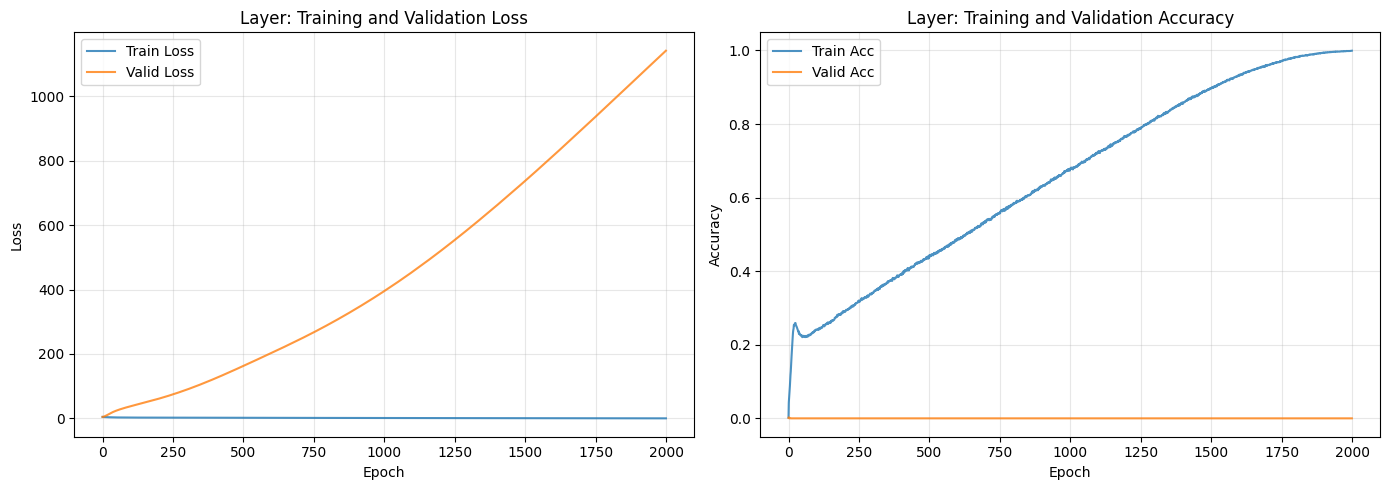

Saved Layer_training_results.png


In [4]:
bi_linear = init_model(ModelConfig)
bi_results = train_loop(bi_linear, loaders, TrainConfig)

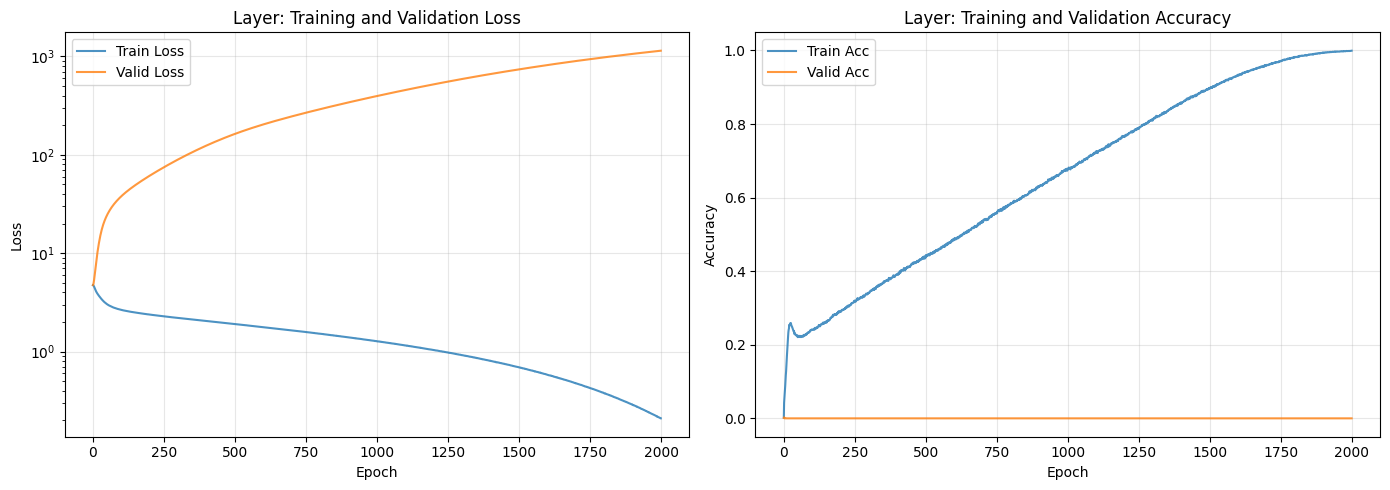

Saved Layer_training_results.png


In [5]:
plot_training_results(bi_results["train_losses"], bi_results["valid_losses"], bi_results["train_accs"], bi_results["valid_accs"], arc = "Layer", y_scale = "log")

In [6]:
# Plotting first few epochs
# plt.plot(range(len(results["valid_accs"][:10])), results["valid_accs"][:10])

# Sanity check n=1
test_point = 1337
pair = pairs[test_point, :]
label = labels[test_point]
one_hot = onehots[test_point, :]
print(f"{pair=}")
print(f"{(pair.sum().item() % DataConfig.P)=}")
print(f"{label=}")
print(f"{torch.argmax(bi_linear(one_hot))=}")

# Memorisation?
total_params = sum(p.numel() for p in bi_linear.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

pair=tensor([11, 94])
(pair.sum().item() % DataConfig.P)=105
label=tensor(105)
torch.argmax(bi_linear(one_hot))=tensor(1)
Total number of parameters: 51076


### Trainig bilinear layer with Projection


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s, train_loss=4.7280, train_acc=0.0036, valid_loss=4.7285, valid_acc=0.0004, best_valid=4.7285]

Training:   0%|          | 1/400 [00:00<01:11,  5.59it/s, train_loss=4.7280, train_acc=0.0036, valid_loss=4.7285, valid_acc=0.0004, best_valid=4.7285]

Training:   0%|          | 1/400 [00:00<01:11,  5.59it/s, train_loss=4.7251, train_acc=0.0615, valid_loss=4.7308, valid_acc=0.0008, best_valid=4.7285]

Training:   0%|          | 2/400 [00:00<01:10,  5.68it/s, train_loss=4.7251, train_acc=0.0615, valid_loss=4.7308, valid_acc=0.0008, best_valid=4.7285]

Training:   0%|          | 2/400 [00:00<01:10,  5.68it/s, train_loss=4.7153, train_acc=0.1438, valid_loss=4.7314, valid_acc=0.0047, best_valid=4.7285]

Training:   1%|          | 3/400 [00:00<01:07,  5.92it/s, train_loss=4.7153, train_acc=0.1438, valid_loss=4.7314, valid_acc=0.0047, best_valid=4.7285]

Training:   1%|          | 3/400 [00:00<01:07,  5.92it/s, train_loss=4.6281, train_acc=0.4663, valid_loss=4.6004, valid_acc=0.1437, best_valid=4.6004]

Training:   1%|          | 4/400 [00:00<01:05,  6.01it/s, train_loss=4.6281, train_acc=0.4663, valid_loss=4.6004, valid_acc=0.1437, best_valid=4.6004]

Training:   1%|          | 4/400 [00:00<01:05,  6.01it/s, train_loss=4.0001, train_acc=0.8992, valid_loss=3.5936, valid_acc=0.7724, best_valid=3.5936]

Training:   1%|▏         | 5/400 [00:00<01:06,  5.91it/s, train_loss=4.0001, train_acc=0.8992, valid_loss=3.5936, valid_acc=0.7724, best_valid=3.5936]

Training:   1%|▏         | 5/400 [00:01<01:06,  5.91it/s, train_loss=1.9321, train_acc=0.9949, valid_loss=1.1396, valid_acc=0.9930, best_valid=1.1396]

Training:   2%|▏         | 6/400 [00:01<01:05,  6.01it/s, train_loss=1.9321, train_acc=0.9949, valid_loss=1.1396, valid_acc=0.9930, best_valid=1.1396]

Training:   2%|▏         | 6/400 [00:01<01:05,  6.01it/s, train_loss=0.2508, train_acc=1.0000, valid_loss=0.2564, valid_acc=0.9996, best_valid=0.2564]

Training:   2%|▏         | 7/400 [00:01<01:06,  5.93it/s, train_loss=0.2508, train_acc=1.0000, valid_loss=0.2564, valid_acc=0.9996, best_valid=0.2564]

Training:   2%|▏         | 7/400 [00:01<01:06,  5.93it/s, train_loss=0.0525, train_acc=1.0000, valid_loss=0.1374, valid_acc=0.9996, best_valid=0.1374]

Training:   2%|▏         | 8/400 [00:01<01:10,  5.54it/s, train_loss=0.0525, train_acc=1.0000, valid_loss=0.1374, valid_acc=0.9996, best_valid=0.1374]

Training:   2%|▏         | 8/400 [00:01<01:10,  5.54it/s, train_loss=0.0275, train_acc=1.0000, valid_loss=0.0963, valid_acc=1.0000, best_valid=0.0963]

Training:   2%|▏         | 9/400 [00:01<01:10,  5.55it/s, train_loss=0.0275, train_acc=1.0000, valid_loss=0.0963, valid_acc=1.0000, best_valid=0.0963]

Training:   2%|▏         | 9/400 [00:01<01:10,  5.55it/s, train_loss=0.0181, train_acc=1.0000, valid_loss=0.0739, valid_acc=1.0000, best_valid=0.0739]

Training:   2%|▎         | 10/400 [00:01<01:23,  4.65it/s, train_loss=0.0181, train_acc=1.0000, valid_loss=0.0739, valid_acc=1.0000, best_valid=0.0739]

Training:   2%|▎         | 10/400 [00:02<01:23,  4.65it/s, train_loss=0.0132, train_acc=1.0000, valid_loss=0.0598, valid_acc=1.0000, best_valid=0.0598]

Training:   3%|▎         | 11/400 [00:02<01:18,  4.96it/s, train_loss=0.0132, train_acc=1.0000, valid_loss=0.0598, valid_acc=1.0000, best_valid=0.0598]

Training:   3%|▎         | 11/400 [00:02<01:18,  4.96it/s, train_loss=0.0102, train_acc=1.0000, valid_loss=0.0500, valid_acc=1.0000, best_valid=0.0500]

Training:   3%|▎         | 12/400 [00:02<01:17,  5.02it/s, train_loss=0.0102, train_acc=1.0000, valid_loss=0.0500, valid_acc=1.0000, best_valid=0.0500]

Training:   3%|▎         | 12/400 [00:02<01:17,  5.02it/s, train_loss=0.0081, train_acc=1.0000, valid_loss=0.0427, valid_acc=1.0000, best_valid=0.0427]

Training:   3%|▎         | 13/400 [00:02<01:16,  5.07it/s, train_loss=0.0081, train_acc=1.0000, valid_loss=0.0427, valid_acc=1.0000, best_valid=0.0427]

Training:   3%|▎         | 13/400 [00:02<01:16,  5.07it/s, train_loss=0.0067, train_acc=1.0000, valid_loss=0.0371, valid_acc=1.0000, best_valid=0.0371]

Training:   4%|▎         | 14/400 [00:02<01:14,  5.20it/s, train_loss=0.0067, train_acc=1.0000, valid_loss=0.0371, valid_acc=1.0000, best_valid=0.0371]

Training:   4%|▎         | 14/400 [00:02<01:14,  5.20it/s, train_loss=0.0056, train_acc=1.0000, valid_loss=0.0328, valid_acc=1.0000, best_valid=0.0328]

Training:   4%|▍         | 15/400 [00:02<01:14,  5.15it/s, train_loss=0.0056, train_acc=1.0000, valid_loss=0.0328, valid_acc=1.0000, best_valid=0.0328]

Training:   4%|▍         | 15/400 [00:03<01:14,  5.15it/s, train_loss=0.0048, train_acc=1.0000, valid_loss=0.0292, valid_acc=1.0000, best_valid=0.0292]

Training:   4%|▍         | 16/400 [00:03<01:17,  4.94it/s, train_loss=0.0048, train_acc=1.0000, valid_loss=0.0292, valid_acc=1.0000, best_valid=0.0292]

Training:   4%|▍         | 16/400 [00:03<01:17,  4.94it/s, train_loss=0.0041, train_acc=1.0000, valid_loss=0.0263, valid_acc=1.0000, best_valid=0.0263]

Training:   4%|▍         | 17/400 [00:03<01:15,  5.05it/s, train_loss=0.0041, train_acc=1.0000, valid_loss=0.0263, valid_acc=1.0000, best_valid=0.0263]

Training:   4%|▍         | 17/400 [00:03<01:15,  5.05it/s, train_loss=0.0036, train_acc=1.0000, valid_loss=0.0239, valid_acc=1.0000, best_valid=0.0239]

Training:   4%|▍         | 18/400 [00:03<01:15,  5.06it/s, train_loss=0.0036, train_acc=1.0000, valid_loss=0.0239, valid_acc=1.0000, best_valid=0.0239]

Training:   4%|▍         | 18/400 [00:03<01:15,  5.06it/s, train_loss=0.0032, train_acc=1.0000, valid_loss=0.0218, valid_acc=1.0000, best_valid=0.0218]

Training:   5%|▍         | 19/400 [00:03<01:17,  4.92it/s, train_loss=0.0032, train_acc=1.0000, valid_loss=0.0218, valid_acc=1.0000, best_valid=0.0218]

Training:   5%|▍         | 19/400 [00:03<01:17,  4.92it/s, train_loss=0.0029, train_acc=1.0000, valid_loss=0.0200, valid_acc=1.0000, best_valid=0.0200]

Training:   5%|▌         | 20/400 [00:03<01:17,  4.91it/s, train_loss=0.0029, train_acc=1.0000, valid_loss=0.0200, valid_acc=1.0000, best_valid=0.0200]

Training:   5%|▌         | 20/400 [00:04<01:17,  4.91it/s, train_loss=0.0026, train_acc=1.0000, valid_loss=0.0185, valid_acc=1.0000, best_valid=0.0185]

Training:   5%|▌         | 21/400 [00:04<01:18,  4.84it/s, train_loss=0.0026, train_acc=1.0000, valid_loss=0.0185, valid_acc=1.0000, best_valid=0.0185]

Training:   5%|▌         | 21/400 [00:04<01:18,  4.84it/s, train_loss=0.0023, train_acc=1.0000, valid_loss=0.0171, valid_acc=1.0000, best_valid=0.0171]

Training:   6%|▌         | 22/400 [00:04<01:20,  4.67it/s, train_loss=0.0023, train_acc=1.0000, valid_loss=0.0171, valid_acc=1.0000, best_valid=0.0171]

Training:   6%|▌         | 22/400 [00:04<01:20,  4.67it/s, train_loss=0.0021, train_acc=1.0000, valid_loss=0.0159, valid_acc=1.0000, best_valid=0.0159]

Training:   6%|▌         | 23/400 [00:04<01:17,  4.85it/s, train_loss=0.0021, train_acc=1.0000, valid_loss=0.0159, valid_acc=1.0000, best_valid=0.0159]

Training:   6%|▌         | 23/400 [00:04<01:17,  4.85it/s, train_loss=0.0019, train_acc=1.0000, valid_loss=0.0149, valid_acc=1.0000, best_valid=0.0149]

Training:   6%|▌         | 24/400 [00:04<01:13,  5.10it/s, train_loss=0.0019, train_acc=1.0000, valid_loss=0.0149, valid_acc=1.0000, best_valid=0.0149]

Training:   6%|▌         | 24/400 [00:04<01:13,  5.10it/s, train_loss=0.0017, train_acc=1.0000, valid_loss=0.0139, valid_acc=1.0000, best_valid=0.0139]

Training:   6%|▋         | 25/400 [00:04<01:11,  5.28it/s, train_loss=0.0017, train_acc=1.0000, valid_loss=0.0139, valid_acc=1.0000, best_valid=0.0139]

Training:   6%|▋         | 25/400 [00:05<01:11,  5.28it/s, train_loss=0.0016, train_acc=1.0000, valid_loss=0.0131, valid_acc=1.0000, best_valid=0.0131]

Training:   6%|▋         | 26/400 [00:05<01:13,  5.10it/s, train_loss=0.0016, train_acc=1.0000, valid_loss=0.0131, valid_acc=1.0000, best_valid=0.0131]

Training:   6%|▋         | 26/400 [00:05<01:13,  5.10it/s, train_loss=0.0015, train_acc=1.0000, valid_loss=0.0123, valid_acc=1.0000, best_valid=0.0123]

Training:   7%|▋         | 27/400 [00:05<01:13,  5.04it/s, train_loss=0.0015, train_acc=1.0000, valid_loss=0.0123, valid_acc=1.0000, best_valid=0.0123]

Training:   7%|▋         | 27/400 [00:05<01:13,  5.04it/s, train_loss=0.0014, train_acc=1.0000, valid_loss=0.0116, valid_acc=1.0000, best_valid=0.0116]

Training:   7%|▋         | 28/400 [00:05<01:12,  5.14it/s, train_loss=0.0014, train_acc=1.0000, valid_loss=0.0116, valid_acc=1.0000, best_valid=0.0116]

Training:   7%|▋         | 28/400 [00:05<01:12,  5.14it/s, train_loss=0.0013, train_acc=1.0000, valid_loss=0.0110, valid_acc=1.0000, best_valid=0.0110]

Training:   7%|▋         | 29/400 [00:05<01:12,  5.10it/s, train_loss=0.0013, train_acc=1.0000, valid_loss=0.0110, valid_acc=1.0000, best_valid=0.0110]

Training:   7%|▋         | 29/400 [00:05<01:12,  5.10it/s, train_loss=0.0012, train_acc=1.0000, valid_loss=0.0104, valid_acc=1.0000, best_valid=0.0104]

Training:   8%|▊         | 30/400 [00:05<01:09,  5.29it/s, train_loss=0.0012, train_acc=1.0000, valid_loss=0.0104, valid_acc=1.0000, best_valid=0.0104]

Training:   8%|▊         | 30/400 [00:05<01:09,  5.29it/s, train_loss=0.0011, train_acc=1.0000, valid_loss=0.0099, valid_acc=1.0000, best_valid=0.0099]

Training:   8%|▊         | 31/400 [00:05<01:08,  5.37it/s, train_loss=0.0011, train_acc=1.0000, valid_loss=0.0099, valid_acc=1.0000, best_valid=0.0099]

Training:   8%|▊         | 31/400 [00:06<01:08,  5.37it/s, train_loss=0.0010, train_acc=1.0000, valid_loss=0.0094, valid_acc=1.0000, best_valid=0.0094]

Training:   8%|▊         | 32/400 [00:06<01:09,  5.33it/s, train_loss=0.0010, train_acc=1.0000, valid_loss=0.0094, valid_acc=1.0000, best_valid=0.0094]

Training:   8%|▊         | 32/400 [00:06<01:09,  5.33it/s, train_loss=0.0010, train_acc=1.0000, valid_loss=0.0089, valid_acc=1.0000, best_valid=0.0089]

Training:   8%|▊         | 33/400 [00:06<01:09,  5.30it/s, train_loss=0.0010, train_acc=1.0000, valid_loss=0.0089, valid_acc=1.0000, best_valid=0.0089]

Training:   8%|▊         | 33/400 [00:06<01:09,  5.30it/s, train_loss=0.0009, train_acc=1.0000, valid_loss=0.0085, valid_acc=1.0000, best_valid=0.0085]

Training:   8%|▊         | 34/400 [00:06<01:10,  5.19it/s, train_loss=0.0009, train_acc=1.0000, valid_loss=0.0085, valid_acc=1.0000, best_valid=0.0085]

Training:   8%|▊         | 34/400 [00:06<01:10,  5.19it/s, train_loss=0.0008, train_acc=1.0000, valid_loss=0.0081, valid_acc=1.0000, best_valid=0.0081]

Training:   9%|▉         | 35/400 [00:06<01:10,  5.20it/s, train_loss=0.0008, train_acc=1.0000, valid_loss=0.0081, valid_acc=1.0000, best_valid=0.0081]

Training:   9%|▉         | 35/400 [00:06<01:10,  5.20it/s, train_loss=0.0008, train_acc=1.0000, valid_loss=0.0078, valid_acc=1.0000, best_valid=0.0078]

Training:   9%|▉         | 36/400 [00:06<01:08,  5.32it/s, train_loss=0.0008, train_acc=1.0000, valid_loss=0.0078, valid_acc=1.0000, best_valid=0.0078]

Training:   9%|▉         | 36/400 [00:07<01:08,  5.32it/s, train_loss=0.0007, train_acc=1.0000, valid_loss=0.0074, valid_acc=1.0000, best_valid=0.0074]

Training:   9%|▉         | 37/400 [00:07<01:08,  5.34it/s, train_loss=0.0007, train_acc=1.0000, valid_loss=0.0074, valid_acc=1.0000, best_valid=0.0074]

Training:   9%|▉         | 37/400 [00:07<01:08,  5.34it/s, train_loss=0.0007, train_acc=1.0000, valid_loss=0.0071, valid_acc=1.0000, best_valid=0.0071]

Training:  10%|▉         | 38/400 [00:07<01:21,  4.43it/s, train_loss=0.0007, train_acc=1.0000, valid_loss=0.0071, valid_acc=1.0000, best_valid=0.0071]

Training:  10%|▉         | 38/400 [00:07<01:21,  4.43it/s, train_loss=0.0007, train_acc=1.0000, valid_loss=0.0068, valid_acc=1.0000, best_valid=0.0068]

Training:  10%|▉         | 39/400 [00:07<01:18,  4.60it/s, train_loss=0.0007, train_acc=1.0000, valid_loss=0.0068, valid_acc=1.0000, best_valid=0.0068]

Training:  10%|▉         | 39/400 [00:07<01:18,  4.60it/s, train_loss=0.0006, train_acc=1.0000, valid_loss=0.0066, valid_acc=1.0000, best_valid=0.0066]

Training:  10%|█         | 40/400 [00:07<01:16,  4.72it/s, train_loss=0.0006, train_acc=1.0000, valid_loss=0.0066, valid_acc=1.0000, best_valid=0.0066]

Training:  10%|█         | 40/400 [00:08<01:16,  4.72it/s, train_loss=0.0006, train_acc=1.0000, valid_loss=0.0063, valid_acc=1.0000, best_valid=0.0063]

Training:  10%|█         | 41/400 [00:08<01:15,  4.76it/s, train_loss=0.0006, train_acc=1.0000, valid_loss=0.0063, valid_acc=1.0000, best_valid=0.0063]

Training:  10%|█         | 41/400 [00:08<01:15,  4.76it/s, train_loss=0.0006, train_acc=1.0000, valid_loss=0.0061, valid_acc=1.0000, best_valid=0.0061]

Training:  10%|█         | 42/400 [00:08<01:12,  4.95it/s, train_loss=0.0006, train_acc=1.0000, valid_loss=0.0061, valid_acc=1.0000, best_valid=0.0061]

Training:  10%|█         | 42/400 [00:08<01:12,  4.95it/s, train_loss=0.0005, train_acc=1.0000, valid_loss=0.0058, valid_acc=1.0000, best_valid=0.0058]

Training:  11%|█         | 43/400 [00:08<01:09,  5.14it/s, train_loss=0.0005, train_acc=1.0000, valid_loss=0.0058, valid_acc=1.0000, best_valid=0.0058]

Training:  11%|█         | 43/400 [00:08<01:09,  5.14it/s, train_loss=0.0005, train_acc=1.0000, valid_loss=0.0056, valid_acc=1.0000, best_valid=0.0056]

Training:  11%|█         | 44/400 [00:08<01:08,  5.20it/s, train_loss=0.0005, train_acc=1.0000, valid_loss=0.0056, valid_acc=1.0000, best_valid=0.0056]

Training:  11%|█         | 44/400 [00:08<01:08,  5.20it/s, train_loss=0.0005, train_acc=1.0000, valid_loss=0.0054, valid_acc=1.0000, best_valid=0.0054]

Training:  11%|█▏        | 45/400 [00:08<01:10,  5.07it/s, train_loss=0.0005, train_acc=1.0000, valid_loss=0.0054, valid_acc=1.0000, best_valid=0.0054]

Training:  11%|█▏        | 45/400 [00:08<01:10,  5.07it/s, train_loss=0.0005, train_acc=1.0000, valid_loss=0.0052, valid_acc=1.0000, best_valid=0.0052]

Training:  12%|█▏        | 46/400 [00:08<01:11,  4.92it/s, train_loss=0.0005, train_acc=1.0000, valid_loss=0.0052, valid_acc=1.0000, best_valid=0.0052]

Training:  12%|█▏        | 46/400 [00:09<01:11,  4.92it/s, train_loss=0.0004, train_acc=1.0000, valid_loss=0.0051, valid_acc=1.0000, best_valid=0.0051]

Training:  12%|█▏        | 47/400 [00:09<01:10,  5.01it/s, train_loss=0.0004, train_acc=1.0000, valid_loss=0.0051, valid_acc=1.0000, best_valid=0.0051]

Training:  12%|█▏        | 47/400 [00:09<01:10,  5.01it/s, train_loss=0.0004, train_acc=1.0000, valid_loss=0.0049, valid_acc=1.0000, best_valid=0.0049]

Training:  12%|█▏        | 48/400 [00:09<01:08,  5.16it/s, train_loss=0.0004, train_acc=1.0000, valid_loss=0.0049, valid_acc=1.0000, best_valid=0.0049]

Training:  12%|█▏        | 48/400 [00:09<01:08,  5.16it/s, train_loss=0.0004, train_acc=1.0000, valid_loss=0.0047, valid_acc=1.0000, best_valid=0.0047]

Training:  12%|█▏        | 49/400 [00:09<01:06,  5.28it/s, train_loss=0.0004, train_acc=1.0000, valid_loss=0.0047, valid_acc=1.0000, best_valid=0.0047]

Training:  12%|█▏        | 49/400 [00:09<01:06,  5.28it/s, train_loss=0.0004, train_acc=1.0000, valid_loss=0.0046, valid_acc=1.0000, best_valid=0.0046]

Training:  12%|█▎        | 50/400 [00:09<01:04,  5.43it/s, train_loss=0.0004, train_acc=1.0000, valid_loss=0.0046, valid_acc=1.0000, best_valid=0.0046]

Training:  12%|█▎        | 50/400 [00:09<01:04,  5.43it/s, train_loss=0.0004, train_acc=1.0000, valid_loss=0.0044, valid_acc=1.0000, best_valid=0.0044]

Training:  13%|█▎        | 51/400 [00:09<01:04,  5.40it/s, train_loss=0.0004, train_acc=1.0000, valid_loss=0.0044, valid_acc=1.0000, best_valid=0.0044]

Training:  13%|█▎        | 51/400 [00:10<01:04,  5.40it/s, train_loss=0.0004, train_acc=1.0000, valid_loss=0.0043, valid_acc=1.0000, best_valid=0.0043]

Training:  13%|█▎        | 52/400 [00:10<01:04,  5.41it/s, train_loss=0.0004, train_acc=1.0000, valid_loss=0.0043, valid_acc=1.0000, best_valid=0.0043]

Training:  13%|█▎        | 52/400 [00:10<01:04,  5.41it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0041, valid_acc=1.0000, best_valid=0.0041]

Training:  13%|█▎        | 53/400 [00:10<01:04,  5.35it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0041, valid_acc=1.0000, best_valid=0.0041]

Training:  13%|█▎        | 53/400 [00:10<01:04,  5.35it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0040, valid_acc=1.0000, best_valid=0.0040]

Training:  14%|█▎        | 54/400 [00:10<01:04,  5.33it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0040, valid_acc=1.0000, best_valid=0.0040]

Training:  14%|█▎        | 54/400 [00:10<01:04,  5.33it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0039, valid_acc=1.0000, best_valid=0.0039]

Training:  14%|█▍        | 55/400 [00:10<01:05,  5.30it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0039, valid_acc=1.0000, best_valid=0.0039]

Training:  14%|█▍        | 55/400 [00:10<01:05,  5.30it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0038, valid_acc=1.0000, best_valid=0.0038]

Training:  14%|█▍        | 56/400 [00:10<01:04,  5.30it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0038, valid_acc=1.0000, best_valid=0.0038]

Training:  14%|█▍        | 56/400 [00:11<01:04,  5.30it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0037, valid_acc=1.0000, best_valid=0.0037]

Training:  14%|█▍        | 57/400 [00:11<01:04,  5.31it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0037, valid_acc=1.0000, best_valid=0.0037]

Training:  14%|█▍        | 57/400 [00:11<01:04,  5.31it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0036, valid_acc=1.0000, best_valid=0.0036]

Training:  14%|█▍        | 58/400 [00:11<01:03,  5.35it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0036, valid_acc=1.0000, best_valid=0.0036]

Training:  14%|█▍        | 58/400 [00:11<01:03,  5.35it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0035, valid_acc=1.0000, best_valid=0.0035]

Training:  15%|█▍        | 59/400 [00:11<01:03,  5.40it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0035, valid_acc=1.0000, best_valid=0.0035]

Training:  15%|█▍        | 59/400 [00:11<01:03,  5.40it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0034, valid_acc=1.0000, best_valid=0.0034]

Training:  15%|█▌        | 60/400 [00:11<01:03,  5.38it/s, train_loss=0.0003, train_acc=1.0000, valid_loss=0.0034, valid_acc=1.0000, best_valid=0.0034]

Training:  15%|█▌        | 60/400 [00:11<01:03,  5.38it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0033, valid_acc=1.0000, best_valid=0.0033]

Training:  15%|█▌        | 61/400 [00:11<01:05,  5.18it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0033, valid_acc=1.0000, best_valid=0.0033]

Training:  15%|█▌        | 61/400 [00:12<01:05,  5.18it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0032, valid_acc=1.0000, best_valid=0.0032]

Training:  16%|█▌        | 62/400 [00:12<01:06,  5.06it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0032, valid_acc=1.0000, best_valid=0.0032]

Training:  16%|█▌        | 62/400 [00:12<01:06,  5.06it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0031, valid_acc=1.0000, best_valid=0.0031]

Training:  16%|█▌        | 63/400 [00:12<01:04,  5.21it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0031, valid_acc=1.0000, best_valid=0.0031]

Training:  16%|█▌        | 63/400 [00:12<01:04,  5.21it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0030, valid_acc=1.0000, best_valid=0.0030]

Training:  16%|█▌        | 64/400 [00:12<01:04,  5.19it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0030, valid_acc=1.0000, best_valid=0.0030]

Training:  16%|█▌        | 64/400 [00:12<01:04,  5.19it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0029, valid_acc=1.0000, best_valid=0.0029]

Training:  16%|█▋        | 65/400 [00:12<01:04,  5.17it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0029, valid_acc=1.0000, best_valid=0.0029]

Training:  16%|█▋        | 65/400 [00:12<01:04,  5.17it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0028, valid_acc=1.0000, best_valid=0.0028]

Training:  16%|█▋        | 66/400 [00:12<01:04,  5.14it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0028, valid_acc=1.0000, best_valid=0.0028]

Training:  16%|█▋        | 66/400 [00:13<01:04,  5.14it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0028, valid_acc=1.0000, best_valid=0.0028]

Training:  17%|█▋        | 67/400 [00:13<01:13,  4.50it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0028, valid_acc=1.0000, best_valid=0.0028]

Training:  17%|█▋        | 67/400 [00:13<01:13,  4.50it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0027, valid_acc=1.0000, best_valid=0.0027]

Training:  17%|█▋        | 68/400 [00:13<01:09,  4.75it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0027, valid_acc=1.0000, best_valid=0.0027]

Training:  17%|█▋        | 68/400 [00:13<01:09,  4.75it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0026, valid_acc=1.0000, best_valid=0.0026]

Training:  17%|█▋        | 69/400 [00:13<01:09,  4.77it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0026, valid_acc=1.0000, best_valid=0.0026]

Training:  17%|█▋        | 69/400 [00:13<01:09,  4.77it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0026, valid_acc=1.0000, best_valid=0.0026]

Training:  18%|█▊        | 70/400 [00:13<01:09,  4.74it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0026, valid_acc=1.0000, best_valid=0.0026]

Training:  18%|█▊        | 70/400 [00:13<01:09,  4.74it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0025, valid_acc=1.0000, best_valid=0.0025]

Training:  18%|█▊        | 71/400 [00:13<01:07,  4.89it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0025, valid_acc=1.0000, best_valid=0.0025]

Training:  18%|█▊        | 71/400 [00:14<01:07,  4.89it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0024, valid_acc=1.0000, best_valid=0.0024]

Training:  18%|█▊        | 72/400 [00:14<01:03,  5.13it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0024, valid_acc=1.0000, best_valid=0.0024]

Training:  18%|█▊        | 72/400 [00:14<01:03,  5.13it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0024, valid_acc=1.0000, best_valid=0.0024]

Training:  18%|█▊        | 73/400 [00:14<01:05,  5.02it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0024, valid_acc=1.0000, best_valid=0.0024]

Training:  18%|█▊        | 73/400 [00:14<01:05,  5.02it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0023, valid_acc=1.0000, best_valid=0.0023]

Training:  18%|█▊        | 74/400 [00:14<01:02,  5.21it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0023, valid_acc=1.0000, best_valid=0.0023]

Training:  18%|█▊        | 74/400 [00:14<01:02,  5.21it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0023, valid_acc=1.0000, best_valid=0.0023]

Training:  19%|█▉        | 75/400 [00:14<01:02,  5.23it/s, train_loss=0.0002, train_acc=1.0000, valid_loss=0.0023, valid_acc=1.0000, best_valid=0.0023]

Training:  19%|█▉        | 75/400 [00:14<01:02,  5.23it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0022, valid_acc=1.0000, best_valid=0.0022]

Training:  19%|█▉        | 76/400 [00:14<01:01,  5.23it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0022, valid_acc=1.0000, best_valid=0.0022]

Training:  19%|█▉        | 76/400 [00:14<01:01,  5.23it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0022, valid_acc=1.0000, best_valid=0.0022]

Training:  19%|█▉        | 77/400 [00:14<01:01,  5.29it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0022, valid_acc=1.0000, best_valid=0.0022]

Training:  19%|█▉        | 77/400 [00:15<01:01,  5.29it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0021, valid_acc=1.0000, best_valid=0.0021]

Training:  20%|█▉        | 78/400 [00:15<01:02,  5.16it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0021, valid_acc=1.0000, best_valid=0.0021]

Training:  20%|█▉        | 78/400 [00:15<01:02,  5.16it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0021, valid_acc=1.0000, best_valid=0.0021]

Training:  20%|█▉        | 79/400 [00:15<01:01,  5.25it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0021, valid_acc=1.0000, best_valid=0.0021]

Training:  20%|█▉        | 79/400 [00:15<01:01,  5.25it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0020, valid_acc=1.0000, best_valid=0.0020]

Training:  20%|██        | 80/400 [00:15<01:02,  5.13it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0020, valid_acc=1.0000, best_valid=0.0020]

Training:  20%|██        | 80/400 [00:15<01:02,  5.13it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0020, valid_acc=1.0000, best_valid=0.0020]

Training:  20%|██        | 81/400 [00:15<01:07,  4.73it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0020, valid_acc=1.0000, best_valid=0.0020]

Training:  20%|██        | 81/400 [00:16<01:07,  4.73it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0019, valid_acc=1.0000, best_valid=0.0019]

Training:  20%|██        | 82/400 [00:16<01:09,  4.60it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0019, valid_acc=1.0000, best_valid=0.0019]

Training:  20%|██        | 82/400 [00:16<01:09,  4.60it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0019, valid_acc=1.0000, best_valid=0.0019]

Training:  21%|██        | 83/400 [00:16<01:10,  4.51it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0019, valid_acc=1.0000, best_valid=0.0019]

Training:  21%|██        | 83/400 [00:16<01:10,  4.51it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0018, valid_acc=1.0000, best_valid=0.0018]

Training:  21%|██        | 84/400 [00:16<01:07,  4.66it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0018, valid_acc=1.0000, best_valid=0.0018]

Training:  21%|██        | 84/400 [00:16<01:07,  4.66it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0018, valid_acc=1.0000, best_valid=0.0018]

Training:  21%|██▏       | 85/400 [00:16<01:06,  4.75it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0018, valid_acc=1.0000, best_valid=0.0018]

Training:  21%|██▏       | 85/400 [00:16<01:06,  4.75it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0017, valid_acc=1.0000, best_valid=0.0017]

Training:  22%|██▏       | 86/400 [00:16<01:05,  4.76it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0017, valid_acc=1.0000, best_valid=0.0017]

Training:  22%|██▏       | 86/400 [00:17<01:05,  4.76it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0017, valid_acc=1.0000, best_valid=0.0017]

Training:  22%|██▏       | 87/400 [00:17<01:04,  4.86it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0017, valid_acc=1.0000, best_valid=0.0017]

Training:  22%|██▏       | 87/400 [00:17<01:04,  4.86it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0017, valid_acc=1.0000, best_valid=0.0017]

Training:  22%|██▏       | 88/400 [00:17<01:03,  4.93it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0017, valid_acc=1.0000, best_valid=0.0017]

Training:  22%|██▏       | 88/400 [00:17<01:03,  4.93it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0016, valid_acc=1.0000, best_valid=0.0016]

Training:  22%|██▏       | 89/400 [00:17<01:03,  4.91it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0016, valid_acc=1.0000, best_valid=0.0016]

Training:  22%|██▏       | 89/400 [00:17<01:03,  4.91it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0016, valid_acc=1.0000, best_valid=0.0016]

Training:  22%|██▎       | 90/400 [00:17<01:00,  5.09it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0016, valid_acc=1.0000, best_valid=0.0016]

Training:  22%|██▎       | 90/400 [00:17<01:00,  5.09it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0016, valid_acc=1.0000, best_valid=0.0016]

Training:  23%|██▎       | 91/400 [00:17<01:00,  5.15it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0016, valid_acc=1.0000, best_valid=0.0016]

Training:  23%|██▎       | 91/400 [00:18<01:00,  5.15it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0015, valid_acc=1.0000, best_valid=0.0015]

Training:  23%|██▎       | 92/400 [00:18<00:58,  5.27it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0015, valid_acc=1.0000, best_valid=0.0015]

Training:  23%|██▎       | 92/400 [00:18<00:58,  5.27it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0015, valid_acc=1.0000, best_valid=0.0015]

Training:  23%|██▎       | 93/400 [00:18<00:58,  5.26it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0015, valid_acc=1.0000, best_valid=0.0015]

Training:  23%|██▎       | 93/400 [00:18<00:58,  5.26it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0015, valid_acc=1.0000, best_valid=0.0015]

Training:  24%|██▎       | 94/400 [00:18<00:59,  5.11it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0015, valid_acc=1.0000, best_valid=0.0015]

Training:  24%|██▎       | 94/400 [00:18<00:59,  5.11it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0014, valid_acc=1.0000, best_valid=0.0014]

Training:  24%|██▍       | 95/400 [00:18<01:01,  4.99it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0014, valid_acc=1.0000, best_valid=0.0014]

Training:  24%|██▍       | 95/400 [00:18<01:01,  4.99it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0014, valid_acc=1.0000, best_valid=0.0014]

Training:  24%|██▍       | 96/400 [00:18<01:09,  4.38it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0014, valid_acc=1.0000, best_valid=0.0014]

Training:  24%|██▍       | 96/400 [00:19<01:09,  4.38it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0014, valid_acc=1.0000, best_valid=0.0014]

Training:  24%|██▍       | 97/400 [00:19<01:05,  4.60it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0014, valid_acc=1.0000, best_valid=0.0014]

Training:  24%|██▍       | 97/400 [00:19<01:05,  4.60it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0013, valid_acc=1.0000, best_valid=0.0013]

Training:  24%|██▍       | 98/400 [00:19<01:03,  4.79it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0013, valid_acc=1.0000, best_valid=0.0013]

Training:  24%|██▍       | 98/400 [00:19<01:03,  4.79it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0013, valid_acc=1.0000, best_valid=0.0013]

Training:  25%|██▍       | 99/400 [00:19<01:00,  4.94it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0013, valid_acc=1.0000, best_valid=0.0013]

Training:  25%|██▍       | 99/400 [00:19<01:00,  4.94it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0013, valid_acc=1.0000, best_valid=0.0013]

Training:  25%|██▌       | 100/400 [00:19<01:01,  4.84it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0013, valid_acc=1.0000, best_valid=0.0013]

Training:  25%|██▌       | 100/400 [00:19<01:01,  4.84it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0013, valid_acc=1.0000, best_valid=0.0013]

Training:  25%|██▌       | 101/400 [00:19<01:01,  4.87it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0013, valid_acc=1.0000, best_valid=0.0013]

Training:  25%|██▌       | 101/400 [00:20<01:01,  4.87it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0012, valid_acc=1.0000, best_valid=0.0012]

Training:  26%|██▌       | 102/400 [00:20<01:01,  4.88it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0012, valid_acc=1.0000, best_valid=0.0012]

Training:  26%|██▌       | 102/400 [00:20<01:01,  4.88it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0012, valid_acc=1.0000, best_valid=0.0012]

Training:  26%|██▌       | 103/400 [00:20<01:01,  4.85it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0012, valid_acc=1.0000, best_valid=0.0012]

Training:  26%|██▌       | 103/400 [00:20<01:01,  4.85it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0012, valid_acc=1.0000, best_valid=0.0012]

Training:  26%|██▌       | 104/400 [00:20<00:59,  4.97it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0012, valid_acc=1.0000, best_valid=0.0012]

Training:  26%|██▌       | 104/400 [00:20<00:59,  4.97it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0012, valid_acc=1.0000, best_valid=0.0012]

Training:  26%|██▋       | 105/400 [00:20<00:58,  5.06it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0012, valid_acc=1.0000, best_valid=0.0012]

Training:  26%|██▋       | 105/400 [00:20<00:58,  5.06it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0011, valid_acc=1.0000, best_valid=0.0011]

Training:  26%|██▋       | 106/400 [00:20<00:56,  5.24it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0011, valid_acc=1.0000, best_valid=0.0011]

Training:  26%|██▋       | 106/400 [00:21<00:56,  5.24it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0011, valid_acc=1.0000, best_valid=0.0011]

Training:  27%|██▋       | 107/400 [00:21<00:56,  5.19it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0011, valid_acc=1.0000, best_valid=0.0011]

Training:  27%|██▋       | 107/400 [00:21<00:56,  5.19it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0011, valid_acc=1.0000, best_valid=0.0011]

Training:  27%|██▋       | 108/400 [00:21<00:56,  5.16it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0011, valid_acc=1.0000, best_valid=0.0011]

Training:  27%|██▋       | 108/400 [00:21<00:56,  5.16it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0011, valid_acc=1.0000, best_valid=0.0011]

Training:  27%|██▋       | 109/400 [00:21<00:56,  5.19it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0011, valid_acc=1.0000, best_valid=0.0011]

Training:  27%|██▋       | 109/400 [00:21<00:56,  5.19it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0011, valid_acc=1.0000, best_valid=0.0011]

Training:  28%|██▊       | 110/400 [00:21<00:55,  5.26it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0011, valid_acc=1.0000, best_valid=0.0011]

Training:  28%|██▊       | 110/400 [00:21<00:55,  5.26it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0010, valid_acc=1.0000, best_valid=0.0010]

Training:  28%|██▊       | 111/400 [00:21<00:56,  5.11it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0010, valid_acc=1.0000, best_valid=0.0010]

Training:  28%|██▊       | 111/400 [00:22<00:56,  5.11it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0010, valid_acc=1.0000, best_valid=0.0010]

Training:  28%|██▊       | 112/400 [00:22<00:57,  5.03it/s, train_loss=0.0001, train_acc=1.0000, valid_loss=0.0010, valid_acc=1.0000, best_valid=0.0010]

Training:  28%|██▊       | 112/400 [00:22<00:57,  5.03it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0010, valid_acc=1.0000, best_valid=0.0010]

Training:  28%|██▊       | 113/400 [00:22<00:56,  5.10it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0010, valid_acc=1.0000, best_valid=0.0010]

Training:  28%|██▊       | 113/400 [00:22<00:56,  5.10it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0010, valid_acc=1.0000, best_valid=0.0010]

Training:  28%|██▊       | 114/400 [00:22<00:55,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0010, valid_acc=1.0000, best_valid=0.0010]

Training:  28%|██▊       | 114/400 [00:22<00:55,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0010, valid_acc=1.0000, best_valid=0.0010]

Training:  29%|██▉       | 115/400 [00:22<00:55,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0010, valid_acc=1.0000, best_valid=0.0010]

Training:  29%|██▉       | 115/400 [00:22<00:55,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0009, valid_acc=1.0000, best_valid=0.0009]

Training:  29%|██▉       | 116/400 [00:22<00:54,  5.20it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0009, valid_acc=1.0000, best_valid=0.0009]

Training:  29%|██▉       | 116/400 [00:23<00:54,  5.20it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0009, valid_acc=1.0000, best_valid=0.0009]

Training:  29%|██▉       | 117/400 [00:23<00:53,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0009, valid_acc=1.0000, best_valid=0.0009]

Training:  29%|██▉       | 117/400 [00:23<00:53,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0009, valid_acc=1.0000, best_valid=0.0009]

Training:  30%|██▉       | 118/400 [00:23<00:52,  5.38it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0009, valid_acc=1.0000, best_valid=0.0009]

Training:  30%|██▉       | 118/400 [00:23<00:52,  5.38it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0009, valid_acc=1.0000, best_valid=0.0009]

Training:  30%|██▉       | 119/400 [00:23<00:54,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0009, valid_acc=1.0000, best_valid=0.0009]

Training:  30%|██▉       | 119/400 [00:23<00:54,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0009, valid_acc=1.0000, best_valid=0.0009]

Training:  30%|███       | 120/400 [00:23<00:53,  5.24it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0009, valid_acc=1.0000, best_valid=0.0009]

Training:  30%|███       | 120/400 [00:23<00:53,  5.24it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0009, valid_acc=1.0000, best_valid=0.0009]

Training:  30%|███       | 121/400 [00:23<00:52,  5.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0009, valid_acc=1.0000, best_valid=0.0009]

Training:  30%|███       | 121/400 [00:23<00:52,  5.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  30%|███       | 122/400 [00:23<00:52,  5.31it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  30%|███       | 122/400 [00:24<00:52,  5.31it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  31%|███       | 123/400 [00:24<00:51,  5.42it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  31%|███       | 123/400 [00:24<00:51,  5.42it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  31%|███       | 124/400 [00:24<01:00,  4.55it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  31%|███       | 124/400 [00:24<01:00,  4.55it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  31%|███▏      | 125/400 [00:24<00:56,  4.88it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  31%|███▏      | 125/400 [00:24<00:56,  4.88it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  32%|███▏      | 126/400 [00:24<00:55,  4.95it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  32%|███▏      | 126/400 [00:25<00:55,  4.95it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  32%|███▏      | 127/400 [00:25<00:55,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  32%|███▏      | 127/400 [00:25<00:55,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  32%|███▏      | 128/400 [00:25<00:55,  4.92it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0008, valid_acc=1.0000, best_valid=0.0008]

Training:  32%|███▏      | 128/400 [00:25<00:55,  4.92it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  32%|███▏      | 129/400 [00:25<00:55,  4.88it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  32%|███▏      | 129/400 [00:25<00:55,  4.88it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  32%|███▎      | 130/400 [00:25<00:53,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  32%|███▎      | 130/400 [00:25<00:53,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  33%|███▎      | 131/400 [00:25<00:51,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  33%|███▎      | 131/400 [00:25<00:51,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  33%|███▎      | 132/400 [00:25<00:51,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  33%|███▎      | 132/400 [00:26<00:51,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  33%|███▎      | 133/400 [00:26<00:51,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  33%|███▎      | 133/400 [00:26<00:51,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  34%|███▎      | 134/400 [00:26<00:51,  5.12it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  34%|███▎      | 134/400 [00:26<00:51,  5.12it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  34%|███▍      | 135/400 [00:26<00:51,  5.19it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  34%|███▍      | 135/400 [00:26<00:51,  5.19it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  34%|███▍      | 136/400 [00:26<00:50,  5.26it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0007, valid_acc=1.0000, best_valid=0.0007]

Training:  34%|███▍      | 136/400 [00:26<00:50,  5.26it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  34%|███▍      | 137/400 [00:26<00:49,  5.31it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  34%|███▍      | 137/400 [00:27<00:49,  5.31it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  34%|███▍      | 138/400 [00:27<00:49,  5.34it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  34%|███▍      | 138/400 [00:27<00:49,  5.34it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  35%|███▍      | 139/400 [00:27<00:50,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  35%|███▍      | 139/400 [00:27<00:50,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  35%|███▌      | 140/400 [00:27<00:49,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  35%|███▌      | 140/400 [00:27<00:49,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  35%|███▌      | 141/400 [00:27<00:48,  5.33it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  35%|███▌      | 141/400 [00:27<00:48,  5.33it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  36%|███▌      | 142/400 [00:27<00:48,  5.33it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  36%|███▌      | 142/400 [00:28<00:48,  5.33it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  36%|███▌      | 143/400 [00:28<00:49,  5.22it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  36%|███▌      | 143/400 [00:28<00:49,  5.22it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  36%|███▌      | 144/400 [00:28<00:50,  5.09it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  36%|███▌      | 144/400 [00:28<00:50,  5.09it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  36%|███▋      | 145/400 [00:28<00:49,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0006, valid_acc=1.0000, best_valid=0.0006]

Training:  36%|███▋      | 145/400 [00:28<00:49,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  36%|███▋      | 146/400 [00:28<00:49,  5.09it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  36%|███▋      | 146/400 [00:28<00:49,  5.09it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  37%|███▋      | 147/400 [00:28<00:49,  5.14it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  37%|███▋      | 147/400 [00:29<00:49,  5.14it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  37%|███▋      | 148/400 [00:29<00:48,  5.19it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  37%|███▋      | 148/400 [00:29<00:48,  5.19it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  37%|███▋      | 149/400 [00:29<00:48,  5.19it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  37%|███▋      | 149/400 [00:29<00:48,  5.19it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  38%|███▊      | 150/400 [00:29<00:48,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  38%|███▊      | 150/400 [00:29<00:48,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  38%|███▊      | 151/400 [00:29<00:50,  4.98it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  38%|███▊      | 151/400 [00:29<00:50,  4.98it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  38%|███▊      | 152/400 [00:29<00:48,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  38%|███▊      | 152/400 [00:30<00:48,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  38%|███▊      | 153/400 [00:30<00:56,  4.37it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  38%|███▊      | 153/400 [00:30<00:56,  4.37it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  38%|███▊      | 154/400 [00:30<00:52,  4.71it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  38%|███▊      | 154/400 [00:30<00:52,  4.71it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  39%|███▉      | 155/400 [00:30<00:50,  4.85it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  39%|███▉      | 155/400 [00:30<00:50,  4.85it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  39%|███▉      | 156/400 [00:30<00:49,  4.94it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  39%|███▉      | 156/400 [00:30<00:49,  4.94it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  39%|███▉      | 157/400 [00:30<00:47,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0005, valid_acc=1.0000, best_valid=0.0005]

Training:  39%|███▉      | 157/400 [00:31<00:47,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  40%|███▉      | 158/400 [00:31<00:48,  4.95it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  40%|███▉      | 158/400 [00:31<00:48,  4.95it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  40%|███▉      | 159/400 [00:31<00:49,  4.87it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  40%|███▉      | 159/400 [00:31<00:49,  4.87it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  40%|████      | 160/400 [00:31<00:48,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  40%|████      | 160/400 [00:31<00:48,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  40%|████      | 161/400 [00:31<00:50,  4.76it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  40%|████      | 161/400 [00:31<00:50,  4.76it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  40%|████      | 162/400 [00:31<00:50,  4.69it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  40%|████      | 162/400 [00:32<00:50,  4.69it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  41%|████      | 163/400 [00:32<00:49,  4.78it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  41%|████      | 163/400 [00:32<00:49,  4.78it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  41%|████      | 164/400 [00:32<00:49,  4.78it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  41%|████      | 164/400 [00:32<00:49,  4.78it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  41%|████▏     | 165/400 [00:32<00:48,  4.80it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  41%|████▏     | 165/400 [00:32<00:48,  4.80it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  42%|████▏     | 166/400 [00:32<00:47,  4.90it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  42%|████▏     | 166/400 [00:32<00:47,  4.90it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  42%|████▏     | 167/400 [00:32<00:46,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  42%|████▏     | 167/400 [00:33<00:46,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  42%|████▏     | 168/400 [00:33<00:45,  5.11it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  42%|████▏     | 168/400 [00:33<00:45,  5.11it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  42%|████▏     | 169/400 [00:33<00:46,  4.96it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  42%|████▏     | 169/400 [00:33<00:46,  4.96it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  42%|████▎     | 170/400 [00:33<00:45,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  42%|████▎     | 170/400 [00:33<00:45,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  43%|████▎     | 171/400 [00:33<00:45,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  43%|████▎     | 171/400 [00:33<00:45,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  43%|████▎     | 172/400 [00:33<00:44,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0004, valid_acc=1.0000, best_valid=0.0004]

Training:  43%|████▎     | 172/400 [00:34<00:44,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  43%|████▎     | 173/400 [00:34<00:44,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  43%|████▎     | 173/400 [00:34<00:44,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  44%|████▎     | 174/400 [00:34<00:45,  5.01it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  44%|████▎     | 174/400 [00:34<00:45,  5.01it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  44%|████▍     | 175/400 [00:34<00:44,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  44%|████▍     | 175/400 [00:34<00:44,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  44%|████▍     | 176/400 [00:34<00:43,  5.12it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  44%|████▍     | 176/400 [00:34<00:43,  5.12it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  44%|████▍     | 177/400 [00:34<00:42,  5.26it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  44%|████▍     | 177/400 [00:35<00:42,  5.26it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  44%|████▍     | 178/400 [00:35<00:42,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  44%|████▍     | 178/400 [00:35<00:42,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  45%|████▍     | 179/400 [00:35<00:41,  5.32it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  45%|████▍     | 179/400 [00:35<00:41,  5.32it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  45%|████▌     | 180/400 [00:35<00:41,  5.33it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  45%|████▌     | 180/400 [00:35<00:41,  5.33it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  45%|████▌     | 181/400 [00:35<00:42,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  45%|████▌     | 181/400 [00:35<00:42,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  46%|████▌     | 182/400 [00:35<00:48,  4.49it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  46%|████▌     | 182/400 [00:36<00:48,  4.49it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  46%|████▌     | 183/400 [00:36<00:44,  4.82it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  46%|████▌     | 183/400 [00:36<00:44,  4.82it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  46%|████▌     | 184/400 [00:36<00:44,  4.81it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  46%|████▌     | 184/400 [00:36<00:44,  4.81it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  46%|████▋     | 185/400 [00:36<00:44,  4.84it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  46%|████▋     | 185/400 [00:36<00:44,  4.84it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  46%|████▋     | 186/400 [00:36<00:42,  4.99it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  46%|████▋     | 186/400 [00:36<00:42,  4.99it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  47%|████▋     | 187/400 [00:36<00:42,  5.01it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  47%|████▋     | 187/400 [00:37<00:42,  5.01it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  47%|████▋     | 188/400 [00:37<00:41,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  47%|████▋     | 188/400 [00:37<00:41,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  47%|████▋     | 189/400 [00:37<00:42,  5.01it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  47%|████▋     | 189/400 [00:37<00:42,  5.01it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  48%|████▊     | 190/400 [00:37<00:41,  5.10it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  48%|████▊     | 190/400 [00:37<00:41,  5.10it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  48%|████▊     | 191/400 [00:37<00:41,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  48%|████▊     | 191/400 [00:37<00:41,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  48%|████▊     | 192/400 [00:37<00:41,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  48%|████▊     | 192/400 [00:38<00:41,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  48%|████▊     | 193/400 [00:38<00:42,  4.88it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0003, valid_acc=1.0000, best_valid=0.0003]

Training:  48%|████▊     | 193/400 [00:38<00:42,  4.88it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  48%|████▊     | 194/400 [00:38<00:41,  4.98it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  48%|████▊     | 194/400 [00:38<00:41,  4.98it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  49%|████▉     | 195/400 [00:38<00:41,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  49%|████▉     | 195/400 [00:38<00:41,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  49%|████▉     | 196/400 [00:38<00:41,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  49%|████▉     | 196/400 [00:38<00:41,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  49%|████▉     | 197/400 [00:38<00:40,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  49%|████▉     | 197/400 [00:39<00:40,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  50%|████▉     | 198/400 [00:39<00:39,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  50%|████▉     | 198/400 [00:39<00:39,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  50%|████▉     | 199/400 [00:39<00:38,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  50%|████▉     | 199/400 [00:39<00:38,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  50%|█████     | 200/400 [00:39<00:39,  5.11it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  50%|█████     | 200/400 [00:39<00:39,  5.11it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  50%|█████     | 201/400 [00:39<00:37,  5.32it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  50%|█████     | 201/400 [00:39<00:37,  5.32it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  50%|█████     | 202/400 [00:39<00:36,  5.43it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  50%|█████     | 202/400 [00:40<00:36,  5.43it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  51%|█████     | 203/400 [00:40<00:36,  5.37it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  51%|█████     | 203/400 [00:40<00:36,  5.37it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  51%|█████     | 204/400 [00:40<00:37,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  51%|█████     | 204/400 [00:40<00:37,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  51%|█████▏    | 205/400 [00:40<00:39,  4.89it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  51%|█████▏    | 205/400 [00:40<00:39,  4.89it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  52%|█████▏    | 206/400 [00:40<00:39,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  52%|█████▏    | 206/400 [00:40<00:39,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  52%|█████▏    | 207/400 [00:40<00:37,  5.11it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  52%|█████▏    | 207/400 [00:41<00:37,  5.11it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  52%|█████▏    | 208/400 [00:41<00:36,  5.23it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  52%|█████▏    | 208/400 [00:41<00:36,  5.23it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  52%|█████▏    | 209/400 [00:41<00:37,  5.13it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  52%|█████▏    | 209/400 [00:41<00:37,  5.13it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  52%|█████▎    | 210/400 [00:41<00:44,  4.24it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  52%|█████▎    | 210/400 [00:41<00:44,  4.24it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  53%|█████▎    | 211/400 [00:41<00:42,  4.45it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  53%|█████▎    | 211/400 [00:41<00:42,  4.45it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  53%|█████▎    | 212/400 [00:41<00:40,  4.68it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  53%|█████▎    | 212/400 [00:42<00:40,  4.68it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  53%|█████▎    | 213/400 [00:42<00:38,  4.81it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  53%|█████▎    | 213/400 [00:42<00:38,  4.81it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  54%|█████▎    | 214/400 [00:42<00:37,  4.98it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  54%|█████▎    | 214/400 [00:42<00:37,  4.98it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  54%|█████▍    | 215/400 [00:42<00:36,  5.03it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  54%|█████▍    | 215/400 [00:42<00:36,  5.03it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  54%|█████▍    | 216/400 [00:42<00:36,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  54%|█████▍    | 216/400 [00:42<00:36,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  54%|█████▍    | 217/400 [00:42<00:36,  4.97it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  54%|█████▍    | 217/400 [00:43<00:36,  4.97it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  55%|█████▍    | 218/400 [00:43<00:36,  4.99it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  55%|█████▍    | 218/400 [00:43<00:36,  4.99it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  55%|█████▍    | 219/400 [00:43<00:35,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  55%|█████▍    | 219/400 [00:43<00:35,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  55%|█████▌    | 220/400 [00:43<00:36,  4.96it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  55%|█████▌    | 220/400 [00:43<00:36,  4.96it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  55%|█████▌    | 221/400 [00:43<00:36,  4.92it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  55%|█████▌    | 221/400 [00:43<00:36,  4.92it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  56%|█████▌    | 222/400 [00:43<00:34,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  56%|█████▌    | 222/400 [00:44<00:34,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  56%|█████▌    | 223/400 [00:44<00:34,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  56%|█████▌    | 223/400 [00:44<00:34,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  56%|█████▌    | 224/400 [00:44<00:35,  4.96it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  56%|█████▌    | 224/400 [00:44<00:35,  4.96it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  56%|█████▋    | 225/400 [00:44<00:35,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0002, valid_acc=1.0000, best_valid=0.0002]

Training:  56%|█████▋    | 225/400 [00:44<00:35,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  56%|█████▋    | 226/400 [00:44<00:35,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  56%|█████▋    | 226/400 [00:44<00:35,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  57%|█████▋    | 227/400 [00:44<00:35,  4.91it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  57%|█████▋    | 227/400 [00:45<00:35,  4.91it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  57%|█████▋    | 228/400 [00:45<00:34,  4.99it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  57%|█████▋    | 228/400 [00:45<00:34,  4.99it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  57%|█████▋    | 229/400 [00:45<00:33,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  57%|█████▋    | 229/400 [00:45<00:33,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  57%|█████▊    | 230/400 [00:45<00:33,  5.06it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  57%|█████▊    | 230/400 [00:45<00:33,  5.06it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  58%|█████▊    | 231/400 [00:45<00:32,  5.13it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  58%|█████▊    | 231/400 [00:45<00:32,  5.13it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  58%|█████▊    | 232/400 [00:45<00:32,  5.09it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  58%|█████▊    | 232/400 [00:46<00:32,  5.09it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  58%|█████▊    | 233/400 [00:46<00:32,  5.21it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  58%|█████▊    | 233/400 [00:46<00:32,  5.21it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  58%|█████▊    | 234/400 [00:46<00:31,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  58%|█████▊    | 234/400 [00:46<00:31,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  59%|█████▉    | 235/400 [00:46<00:31,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  59%|█████▉    | 235/400 [00:46<00:31,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  59%|█████▉    | 236/400 [00:46<00:32,  5.04it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  59%|█████▉    | 236/400 [00:46<00:32,  5.04it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  59%|█████▉    | 237/400 [00:46<00:31,  5.12it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  59%|█████▉    | 237/400 [00:47<00:31,  5.12it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  60%|█████▉    | 238/400 [00:47<00:31,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  60%|█████▉    | 238/400 [00:47<00:31,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  60%|█████▉    | 239/400 [00:47<00:36,  4.40it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  60%|█████▉    | 239/400 [00:47<00:36,  4.40it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  60%|██████    | 240/400 [00:47<00:35,  4.53it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  60%|██████    | 240/400 [00:47<00:35,  4.53it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  60%|██████    | 241/400 [00:47<00:34,  4.64it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  60%|██████    | 241/400 [00:47<00:34,  4.64it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  60%|██████    | 242/400 [00:47<00:33,  4.73it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  60%|██████    | 242/400 [00:48<00:33,  4.73it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  61%|██████    | 243/400 [00:48<00:32,  4.80it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  61%|██████    | 243/400 [00:48<00:32,  4.80it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  61%|██████    | 244/400 [00:48<00:32,  4.81it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  61%|██████    | 244/400 [00:48<00:32,  4.81it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  61%|██████▏   | 245/400 [00:48<00:30,  5.03it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  61%|██████▏   | 245/400 [00:48<00:30,  5.03it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  62%|██████▏   | 246/400 [00:48<00:29,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  62%|██████▏   | 246/400 [00:48<00:29,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  62%|██████▏   | 247/400 [00:48<00:28,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  62%|██████▏   | 247/400 [00:49<00:28,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  62%|██████▏   | 248/400 [00:49<00:28,  5.39it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  62%|██████▏   | 248/400 [00:49<00:28,  5.39it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  62%|██████▏   | 249/400 [00:49<00:28,  5.37it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  62%|██████▏   | 249/400 [00:49<00:28,  5.37it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  62%|██████▎   | 250/400 [00:49<00:29,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  62%|██████▎   | 250/400 [00:49<00:29,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  63%|██████▎   | 251/400 [00:49<00:29,  5.05it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  63%|██████▎   | 251/400 [00:49<00:29,  5.05it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  63%|██████▎   | 252/400 [00:49<00:29,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  63%|██████▎   | 252/400 [00:50<00:29,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  63%|██████▎   | 253/400 [00:50<00:28,  5.11it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  63%|██████▎   | 253/400 [00:50<00:28,  5.11it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  64%|██████▎   | 254/400 [00:50<00:28,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  64%|██████▎   | 254/400 [00:50<00:28,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  64%|██████▍   | 255/400 [00:50<00:27,  5.23it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  64%|██████▍   | 255/400 [00:50<00:27,  5.23it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  64%|██████▍   | 256/400 [00:50<00:27,  5.31it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  64%|██████▍   | 256/400 [00:50<00:27,  5.31it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  64%|██████▍   | 257/400 [00:50<00:26,  5.33it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  64%|██████▍   | 257/400 [00:51<00:26,  5.33it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  64%|██████▍   | 258/400 [00:51<00:26,  5.39it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  64%|██████▍   | 258/400 [00:51<00:26,  5.39it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  65%|██████▍   | 259/400 [00:51<00:26,  5.42it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  65%|██████▍   | 259/400 [00:51<00:26,  5.42it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  65%|██████▌   | 260/400 [00:51<00:26,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  65%|██████▌   | 260/400 [00:51<00:26,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  65%|██████▌   | 261/400 [00:51<00:26,  5.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  65%|██████▌   | 261/400 [00:51<00:26,  5.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  66%|██████▌   | 262/400 [00:51<00:26,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  66%|██████▌   | 262/400 [00:51<00:26,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  66%|██████▌   | 263/400 [00:51<00:25,  5.39it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  66%|██████▌   | 263/400 [00:52<00:25,  5.39it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  66%|██████▌   | 264/400 [00:52<00:26,  5.19it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  66%|██████▌   | 264/400 [00:52<00:26,  5.19it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  66%|██████▋   | 265/400 [00:52<00:26,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  66%|██████▋   | 265/400 [00:52<00:26,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  66%|██████▋   | 266/400 [00:52<00:25,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  66%|██████▋   | 266/400 [00:52<00:25,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  67%|██████▋   | 267/400 [00:52<00:25,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  67%|██████▋   | 267/400 [00:53<00:25,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  67%|██████▋   | 268/400 [00:53<00:29,  4.44it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  67%|██████▋   | 268/400 [00:53<00:29,  4.44it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  67%|██████▋   | 269/400 [00:53<00:27,  4.71it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  67%|██████▋   | 269/400 [00:53<00:27,  4.71it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  68%|██████▊   | 270/400 [00:53<00:26,  4.88it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  68%|██████▊   | 270/400 [00:53<00:26,  4.88it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  68%|██████▊   | 271/400 [00:53<00:25,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  68%|██████▊   | 271/400 [00:53<00:25,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  68%|██████▊   | 272/400 [00:53<00:25,  4.94it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  68%|██████▊   | 272/400 [00:54<00:25,  4.94it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  68%|██████▊   | 273/400 [00:54<00:25,  5.05it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  68%|██████▊   | 273/400 [00:54<00:25,  5.05it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  68%|██████▊   | 274/400 [00:54<00:23,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  68%|██████▊   | 274/400 [00:54<00:23,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  69%|██████▉   | 275/400 [00:54<00:24,  5.11it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  69%|██████▉   | 275/400 [00:54<00:24,  5.11it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  69%|██████▉   | 276/400 [00:54<00:24,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  69%|██████▉   | 276/400 [00:54<00:24,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  69%|██████▉   | 277/400 [00:54<00:24,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  69%|██████▉   | 277/400 [00:55<00:24,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  70%|██████▉   | 278/400 [00:55<00:24,  4.92it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  70%|██████▉   | 278/400 [00:55<00:24,  4.92it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  70%|██████▉   | 279/400 [00:55<00:24,  4.92it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  70%|██████▉   | 279/400 [00:55<00:24,  4.92it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  70%|███████   | 280/400 [00:55<00:24,  4.89it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  70%|███████   | 280/400 [00:55<00:24,  4.89it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  70%|███████   | 281/400 [00:55<00:24,  4.88it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  70%|███████   | 281/400 [00:55<00:24,  4.88it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  70%|███████   | 282/400 [00:55<00:23,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  70%|███████   | 282/400 [00:55<00:23,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  71%|███████   | 283/400 [00:55<00:22,  5.12it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  71%|███████   | 283/400 [00:56<00:22,  5.12it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  71%|███████   | 284/400 [00:56<00:22,  5.20it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  71%|███████   | 284/400 [00:56<00:22,  5.20it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  71%|███████▏  | 285/400 [00:56<00:23,  4.92it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  71%|███████▏  | 285/400 [00:56<00:23,  4.92it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  72%|███████▏  | 286/400 [00:56<00:22,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  72%|███████▏  | 286/400 [00:56<00:22,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  72%|███████▏  | 287/400 [00:56<00:21,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  72%|███████▏  | 287/400 [00:56<00:21,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  72%|███████▏  | 288/400 [00:56<00:21,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  72%|███████▏  | 288/400 [00:57<00:21,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  72%|███████▏  | 289/400 [00:57<00:20,  5.38it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  72%|███████▏  | 289/400 [00:57<00:20,  5.38it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  72%|███████▎  | 290/400 [00:57<00:20,  5.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  72%|███████▎  | 290/400 [00:57<00:20,  5.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  73%|███████▎  | 291/400 [00:57<00:20,  5.20it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  73%|███████▎  | 291/400 [00:57<00:20,  5.20it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  73%|███████▎  | 292/400 [00:57<00:20,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  73%|███████▎  | 292/400 [00:57<00:20,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  73%|███████▎  | 293/400 [00:57<00:20,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  73%|███████▎  | 293/400 [00:58<00:20,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  74%|███████▎  | 294/400 [00:58<00:20,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  74%|███████▎  | 294/400 [00:58<00:20,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  74%|███████▍  | 295/400 [00:58<00:20,  5.05it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  74%|███████▍  | 295/400 [00:58<00:20,  5.05it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  74%|███████▍  | 296/400 [00:58<00:24,  4.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  74%|███████▍  | 296/400 [00:58<00:24,  4.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  74%|███████▍  | 297/400 [00:58<00:22,  4.60it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  74%|███████▍  | 297/400 [00:58<00:22,  4.60it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  74%|███████▍  | 298/400 [00:58<00:20,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  74%|███████▍  | 298/400 [00:59<00:20,  4.93it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  75%|███████▍  | 299/400 [00:59<00:20,  4.98it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0001, valid_acc=1.0000, best_valid=0.0001]

Training:  75%|███████▍  | 299/400 [00:59<00:20,  4.98it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  75%|███████▌  | 300/400 [00:59<00:19,  5.13it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  75%|███████▌  | 300/400 [00:59<00:19,  5.13it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  75%|███████▌  | 301/400 [00:59<00:19,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  75%|███████▌  | 301/400 [00:59<00:19,  5.00it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  76%|███████▌  | 302/400 [00:59<00:19,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  76%|███████▌  | 302/400 [00:59<00:19,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  76%|███████▌  | 303/400 [00:59<00:19,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  76%|███████▌  | 303/400 [01:00<00:19,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  76%|███████▌  | 304/400 [01:00<00:19,  5.04it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  76%|███████▌  | 304/400 [01:00<00:19,  5.04it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  76%|███████▋  | 305/400 [01:00<00:18,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  76%|███████▋  | 305/400 [01:00<00:18,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  76%|███████▋  | 306/400 [01:00<00:18,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  76%|███████▋  | 306/400 [01:00<00:18,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  77%|███████▋  | 307/400 [01:00<00:18,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  77%|███████▋  | 307/400 [01:00<00:18,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  77%|███████▋  | 308/400 [01:00<00:18,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  77%|███████▋  | 308/400 [01:01<00:18,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  77%|███████▋  | 309/400 [01:01<00:18,  5.05it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  77%|███████▋  | 309/400 [01:01<00:18,  5.05it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  78%|███████▊  | 310/400 [01:01<00:17,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  78%|███████▊  | 310/400 [01:01<00:17,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  78%|███████▊  | 311/400 [01:01<00:17,  5.03it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  78%|███████▊  | 311/400 [01:01<00:17,  5.03it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  78%|███████▊  | 312/400 [01:01<00:17,  5.09it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  78%|███████▊  | 312/400 [01:01<00:17,  5.09it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  78%|███████▊  | 313/400 [01:01<00:16,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  78%|███████▊  | 313/400 [01:02<00:16,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  78%|███████▊  | 314/400 [01:02<00:16,  5.36it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  78%|███████▊  | 314/400 [01:02<00:16,  5.36it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  79%|███████▉  | 315/400 [01:02<00:15,  5.37it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  79%|███████▉  | 315/400 [01:02<00:15,  5.37it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  79%|███████▉  | 316/400 [01:02<00:15,  5.26it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  79%|███████▉  | 316/400 [01:02<00:15,  5.26it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  79%|███████▉  | 317/400 [01:02<00:15,  5.25it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  79%|███████▉  | 317/400 [01:02<00:15,  5.25it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  80%|███████▉  | 318/400 [01:02<00:15,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  80%|███████▉  | 318/400 [01:03<00:15,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  80%|███████▉  | 319/400 [01:03<00:15,  5.31it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  80%|███████▉  | 319/400 [01:03<00:15,  5.31it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  80%|████████  | 320/400 [01:03<00:15,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  80%|████████  | 320/400 [01:03<00:15,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  80%|████████  | 321/400 [01:03<00:15,  4.97it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  80%|████████  | 321/400 [01:03<00:15,  4.97it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  80%|████████  | 322/400 [01:03<00:15,  5.14it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  80%|████████  | 322/400 [01:03<00:15,  5.14it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  81%|████████  | 323/400 [01:03<00:15,  5.13it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  81%|████████  | 323/400 [01:04<00:15,  5.13it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  81%|████████  | 324/400 [01:04<00:14,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  81%|████████  | 324/400 [01:04<00:14,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  81%|████████▏ | 325/400 [01:04<00:16,  4.59it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  81%|████████▏ | 325/400 [01:04<00:16,  4.59it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  82%|████████▏ | 326/400 [01:04<00:15,  4.75it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  82%|████████▏ | 326/400 [01:04<00:15,  4.75it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  82%|████████▏ | 327/400 [01:04<00:14,  4.91it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  82%|████████▏ | 327/400 [01:04<00:14,  4.91it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  82%|████████▏ | 328/400 [01:04<00:14,  5.13it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  82%|████████▏ | 328/400 [01:05<00:14,  5.13it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  82%|████████▏ | 329/400 [01:05<00:14,  4.95it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  82%|████████▏ | 329/400 [01:05<00:14,  4.95it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  82%|████████▎ | 330/400 [01:05<00:14,  4.97it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  82%|████████▎ | 330/400 [01:05<00:14,  4.97it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  83%|████████▎ | 331/400 [01:05<00:13,  5.04it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  83%|████████▎ | 331/400 [01:05<00:13,  5.04it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  83%|████████▎ | 332/400 [01:05<00:13,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  83%|████████▎ | 332/400 [01:05<00:13,  5.17it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  83%|████████▎ | 333/400 [01:05<00:12,  5.25it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  83%|████████▎ | 333/400 [01:06<00:12,  5.25it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  84%|████████▎ | 334/400 [01:06<00:12,  5.26it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  84%|████████▎ | 334/400 [01:06<00:12,  5.26it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  84%|████████▍ | 335/400 [01:06<00:12,  5.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  84%|████████▍ | 335/400 [01:06<00:12,  5.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  84%|████████▍ | 336/400 [01:06<00:11,  5.40it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  84%|████████▍ | 336/400 [01:06<00:11,  5.40it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  84%|████████▍ | 337/400 [01:06<00:11,  5.37it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  84%|████████▍ | 337/400 [01:06<00:11,  5.37it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  84%|████████▍ | 338/400 [01:06<00:11,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  84%|████████▍ | 338/400 [01:06<00:11,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  85%|████████▍ | 339/400 [01:06<00:11,  5.26it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  85%|████████▍ | 339/400 [01:07<00:11,  5.26it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  85%|████████▌ | 340/400 [01:07<00:11,  5.32it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  85%|████████▌ | 340/400 [01:07<00:11,  5.32it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  85%|████████▌ | 341/400 [01:07<00:11,  5.33it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  85%|████████▌ | 341/400 [01:07<00:11,  5.33it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  86%|████████▌ | 342/400 [01:07<00:11,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  86%|████████▌ | 342/400 [01:07<00:11,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  86%|████████▌ | 343/400 [01:07<00:10,  5.21it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  86%|████████▌ | 343/400 [01:07<00:10,  5.21it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  86%|████████▌ | 344/400 [01:07<00:10,  5.26it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  86%|████████▌ | 344/400 [01:08<00:10,  5.26it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  86%|████████▋ | 345/400 [01:08<00:10,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  86%|████████▋ | 345/400 [01:08<00:10,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  86%|████████▋ | 346/400 [01:08<00:10,  5.23it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  86%|████████▋ | 346/400 [01:08<00:10,  5.23it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  87%|████████▋ | 347/400 [01:08<00:10,  5.10it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  87%|████████▋ | 347/400 [01:08<00:10,  5.10it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  87%|████████▋ | 348/400 [01:08<00:10,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  87%|████████▋ | 348/400 [01:08<00:10,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  87%|████████▋ | 349/400 [01:08<00:09,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  87%|████████▋ | 349/400 [01:09<00:09,  5.27it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  88%|████████▊ | 350/400 [01:09<00:09,  5.42it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  88%|████████▊ | 350/400 [01:09<00:09,  5.42it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  88%|████████▊ | 351/400 [01:09<00:09,  5.42it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  88%|████████▊ | 351/400 [01:09<00:09,  5.42it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  88%|████████▊ | 352/400 [01:09<00:08,  5.45it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  88%|████████▊ | 352/400 [01:09<00:08,  5.45it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  88%|████████▊ | 353/400 [01:09<00:08,  5.49it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  88%|████████▊ | 353/400 [01:09<00:08,  5.49it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  88%|████████▊ | 354/400 [01:09<00:10,  4.51it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  88%|████████▊ | 354/400 [01:10<00:10,  4.51it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  89%|████████▉ | 355/400 [01:10<00:09,  4.78it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  89%|████████▉ | 355/400 [01:10<00:09,  4.78it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  89%|████████▉ | 356/400 [01:10<00:08,  4.91it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  89%|████████▉ | 356/400 [01:10<00:08,  4.91it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  89%|████████▉ | 357/400 [01:10<00:08,  5.11it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  89%|████████▉ | 357/400 [01:10<00:08,  5.11it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  90%|████████▉ | 358/400 [01:10<00:08,  4.97it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  90%|████████▉ | 358/400 [01:10<00:08,  4.97it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  90%|████████▉ | 359/400 [01:10<00:08,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  90%|████████▉ | 359/400 [01:11<00:08,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  90%|█████████ | 360/400 [01:11<00:07,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  90%|█████████ | 360/400 [01:11<00:07,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  90%|█████████ | 361/400 [01:11<00:07,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  90%|█████████ | 361/400 [01:11<00:07,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  90%|█████████ | 362/400 [01:11<00:07,  4.98it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  90%|█████████ | 362/400 [01:11<00:07,  4.98it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  91%|█████████ | 363/400 [01:11<00:07,  4.81it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  91%|█████████ | 363/400 [01:11<00:07,  4.81it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  91%|█████████ | 364/400 [01:11<00:07,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  91%|█████████ | 364/400 [01:12<00:07,  5.08it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  91%|█████████▏| 365/400 [01:12<00:06,  5.23it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  91%|█████████▏| 365/400 [01:12<00:06,  5.23it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  92%|█████████▏| 366/400 [01:12<00:06,  5.32it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  92%|█████████▏| 366/400 [01:12<00:06,  5.32it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  92%|█████████▏| 367/400 [01:12<00:06,  5.33it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  92%|█████████▏| 367/400 [01:12<00:06,  5.33it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  92%|█████████▏| 368/400 [01:12<00:06,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  92%|█████████▏| 368/400 [01:12<00:06,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  92%|█████████▏| 369/400 [01:12<00:05,  5.23it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  92%|█████████▏| 369/400 [01:12<00:05,  5.23it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  92%|█████████▎| 370/400 [01:12<00:05,  5.19it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  92%|█████████▎| 370/400 [01:13<00:05,  5.19it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  93%|█████████▎| 371/400 [01:13<00:05,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  93%|█████████▎| 371/400 [01:13<00:05,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  93%|█████████▎| 372/400 [01:13<00:05,  5.34it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  93%|█████████▎| 372/400 [01:13<00:05,  5.34it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  93%|█████████▎| 373/400 [01:13<00:05,  5.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  93%|█████████▎| 373/400 [01:13<00:05,  5.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  94%|█████████▎| 374/400 [01:13<00:05,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  94%|█████████▎| 374/400 [01:13<00:05,  5.16it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  94%|█████████▍| 375/400 [01:13<00:04,  5.14it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  94%|█████████▍| 375/400 [01:14<00:04,  5.14it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  94%|█████████▍| 376/400 [01:14<00:04,  5.09it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  94%|█████████▍| 376/400 [01:14<00:04,  5.09it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  94%|█████████▍| 377/400 [01:14<00:04,  5.12it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  94%|█████████▍| 377/400 [01:14<00:04,  5.12it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  94%|█████████▍| 378/400 [01:14<00:04,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  94%|█████████▍| 378/400 [01:14<00:04,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  95%|█████████▍| 379/400 [01:14<00:04,  5.12it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  95%|█████████▍| 379/400 [01:14<00:04,  5.12it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  95%|█████████▌| 380/400 [01:14<00:03,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  95%|█████████▌| 380/400 [01:15<00:03,  5.18it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  95%|█████████▌| 381/400 [01:15<00:03,  5.10it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  95%|█████████▌| 381/400 [01:15<00:03,  5.10it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  96%|█████████▌| 382/400 [01:15<00:04,  4.43it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  96%|█████████▌| 382/400 [01:15<00:04,  4.43it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  96%|█████████▌| 383/400 [01:15<00:03,  4.73it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  96%|█████████▌| 383/400 [01:15<00:03,  4.73it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  96%|█████████▌| 384/400 [01:15<00:03,  5.03it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  96%|█████████▌| 384/400 [01:15<00:03,  5.03it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  96%|█████████▋| 385/400 [01:15<00:02,  5.06it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  96%|█████████▋| 385/400 [01:16<00:02,  5.06it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  96%|█████████▋| 386/400 [01:16<00:02,  5.01it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  96%|█████████▋| 386/400 [01:16<00:02,  5.01it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  97%|█████████▋| 387/400 [01:16<00:02,  4.97it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  97%|█████████▋| 387/400 [01:16<00:02,  4.97it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  97%|█████████▋| 388/400 [01:16<00:02,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  97%|█████████▋| 388/400 [01:16<00:02,  5.02it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  97%|█████████▋| 389/400 [01:16<00:02,  5.14it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  97%|█████████▋| 389/400 [01:16<00:02,  5.14it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  98%|█████████▊| 390/400 [01:16<00:01,  5.25it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  98%|█████████▊| 390/400 [01:17<00:01,  5.25it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  98%|█████████▊| 391/400 [01:17<00:01,  5.40it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  98%|█████████▊| 391/400 [01:17<00:01,  5.40it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  98%|█████████▊| 392/400 [01:17<00:01,  5.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  98%|█████████▊| 392/400 [01:17<00:01,  5.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  98%|█████████▊| 393/400 [01:17<00:01,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  98%|█████████▊| 393/400 [01:17<00:01,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  98%|█████████▊| 394/400 [01:17<00:01,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  98%|█████████▊| 394/400 [01:17<00:01,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  99%|█████████▉| 395/400 [01:17<00:00,  5.01it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  99%|█████████▉| 395/400 [01:18<00:00,  5.01it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  99%|█████████▉| 396/400 [01:18<00:00,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  99%|█████████▉| 396/400 [01:18<00:00,  5.15it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  99%|█████████▉| 397/400 [01:18<00:00,  5.24it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training:  99%|█████████▉| 397/400 [01:18<00:00,  5.24it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training: 100%|█████████▉| 398/400 [01:18<00:00,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training: 100%|█████████▉| 398/400 [01:18<00:00,  5.28it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training: 100%|█████████▉| 399/400 [01:18<00:00,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training: 100%|█████████▉| 399/400 [01:18<00:00,  5.29it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training: 100%|██████████| 400/400 [01:18<00:00,  5.30it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]

Training: 100%|██████████| 400/400 [01:18<00:00,  5.07it/s, train_loss=0.0000, train_acc=1.0000, valid_loss=0.0000, valid_acc=1.0000, best_valid=0.0000]


Loaded best model with validation loss: 0.0000


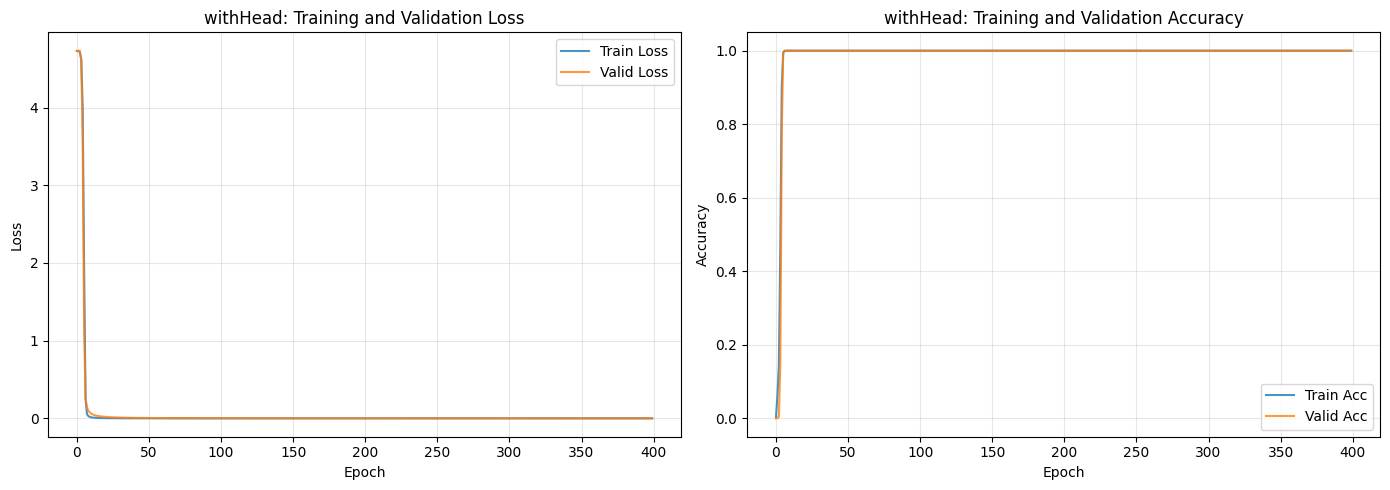

Saved withHead_training_results.png


In [7]:
ModelConfig.d_hidden = DataConfig.P
TrainConfig.epochs = 400

w_projection = init_model(ModelConfig)
p_results = train_loop(w_projection, loaders, TrainConfig)

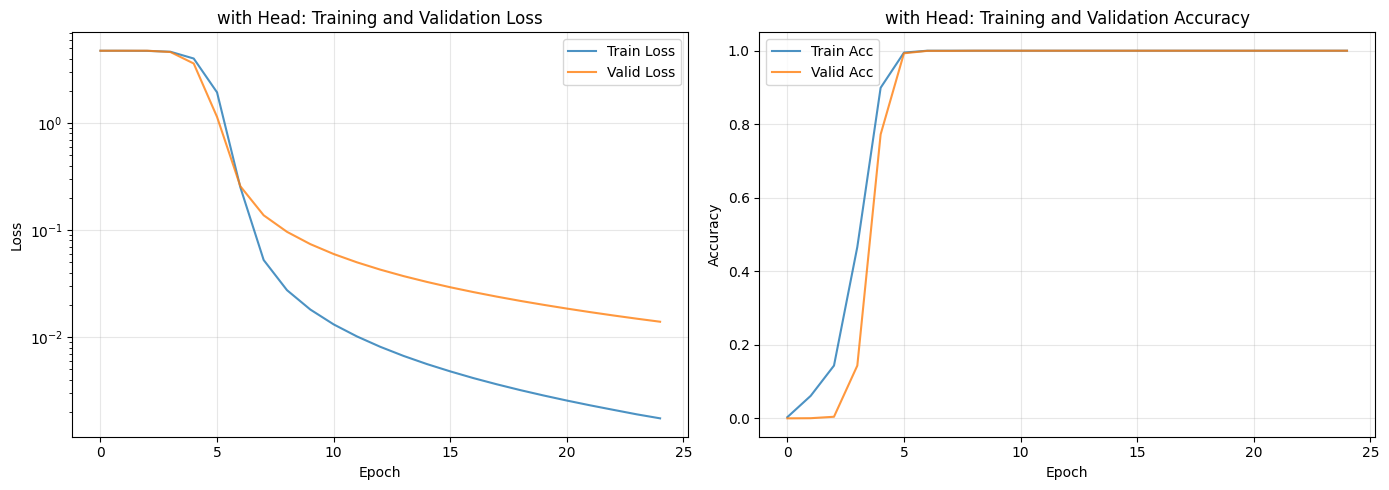

Saved with Head_training_results.png


In [8]:
plot_training_results(p_results["train_losses"], p_results["valid_losses"], p_results["train_accs"], p_results["valid_accs"], 
                      arc = "with Head", y_scale = "log", cut_off_epoch=25)

In [9]:
# Sanity check n=1
test_point = 1337
pair = pairs[test_point, :]
label = labels[test_point]
one_hot = onehots[test_point, :]
print(f"{pair=}")
print(f"{(pair.sum().item() % DataConfig.P)=}")
print(f"{label=}")
print(f"{torch.argmax(w_projection(one_hot))=}")

# Memorisation?
total_params = sum(p.numel() for p in w_projection.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

pair=tensor([11, 94])
(pair.sum().item() % DataConfig.P)=105
label=tensor(105)
torch.argmax(w_projection(one_hot))=tensor(105)
Total number of parameters: 63845


## Interaction Matrices of the Bilinear Layer with Head

In [10]:
# Compute the interaction matrix for a given output dimension
from plotly import express as px
from einops import einsum
import pandas as pd
torch.set_grad_enabled(False)

int_mats = []
eigenvalues_list = []
eigenvectors_list = []
remainders = [0, 5, 22, 42, 66, 99]

for k in remainders:
    q = einsum(w_projection.w_p[k], w_projection.w_l, w_projection.w_r, "hid, hid in1, hid in2 -> in1 in2")

    # Symmetrize the interaction matrix, uncomment for a clean interaction matrix
    # .mT is the transpose of the last two dimensions (which does not matter here but will in the future)
    q = 0.5 * (q + q.mT)
    int_mats.append(q)

    # Compute eigenvectors and eigenvalues of symmetric interaction matrix
    eigenvalues, eigenvectors = torch.linalg.eigh(q)  # eigh for symmetric matrices (more stable)
    
    # Sort by descending eigenvalue magnitude (eigh returns ascending order)
    idx = eigenvalues.abs().argsort(descending=True)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    eigenvalues_list.append(eigenvalues)
    eigenvectors_list.append(eigenvectors)

# Stack for easier manipulation
int_mats = torch.stack(int_mats, dim=0)
eigenvalues_tensor = torch.stack(eigenvalues_list, dim=0)  # [num_remainders, P]
eigenvectors_tensor = torch.stack(eigenvectors_list, dim=0)  # [num_remainders, P, P]

# Visualize interaction matrices
fig = px.imshow(int_mats, color_continuous_midpoint=0, color_continuous_scale="RdBu", facet_col=0)
facet_names = [f"{remainder=}" for remainder in remainders]
for i, ann in enumerate(fig.layout.annotations):
    ann.text = facet_names[i]
fig.show()

# Create a DataFrame for better plotly handling
eigenvalues_df = pd.DataFrame(
    eigenvalues_tensor.numpy().T,  # Transpose so each column is a remainder
    columns=[f"remainder={r}" for r in remainders]
)
eigenvalues_df['Eigenvalue Index'] = eigenvalues_df.index

fig_eig = px.line(
    eigenvalues_df, 
    x='Eigenvalue Index',
    y=[f"remainder={r}" for r in remainders],
    labels={'value': 'Eigenvalue', 'variable': 'Remainder'},
    title='Eigenvalue Spectrum for Each Remainder'
)
fig_eig.update_layout(legend_title_text='Remainder')
fig_eig.show()

# Visualize top eigenvectors (e.g., top 3 for each remainder)
# num_top_eigenvectors = 3
# fig_eigvec, axes = plt.subplots(len(remainders), num_top_eigenvectors, figsize=(15, 3*len(remainders)))
# for i, remainder in enumerate(remainders):
#     for j in range(num_top_eigenvectors):
#         ax = axes[i, j] if len(remainders) > 1 else axes[j]
#         eigvec = eigenvectors_tensor[i, :, j].numpy()
#         ax.plot(eigvec)
#         ax.set_title(f'remainder={remainder}, eigvec {j}\n(λ={eigenvalues_tensor[i, j]:.3f})')
#         ax.set_xlabel('Input dimension')
#         ax.set_ylabel('Component')
#         ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# print(f"Eigenvalues shape: {eigenvalues_tensor.shape}")
# print(f"Eigenvectors shape: {eigenvectors_tensor.shape}")
# print(f"\nTop 5 eigenvalues for each remainder:")
# for i, remainder in enumerate(remainders):
#     print(f"  remainder={remainder}: {eigenvalues_tensor[i, :5].numpy()}")

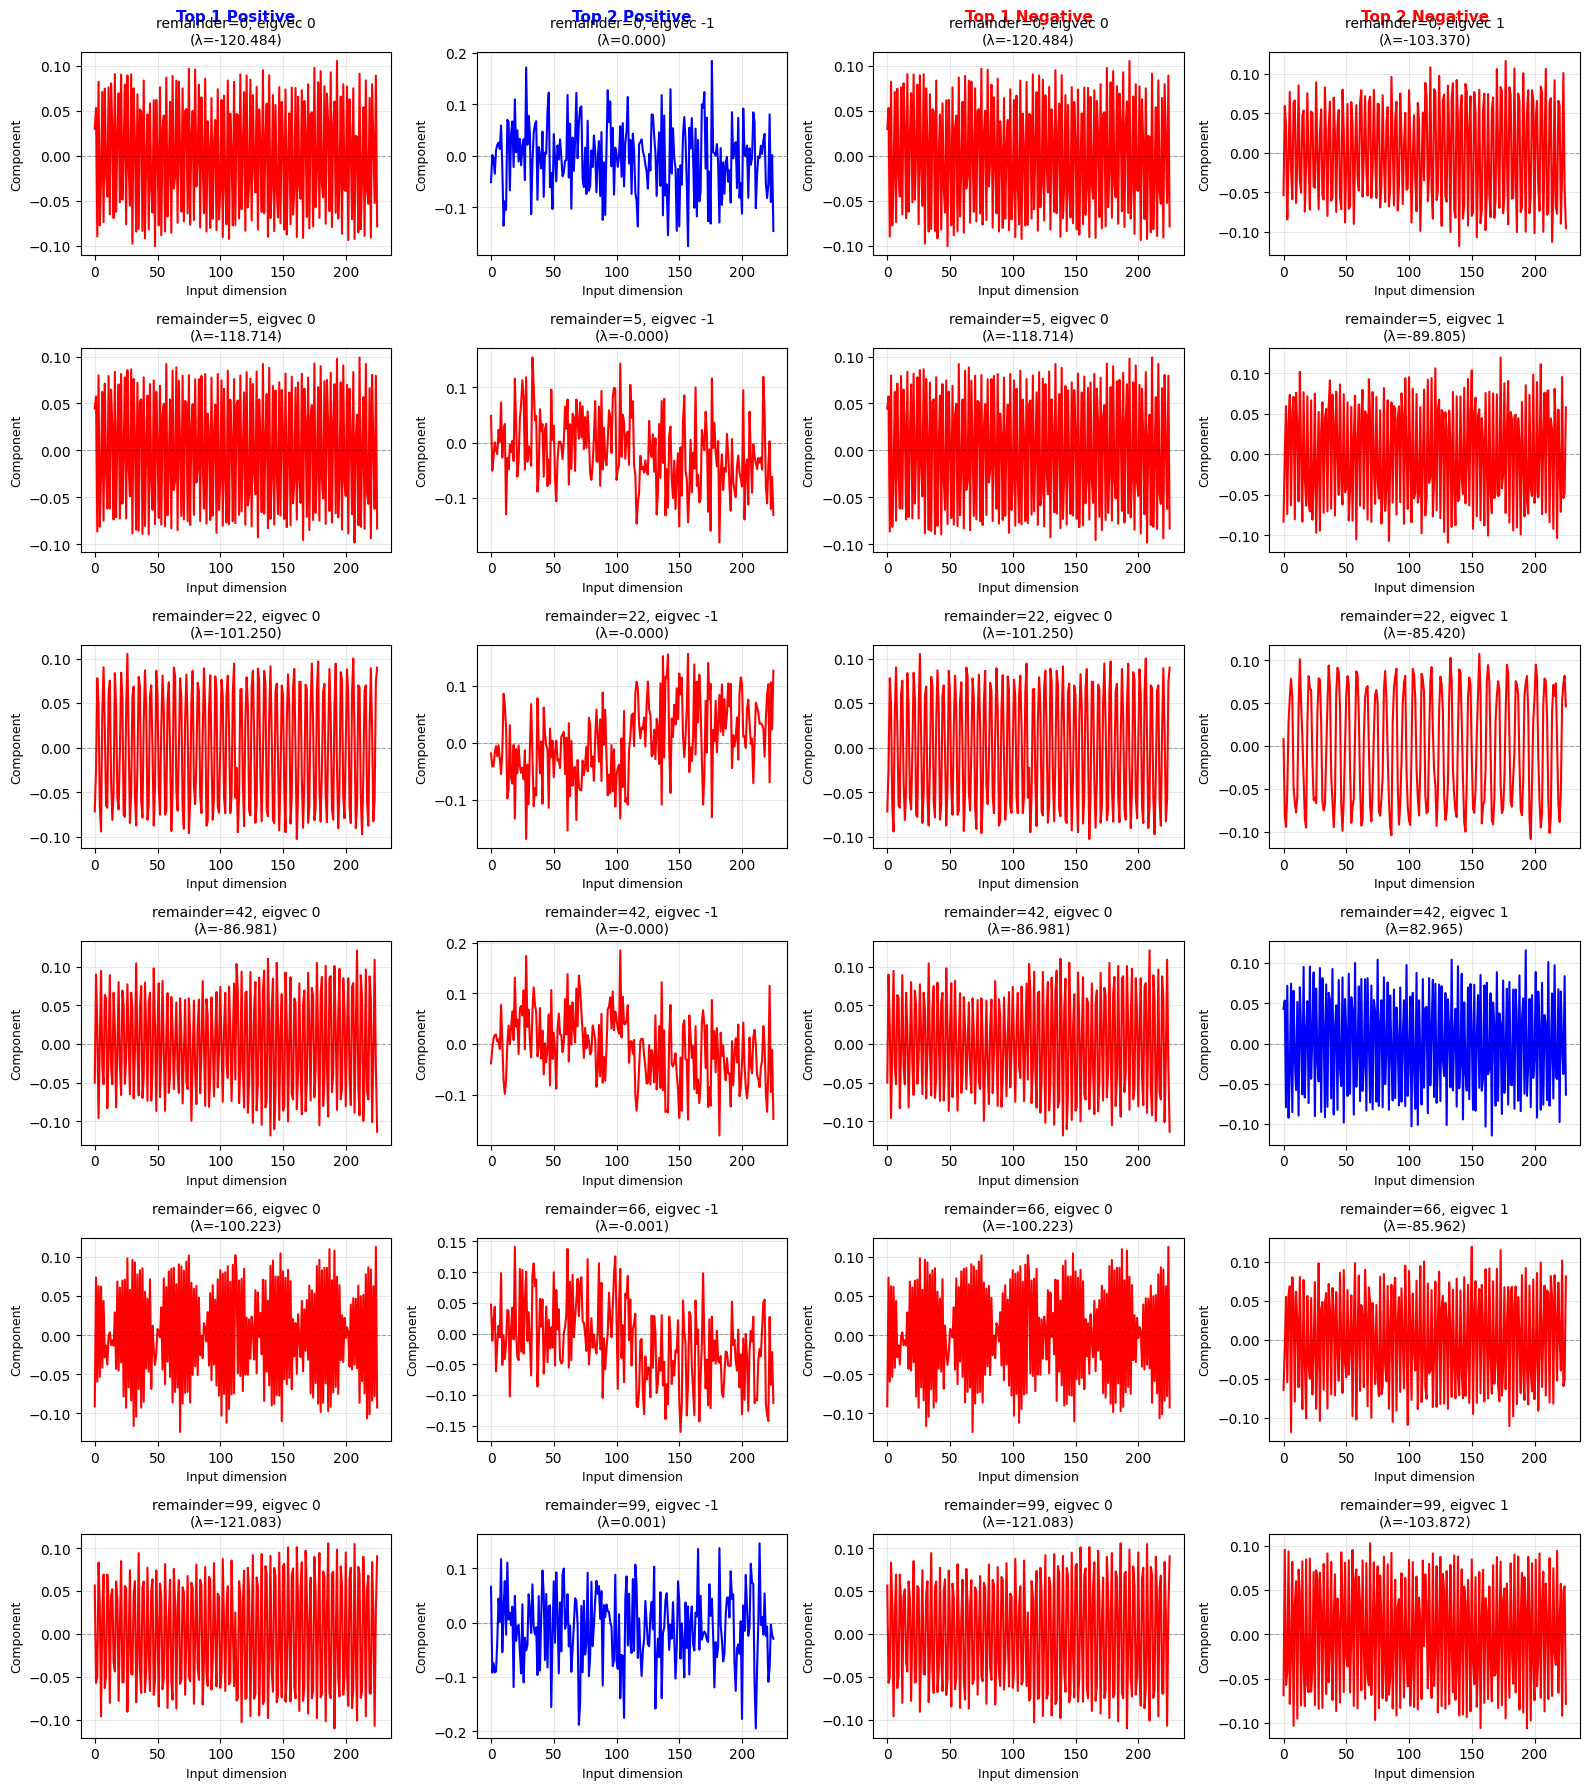


Top 2 positive and top 2 negative eigenvalues for each remainder:
  remainder=0:
    Positive: [0.00031221 0.00016736]
    Negative: [-120.48448  -103.369934]
  remainder=5:
    Positive: [ 0.00075983 -0.00020995]
    Negative: [-118.713844  -89.80506 ]
  remainder=22:
    Positive: [ 0.00059463 -0.00010981]
    Negative: [-101.250374  -85.42017 ]
  remainder=42:
    Positive: [ 3.0008654e-04 -9.5363626e-05]
    Negative: [-86.9811   82.96529]
  remainder=66:
    Positive: [-0.00184927 -0.00088716]
    Negative: [-100.222725  -85.96214 ]
  remainder=99:
    Positive: [-0.00093073  0.00092356]
    Negative: [-121.08308 -103.87152]


In [11]:
# Visualize top positive and negative eigenvectors
num_pos = 2  # Top 2 positive eigenvalues
num_neg = 2  # Top 2 negative eigenvalues (most negative)

fig_eigvec, axes = plt.subplots(len(remainders), num_pos + num_neg, figsize=(16, 3*len(remainders)))

for i, remainder in enumerate(remainders):
    # Get indices for top positive and most negative eigenvalues
    eigenvals = eigenvalues_tensor[i].numpy()
    
    # Top positive (already sorted by magnitude, but we want actual values)
    pos_indices = [-j for j in range(num_pos)]
    # Most negative (smallest values)
    neg_indices = [j for j in range(num_neg)]
    
    # Combine: top positive first, then most negative
    selected_indices = pos_indices + neg_indices
    
    for col, j in enumerate(selected_indices):
        ax = axes[i, col] if len(remainders) > 1 else axes[col]
        eigvec = eigenvectors_tensor[i, :, j].numpy()
        
        # Color code: blue for positive eigenvalues, red for negative
        color = 'blue' if eigenvalues_tensor[i, j] > 0 else 'red'
        
        ax.plot(eigvec, color=color, linewidth=1.5)
        ax.set_title(f'remainder={remainder}, eigvec {j}\n(λ={eigenvalues_tensor[i, j]:.3f})', 
                     fontsize=10)
        ax.set_xlabel('Input dimension', fontsize=9)
        ax.set_ylabel('Component', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)

# Add column labels
for col in range(num_pos):
    axes[0, col].text(0.5, 1.15, f'Top {col+1} Positive', 
                      transform=axes[0, col].transAxes,
                      ha='center', fontsize=11, fontweight='bold', color='blue')
for col in range(num_neg):
    axes[0, num_pos + col].text(0.5, 1.15, f'Top {col+1} Negative', 
                                transform=axes[0, num_pos + col].transAxes,
                                ha='center', fontsize=11, fontweight='bold', color='red')

plt.tight_layout()
plt.savefig('app_diagrams/eigenvector_components_pos_neg.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTop 2 positive and top 2 negative eigenvalues for each remainder:")
for i, remainder in enumerate(remainders):
    eigenvals = eigenvalues_tensor[i].numpy()
    pos_vals = eigenvals[-2:]
    neg_vals = eigenvals[:2]
    print(f"  remainder={remainder}:")
    print(f"    Positive: {pos_vals}")
    print(f"    Negative: {neg_vals}")